In [417]:
with open (r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Checkpoints\train_log.csv","r") as f:
     lines = f.readlines()
     print(lines[0])

epoch,step,lr,total_loss,loss_e,loss_f,loss_s,mae_e,mae_f,mae_s_gpa



In [432]:
import pandas as pd
data = pd.read_csv(r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Checkpoints\val_log.csv")


In [433]:
import matplotlib.pyplot as plt
import numpy as np

# ========= 全局绘图风格 =========
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "lines.linewidth": 2,
    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ========= 采样设置 =========
STEP_STRIDE = 1
AVG_WINDOW = 471     # 用最后多少个 step 计算平均
MARK_EVERY = 1

step = data.index[::STEP_STRIDE]

# ========= epoch → step 映射（只算一次） =========
epoch_steps = (
    data.groupby("epoch")
        .apply(lambda df: df.index.min())
        .to_numpy()
)

def plot_metric(
    y,
    ylabel,
    title,
    ylim=None,
    logy=False,
    color="C0",
):
    y_sampled = y.iloc[::STEP_STRIDE]

    fig, ax = plt.subplots(figsize=(6, 4))

    # ---- 主曲线 ----
    ax.plot(
        step,
        y_sampled,
        marker="o",
        markersize=1,
        markevery=MARK_EVERY,
        alpha=0.5,
        color=color,
    )

    # ---- 平均线（最后 AVG_WINDOW 个点）----
    avg_slice = y_sampled.iloc[-AVG_WINDOW:]
    avg_val = avg_slice.mean()

    ax.axhline(
        avg_val,
        color="red",
        linestyle="--",
        linewidth=1,
        label=f"Avg(last {AVG_WINDOW})",
    )

    ax.text(
        step[int(len(step) * 0.9)],
        avg_val * (1.5 if not logy else 1.5),
        f"{avg_val:.5f}",
        color="red",
        fontsize=10,
    )

    y_text_pos = -0.15  # 轴坐标系里的高度（0~1）

    for i, es in enumerate(epoch_steps, start=1):
        ax.axvline(
            es,
            color="red",
            linestyle=":",
            linewidth=1,
            alpha=1,
        )

        ax.text(
            es,
            y_text_pos + 0.05,
            f"Epoch{i}",
            color="red",
            fontsize=6,
            alpha=1,
            rotation=0,
            ha="center",
            va="bottom",
            transform=ax.get_xaxis_transform(),  # ⭐ 关键
        )

    # ---- 轴设置 ----
    if logy:
        ax.set_yscale("log")
    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xlabel("Step")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.grid(True, which="both", linestyle="--", alpha=0.35)
    fig.tight_layout()
    plt.show()


C:\Users\1\AppData\Local\Temp\ipykernel_29860\2484817474.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.index.min())


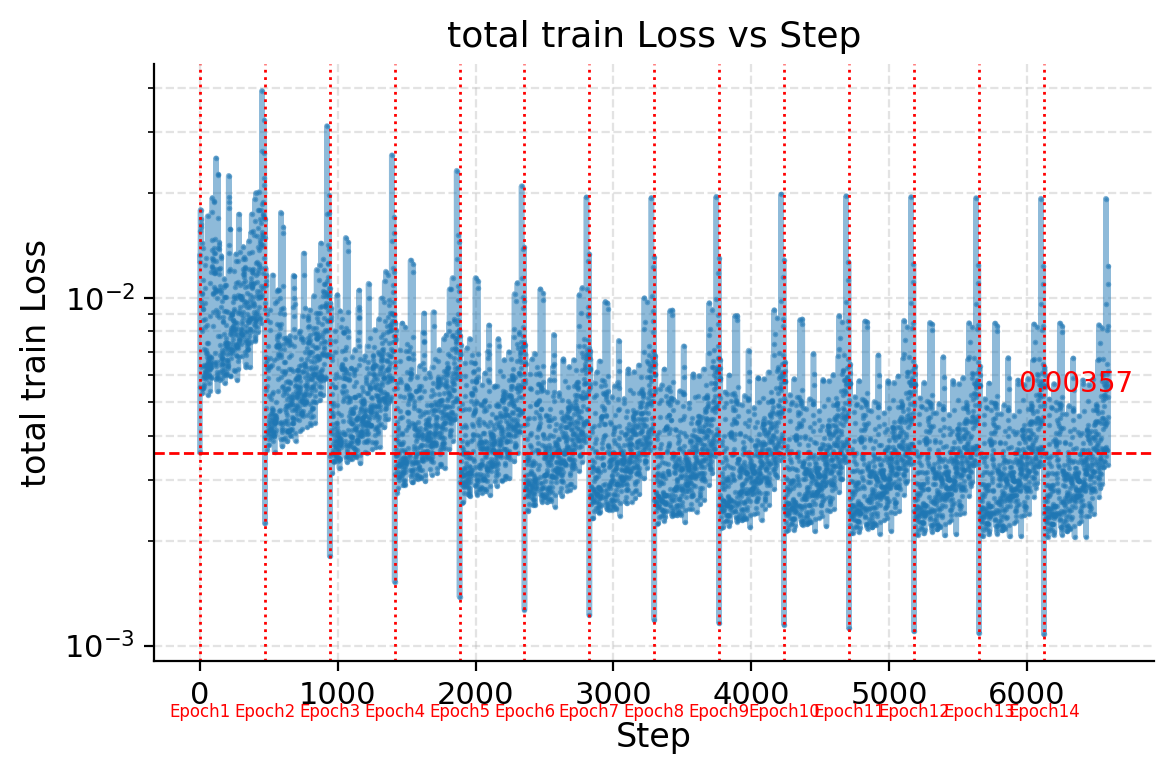

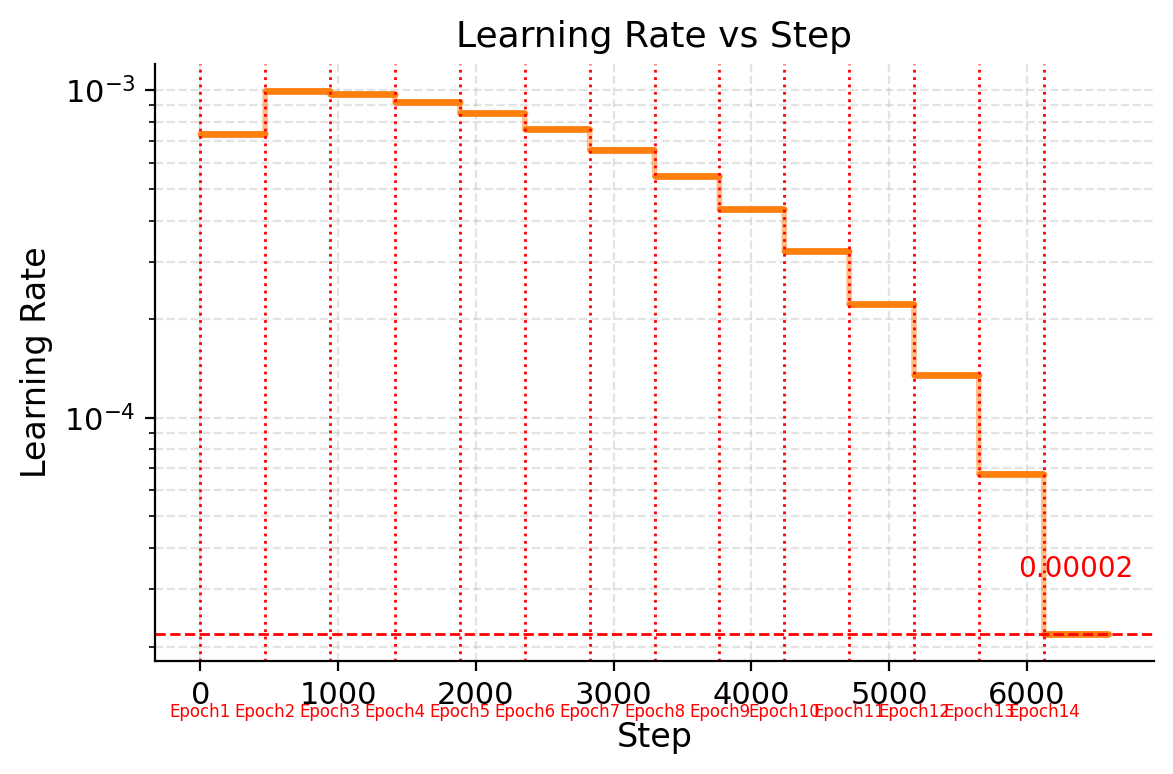

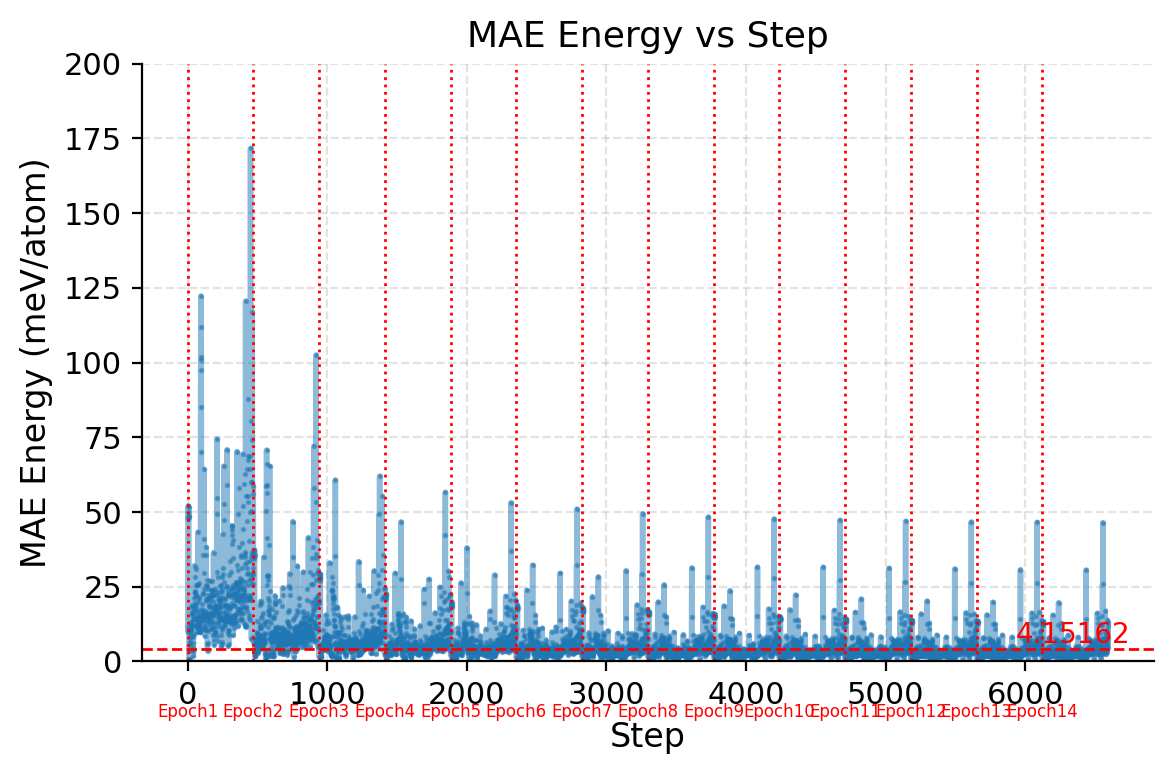

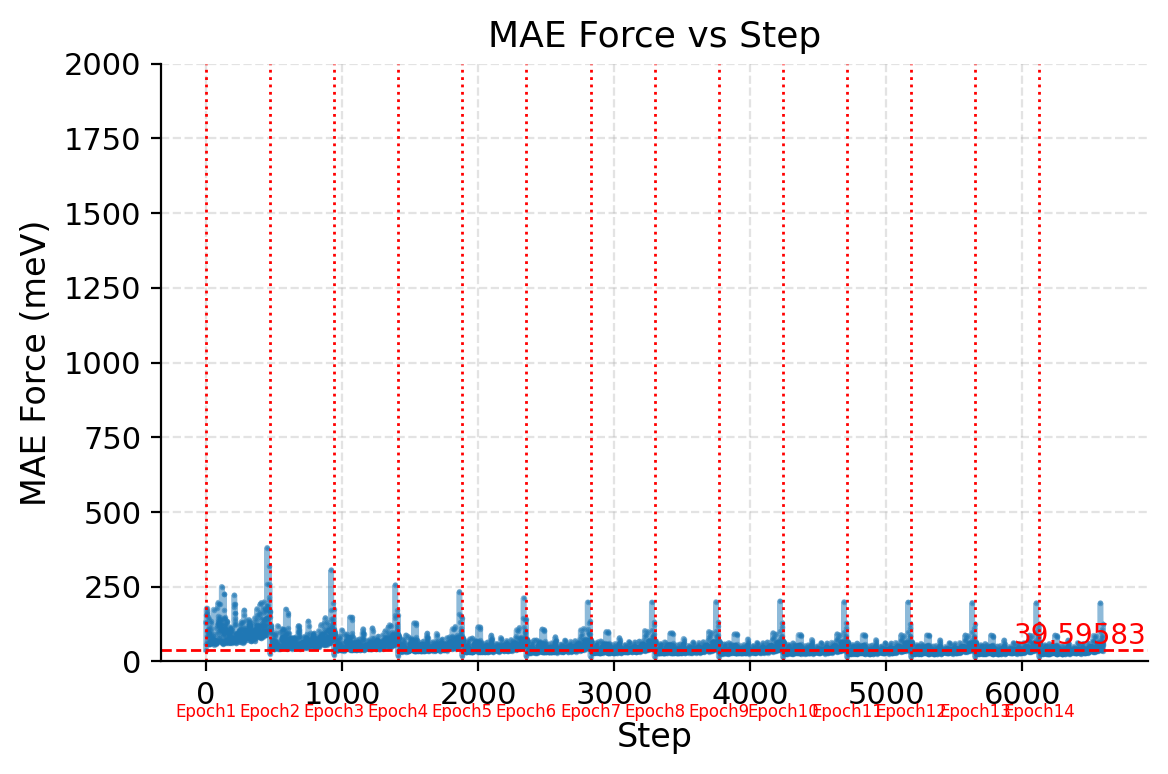

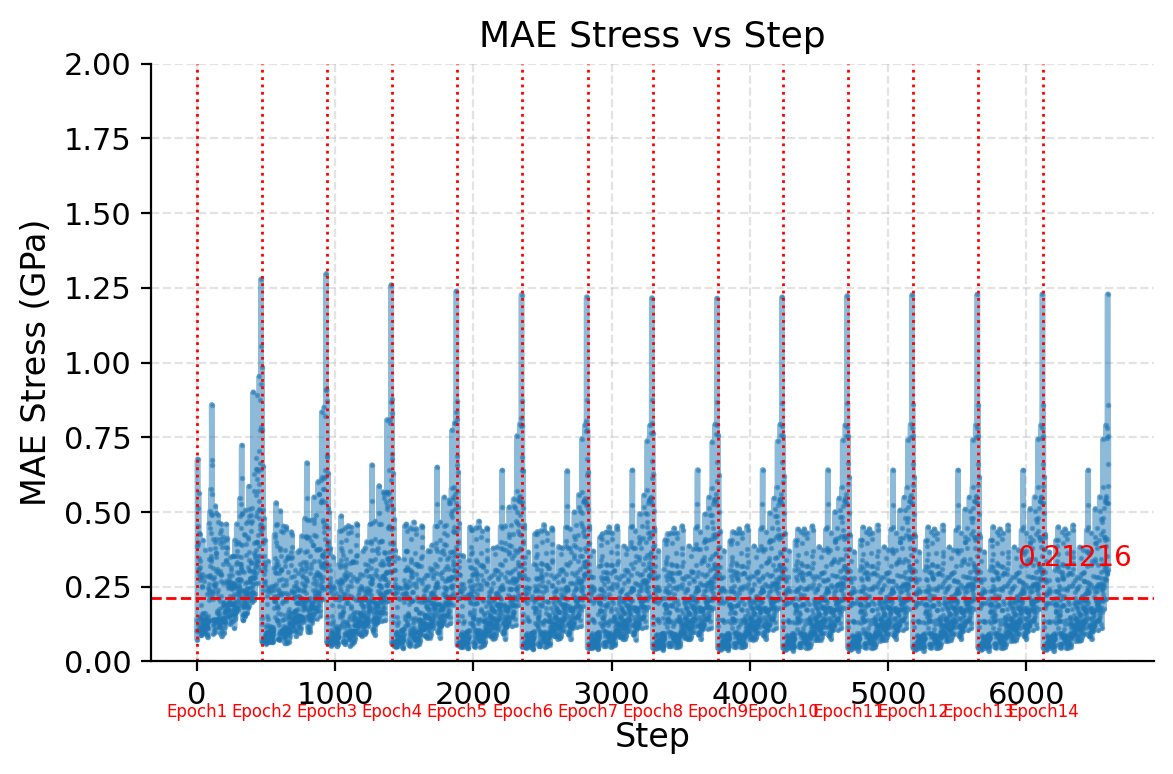

In [434]:
plot_metric(
    data["total_loss"],
    ylabel="total train Loss",
    title="total train Loss vs Step",
    logy=True,
)


plot_metric(
    data["lr"],
    ylabel="Learning Rate",
    title="Learning Rate vs Step",
    logy=True,
    color="C1",
)

plot_metric(
    data["mae_e"],
    ylabel="MAE Energy (meV/atom)",
    title="MAE Energy vs Step",
    ylim=(0, 200),
)

plot_metric(
    data["mae_f"],
    ylabel="MAE Force (meV)",
    title="MAE Force vs Step",
    ylim=(0, 2000),
)

plot_metric(
    data["mae_s_gpa"],
    ylabel="MAE Stress (GPa)",
    title="MAE Stress vs Step",
    ylim=(0, 2),
)

In [15]:
import torch
import numpy as np
import json
import os
import sys
# 获取当前 notebook 所在的目录
current_dir = os.getcwd() 

# 获取上一级目录 (即项目根目录)
project_root = os.path.abspath(os.path.join(current_dir, ".."))
print(project_root)
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch_geometric.loader import DataLoader

# --- 导入自定义模块 ---
from src.data import ChunkedSmartDataset   # 👈 新的数据集
from src.data import BinPackingSampler # 👈 新的采样器
from src.models import HTGPModel
from src.utils import HTGPConfig
from src.engine import PotentialTrainer 

config = HTGPConfig(
    num_atom_types=55, 
    hidden_dim=64, 
    num_layers=3, 
    cutoff=6.0, 
    num_rbf=10,
    use_L0=True, 
    use_L1=True,
    use_L2=True, 
    use_gating=True, 
    use_long_range=False
)

# build model
model = HTGPModel(config)
# load model parameters
path = r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Checkpoints\model_epoch_14.pt"
state_dict = torch.load(path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
new_state_dict = {}
for k, v in state_dict.items():
    # 如果键以 module. 开头，去掉这 7 个字符
    if k.startswith('module.'):
        name = k[7:] 
    else:
        name = k
    new_state_dict[name] = v
try:
    model.load_state_dict(new_state_dict, strict=True)
    print("✅ 模型参数加载成功！")
except RuntimeError as e:
    print(f"❌ 加载依然失败，请检查 Config 是否与训练一致。\n详细错误: {e}")
# 总参数
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {total_params}")
# 模型是32还是64精度
dtypes = {p.dtype for p in model.parameters()}

if dtypes == {torch.float32}:
    print("模型参数精度: float32 (FP32)")
elif dtypes == {torch.float64}:
    print("模型参数精度: float64 (FP64)")
else:
    print("模型参数包含多种精度:", dtypes)
    
# 打印cfg
print(model.cfg)

c:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology
✅ 模型参数加载成功！
模型总参数量: 413201
模型参数精度: float32 (FP32)
HTGPConfig(num_atom_types=55, hidden_dim=64, num_layers=3, cutoff=6.0, num_rbf=10, atom_types_map=[1, 5, 6, 7, 8, 9, 15, 16, 17, 35, 53], use_L0=True, use_L1=True, use_L2=True, use_gating=True, use_long_range=False, active_paths={(0, 0, 0, 'prod'): True, (0, 1, 1, 'prod'): True, (0, 2, 2, 'prod'): True, (1, 0, 1, 'prod'): True, (1, 1, 0, 'dot'): True, (1, 1, 1, 'cross'): True, (1, 1, 2, 'outer'): True, (2, 0, 2, 'prod'): True, (2, 1, 1, 'mat_vec'): True, (1, 2, 1, 'vec_mat'): True, (2, 2, 0, 'double_dot'): True, (2, 2, 2, 'mat_mul_sym'): True})


In [12]:
from src.utils import HTGP_Calculator
calculator = HTGP_Calculator(model, cutoff=6.0, device="cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
from ase.io import read
# data_path = r"C:\Users\1\Desktop\traIning set\zip_files\005_part2\UCEPAU.xyz"
data_path = r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\Task_1.xyz"
atoms_list = read(data_path, index=":")
import os
errors_force_all = []
Task_1_list = [cif.split(".")[0] for cif in os.listdir(r"C:\Users\1\Desktop\Task_1") if cif.endswith(".cif")]
for atoms in tqdm(atoms_list):
     # if atoms.info["material_id"] not in Task_1_list:
     #     continue
     atoms.set_calculator(calculator)
     energy = calculator.get_potential_energy(atoms)
     # print(f"Predicted Energy: {energy} eV")
     force = calculator.get_forces(atoms)
     # print(f"positions:, {atoms.get_positions()}, Predicted Forces:\n{force}")
     stress = calculator.get_stress(atoms)
# print(f"Predicted Stress:\n{stress}")

# from ase.optimize import BFGS
# from ase.filters import FrechetCellFilter

# sf = FrechetCellFilter(atoms)
# opt = BFGS(sf, logfile=None)
# opt.run(fmax=0.01, steps=3000)

# print(getattr(opt, 'nsteps', None))
# # 保存cif
# from ase.io import write
# write("optimized_structure.cif", atoms)

# 计算误差
     true_energy = atoms.info["REF_energy"]
     energy_error = abs(energy - true_energy) / len(atoms)
     print(f"Energy Error: {energy_error} eV/atom")
     true_forces = atoms.arrays["REF_forces"]
     from torch.nn import functional as F
     force_error = F.l1_loss(torch.tensor(force), torch.tensor(true_forces)).item()
     errors_force_all.append(force_error)
     print(f"Force MAE: {force_error} eV/Å")
     # true_stress = atoms.info["REF_stress"]
     # stress_error = np.linalg.norm(stress - true_stress) * 160.21766208 / 6  # 转换为 GPa 并取平均
     # print(f"Stress MAE: {stress_error} GPa")

  0%|          | 0/3157 [00:00<?, ?it/s]C:\Users\1\AppData\Local\Temp\ipykernel_52532\269143211.py:14: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calculator)
  0%|          | 1/3157 [00:01<54:31,  1.04s/it]

Energy Error: 0.000446064815491809 eV/atom
Force MAE: 0.02948094248299375 eV/Å


  0%|          | 2/3157 [00:01<49:29,  1.06it/s]

Energy Error: 0.004356431894737062 eV/atom
Force MAE: 0.0406024679690439 eV/Å


  0%|          | 3/3157 [00:02<45:24,  1.16it/s]

Energy Error: 0.0013852449228051813 eV/atom
Force MAE: 0.01655358668261938 eV/Å


  0%|          | 4/3157 [00:02<32:57,  1.59it/s]

Energy Error: 0.006249259660156525 eV/atom
Force MAE: 0.036241200445436945 eV/Å


  0%|          | 5/3157 [00:03<27:30,  1.91it/s]

Energy Error: 0.001835262202459799 eV/atom
Force MAE: 0.025725274562001188 eV/Å


  0%|          | 6/3157 [00:03<24:54,  2.11it/s]

Energy Error: 0.0062916625640627895 eV/atom
Force MAE: 0.02597890839695995 eV/Å


  0%|          | 7/3157 [00:03<21:43,  2.42it/s]

Energy Error: 0.0006967810489909946 eV/atom
Force MAE: 0.029124182217285396 eV/Å


  0%|          | 8/3157 [00:04<22:18,  2.35it/s]

Energy Error: 0.0034858820952557924 eV/atom
Force MAE: 0.07551179479571059 eV/Å


  0%|          | 9/3157 [00:04<19:26,  2.70it/s]

Energy Error: 0.002235967360025626 eV/atom
Force MAE: 0.021666040961446965 eV/Å


  0%|          | 10/3157 [00:05<19:44,  2.66it/s]

Energy Error: 0.015178037703936876 eV/atom
Force MAE: 0.04238269562785141 eV/Å


  0%|          | 11/3157 [00:05<19:29,  2.69it/s]

Energy Error: 0.00087306856917192 eV/atom
Force MAE: 0.046390896193871316 eV/Å


  0%|          | 12/3157 [00:05<20:04,  2.61it/s]

Energy Error: 0.00773315404399673 eV/atom
Force MAE: 0.026221066995540207 eV/Å


  0%|          | 13/3157 [00:06<17:42,  2.96it/s]

Energy Error: 0.0007659017057291679 eV/atom
Force MAE: 0.020036904293146064 eV/Å


  0%|          | 14/3157 [00:06<15:57,  3.28it/s]

Energy Error: 0.0011141784287111989 eV/atom
Force MAE: 0.025960012814732272 eV/Å


  0%|          | 15/3157 [00:06<16:11,  3.23it/s]

Energy Error: 0.001035378854166898 eV/atom
Force MAE: 0.028769521852192885 eV/Å


  1%|          | 16/3157 [00:06<15:50,  3.30it/s]

Energy Error: 0.0019393802900388834 eV/atom
Force MAE: 0.03242205269725732 eV/Å


  1%|          | 17/3157 [00:07<18:32,  2.82it/s]

Energy Error: 0.00029975572853898876 eV/atom
Force MAE: 0.01493277509255055 eV/Å


  1%|          | 18/3157 [00:07<19:14,  2.72it/s]

Energy Error: 0.0047059078847652815 eV/atom
Force MAE: 0.03275949014687438 eV/Å


  1%|          | 19/3157 [00:08<19:49,  2.64it/s]

Energy Error: 0.0023666710611974415 eV/atom
Force MAE: 0.08563116955405078 eV/Å


  1%|          | 20/3157 [00:08<18:03,  2.90it/s]

Energy Error: 0.0012307812779709696 eV/atom
Force MAE: 0.017241444642546108 eV/Å


  1%|          | 21/3157 [00:08<18:31,  2.82it/s]

Energy Error: 0.009816318645241169 eV/atom
Force MAE: 0.027048923711199255 eV/Å


  1%|          | 22/3157 [00:09<17:42,  2.95it/s]

Energy Error: 0.001233055251359276 eV/atom
Force MAE: 0.028834802704638812 eV/Å


  1%|          | 23/3157 [00:09<15:58,  3.27it/s]

Energy Error: 0.003626598258928685 eV/atom
Force MAE: 0.026384295470188165 eV/Å


  1%|          | 24/3157 [00:09<15:31,  3.36it/s]

Energy Error: 0.060159678529974565 eV/atom
Force MAE: 0.3398116866295274 eV/Å


  1%|          | 25/3157 [00:10<18:39,  2.80it/s]

Energy Error: 0.009283491264204842 eV/atom
Force MAE: 0.03345814949789542 eV/Å


  1%|          | 26/3157 [00:10<18:01,  2.89it/s]

Energy Error: 0.0023792775493421316 eV/atom
Force MAE: 0.030060859264386033 eV/Å


  1%|          | 27/3157 [00:10<18:17,  2.85it/s]

Energy Error: 0.00474630546784143 eV/atom
Force MAE: 0.03626950647026566 eV/Å


  1%|          | 29/3157 [00:11<17:29,  2.98it/s]

Energy Error: 0.000668099680706044 eV/atom
Force MAE: 0.037345724699347944 eV/Å
Energy Error: 0.002761843914473311 eV/atom
Force MAE: 0.03390427124631529 eV/Å


  1%|          | 30/3157 [00:11<16:38,  3.13it/s]

Energy Error: 0.0038906578570131493 eV/atom
Force MAE: 0.046712742804956936 eV/Å


  1%|          | 31/3157 [00:12<15:56,  3.27it/s]

Energy Error: 0.0015301833300782163 eV/atom
Force MAE: 0.06317172618297266 eV/Å


  1%|          | 32/3157 [00:12<19:33,  2.66it/s]

Energy Error: 0.009013704625289165 eV/atom
Force MAE: 0.02917695710527113 eV/Å


  1%|          | 33/3157 [00:12<17:32,  2.97it/s]

Energy Error: 0.0056748639062504935 eV/atom
Force MAE: 0.0706187571081847 eV/Å


  1%|          | 34/3157 [00:13<18:04,  2.88it/s]

Energy Error: 0.007217671297940275 eV/atom
Force MAE: 0.02030097513062255 eV/Å


  1%|          | 35/3157 [00:13<17:36,  2.95it/s]

Energy Error: 0.012272991602539206 eV/atom
Force MAE: 0.05885853232732141 eV/Å


  1%|          | 36/3157 [00:13<17:27,  2.98it/s]

Energy Error: 0.004403262788978966 eV/atom
Force MAE: 0.030300987067331815 eV/Å


  1%|          | 38/3157 [00:14<13:40,  3.80it/s]

Energy Error: 0.004379517931385719 eV/atom
Force MAE: 0.09669177345846097 eV/Å
Energy Error: 0.006428593248355547 eV/atom
Force MAE: 0.07141402768189735 eV/Å


  1%|          | 39/3157 [00:14<15:45,  3.30it/s]

Energy Error: 0.002793678422080641 eV/atom
Force MAE: 0.07122330446050835 eV/Å


  1%|▏         | 40/3157 [00:14<15:10,  3.42it/s]

Energy Error: 0.0021365199381513378 eV/atom
Force MAE: 0.014845476048041702 eV/Å


  1%|▏         | 41/3157 [00:15<15:29,  3.35it/s]

Energy Error: 0.02557803040972178 eV/atom
Force MAE: 0.09852054492785685 eV/Å


  1%|▏         | 42/3157 [00:15<15:02,  3.45it/s]

Energy Error: 0.0033986361187900026 eV/atom
Force MAE: 0.030796981551998146 eV/Å


  1%|▏         | 44/3157 [00:15<12:32,  4.14it/s]

Energy Error: 0.0005588475752319151 eV/atom
Force MAE: 0.053763193479661034 eV/Å
Energy Error: 0.0069961472882407874 eV/atom
Force MAE: 0.025922601172072478 eV/Å


  1%|▏         | 45/3157 [00:16<12:19,  4.21it/s]

Energy Error: 0.0005202924814966536 eV/atom
Force MAE: 0.026215877307663882 eV/Å


  1%|▏         | 46/3157 [00:16<12:56,  4.01it/s]

Energy Error: 0.0017722466838235693 eV/atom
Force MAE: 0.03435957443338785 eV/Å


  1%|▏         | 47/3157 [00:16<13:22,  3.88it/s]

Energy Error: 0.0012582796330177285 eV/atom
Force MAE: 0.02044263242004436 eV/Å


  2%|▏         | 48/3157 [00:16<13:30,  3.84it/s]

Energy Error: 0.027346886461805296 eV/atom
Force MAE: 0.05370322968343328 eV/Å


  2%|▏         | 49/3157 [00:17<13:13,  3.92it/s]

Energy Error: 0.0013806304796506 eV/atom
Force MAE: 0.02813863267141309 eV/Å


  2%|▏         | 50/3157 [00:17<13:14,  3.91it/s]

Energy Error: 0.0057610806457268045 eV/atom
Force MAE: 0.03160535407258196 eV/Å


  2%|▏         | 51/3157 [00:17<13:38,  3.79it/s]

Energy Error: 0.003339009948454124 eV/atom
Force MAE: 0.032152953901230776 eV/Å


  2%|▏         | 52/3157 [00:18<16:03,  3.22it/s]

Energy Error: 0.0008516730098153566 eV/atom
Force MAE: 0.011685355453450313 eV/Å


  2%|▏         | 53/3157 [00:18<15:29,  3.34it/s]

Energy Error: 0.0099055210124364 eV/atom
Force MAE: 0.03128100930403615 eV/Å


  2%|▏         | 55/3157 [00:19<15:05,  3.42it/s]

Energy Error: 0.004520478469893666 eV/atom
Force MAE: 0.025060036834353348 eV/Å
Energy Error: 0.02160318428571459 eV/atom
Force MAE: 0.14165363304329676 eV/Å


  2%|▏         | 56/3157 [00:19<14:08,  3.66it/s]

Energy Error: 0.0004312424357635791 eV/atom
Force MAE: 0.043524560143167385 eV/Å


  2%|▏         | 57/3157 [00:19<13:13,  3.91it/s]

Energy Error: 0.002690483716796166 eV/atom
Force MAE: 0.04102928406094897 eV/Å


  2%|▏         | 58/3157 [00:20<17:09,  3.01it/s]

Energy Error: 0.006199019407552224 eV/atom
Force MAE: 0.019943323734259492 eV/Å


  2%|▏         | 59/3157 [00:20<16:27,  3.14it/s]

Energy Error: 0.002047858908005555 eV/atom
Force MAE: 0.06478235468329853 eV/Å


  2%|▏         | 60/3157 [00:20<17:37,  2.93it/s]

Energy Error: 1.7626351768291515e-05 eV/atom
Force MAE: 0.023217393243899473 eV/Å


  2%|▏         | 61/3157 [00:20<16:48,  3.07it/s]

Energy Error: 0.0006272550710230154 eV/atom
Force MAE: 0.019265825875799315 eV/Å


  2%|▏         | 62/3157 [00:21<18:47,  2.74it/s]

Energy Error: 0.013270014604492767 eV/atom
Force MAE: 0.04900354121101309 eV/Å


  2%|▏         | 63/3157 [00:21<18:18,  2.82it/s]

Energy Error: 0.0005083736345881107 eV/atom
Force MAE: 0.025806212539994752 eV/Å


  2%|▏         | 64/3157 [00:22<16:52,  3.06it/s]

Energy Error: 0.0008634079722609835 eV/atom
Force MAE: 0.03139798626073559 eV/Å


  2%|▏         | 65/3157 [00:22<19:33,  2.63it/s]

Energy Error: 0.0053043294404069245 eV/atom
Force MAE: 0.03579072670543113 eV/Å


  2%|▏         | 66/3157 [00:22<19:44,  2.61it/s]

Energy Error: 0.005394239342731156 eV/atom
Force MAE: 0.031204295473283572 eV/Å


  2%|▏         | 67/3157 [00:23<20:15,  2.54it/s]

Energy Error: 0.008695464255809453 eV/atom
Force MAE: 0.09807693861582958 eV/Å


  2%|▏         | 68/3157 [00:23<20:25,  2.52it/s]

Energy Error: 0.0033118387466031336 eV/atom
Force MAE: 0.08239286878974364 eV/Å


  2%|▏         | 69/3157 [00:24<20:33,  2.50it/s]

Energy Error: 0.00029157274999988656 eV/atom
Force MAE: 0.027448905678791304 eV/Å


  2%|▏         | 70/3157 [00:24<20:00,  2.57it/s]

Energy Error: 0.013474852532986385 eV/atom
Force MAE: 0.2613317427515059 eV/Å


  2%|▏         | 71/3157 [00:24<18:24,  2.79it/s]

Energy Error: 0.00807328212865239 eV/atom
Force MAE: 0.08482794933606408 eV/Å


  2%|▏         | 72/3157 [00:25<16:59,  3.03it/s]

Energy Error: 0.0025320062723213892 eV/atom
Force MAE: 0.028468728877005727 eV/Å


  2%|▏         | 73/3157 [00:25<18:08,  2.83it/s]

Energy Error: 0.0039322157311702105 eV/atom
Force MAE: 0.029525880356652677 eV/Å


  2%|▏         | 74/3157 [00:25<16:04,  3.20it/s]

Energy Error: 0.0021232897756409586 eV/atom
Force MAE: 0.01876575702748225 eV/Å


  2%|▏         | 75/3157 [00:25<15:38,  3.28it/s]

Energy Error: 0.009907060248724288 eV/atom
Force MAE: 0.027777041628983735 eV/Å


  2%|▏         | 76/3157 [00:26<14:23,  3.57it/s]

Energy Error: 0.0074490419968559814 eV/atom
Force MAE: 0.021879604618429367 eV/Å


  2%|▏         | 77/3157 [00:26<14:01,  3.66it/s]

Energy Error: 0.015074522488692753 eV/atom
Force MAE: 0.04454829814160393 eV/Å
Energy Error: 0.011483305360293879 eV/atom
Force MAE: 0.03027152729719246 eV/Å


  3%|▎         | 79/3157 [00:26<14:09,  3.62it/s]

Energy Error: 0.0003874894007242624 eV/atom
Force MAE: 0.021980722559463928 eV/Å


  3%|▎         | 80/3157 [00:27<14:41,  3.49it/s]

Energy Error: 0.0035164555163043547 eV/atom
Force MAE: 0.02659369240277757 eV/Å


  3%|▎         | 81/3157 [00:27<14:51,  3.45it/s]

Energy Error: 0.009073905193359622 eV/atom
Force MAE: 0.05051156977668714 eV/Å


  3%|▎         | 82/3157 [00:28<16:45,  3.06it/s]

Energy Error: 0.008995872531249916 eV/atom
Force MAE: 0.037868869108499854 eV/Å


  3%|▎         | 83/3157 [00:28<17:51,  2.87it/s]

Energy Error: 0.0014258121578120608 eV/atom
Force MAE: 0.025353916612333854 eV/Å


  3%|▎         | 84/3157 [00:28<16:14,  3.15it/s]

Energy Error: 0.012844170569069552 eV/atom
Force MAE: 0.057287177332575566 eV/Å


  3%|▎         | 85/3157 [00:28<15:18,  3.35it/s]

Energy Error: 0.0005357607101359463 eV/atom
Force MAE: 0.016163283068348893 eV/Å


  3%|▎         | 86/3157 [00:29<17:11,  2.98it/s]

Energy Error: 0.0018415676545521858 eV/atom
Force MAE: 0.025093098001218117 eV/Å


  3%|▎         | 87/3157 [00:29<16:08,  3.17it/s]

Energy Error: 0.005797102565789726 eV/atom
Force MAE: 0.029284376150796532 eV/Å


  3%|▎         | 88/3157 [00:29<16:55,  3.02it/s]

Energy Error: 0.006238407672937188 eV/atom
Force MAE: 0.020216535044807547 eV/Å


  3%|▎         | 89/3157 [00:30<16:52,  3.03it/s]

Energy Error: 0.0009628354371675704 eV/atom
Force MAE: 0.010523752724969535 eV/Å


  3%|▎         | 90/3157 [00:30<15:21,  3.33it/s]

Energy Error: 1.3818072918386153e-06 eV/atom
Force MAE: 0.04304477656407037 eV/Å


  3%|▎         | 91/3157 [00:30<16:12,  3.15it/s]

Energy Error: 0.006866388673713305 eV/atom
Force MAE: 0.0460706240567461 eV/Å


  3%|▎         | 92/3157 [00:31<17:12,  2.97it/s]

Energy Error: 0.002474951824269708 eV/atom
Force MAE: 0.028221452207475 eV/Å


  3%|▎         | 93/3157 [00:31<20:53,  2.44it/s]

Energy Error: 0.001925876459407255 eV/atom
Force MAE: 0.019870929953368564 eV/Å


  3%|▎         | 94/3157 [00:32<19:40,  2.59it/s]

Energy Error: 0.006529983750000538 eV/atom
Force MAE: 0.03940576286864668 eV/Å


  3%|▎         | 95/3157 [00:32<17:29,  2.92it/s]

Energy Error: 0.0033333602734373358 eV/atom
Force MAE: 0.04402551738646509 eV/Å


  3%|▎         | 96/3157 [00:32<16:49,  3.03it/s]

Energy Error: 0.0007010073675271245 eV/atom
Force MAE: 0.0288629727366802 eV/Å


  3%|▎         | 97/3157 [00:33<16:31,  3.09it/s]

Energy Error: 0.01507226987561694 eV/atom
Force MAE: 0.03717490436856775 eV/Å


  3%|▎         | 98/3157 [00:33<15:36,  3.26it/s]

Energy Error: 0.0038407902534303745 eV/atom
Force MAE: 0.023774908544893218 eV/Å


  3%|▎         | 99/3157 [00:33<15:36,  3.26it/s]

Energy Error: 0.00027082630208370673 eV/atom
Force MAE: 0.03338124923608247 eV/Å


  3%|▎         | 100/3157 [00:33<16:48,  3.03it/s]

Energy Error: 0.008068655672286545 eV/atom
Force MAE: 0.04271737382993007 eV/Å


  3%|▎         | 101/3157 [00:34<16:02,  3.18it/s]

Energy Error: 0.0020789549405571465 eV/atom
Force MAE: 0.02479597196953992 eV/Å


  3%|▎         | 102/3157 [00:34<16:39,  3.06it/s]

Energy Error: 0.00323765923113575 eV/atom
Force MAE: 0.05385229972380151 eV/Å


  3%|▎         | 103/3157 [00:34<15:47,  3.22it/s]

Energy Error: 0.003972702317976646 eV/atom
Force MAE: 0.02426709075717979 eV/Å


  3%|▎         | 104/3157 [00:35<17:23,  2.92it/s]

Energy Error: 0.0004280367616759547 eV/atom
Force MAE: 0.011835458700409739 eV/Å


  3%|▎         | 105/3157 [00:35<15:33,  3.27it/s]

Energy Error: 0.0005843698199723606 eV/atom
Force MAE: 0.021680431277719004 eV/Å


  3%|▎         | 106/3157 [00:35<17:49,  2.85it/s]

Energy Error: 0.006475594268973087 eV/atom
Force MAE: 0.03216876475072889 eV/Å


  3%|▎         | 107/3157 [00:36<16:45,  3.03it/s]

Energy Error: 0.009576322169471187 eV/atom
Force MAE: 0.03697695517945589 eV/Å


  3%|▎         | 108/3157 [00:36<17:08,  2.96it/s]

Energy Error: 0.0012064754448528326 eV/atom
Force MAE: 0.024353059681931355 eV/Å


  3%|▎         | 109/3157 [00:37<19:09,  2.65it/s]

Energy Error: 0.0008247643070658144 eV/atom
Force MAE: 0.030132150482137993 eV/Å


  3%|▎         | 110/3157 [00:37<17:52,  2.84it/s]

Energy Error: 8.460511160713501e-05 eV/atom
Force MAE: 0.018599794951965863 eV/Å


  4%|▎         | 111/3157 [00:37<18:34,  2.73it/s]

Energy Error: 0.00021397309357020088 eV/atom
Force MAE: 0.01602358016856266 eV/Å


  4%|▎         | 112/3157 [00:38<16:51,  3.01it/s]

Energy Error: 0.00043471108103250477 eV/atom
Force MAE: 0.025128293100819682 eV/Å


  4%|▎         | 113/3157 [00:38<15:46,  3.22it/s]

Energy Error: 0.00490963280704887 eV/atom
Force MAE: 0.03125384089524542 eV/Å
Energy Error: 0.041146775051398334 eV/atom
Force MAE: 0.2992550093794146 eV/Å


  4%|▎         | 115/3157 [00:38<15:01,  3.38it/s]

Energy Error: 0.0011894199186196868 eV/atom
Force MAE: 0.009380956530726502 eV/Å


  4%|▎         | 116/3157 [00:39<17:25,  2.91it/s]

Energy Error: 0.0011756370661768255 eV/atom
Force MAE: 0.020274280813327664 eV/Å


  4%|▎         | 117/3157 [00:39<16:54,  3.00it/s]

Energy Error: 0.00018271415798633623 eV/atom
Force MAE: 0.023921245167198 eV/Å


  4%|▎         | 118/3157 [00:40<18:33,  2.73it/s]

Energy Error: 0.004539949449936706 eV/atom
Force MAE: 0.024431133652826113 eV/Å


  4%|▍         | 119/3157 [00:40<19:36,  2.58it/s]

Energy Error: 0.011747427503157057 eV/atom
Force MAE: 0.03363569864628798 eV/Å


  4%|▍         | 120/3157 [00:40<17:29,  2.89it/s]

Energy Error: 0.002729776384765614 eV/atom
Force MAE: 0.055902625872834316 eV/Å


  4%|▍         | 121/3157 [00:40<16:11,  3.12it/s]

Energy Error: 0.001278201616776785 eV/atom
Force MAE: 0.028564581781405102 eV/Å


  4%|▍         | 122/3157 [00:41<15:11,  3.33it/s]

Energy Error: 0.0004811193781245038 eV/atom
Force MAE: 0.10828819933572405 eV/Å


  4%|▍         | 123/3157 [00:41<15:40,  3.22it/s]

Energy Error: 0.008268282258003216 eV/atom
Force MAE: 0.041143416322036074 eV/Å


  4%|▍         | 124/3157 [00:42<20:15,  2.50it/s]

Energy Error: 0.0013715471068818947 eV/atom
Force MAE: 0.027010737820315392 eV/Å


  4%|▍         | 125/3157 [00:42<19:16,  2.62it/s]

Energy Error: 0.0010371685243057982 eV/atom
Force MAE: 0.017772067120051218 eV/Å


  4%|▍         | 126/3157 [00:42<17:53,  2.82it/s]

Energy Error: 0.002279578585612304 eV/atom
Force MAE: 0.026624434325995504 eV/Å


  4%|▍         | 127/3157 [00:43<19:52,  2.54it/s]

Energy Error: 0.0006661404231766236 eV/atom
Force MAE: 0.02105417880236073 eV/Å


  4%|▍         | 128/3157 [00:43<20:59,  2.40it/s]

Energy Error: 0.004145926620593307 eV/atom
Force MAE: 0.04461725595337286 eV/Å


  4%|▍         | 129/3157 [00:44<22:27,  2.25it/s]

Energy Error: 0.000552049740624625 eV/atom
Force MAE: 0.026303863016872354 eV/Å


  4%|▍         | 130/3157 [00:44<20:01,  2.52it/s]

Energy Error: 0.0009325371130087259 eV/atom
Force MAE: 0.03076632425638219 eV/Å


  4%|▍         | 131/3157 [00:44<19:04,  2.64it/s]

Energy Error: 0.0034433463826067175 eV/atom
Force MAE: 0.03988539994735784 eV/Å


  4%|▍         | 132/3157 [00:45<18:52,  2.67it/s]

Energy Error: 0.0021311129316401887 eV/atom
Force MAE: 0.0544205479134048 eV/Å


  4%|▍         | 133/3157 [00:45<19:38,  2.57it/s]

Energy Error: 0.0012017250544239984 eV/atom
Force MAE: 0.0432540617483342 eV/Å


  4%|▍         | 134/3157 [00:46<20:22,  2.47it/s]

Energy Error: 0.002318667139705694 eV/atom
Force MAE: 0.04364532752402863 eV/Å


  4%|▍         | 135/3157 [00:46<22:09,  2.27it/s]

Energy Error: 0.059474872060319324 eV/atom
Force MAE: 0.15102048171698026 eV/Å


  4%|▍         | 136/3157 [00:47<22:06,  2.28it/s]

Energy Error: 0.003438792176966723 eV/atom
Force MAE: 0.035481873708036606 eV/Å


  4%|▍         | 137/3157 [00:47<20:56,  2.40it/s]

Energy Error: 0.006383628477590115 eV/atom
Force MAE: 0.04724881433920111 eV/Å


  4%|▍         | 138/3157 [00:47<18:27,  2.73it/s]

Energy Error: 0.00036365765625016405 eV/atom
Force MAE: 0.07010598821707524 eV/Å


  4%|▍         | 139/3157 [00:48<19:15,  2.61it/s]

Energy Error: 0.0035899456944447493 eV/atom
Force MAE: 0.023895574236190927 eV/Å


  4%|▍         | 141/3157 [00:48<17:07,  2.94it/s]

Energy Error: 0.006108054704861211 eV/atom
Force MAE: 0.054573689076279484 eV/Å
Energy Error: 0.00017050864309229192 eV/atom
Force MAE: 0.024552760878627178 eV/Å


  4%|▍         | 142/3157 [00:49<18:59,  2.65it/s]

Energy Error: 4.821799252666729e-05 eV/atom
Force MAE: 0.023738499229289476 eV/Å


  5%|▍         | 143/3157 [00:49<18:18,  2.74it/s]

Energy Error: 0.003356917628494964 eV/atom
Force MAE: 0.04023296722189036 eV/Å


  5%|▍         | 144/3157 [00:50<19:38,  2.56it/s]

Energy Error: 0.0021942393017582162 eV/atom
Force MAE: 0.04883367301242476 eV/Å


  5%|▍         | 145/3157 [00:50<20:07,  2.49it/s]

Energy Error: 0.00077732745624985 eV/atom
Force MAE: 0.027354025318078297 eV/Å


  5%|▍         | 146/3157 [00:50<18:03,  2.78it/s]

Energy Error: 0.1585615821650393 eV/atom
Force MAE: 0.9872893821082785 eV/Å


  5%|▍         | 147/3157 [00:51<17:40,  2.84it/s]

Energy Error: 0.0007304865748358523 eV/atom
Force MAE: 0.02553015204718103 eV/Å


  5%|▍         | 148/3157 [00:51<19:01,  2.64it/s]

Energy Error: 0.003378616814062525 eV/atom
Force MAE: 0.02562226332882099 eV/Å


  5%|▍         | 149/3157 [00:51<18:10,  2.76it/s]

Energy Error: 8.459475990861858e-05 eV/atom
Force MAE: 0.01819315493984502 eV/Å


  5%|▍         | 150/3157 [00:52<16:19,  3.07it/s]

Energy Error: 0.0011343099727471697 eV/atom
Force MAE: 0.04698609375343824 eV/Å


  5%|▍         | 151/3157 [00:52<16:50,  2.97it/s]

Energy Error: 0.004301897692708836 eV/atom
Force MAE: 0.026867958836242944 eV/Å


  5%|▍         | 152/3157 [00:52<17:59,  2.78it/s]

Energy Error: 8.255679028592107e-05 eV/atom
Force MAE: 0.00974140526488923 eV/Å


  5%|▍         | 153/3157 [00:53<17:52,  2.80it/s]

Energy Error: 0.00241976710003408 eV/atom
Force MAE: 0.052760937835795725 eV/Å


  5%|▍         | 154/3157 [00:53<16:02,  3.12it/s]

Energy Error: 0.008477952794743776 eV/atom
Force MAE: 0.1228609362954669 eV/Å


  5%|▍         | 155/3157 [00:53<15:21,  3.26it/s]

Energy Error: 0.004156346280924576 eV/atom
Force MAE: 0.05301952485592488 eV/Å


  5%|▍         | 156/3157 [00:54<16:26,  3.04it/s]

Energy Error: 0.0028880035870807804 eV/atom
Force MAE: 0.04547566777139963 eV/Å


  5%|▍         | 157/3157 [00:54<16:07,  3.10it/s]

Energy Error: 0.007752992035361815 eV/atom
Force MAE: 0.0359870810985776 eV/Å


  5%|▌         | 158/3157 [00:54<15:06,  3.31it/s]

Energy Error: 0.0062949349556114175 eV/atom
Force MAE: 0.08476339736520218 eV/Å


  5%|▌         | 159/3157 [00:54<16:05,  3.11it/s]

Energy Error: 0.0009390570757517121 eV/atom
Force MAE: 0.02926120314490553 eV/Å


  5%|▌         | 160/3157 [00:55<16:30,  3.02it/s]

Energy Error: 0.001713561838474331 eV/atom
Force MAE: 0.02523006374809094 eV/Å


  5%|▌         | 161/3157 [00:55<19:16,  2.59it/s]

Energy Error: 0.002035691594122519 eV/atom
Force MAE: 0.03249703144648488 eV/Å


  5%|▌         | 162/3157 [00:56<20:41,  2.41it/s]

Energy Error: 0.007396596497961785 eV/atom
Force MAE: 0.1874088106592181 eV/Å
Energy Error: 0.0006737791241322258 eV/atom
Force MAE: 0.40199327156549713 eV/Å


  5%|▌         | 164/3157 [00:56<17:29,  2.85it/s]

Energy Error: 0.0003160600173613501 eV/atom
Force MAE: 0.06412811190712055 eV/Å


  5%|▌         | 165/3157 [00:57<21:10,  2.35it/s]

Energy Error: 0.0004647048530017628 eV/atom
Force MAE: 0.01694358351308251 eV/Å


  5%|▌         | 166/3157 [00:57<18:04,  2.76it/s]

Energy Error: 0.0011589872121706584 eV/atom
Force MAE: 0.023499841545076474 eV/Å


  5%|▌         | 167/3157 [00:58<20:15,  2.46it/s]

Energy Error: 0.01175000388719504 eV/atom
Force MAE: 0.05851518569420169 eV/Å


  5%|▌         | 168/3157 [00:58<18:29,  2.69it/s]

Energy Error: 0.0013471476734980864 eV/atom
Force MAE: 0.043624475587681295 eV/Å


  5%|▌         | 169/3157 [00:58<18:14,  2.73it/s]

Energy Error: 0.0011761920572913216 eV/atom
Force MAE: 0.022775106813583215 eV/Å


  5%|▌         | 170/3157 [00:59<16:20,  3.05it/s]

Energy Error: 0.0015079762119653065 eV/atom
Force MAE: 0.03734086233672996 eV/Å


  5%|▌         | 171/3157 [00:59<16:55,  2.94it/s]

Energy Error: 0.006541159787819853 eV/atom
Force MAE: 0.034363799658318366 eV/Å


  5%|▌         | 172/3157 [00:59<16:05,  3.09it/s]

Energy Error: 0.007836166415229636 eV/atom
Force MAE: 0.020492283625351028 eV/Å


  5%|▌         | 173/3157 [01:00<15:40,  3.17it/s]

Energy Error: 0.0029674237750400723 eV/atom
Force MAE: 0.01820105486524108 eV/Å


  6%|▌         | 174/3157 [01:00<15:24,  3.23it/s]

Energy Error: 0.00044232204805099486 eV/atom
Force MAE: 0.05006577929437705 eV/Å


  6%|▌         | 175/3157 [01:00<15:01,  3.31it/s]

Energy Error: 0.0015240798569274407 eV/atom
Force MAE: 0.021417518549112894 eV/Å


  6%|▌         | 176/3157 [01:00<13:51,  3.59it/s]

Energy Error: 0.02072670789062526 eV/atom
Force MAE: 0.10712764268522307 eV/Å


  6%|▌         | 177/3157 [01:01<15:00,  3.31it/s]

Energy Error: 0.0011269471806322194 eV/atom
Force MAE: 0.04267061152091677 eV/Å


  6%|▌         | 178/3157 [01:01<14:54,  3.33it/s]

Energy Error: 0.0016844708681638565 eV/atom
Force MAE: 0.028216246811569732 eV/Å


  6%|▌         | 179/3157 [01:01<16:38,  2.98it/s]

Energy Error: 0.009111108150201504 eV/atom
Force MAE: 0.04240612295822068 eV/Å
Energy Error: 0.003279406923314211 eV/atom
Force MAE: 0.028309343123312944 eV/Å


  6%|▌         | 181/3157 [01:02<16:03,  3.09it/s]

Energy Error: 0.006393913176491527 eV/atom
Force MAE: 0.0450572676161684 eV/Å


  6%|▌         | 182/3157 [01:02<14:49,  3.34it/s]

Energy Error: 0.0020259684507978586 eV/atom
Force MAE: 0.02430694608361887 eV/Å


  6%|▌         | 183/3157 [01:02<13:44,  3.61it/s]

Energy Error: 0.0014606912795140186 eV/atom
Force MAE: 0.07082861560130103 eV/Å


  6%|▌         | 184/3157 [01:03<14:34,  3.40it/s]

Energy Error: 0.0035265262663521095 eV/atom
Force MAE: 0.018530451174954457 eV/Å


  6%|▌         | 185/3157 [01:03<13:21,  3.71it/s]

Energy Error: 0.003755089381668978 eV/atom
Force MAE: 0.02256681809683015 eV/Å


  6%|▌         | 186/3157 [01:03<13:48,  3.59it/s]

Energy Error: 0.004088410124383377 eV/atom
Force MAE: 0.02742617618355753 eV/Å


  6%|▌         | 187/3157 [01:04<15:27,  3.20it/s]

Energy Error: 0.004216637844121708 eV/atom
Force MAE: 0.025552255528726985 eV/Å


  6%|▌         | 188/3157 [01:04<16:43,  2.96it/s]

Energy Error: 2.512309581086831e-05 eV/atom
Force MAE: 0.018538368856787082 eV/Å
Energy Error: 0.015664171054687495 eV/atom
Force MAE: 0.03593202399197586 eV/Å


  6%|▌         | 190/3157 [01:05<14:01,  3.53it/s]

Energy Error: 0.006338087186546966 eV/atom
Force MAE: 0.03897552126656649 eV/Å
Energy Error: 0.006496398639240086 eV/atom
Force MAE: 0.06634411721398842 eV/Å


  6%|▌         | 192/3157 [01:05<13:56,  3.54it/s]

Energy Error: 0.0036230364078130607 eV/atom
Force MAE: 0.022060572093999746 eV/Å


  6%|▌         | 193/3157 [01:06<19:42,  2.51it/s]

Energy Error: 0.008914344689235855 eV/atom
Force MAE: 0.027144022746173647 eV/Å
Energy Error: 0.00283427962618658 eV/atom
Force MAE: 0.034946495747472925 eV/Å


  6%|▌         | 195/3157 [01:06<16:39,  2.96it/s]

Energy Error: 0.006943104539561047 eV/atom
Force MAE: 0.04028150734893227 eV/Å


  6%|▌         | 196/3157 [01:07<15:18,  3.22it/s]

Energy Error: 0.005568227086914135 eV/atom
Force MAE: 0.027369365088005613 eV/Å


  6%|▌         | 197/3157 [01:07<18:44,  2.63it/s]

Energy Error: 0.008192939786005621 eV/atom
Force MAE: 0.0311582334382466 eV/Å


  6%|▋         | 198/3157 [01:07<18:41,  2.64it/s]

Energy Error: 0.001313101397235309 eV/atom
Force MAE: 0.02124787031406498 eV/Å


  6%|▋         | 199/3157 [01:08<20:23,  2.42it/s]

Energy Error: 0.000980324938742621 eV/atom
Force MAE: 0.025467724111508352 eV/Å


  6%|▋         | 200/3157 [01:08<19:50,  2.48it/s]

Energy Error: 0.0033266316024116063 eV/atom
Force MAE: 0.025458603321580474 eV/Å


  6%|▋         | 201/3157 [01:09<19:10,  2.57it/s]

Energy Error: 0.0010205834287106085 eV/atom
Force MAE: 0.024336038657728584 eV/Å
Energy Error: 0.000800511049547481 eV/atom
Force MAE: 0.03986357943127099 eV/Å


  6%|▋         | 203/3157 [01:09<16:32,  2.98it/s]

Energy Error: 0.002606871812499776 eV/atom
Force MAE: 0.04938226841645002 eV/Å


  6%|▋         | 204/3157 [01:09<14:49,  3.32it/s]

Energy Error: 0.00588261022372194 eV/atom
Force MAE: 0.0359219386167301 eV/Å


  6%|▋         | 205/3157 [01:10<14:43,  3.34it/s]

Energy Error: 0.00018961435724468794 eV/atom
Force MAE: 0.023661449661740934 eV/Å


  7%|▋         | 206/3157 [01:10<13:30,  3.64it/s]

Energy Error: 0.005105979212535255 eV/atom
Force MAE: 0.1711029036536884 eV/Å
Energy Error: 0.0015306657022058382 eV/atom
Force MAE: 0.017729290589550604 eV/Å


  7%|▋         | 208/3157 [01:11<16:11,  3.04it/s]

Energy Error: 0.0019050146631949853 eV/atom
Force MAE: 0.027171640281782986 eV/Å


  7%|▋         | 209/3157 [01:11<17:17,  2.84it/s]

Energy Error: 0.000605850015625088 eV/atom
Force MAE: 0.021851052265918734 eV/Å


  7%|▋         | 210/3157 [01:11<15:43,  3.12it/s]

Energy Error: 0.004259079003652282 eV/atom
Force MAE: 0.02158986024375202 eV/Å


  7%|▋         | 211/3157 [01:12<14:03,  3.49it/s]

Energy Error: 4.7462688116477116e-05 eV/atom
Force MAE: 0.035754661514034364 eV/Å


  7%|▋         | 212/3157 [01:12<14:25,  3.40it/s]

Energy Error: 0.016945716012766458 eV/atom
Force MAE: 0.040064990147261295 eV/Å


  7%|▋         | 214/3157 [01:12<12:37,  3.88it/s]

Energy Error: 0.000848924882305184 eV/atom
Force MAE: 0.0248643009416919 eV/Å
Energy Error: 0.002710784929686838 eV/atom
Force MAE: 0.04094177851054979 eV/Å


  7%|▋         | 215/3157 [01:13<13:46,  3.56it/s]

Energy Error: 0.007122242792553138 eV/atom
Force MAE: 0.03169905504518911 eV/Å


  7%|▋         | 216/3157 [01:13<13:12,  3.71it/s]

Energy Error: 0.006073953244724221 eV/atom
Force MAE: 0.06242426324263444 eV/Å


  7%|▋         | 217/3157 [01:13<13:12,  3.71it/s]

Energy Error: 0.009404050300480695 eV/atom
Force MAE: 0.03608069904551687 eV/Å


  7%|▋         | 218/3157 [01:13<13:11,  3.71it/s]

Energy Error: 0.00423939127604185 eV/atom
Force MAE: 0.019773238460590085 eV/Å


  7%|▋         | 220/3157 [01:14<12:31,  3.91it/s]

Energy Error: 0.007412218477492431 eV/atom
Force MAE: 0.06517351884946716 eV/Å
Energy Error: 0.0011525106311677889 eV/atom
Force MAE: 0.036015823523922505 eV/Å


  7%|▋         | 221/3157 [01:14<13:48,  3.54it/s]

Energy Error: 0.002982643415178904 eV/atom
Force MAE: 0.035950670080296926 eV/Å
Energy Error: 0.011148807538034296 eV/atom
Force MAE: 0.04975172390575285 eV/Å


  7%|▋         | 224/3157 [01:15<12:42,  3.85it/s]

Energy Error: 0.0028058408776376253 eV/atom
Force MAE: 0.03154367522738313 eV/Å
Energy Error: 0.00260175557291629 eV/atom
Force MAE: 0.045835668942301976 eV/Å


  7%|▋         | 225/3157 [01:15<13:50,  3.53it/s]

Energy Error: 0.0005549612172965385 eV/atom
Force MAE: 0.03134647431921341 eV/Å


  7%|▋         | 226/3157 [01:16<15:12,  3.21it/s]

Energy Error: 0.004501726042877995 eV/atom
Force MAE: 0.013914086834918852 eV/Å


  7%|▋         | 227/3157 [01:16<15:11,  3.21it/s]

Energy Error: 0.005384666210937657 eV/atom
Force MAE: 0.024482163524870995 eV/Å


  7%|▋         | 228/3157 [01:16<14:15,  3.43it/s]

Energy Error: 0.002621253885090861 eV/atom
Force MAE: 0.022011671707514 eV/Å


  7%|▋         | 229/3157 [01:17<18:19,  2.66it/s]

Energy Error: 0.0020168743831698735 eV/atom
Force MAE: 0.052779276068545114 eV/Å


  7%|▋         | 230/3157 [01:17<18:28,  2.64it/s]

Energy Error: 0.009239501276324988 eV/atom
Force MAE: 0.06250393853353396 eV/Å


  7%|▋         | 231/3157 [01:18<18:57,  2.57it/s]

Energy Error: 0.0004214387169474193 eV/atom
Force MAE: 0.027117310279186468 eV/Å


  7%|▋         | 232/3157 [01:18<18:06,  2.69it/s]

Energy Error: 0.008927814516900237 eV/atom
Force MAE: 0.052983099278286094 eV/Å


  7%|▋         | 233/3157 [01:18<17:07,  2.85it/s]

Energy Error: 0.003697531011284725 eV/atom
Force MAE: 0.02594290767142464 eV/Å


  7%|▋         | 234/3157 [01:19<19:41,  2.47it/s]

Energy Error: 0.0012038131249997005 eV/atom
Force MAE: 0.029093328771152532 eV/Å


  7%|▋         | 235/3157 [01:19<20:23,  2.39it/s]

Energy Error: 0.002716821854619411 eV/atom
Force MAE: 0.05030846186210026 eV/Å


  7%|▋         | 236/3157 [01:20<17:29,  2.78it/s]

Energy Error: 0.002433839077524497 eV/atom
Force MAE: 0.029160436528296235 eV/Å


  8%|▊         | 238/3157 [01:20<15:05,  3.22it/s]

Energy Error: 0.009623397679332997 eV/atom
Force MAE: 0.027064652732921423 eV/Å
Energy Error: 0.00043289145507827695 eV/atom
Force MAE: 0.017724745369409458 eV/Å


  8%|▊         | 239/3157 [01:20<12:38,  3.85it/s]

Energy Error: 0.0010673166029743742 eV/atom
Force MAE: 0.08603783756750623 eV/Å


  8%|▊         | 240/3157 [01:20<12:30,  3.89it/s]

Energy Error: 0.00033675962025352167 eV/atom
Force MAE: 0.024636309951237417 eV/Å


  8%|▊         | 241/3157 [01:21<13:51,  3.51it/s]

Energy Error: 0.013971857177734586 eV/atom
Force MAE: 0.09296553516388346 eV/Å


  8%|▊         | 242/3157 [01:21<15:12,  3.20it/s]

Energy Error: 0.0008439903850138466 eV/atom
Force MAE: 0.0230551026805266 eV/Å


  8%|▊         | 243/3157 [01:22<15:20,  3.17it/s]

Energy Error: 2.505680975316084e-05 eV/atom
Force MAE: 0.02521795622178263 eV/Å


  8%|▊         | 244/3157 [01:22<18:25,  2.64it/s]

Energy Error: 0.006193423713941709 eV/atom
Force MAE: 0.035346639623162215 eV/Å
Energy Error: 0.005330332494419768 eV/atom
Force MAE: 0.04950207705035575 eV/Å


  8%|▊         | 246/3157 [01:23<16:06,  3.01it/s]

Energy Error: 0.0005203775637759074 eV/atom
Force MAE: 0.015185733272891489 eV/Å


  8%|▊         | 247/3157 [01:23<19:30,  2.49it/s]

Energy Error: 0.005691869903846334 eV/atom
Force MAE: 0.03460793250780023 eV/Å


  8%|▊         | 248/3157 [01:24<20:00,  2.42it/s]

Energy Error: 0.007554658994984543 eV/atom
Force MAE: 0.05132809357772733 eV/Å


  8%|▊         | 249/3157 [01:24<18:04,  2.68it/s]

Energy Error: 0.025260194116806748 eV/atom
Force MAE: 0.3429815170395869 eV/Å


  8%|▊         | 250/3157 [01:24<16:17,  2.98it/s]

Energy Error: 0.0028997097600451873 eV/atom
Force MAE: 0.03401684939392659 eV/Å


  8%|▊         | 251/3157 [01:25<18:49,  2.57it/s]

Energy Error: 0.0007371637517559229 eV/atom
Force MAE: 0.025142387254904437 eV/Å


  8%|▊         | 252/3157 [01:25<22:05,  2.19it/s]

Energy Error: 0.004673055365809459 eV/atom
Force MAE: 0.016867578602617044 eV/Å


  8%|▊         | 253/3157 [01:26<24:52,  1.95it/s]

Energy Error: 0.0026912504324125325 eV/atom
Force MAE: 0.013977313507085327 eV/Å


  8%|▊         | 254/3157 [01:26<21:28,  2.25it/s]

Energy Error: 0.00242206225754342 eV/atom
Force MAE: 0.02306291785085324 eV/Å


  8%|▊         | 255/3157 [01:26<18:15,  2.65it/s]

Energy Error: 0.008329822104492023 eV/atom
Force MAE: 0.029123250920335332 eV/Å


  8%|▊         | 256/3157 [01:27<19:09,  2.52it/s]

Energy Error: 0.0027495412577163286 eV/atom
Force MAE: 0.035645466104226205 eV/Å


  8%|▊         | 257/3157 [01:27<16:50,  2.87it/s]

Energy Error: 0.005532025393091843 eV/atom
Force MAE: 0.034759829807712916 eV/Å


  8%|▊         | 258/3157 [01:27<16:03,  3.01it/s]

Energy Error: 0.0007524308529974516 eV/atom
Force MAE: 0.031627969537408526 eV/Å


  8%|▊         | 259/3157 [01:28<16:02,  3.01it/s]

Energy Error: 0.010852904655917699 eV/atom
Force MAE: 0.06092451861093145 eV/Å


  8%|▊         | 260/3157 [01:28<17:50,  2.71it/s]

Energy Error: 0.005163242672193398 eV/atom
Force MAE: 0.03666347522944764 eV/Å


  8%|▊         | 261/3157 [01:28<16:59,  2.84it/s]

Energy Error: 0.0015116349098561316 eV/atom
Force MAE: 0.030937753314755987 eV/Å


  8%|▊         | 262/3157 [01:29<15:50,  3.05it/s]

Energy Error: 0.0009724841142695981 eV/atom
Force MAE: 0.015493927441336305 eV/Å


  8%|▊         | 263/3157 [01:29<15:23,  3.13it/s]

Energy Error: 0.0006306837718025341 eV/atom
Force MAE: 0.016860076510895175 eV/Å


  8%|▊         | 264/3157 [01:29<14:02,  3.44it/s]

Energy Error: 0.0012866456161217147 eV/atom
Force MAE: 0.03050467261038201 eV/Å


  8%|▊         | 265/3157 [01:30<21:03,  2.29it/s]

Energy Error: 0.013188514886209028 eV/atom
Force MAE: 0.09736890704299833 eV/Å


  8%|▊         | 266/3157 [01:30<19:46,  2.44it/s]

Energy Error: 0.0021233624088543884 eV/atom
Force MAE: 0.017453199161947958 eV/Å


  8%|▊         | 267/3157 [01:31<18:27,  2.61it/s]

Energy Error: 0.009759143064630781 eV/atom
Force MAE: 0.16758150002926409 eV/Å


  8%|▊         | 268/3157 [01:31<17:12,  2.80it/s]

Energy Error: 0.00028375342516465265 eV/atom
Force MAE: 0.027312902326703036 eV/Å


  9%|▊         | 269/3157 [01:31<16:36,  2.90it/s]

Energy Error: 0.0013073477954729895 eV/atom
Force MAE: 0.015221286611609703 eV/Å
Energy Error: 0.008704629125976027 eV/atom
Force MAE: 0.04472261569154257 eV/Å


  9%|▊         | 271/3157 [01:32<14:57,  3.21it/s]

Energy Error: 0.0009548447702203988 eV/atom
Force MAE: 0.04726597717395085 eV/Å


  9%|▊         | 272/3157 [01:32<13:59,  3.44it/s]

Energy Error: 0.0020111408583605448 eV/atom
Force MAE: 0.04939521103696647 eV/Å


  9%|▊         | 274/3157 [01:33<11:46,  4.08it/s]

Energy Error: 0.0007245967798479131 eV/atom
Force MAE: 0.024920780207147837 eV/Å
Energy Error: 0.002662119185855186 eV/atom
Force MAE: 0.03240304346091686 eV/Å


  9%|▊         | 275/3157 [01:33<12:53,  3.73it/s]

Energy Error: 0.0005475320968366478 eV/atom
Force MAE: 0.02863304315647302 eV/Å


  9%|▊         | 276/3157 [01:33<14:17,  3.36it/s]

Energy Error: 0.00018378872327299463 eV/atom
Force MAE: 0.022395926405821973 eV/Å


  9%|▉         | 277/3157 [01:33<13:03,  3.67it/s]

Energy Error: 0.0005047194966946423 eV/atom
Force MAE: 0.02137576016202592 eV/Å


  9%|▉         | 278/3157 [01:34<12:30,  3.84it/s]

Energy Error: 0.004022063423108372 eV/atom
Force MAE: 0.025011477076892923 eV/Å


  9%|▉         | 280/3157 [01:34<11:49,  4.06it/s]

Energy Error: 0.01962167917545148 eV/atom
Force MAE: 0.053014963359212935 eV/Å
Energy Error: 0.00455897563501632 eV/atom
Force MAE: 0.034270125120317574 eV/Å


  9%|▉         | 281/3157 [01:35<16:15,  2.95it/s]

Energy Error: 0.0015565185971102545 eV/atom
Force MAE: 0.018014226089623227 eV/Å


  9%|▉         | 282/3157 [01:35<15:50,  3.03it/s]

Energy Error: 0.003943873277392042 eV/atom
Force MAE: 0.02386435850018634 eV/Å


  9%|▉         | 283/3157 [01:35<15:05,  3.17it/s]

Energy Error: 0.012930038422794443 eV/atom
Force MAE: 0.04650977678090729 eV/Å


  9%|▉         | 284/3157 [01:36<17:30,  2.74it/s]

Energy Error: 0.0010922527956322174 eV/atom
Force MAE: 0.06729023038667396 eV/Å


  9%|▉         | 285/3157 [01:36<17:28,  2.74it/s]

Energy Error: 0.0007302369921876561 eV/atom
Force MAE: 0.011384039882915468 eV/Å


  9%|▉         | 286/3157 [01:37<17:40,  2.71it/s]

Energy Error: 0.005670646797773185 eV/atom
Force MAE: 0.02121472675590323 eV/Å


  9%|▉         | 288/3157 [01:37<13:43,  3.48it/s]

Energy Error: 0.001235921082732206 eV/atom
Force MAE: 0.04367682539522781 eV/Å
Energy Error: 0.001975705803285057 eV/atom
Force MAE: 0.041914622869792015 eV/Å


  9%|▉         | 289/3157 [01:37<13:58,  3.42it/s]

Energy Error: 0.007482222816611583 eV/atom
Force MAE: 0.053322164725203264 eV/Å


  9%|▉         | 290/3157 [01:38<13:43,  3.48it/s]

Energy Error: 0.0031591461967327527 eV/atom
Force MAE: 0.023699771071415906 eV/Å


  9%|▉         | 291/3157 [01:38<13:56,  3.43it/s]

Energy Error: 0.00670930433393434 eV/atom
Force MAE: 0.03690712595298529 eV/Å


  9%|▉         | 292/3157 [01:38<16:10,  2.95it/s]

Energy Error: 0.0029908805343745824 eV/atom
Force MAE: 0.05326863799253199 eV/Å


  9%|▉         | 293/3157 [01:39<16:10,  2.95it/s]

Energy Error: 0.0004055357740659521 eV/atom
Force MAE: 0.034061548764444324 eV/Å


  9%|▉         | 294/3157 [01:39<16:57,  2.81it/s]

Energy Error: 0.004238815028408929 eV/atom
Force MAE: 0.02178152591609613 eV/Å


  9%|▉         | 295/3157 [01:39<16:34,  2.88it/s]

Energy Error: 0.0007795256689455243 eV/atom
Force MAE: 0.017426181494508187 eV/Å


  9%|▉         | 296/3157 [01:40<14:53,  3.20it/s]

Energy Error: 0.00047098869186034195 eV/atom
Force MAE: 0.040450003525478784 eV/Å


  9%|▉         | 297/3157 [01:40<14:28,  3.29it/s]

Energy Error: 0.008717975057291799 eV/atom
Force MAE: 0.32747008122554905 eV/Å


  9%|▉         | 298/3157 [01:40<13:56,  3.42it/s]

Energy Error: 0.005295232335069815 eV/atom
Force MAE: 0.024521541888985594 eV/Å


  9%|▉         | 299/3157 [01:40<14:35,  3.27it/s]

Energy Error: 0.0008826726444405013 eV/atom
Force MAE: 0.0240965305507525 eV/Å


 10%|▉         | 300/3157 [01:41<14:13,  3.35it/s]

Energy Error: 0.011309254510690817 eV/atom
Force MAE: 0.09813498632825386 eV/Å


 10%|▉         | 301/3157 [01:41<14:06,  3.37it/s]

Energy Error: 0.004630299160156189 eV/atom
Force MAE: 0.0199539522482603 eV/Å


 10%|▉         | 302/3157 [01:41<13:43,  3.47it/s]

Energy Error: 0.0028715009765624636 eV/atom
Force MAE: 0.031249079678471337 eV/Å


 10%|▉         | 303/3157 [01:42<14:34,  3.26it/s]

Energy Error: 0.007294034819335593 eV/atom
Force MAE: 0.1643016249824993 eV/Å


 10%|▉         | 304/3157 [01:42<14:02,  3.38it/s]

Energy Error: 0.002680647467013841 eV/atom
Force MAE: 0.04626815091625827 eV/Å


 10%|▉         | 305/3157 [01:42<13:37,  3.49it/s]

Energy Error: 0.005654819549788191 eV/atom
Force MAE: 0.15465830630160432 eV/Å


 10%|▉         | 306/3157 [01:43<15:23,  3.09it/s]

Energy Error: 0.0008971951578438834 eV/atom
Force MAE: 0.03409367363360184 eV/Å


 10%|▉         | 307/3157 [01:43<16:09,  2.94it/s]

Energy Error: 0.0003088016557174197 eV/atom
Force MAE: 0.0246009838925258 eV/Å
Energy Error: 0.0019511991128704147 eV/atom
Force MAE: 0.036158734518527046 eV/Å


 10%|▉         | 309/3157 [01:43<14:09,  3.35it/s]

Energy Error: 0.00420579933203129 eV/atom
Force MAE: 0.036485559552723666 eV/Å


 10%|▉         | 310/3157 [01:44<14:23,  3.30it/s]

Energy Error: 0.003903643586600945 eV/atom
Force MAE: 0.014876623175107056 eV/Å


 10%|▉         | 311/3157 [01:44<15:17,  3.10it/s]

Energy Error: 0.0002590352408085838 eV/atom
Force MAE: 0.01365132371442228 eV/Å


 10%|▉         | 312/3157 [01:44<14:32,  3.26it/s]

Energy Error: 0.002607061485293664 eV/atom
Force MAE: 0.035627327157616503 eV/Å


 10%|▉         | 313/3157 [01:45<13:46,  3.44it/s]

Energy Error: 0.023365184179687377 eV/atom
Force MAE: 0.27726899646664593 eV/Å


 10%|▉         | 314/3157 [01:45<13:19,  3.56it/s]

Energy Error: 0.005294747122672532 eV/atom
Force MAE: 0.03204313055103219 eV/Å


 10%|▉         | 315/3157 [01:45<14:05,  3.36it/s]

Energy Error: 0.0011719019082029546 eV/atom
Force MAE: 0.016701871435586657 eV/Å


 10%|█         | 316/3157 [01:46<13:17,  3.56it/s]

Energy Error: 0.0021091118001990293 eV/atom
Force MAE: 0.046328990896216525 eV/Å


 10%|█         | 317/3157 [01:46<16:16,  2.91it/s]

Energy Error: 0.0028286401882101327 eV/atom
Force MAE: 0.02620666575952351 eV/Å


 10%|█         | 318/3157 [01:47<18:51,  2.51it/s]

Energy Error: 0.0003772191879115302 eV/atom
Force MAE: 0.025415178097968952 eV/Å


 10%|█         | 319/3157 [01:47<17:01,  2.78it/s]

Energy Error: 0.001786950307111913 eV/atom
Force MAE: 0.018063056085039796 eV/Å


 10%|█         | 320/3157 [01:47<17:19,  2.73it/s]

Energy Error: 0.0004920423990881773 eV/atom
Force MAE: 0.02331982333890789 eV/Å


 10%|█         | 321/3157 [01:47<16:20,  2.89it/s]

Energy Error: 0.0020991427796050893 eV/atom
Force MAE: 0.02097510660021497 eV/Å


 10%|█         | 322/3157 [01:48<15:03,  3.14it/s]

Energy Error: 0.0014943524882809812 eV/atom
Force MAE: 0.018872754172592664 eV/Å


 10%|█         | 323/3157 [01:48<14:39,  3.22it/s]

Energy Error: 0.0007642152857728565 eV/atom
Force MAE: 0.01858406139030618 eV/Å


 10%|█         | 324/3157 [01:48<15:22,  3.07it/s]

Energy Error: 0.000762619866071583 eV/atom
Force MAE: 0.025238542158192226 eV/Å


 10%|█         | 325/3157 [01:49<16:53,  2.80it/s]

Energy Error: 0.012779624250000551 eV/atom
Force MAE: 0.03534763612217412 eV/Å


 10%|█         | 326/3157 [01:49<15:04,  3.13it/s]

Energy Error: 0.0015092676766305826 eV/atom
Force MAE: 0.04377785568566183 eV/Å


 10%|█         | 327/3157 [01:49<14:04,  3.35it/s]

Energy Error: 0.0015914947207029684 eV/atom
Force MAE: 0.030379933438018272 eV/Å


 10%|█         | 328/3157 [01:50<18:24,  2.56it/s]

Energy Error: 0.0018173903420348801 eV/atom
Force MAE: 0.019334929532511206 eV/Å


 10%|█         | 329/3157 [01:50<16:09,  2.92it/s]

Energy Error: 0.11434661633281223 eV/atom
Force MAE: 0.7498548497160976 eV/Å


 10%|█         | 330/3157 [01:51<17:04,  2.76it/s]

Energy Error: 0.006875687389396354 eV/atom
Force MAE: 0.019693317230036252 eV/Å


 10%|█         | 331/3157 [01:51<16:23,  2.87it/s]

Energy Error: 0.0028796446890946383 eV/atom
Force MAE: 0.027870608029321797 eV/Å


 11%|█         | 332/3157 [01:51<17:17,  2.72it/s]

Energy Error: 0.0022439790696960485 eV/atom
Force MAE: 0.019740541473432592 eV/Å


 11%|█         | 333/3157 [01:52<17:54,  2.63it/s]

Energy Error: 0.0012503638875673657 eV/atom
Force MAE: 0.01947646661715617 eV/Å


 11%|█         | 334/3157 [01:52<16:32,  2.84it/s]

Energy Error: 0.0007183131371753951 eV/atom
Force MAE: 0.016202117622992694 eV/Å


 11%|█         | 335/3157 [01:52<15:18,  3.07it/s]

Energy Error: 0.0028670320196756676 eV/atom
Force MAE: 0.018187593719232596 eV/Å


 11%|█         | 336/3157 [01:53<16:27,  2.86it/s]

Energy Error: 0.0035540907546542837 eV/atom
Force MAE: 0.04147037265866466 eV/Å


 11%|█         | 337/3157 [01:53<17:24,  2.70it/s]

Energy Error: 0.010547019547646886 eV/atom
Force MAE: 0.05748722547399204 eV/Å


 11%|█         | 338/3157 [01:53<16:50,  2.79it/s]

Energy Error: 0.009360910239955783 eV/atom
Force MAE: 0.030723002104833957 eV/Å


 11%|█         | 339/3157 [01:54<15:45,  2.98it/s]

Energy Error: 0.0026879052878285847 eV/atom
Force MAE: 0.01462336980329075 eV/Å


 11%|█         | 340/3157 [01:54<14:59,  3.13it/s]

Energy Error: 0.0004768666615859729 eV/atom
Force MAE: 0.02146351384027799 eV/Å


 11%|█         | 341/3157 [01:54<15:25,  3.04it/s]

Energy Error: 0.0035926739993991184 eV/atom
Force MAE: 0.01650711227097496 eV/Å


 11%|█         | 342/3157 [01:55<15:02,  3.12it/s]

Energy Error: 0.008671583887219798 eV/atom
Force MAE: 0.021993449428508935 eV/Å
Energy Error: 0.008309741904179054 eV/atom
Force MAE: 0.03957116977994465 eV/Å


 11%|█         | 344/3157 [01:55<13:06,  3.58it/s]

Energy Error: 0.0017118788334523122 eV/atom
Force MAE: 0.031663434798389956 eV/Å


 11%|█         | 345/3157 [01:56<15:26,  3.03it/s]

Energy Error: 0.0027109786445315364 eV/atom
Force MAE: 0.03594308823502598 eV/Å


 11%|█         | 346/3157 [01:56<16:32,  2.83it/s]

Energy Error: 0.0005780642939087073 eV/atom
Force MAE: 0.022825385373259146 eV/Å


 11%|█         | 347/3157 [01:56<17:40,  2.65it/s]

Energy Error: 0.0014310782136052272 eV/atom
Force MAE: 0.025872520473510567 eV/Å


 11%|█         | 348/3157 [01:57<17:30,  2.67it/s]

Energy Error: 0.0010161834023872953 eV/atom
Force MAE: 0.019864012685190707 eV/Å


 11%|█         | 349/3157 [01:57<16:36,  2.82it/s]

Energy Error: 0.004056007765624751 eV/atom
Force MAE: 0.028629506376944898 eV/Å


 11%|█         | 350/3157 [01:57<15:21,  3.04it/s]

Energy Error: 0.002547685351123363 eV/atom
Force MAE: 0.03351192065188104 eV/Å


 11%|█         | 351/3157 [01:58<14:37,  3.20it/s]

Energy Error: 0.0016285021617544646 eV/atom
Force MAE: 0.01960133062899649 eV/Å


 11%|█         | 352/3157 [01:58<18:20,  2.55it/s]

Energy Error: 2.0858699565019668e-05 eV/atom
Force MAE: 0.03795847509375038 eV/Å
Energy Error: 0.010101282699218927 eV/atom
Force MAE: 0.08011289980002453 eV/Å


 11%|█         | 354/3157 [01:59<16:55,  2.76it/s]

Energy Error: 0.00014193088610170435 eV/atom
Force MAE: 0.018964271066580524 eV/Å


 11%|█         | 355/3157 [01:59<15:28,  3.02it/s]

Energy Error: 7.900047200474584e-05 eV/atom
Force MAE: 0.03347237708244835 eV/Å


 11%|█▏        | 356/3157 [02:00<18:03,  2.58it/s]

Energy Error: 0.0050428999725277155 eV/atom
Force MAE: 0.020984886980587144 eV/Å


 11%|█▏        | 357/3157 [02:00<18:33,  2.52it/s]

Energy Error: 0.0003494293861612444 eV/atom
Force MAE: 0.017513080879758083 eV/Å


 11%|█▏        | 358/3157 [02:00<17:03,  2.74it/s]

Energy Error: 0.00015623683948847017 eV/atom
Force MAE: 0.020814386584928596 eV/Å


 11%|█▏        | 359/3157 [02:01<15:16,  3.05it/s]

Energy Error: 0.00022643257118109734 eV/atom
Force MAE: 0.051232602391247516 eV/Å


 11%|█▏        | 360/3157 [02:01<14:34,  3.20it/s]

Energy Error: 0.008299610468749765 eV/atom
Force MAE: 0.02623480988045162 eV/Å


 11%|█▏        | 361/3157 [02:01<15:30,  3.01it/s]

Energy Error: 0.002869104811698738 eV/atom
Force MAE: 0.037873432564579014 eV/Å


 11%|█▏        | 362/3157 [02:01<14:16,  3.26it/s]

Energy Error: 0.0014326412089843642 eV/atom
Force MAE: 0.027973581784920952 eV/Å


 11%|█▏        | 363/3157 [02:02<14:28,  3.22it/s]

Energy Error: 0.0005372000549454202 eV/atom
Force MAE: 0.03339694878289868 eV/Å


 12%|█▏        | 365/3157 [02:02<12:25,  3.74it/s]

Energy Error: 0.017241255326344407 eV/atom
Force MAE: 0.03184559080701387 eV/Å
Energy Error: 0.04853287475390573 eV/atom
Force MAE: 0.02297246586627434 eV/Å


 12%|█▏        | 366/3157 [02:02<12:02,  3.87it/s]

Energy Error: 0.010833053757621877 eV/atom
Force MAE: 0.05179763783621267 eV/Å


 12%|█▏        | 367/3157 [02:03<15:35,  2.98it/s]

Energy Error: 0.001388675734374879 eV/atom
Force MAE: 0.03395538831721823 eV/Å


 12%|█▏        | 368/3157 [02:03<16:26,  2.83it/s]

Energy Error: 0.0023429465511922765 eV/atom
Force MAE: 0.029120977344825272 eV/Å


 12%|█▏        | 369/3157 [02:04<15:29,  3.00it/s]

Energy Error: 0.004282382104936356 eV/atom
Force MAE: 0.04335006477896281 eV/Å


 12%|█▏        | 370/3157 [02:04<16:43,  2.78it/s]

Energy Error: 0.007440158074544456 eV/atom
Force MAE: 0.04721050520492377 eV/Å


 12%|█▏        | 371/3157 [02:04<14:45,  3.15it/s]

Energy Error: 0.004094134615625081 eV/atom
Force MAE: 0.03855477924848934 eV/Å


 12%|█▏        | 372/3157 [02:05<17:06,  2.71it/s]

Energy Error: 0.000643380972054895 eV/atom
Force MAE: 0.023862677763969362 eV/Å


 12%|█▏        | 373/3157 [02:05<18:26,  2.52it/s]

Energy Error: 0.0032840184655450835 eV/atom
Force MAE: 0.032004039202435726 eV/Å


 12%|█▏        | 374/3157 [02:06<17:31,  2.65it/s]

Energy Error: 0.009916553869680548 eV/atom
Force MAE: 0.03860527420662899 eV/Å


 12%|█▏        | 375/3157 [02:06<19:26,  2.38it/s]

Energy Error: 1.2266444336006544e-05 eV/atom
Force MAE: 0.03852048474818438 eV/Å


 12%|█▏        | 376/3157 [02:06<16:42,  2.77it/s]

Energy Error: 0.003597767876602831 eV/atom
Force MAE: 0.03829703950575828 eV/Å


 12%|█▏        | 377/3157 [02:07<14:34,  3.18it/s]

Energy Error: 0.004985741570723839 eV/atom
Force MAE: 0.026684637142971684 eV/Å


 12%|█▏        | 378/3157 [02:07<18:54,  2.45it/s]

Energy Error: 0.0013344525563785358 eV/atom
Force MAE: 0.019684774925399277 eV/Å


 12%|█▏        | 379/3157 [02:08<20:09,  2.30it/s]

Energy Error: 0.000524757543712575 eV/atom
Force MAE: 0.022818905559600932 eV/Å


 12%|█▏        | 380/3157 [02:08<17:35,  2.63it/s]

Energy Error: 0.006741227485119474 eV/atom
Force MAE: 0.033082068507825996 eV/Å


 12%|█▏        | 381/3157 [02:08<16:31,  2.80it/s]

Energy Error: 0.001906566974609092 eV/atom
Force MAE: 0.054961666330214154 eV/Å


 12%|█▏        | 382/3157 [02:09<17:35,  2.63it/s]

Energy Error: 0.0016256297013885362 eV/atom
Force MAE: 0.028798003335639723 eV/Å


 12%|█▏        | 383/3157 [02:09<16:46,  2.76it/s]

Energy Error: 0.020118135877543922 eV/atom
Force MAE: 0.11845740836214551 eV/Å


 12%|█▏        | 384/3157 [02:10<19:16,  2.40it/s]

Energy Error: 0.00043275334375039167 eV/atom
Force MAE: 0.024236335652346192 eV/Å


 12%|█▏        | 385/3157 [02:10<19:33,  2.36it/s]

Energy Error: 0.0013833210381941777 eV/atom
Force MAE: 0.03461796275140135 eV/Å


 12%|█▏        | 386/3157 [02:10<17:04,  2.70it/s]

Energy Error: 0.005704727187500274 eV/atom
Force MAE: 0.028570814852608914 eV/Å


 12%|█▏        | 387/3157 [02:10<15:42,  2.94it/s]

Energy Error: 0.020427272956730563 eV/atom
Force MAE: 0.04382124519860024 eV/Å


 12%|█▏        | 388/3157 [02:11<14:02,  3.29it/s]

Energy Error: 0.0002527669511217039 eV/atom
Force MAE: 0.03314485837483941 eV/Å


 12%|█▏        | 389/3157 [02:11<15:17,  3.02it/s]

Energy Error: 0.008246115343191767 eV/atom
Force MAE: 0.03471460894565815 eV/Å


 12%|█▏        | 390/3157 [02:11<15:43,  2.93it/s]

Energy Error: 0.000346811751301838 eV/atom
Force MAE: 0.08500719463487633 eV/Å


 12%|█▏        | 391/3157 [02:12<17:02,  2.71it/s]

Energy Error: 0.0030918023677886197 eV/atom
Force MAE: 0.02457834011008495 eV/Å


 12%|█▏        | 392/3157 [02:13<20:41,  2.23it/s]

Energy Error: 0.0017070217594401527 eV/atom
Force MAE: 0.02358082521020052 eV/Å


 12%|█▏        | 393/3157 [02:13<19:05,  2.41it/s]

Energy Error: 0.004292617726361979 eV/atom
Force MAE: 0.0333468919463506 eV/Å
Energy Error: 0.03180936372167977 eV/atom
Force MAE: 0.06616464493681938 eV/Å


 13%|█▎        | 395/3157 [02:13<16:01,  2.87it/s]

Energy Error: 0.00026541900806478227 eV/atom
Force MAE: 0.06569296678114124 eV/Å


 13%|█▎        | 396/3157 [02:14<16:52,  2.73it/s]

Energy Error: 0.0005778991834079404 eV/atom
Force MAE: 0.017572687059822182 eV/Å


 13%|█▎        | 397/3157 [02:14<15:36,  2.95it/s]

Energy Error: 0.0016963687279645712 eV/atom
Force MAE: 0.02960328557472988 eV/Å


 13%|█▎        | 398/3157 [02:14<16:42,  2.75it/s]

Energy Error: 0.0001965388844475223 eV/atom
Force MAE: 0.030857594637473194 eV/Å


 13%|█▎        | 399/3157 [02:15<17:11,  2.67it/s]

Energy Error: 0.0063442310742189536 eV/atom
Force MAE: 0.023575937856650974 eV/Å


 13%|█▎        | 400/3157 [02:15<17:13,  2.67it/s]

Energy Error: 0.0011005275761956706 eV/atom
Force MAE: 0.025205383572066153 eV/Å


 13%|█▎        | 401/3157 [02:16<15:25,  2.98it/s]

Energy Error: 0.006033801364182887 eV/atom
Force MAE: 0.05320936324400005 eV/Å


 13%|█▎        | 402/3157 [02:16<14:13,  3.23it/s]

Energy Error: 0.003126704173387567 eV/atom
Force MAE: 0.03135247020905344 eV/Å


 13%|█▎        | 403/3157 [02:16<16:11,  2.84it/s]

Energy Error: 6.185997143782965e-05 eV/atom
Force MAE: 0.027473030418340608 eV/Å


 13%|█▎        | 404/3157 [02:17<17:09,  2.67it/s]

Energy Error: 0.003703059632352827 eV/atom
Force MAE: 0.019864410023857755 eV/Å


 13%|█▎        | 405/3157 [02:17<15:37,  2.94it/s]

Energy Error: 0.002381099655106415 eV/atom
Force MAE: 0.03520226976837364 eV/Å


 13%|█▎        | 406/3157 [02:17<17:32,  2.61it/s]

Energy Error: 0.0020920188906245587 eV/atom
Force MAE: 0.019064289316180413 eV/Å


 13%|█▎        | 407/3157 [02:18<18:55,  2.42it/s]

Energy Error: 0.0027251544401044234 eV/atom
Force MAE: 0.04788343904714652 eV/Å


 13%|█▎        | 408/3157 [02:18<16:55,  2.71it/s]

Energy Error: 0.0003455783249629955 eV/atom
Force MAE: 0.026025251065233856 eV/Å
Energy Error: 0.0001968422317020213 eV/atom
Force MAE: 0.03864119988970289 eV/Å


 13%|█▎        | 410/3157 [02:19<15:37,  2.93it/s]

Energy Error: 0.003435145935888857 eV/atom
Force MAE: 0.023622747308255466 eV/Å


 13%|█▎        | 411/3157 [02:19<15:04,  3.04it/s]

Energy Error: 0.0018306855245533544 eV/atom
Force MAE: 0.045258468299433884 eV/Å


 13%|█▎        | 412/3157 [02:19<15:43,  2.91it/s]

Energy Error: 0.006925988083079291 eV/atom
Force MAE: 0.024396819777179665 eV/Å


 13%|█▎        | 413/3157 [02:20<15:30,  2.95it/s]

Energy Error: 0.0021807809488074937 eV/atom
Force MAE: 0.01739176902725737 eV/Å


 13%|█▎        | 414/3157 [02:20<15:22,  2.97it/s]

Energy Error: 0.006487671506944379 eV/atom
Force MAE: 0.03700371739407993 eV/Å


 13%|█▎        | 415/3157 [02:20<16:00,  2.85it/s]

Energy Error: 0.004567833513764948 eV/atom
Force MAE: 0.05369790738747289 eV/Å


 13%|█▎        | 416/3157 [02:21<17:48,  2.57it/s]

Energy Error: 0.008800054492682296 eV/atom
Force MAE: 0.03669579946586955 eV/Å


 13%|█▎        | 417/3157 [02:21<16:49,  2.71it/s]

Energy Error: 0.0005997647946948513 eV/atom
Force MAE: 0.020422034938419105 eV/Å


 13%|█▎        | 418/3157 [02:22<17:47,  2.56it/s]

Energy Error: 0.0039060498743211888 eV/atom
Force MAE: 0.016257227402671052 eV/Å


 13%|█▎        | 419/3157 [02:22<17:23,  2.62it/s]

Energy Error: 0.0082977259391985 eV/atom
Force MAE: 0.03114577916157904 eV/Å


 13%|█▎        | 420/3157 [02:23<19:00,  2.40it/s]

Energy Error: 0.007238243425781121 eV/atom
Force MAE: 0.03801476358585017 eV/Å


 13%|█▎        | 421/3157 [02:23<17:31,  2.60it/s]

Energy Error: 0.0043666512406994274 eV/atom
Force MAE: 0.028395015134621407 eV/Å


 13%|█▎        | 422/3157 [02:23<15:47,  2.89it/s]

Energy Error: 0.02738435411389835 eV/atom
Force MAE: 0.039978554697795265 eV/Å


 13%|█▎        | 423/3157 [02:24<16:57,  2.69it/s]

Energy Error: 0.002153105464062719 eV/atom
Force MAE: 0.023931761828787975 eV/Å


 13%|█▎        | 424/3157 [02:24<17:59,  2.53it/s]

Energy Error: 0.001754759231085239 eV/atom
Force MAE: 0.025471616095038212 eV/Å


 13%|█▎        | 425/3157 [02:24<15:39,  2.91it/s]

Energy Error: 0.015451370540365161 eV/atom
Force MAE: 0.04161568657261532 eV/Å


 13%|█▎        | 426/3157 [02:24<14:35,  3.12it/s]

Energy Error: 0.001871273158203479 eV/atom
Force MAE: 0.03243943939696519 eV/Å


 14%|█▎        | 427/3157 [02:25<14:17,  3.18it/s]

Energy Error: 0.0005554963742895325 eV/atom
Force MAE: 0.03736622540950193 eV/Å


 14%|█▎        | 428/3157 [02:25<16:29,  2.76it/s]

Energy Error: 0.00019616034442224777 eV/atom
Force MAE: 0.027374364298618958 eV/Å


 14%|█▎        | 429/3157 [02:26<16:15,  2.80it/s]

Energy Error: 0.002648314689236031 eV/atom
Force MAE: 0.02218525170465288 eV/Å


 14%|█▎        | 430/3157 [02:26<14:42,  3.09it/s]

Energy Error: 0.004839063614169122 eV/atom
Force MAE: 0.025461005402987985 eV/Å


 14%|█▎        | 431/3157 [02:26<14:36,  3.11it/s]

Energy Error: 0.0010493238328315355 eV/atom
Force MAE: 0.01437688928230759 eV/Å


 14%|█▎        | 432/3157 [02:27<15:40,  2.90it/s]

Energy Error: 0.001657263515625118 eV/atom
Force MAE: 0.023971989256946703 eV/Å


 14%|█▎        | 433/3157 [02:27<15:17,  2.97it/s]

Energy Error: 0.00030097609169388306 eV/atom
Force MAE: 0.03716765950374426 eV/Å


 14%|█▎        | 434/3157 [02:27<15:18,  2.96it/s]

Energy Error: 0.0012568743593748069 eV/atom
Force MAE: 0.019952226958387317 eV/Å


 14%|█▍        | 435/3157 [02:28<19:15,  2.36it/s]

Energy Error: 0.01682988046006967 eV/atom
Force MAE: 0.05781336830239715 eV/Å


 14%|█▍        | 436/3157 [02:28<19:57,  2.27it/s]

Energy Error: 0.0044726389429210565 eV/atom
Force MAE: 0.035882571807332286 eV/Å


 14%|█▍        | 437/3157 [02:29<19:33,  2.32it/s]

Energy Error: 0.0034098182728492304 eV/atom
Force MAE: 0.01542440084506981 eV/Å


 14%|█▍        | 438/3157 [02:29<17:38,  2.57it/s]

Energy Error: 0.001176738157268979 eV/atom
Force MAE: 0.03049950545190496 eV/Å


 14%|█▍        | 439/3157 [02:29<18:25,  2.46it/s]

Energy Error: 0.0008783132726648546 eV/atom
Force MAE: 0.039192235709428355 eV/Å


 14%|█▍        | 440/3157 [02:30<19:12,  2.36it/s]

Energy Error: 0.004448766483360575 eV/atom
Force MAE: 0.015595220034367821 eV/Å


 14%|█▍        | 441/3157 [02:30<16:19,  2.77it/s]

Energy Error: 0.0016382139480380067 eV/atom
Force MAE: 0.034401076428563264 eV/Å


 14%|█▍        | 442/3157 [02:30<15:38,  2.89it/s]

Energy Error: 0.0015922161588541245 eV/atom
Force MAE: 0.04327440292438966 eV/Å


 14%|█▍        | 443/3157 [02:31<17:15,  2.62it/s]

Energy Error: 0.0013752674170920114 eV/atom
Force MAE: 0.014337299158640866 eV/Å


 14%|█▍        | 444/3157 [02:31<17:39,  2.56it/s]

Energy Error: 0.0023260062972862046 eV/atom
Force MAE: 0.05217244458107847 eV/Å


 14%|█▍        | 445/3157 [02:32<15:19,  2.95it/s]

Energy Error: 0.006753593163154598 eV/atom
Force MAE: 0.03263026799325639 eV/Å


 14%|█▍        | 446/3157 [02:32<14:20,  3.15it/s]

Energy Error: 0.0035207067029496305 eV/atom
Force MAE: 0.06301032927621109 eV/Å


 14%|█▍        | 447/3157 [02:32<15:20,  2.95it/s]

Energy Error: 0.000781725690789346 eV/atom
Force MAE: 0.0229493585321698 eV/Å


 14%|█▍        | 448/3157 [02:33<15:43,  2.87it/s]

Energy Error: 0.005811999907756074 eV/atom
Force MAE: 0.02583608875812357 eV/Å


 14%|█▍        | 449/3157 [02:33<16:15,  2.78it/s]

Energy Error: 0.0013485444004361345 eV/atom
Force MAE: 0.02405529526052621 eV/Å
Energy Error: 0.0003994219092993351 eV/atom
Force MAE: 0.02658907995046045 eV/Å


 14%|█▍        | 451/3157 [02:33<12:45,  3.54it/s]

Energy Error: 0.001401293767578693 eV/atom
Force MAE: 0.026972545183079812 eV/Å


 14%|█▍        | 452/3157 [02:34<12:38,  3.57it/s]

Energy Error: 0.020560088188032403 eV/atom
Force MAE: 0.456238841656413 eV/Å


 14%|█▍        | 453/3157 [02:34<14:13,  3.17it/s]

Energy Error: 0.00699449470995521 eV/atom
Force MAE: 0.02327221640950052 eV/Å


 14%|█▍        | 454/3157 [02:34<14:37,  3.08it/s]

Energy Error: 0.0017054412571956103 eV/atom
Force MAE: 0.02337343463733555 eV/Å


 14%|█▍        | 455/3157 [02:35<15:26,  2.92it/s]

Energy Error: 0.015981960204902737 eV/atom
Force MAE: 0.06539862402070513 eV/Å


 14%|█▍        | 456/3157 [02:35<15:53,  2.83it/s]

Energy Error: 0.0017569785335282972 eV/atom
Force MAE: 0.05420689109544849 eV/Å


 14%|█▍        | 457/3157 [02:36<16:51,  2.67it/s]

Energy Error: 0.0009320043493008406 eV/atom
Force MAE: 0.02190028815463094 eV/Å


 15%|█▍        | 458/3157 [02:36<17:39,  2.55it/s]

Energy Error: 0.008223452282021737 eV/atom
Force MAE: 0.04264198003602445 eV/Å


 15%|█▍        | 459/3157 [02:36<16:43,  2.69it/s]

Energy Error: 0.0005118736333200447 eV/atom
Force MAE: 0.02014448178664569 eV/Å


 15%|█▍        | 460/3157 [02:37<15:06,  2.97it/s]

Energy Error: 0.002241241514136997 eV/atom
Force MAE: 0.024891834820219772 eV/Å


 15%|█▍        | 461/3157 [02:37<17:08,  2.62it/s]

Energy Error: 0.0012767453462355536 eV/atom
Force MAE: 0.020200805383520877 eV/Å


 15%|█▍        | 462/3157 [02:37<16:43,  2.68it/s]

Energy Error: 0.021187869527777695 eV/atom
Force MAE: 0.033339202173975825 eV/Å


 15%|█▍        | 463/3157 [02:38<15:00,  2.99it/s]

Energy Error: 0.0009267980729165496 eV/atom
Force MAE: 0.05997895346091456 eV/Å


 15%|█▍        | 464/3157 [02:38<14:41,  3.06it/s]

Energy Error: 0.004291096363970288 eV/atom
Force MAE: 0.02181117931407357 eV/Å


 15%|█▍        | 465/3157 [02:38<15:21,  2.92it/s]

Energy Error: 0.0005365566415022248 eV/atom
Force MAE: 0.014845310047800564 eV/Å


 15%|█▍        | 466/3157 [02:39<13:55,  3.22it/s]

Energy Error: 0.003297869287573955 eV/atom
Force MAE: 0.03723899030076197 eV/Å


 15%|█▍        | 467/3157 [02:39<14:57,  3.00it/s]

Energy Error: 0.002792974069853592 eV/atom
Force MAE: 0.023485795121647682 eV/Å


 15%|█▍        | 468/3157 [02:39<16:33,  2.71it/s]

Energy Error: 0.0033257450921473134 eV/atom
Force MAE: 0.027452281731480618 eV/Å


 15%|█▍        | 469/3157 [02:40<20:01,  2.24it/s]

Energy Error: 0.0035826796941490374 eV/atom
Force MAE: 0.040275159462206014 eV/Å


 15%|█▍        | 470/3157 [02:40<17:18,  2.59it/s]

Energy Error: 0.002826479398437698 eV/atom
Force MAE: 0.04141021128498006 eV/Å


 15%|█▍        | 471/3157 [02:41<16:14,  2.76it/s]

Energy Error: 0.014286604058866509 eV/atom
Force MAE: 0.09829631202032647 eV/Å


 15%|█▍        | 472/3157 [02:41<14:13,  3.15it/s]

Energy Error: 0.0034035918791121994 eV/atom
Force MAE: 0.04183167639514699 eV/Å


 15%|█▍        | 473/3157 [02:41<13:17,  3.37it/s]

Energy Error: 0.0009568154469936612 eV/atom
Force MAE: 0.027541745859195665 eV/Å


 15%|█▌        | 474/3157 [02:41<13:12,  3.38it/s]

Energy Error: 0.0043759884220803185 eV/atom
Force MAE: 0.03168518902921381 eV/Å


 15%|█▌        | 475/3157 [02:42<12:37,  3.54it/s]

Energy Error: 0.0028078548292146373 eV/atom
Force MAE: 0.026823317827263084 eV/Å


 15%|█▌        | 476/3157 [02:42<12:06,  3.69it/s]

Energy Error: 0.007868125055803634 eV/atom
Force MAE: 0.03558597099977414 eV/Å


 15%|█▌        | 477/3157 [02:42<11:21,  3.93it/s]

Energy Error: 0.0025450170040763305 eV/atom
Force MAE: 0.017793161032929192 eV/Å


 15%|█▌        | 478/3157 [02:42<11:37,  3.84it/s]

Energy Error: 0.0010914956875000016 eV/atom
Force MAE: 0.03957306052270134 eV/Å


 15%|█▌        | 479/3157 [02:43<10:59,  4.06it/s]

Energy Error: 0.0011800873717949145 eV/atom
Force MAE: 0.04127303396521846 eV/Å


 15%|█▌        | 480/3157 [02:43<11:32,  3.86it/s]

Energy Error: 0.002447668148026519 eV/atom
Force MAE: 0.026886574623027695 eV/Å


 15%|█▌        | 481/3157 [02:43<13:54,  3.21it/s]

Energy Error: 0.0011797486005860947 eV/atom
Force MAE: 0.012608227600323658 eV/Å


 15%|█▌        | 482/3157 [02:44<14:56,  2.98it/s]

Energy Error: 0.0004107935249999173 eV/atom
Force MAE: 0.026667134281052458 eV/Å


 15%|█▌        | 483/3157 [02:44<14:22,  3.10it/s]

Energy Error: 0.0035980429305191913 eV/atom
Force MAE: 0.03668328942266166 eV/Å


 15%|█▌        | 484/3157 [02:44<14:34,  3.06it/s]

Energy Error: 0.0006862287484212018 eV/atom
Force MAE: 0.019027910146401938 eV/Å


 15%|█▌        | 485/3157 [02:45<14:07,  3.15it/s]

Energy Error: 0.006057658026562649 eV/atom
Force MAE: 0.037949281345543075 eV/Å


 15%|█▌        | 486/3157 [02:45<14:34,  3.05it/s]

Energy Error: 0.0020024296207867757 eV/atom
Force MAE: 0.02577419978966466 eV/Å


 15%|█▌        | 487/3157 [02:45<14:46,  3.01it/s]

Energy Error: 0.003843770242512553 eV/atom
Force MAE: 0.03969192207075469 eV/Å


 15%|█▌        | 488/3157 [02:46<17:22,  2.56it/s]

Energy Error: 0.0004353079635418706 eV/atom
Force MAE: 0.01562607517645933 eV/Å


 15%|█▌        | 489/3157 [02:46<18:06,  2.46it/s]

Energy Error: 0.0012649736590196593 eV/atom
Force MAE: 0.03059920888179799 eV/Å


 16%|█▌        | 490/3157 [02:47<16:52,  2.63it/s]

Energy Error: 0.002484617758788943 eV/atom
Force MAE: 0.01863904078459094 eV/Å


 16%|█▌        | 491/3157 [02:47<16:13,  2.74it/s]

Energy Error: 9.354804180176941e-05 eV/atom
Force MAE: 0.03752964604950867 eV/Å


 16%|█▌        | 492/3157 [02:47<16:38,  2.67it/s]

Energy Error: 0.0024553854151351927 eV/atom
Force MAE: 0.028157664504556503 eV/Å


 16%|█▌        | 493/3157 [02:48<17:13,  2.58it/s]

Energy Error: 0.003265491925731112 eV/atom
Force MAE: 0.02583531347685607 eV/Å


 16%|█▌        | 494/3157 [02:48<15:54,  2.79it/s]

Energy Error: 0.008355509457237082 eV/atom
Force MAE: 0.060449676105434925 eV/Å


 16%|█▌        | 495/3157 [02:49<18:19,  2.42it/s]

Energy Error: 0.0010235170833336976 eV/atom
Force MAE: 0.024975362618662116 eV/Å


 16%|█▌        | 496/3157 [02:49<18:36,  2.38it/s]

Energy Error: 0.00032101159684111484 eV/atom
Force MAE: 0.0372624599836818 eV/Å


 16%|█▌        | 497/3157 [02:50<19:43,  2.25it/s]

Energy Error: 0.002150584437123165 eV/atom
Force MAE: 0.02380660708641809 eV/Å


 16%|█▌        | 498/3157 [02:50<17:21,  2.55it/s]

Energy Error: 3.759135351515397e-05 eV/atom
Force MAE: 0.021489471147809615 eV/Å


 16%|█▌        | 499/3157 [02:50<14:55,  2.97it/s]

Energy Error: 0.007131623018972548 eV/atom
Force MAE: 0.060222276730798295 eV/Å


 16%|█▌        | 500/3157 [02:50<13:32,  3.27it/s]

Energy Error: 0.0018834105759450786 eV/atom
Force MAE: 0.04370481255080946 eV/Å


 16%|█▌        | 501/3157 [02:51<13:28,  3.29it/s]

Energy Error: 0.0015478154480229487 eV/atom
Force MAE: 0.026530545586538865 eV/Å


 16%|█▌        | 502/3157 [02:51<13:24,  3.30it/s]

Energy Error: 0.007606896915837844 eV/atom
Force MAE: 0.038900598346271645 eV/Å


 16%|█▌        | 503/3157 [02:51<13:51,  3.19it/s]

Energy Error: 0.004300977128304059 eV/atom
Force MAE: 0.04938404395041877 eV/Å


 16%|█▌        | 504/3157 [02:51<13:52,  3.19it/s]

Energy Error: 0.006463477063210699 eV/atom
Force MAE: 0.031529212525981565 eV/Å


 16%|█▌        | 505/3157 [02:52<14:51,  2.97it/s]

Energy Error: 0.00020242621639794065 eV/atom
Force MAE: 0.07004130678196739 eV/Å


 16%|█▌        | 506/3157 [02:52<15:01,  2.94it/s]

Energy Error: 0.0010235861996521736 eV/atom
Force MAE: 0.022138549663933877 eV/Å


 16%|█▌        | 507/3157 [02:53<14:12,  3.11it/s]

Energy Error: 0.0010118291786593964 eV/atom
Force MAE: 0.016743484202813096 eV/Å


 16%|█▌        | 508/3157 [02:53<14:13,  3.10it/s]

Energy Error: 0.0027044095738639434 eV/atom
Force MAE: 0.024685427323476644 eV/Å


 16%|█▌        | 510/3157 [02:53<12:38,  3.49it/s]

Energy Error: 0.0021575333573720787 eV/atom
Force MAE: 0.020248977762864946 eV/Å
Energy Error: 0.0011912664255401013 eV/atom
Force MAE: 0.03981801366898816 eV/Å


 16%|█▌        | 511/3157 [02:54<13:18,  3.31it/s]

Energy Error: 0.0002033957236845577 eV/atom
Force MAE: 0.022909613041374798 eV/Å


 16%|█▌        | 512/3157 [02:54<12:31,  3.52it/s]

Energy Error: 0.0024767073881393612 eV/atom
Force MAE: 0.04718845323159453 eV/Å


 16%|█▌        | 513/3157 [02:54<12:37,  3.49it/s]

Energy Error: 0.017549315958226962 eV/atom
Force MAE: 0.043210501729043824 eV/Å


 16%|█▋        | 514/3157 [02:55<15:20,  2.87it/s]

Energy Error: 0.0009068387876155095 eV/atom
Force MAE: 0.017302575640265133 eV/Å


 16%|█▋        | 515/3157 [02:55<15:04,  2.92it/s]

Energy Error: 0.00812584902573556 eV/atom
Force MAE: 0.04646494348371935 eV/Å
Energy Error: 0.003037230817228258 eV/atom
Force MAE: 0.025887364050324126 eV/Å


 16%|█▋        | 517/3157 [02:55<11:46,  3.74it/s]

Energy Error: 0.01735116146956672 eV/atom
Force MAE: 0.060694058316147735 eV/Å
Energy Error: 0.0016333765787344596 eV/atom
Force MAE: 0.037393728882632024 eV/Å


 16%|█▋        | 519/3157 [02:56<13:56,  3.15it/s]

Energy Error: 0.0061203377659969265 eV/atom
Force MAE: 0.02551362661467037 eV/Å


 16%|█▋        | 520/3157 [02:57<15:06,  2.91it/s]

Energy Error: 0.001911413773643146 eV/atom
Force MAE: 0.018392521789106622 eV/Å


 17%|█▋        | 521/3157 [02:57<13:36,  3.23it/s]

Energy Error: 0.00473087125694494 eV/atom
Force MAE: 0.037485114929198475 eV/Å


 17%|█▋        | 522/3157 [02:57<13:32,  3.24it/s]

Energy Error: 0.005853779340701827 eV/atom
Force MAE: 0.02706035248221227 eV/Å


 17%|█▋        | 523/3157 [02:57<14:52,  2.95it/s]

Energy Error: 0.0055631964339394055 eV/atom
Force MAE: 0.021403422758857347 eV/Å


 17%|█▋        | 524/3157 [02:58<16:27,  2.67it/s]

Energy Error: 0.001333344492681872 eV/atom
Force MAE: 0.04013959809385611 eV/Å


 17%|█▋        | 525/3157 [02:58<17:00,  2.58it/s]

Energy Error: 0.0010114299970702234 eV/atom
Force MAE: 0.023964124262794106 eV/Å


 17%|█▋        | 526/3157 [02:59<15:09,  2.89it/s]

Energy Error: 0.0010450778208107604 eV/atom
Force MAE: 0.03791629972350301 eV/Å


 17%|█▋        | 527/3157 [02:59<14:21,  3.05it/s]

Energy Error: 0.002560204687500271 eV/atom
Force MAE: 0.10044264962764812 eV/Å


 17%|█▋        | 528/3157 [02:59<15:11,  2.88it/s]

Energy Error: 0.0045482750801545384 eV/atom
Force MAE: 0.035672858254295274 eV/Å


 17%|█▋        | 529/3157 [03:00<13:56,  3.14it/s]

Energy Error: 0.0005406490420390193 eV/atom
Force MAE: 0.04132880118271874 eV/Å


 17%|█▋        | 530/3157 [03:00<12:54,  3.39it/s]

Energy Error: 0.001760150518554582 eV/atom
Force MAE: 0.022221092482942587 eV/Å


 17%|█▋        | 531/3157 [03:00<12:40,  3.45it/s]

Energy Error: 0.010089180154320983 eV/atom
Force MAE: 0.052840537430333664 eV/Å


 17%|█▋        | 532/3157 [03:00<12:48,  3.42it/s]

Energy Error: 0.0015647959589841776 eV/atom
Force MAE: 0.02557196978857983 eV/Å


 17%|█▋        | 533/3157 [03:01<12:46,  3.42it/s]

Energy Error: 0.0037101272229290846 eV/atom
Force MAE: 0.015249171446588727 eV/Å


 17%|█▋        | 534/3157 [03:01<14:06,  3.10it/s]

Energy Error: 5.2087243055767534e-05 eV/atom
Force MAE: 0.024601941291852076 eV/Å


 17%|█▋        | 535/3157 [03:02<16:29,  2.65it/s]

Energy Error: 0.0006138622506648759 eV/atom
Force MAE: 0.03390592897570524 eV/Å


 17%|█▋        | 536/3157 [03:02<14:49,  2.95it/s]

Energy Error: 0.0003247907512021496 eV/atom
Force MAE: 0.022214207295569915 eV/Å


 17%|█▋        | 537/3157 [03:02<15:24,  2.84it/s]

Energy Error: 0.00020157897615104647 eV/atom
Force MAE: 0.017131537961685542 eV/Å


 17%|█▋        | 538/3157 [03:03<16:00,  2.73it/s]

Energy Error: 0.00466682669507624 eV/atom
Force MAE: 0.03523536495258962 eV/Å


 17%|█▋        | 539/3157 [03:03<15:35,  2.80it/s]

Energy Error: 0.0075322812429775374 eV/atom
Force MAE: 0.022496513500882612 eV/Å


 17%|█▋        | 540/3157 [03:03<16:57,  2.57it/s]

Energy Error: 6.763028952183744e-05 eV/atom
Force MAE: 0.01845304472551422 eV/Å


 17%|█▋        | 541/3157 [03:04<15:33,  2.80it/s]

Energy Error: 0.0038390968273624712 eV/atom
Force MAE: 0.023037267588582135 eV/Å


 17%|█▋        | 542/3157 [03:04<14:40,  2.97it/s]

Energy Error: 0.005158595666065717 eV/atom
Force MAE: 0.016687181484538776 eV/Å


 17%|█▋        | 543/3157 [03:04<14:05,  3.09it/s]

Energy Error: 0.0001164707069362033 eV/atom
Force MAE: 0.02999035993969599 eV/Å


 17%|█▋        | 544/3157 [03:05<15:18,  2.84it/s]

Energy Error: 0.00459455813015066 eV/atom
Force MAE: 0.02995417690413541 eV/Å


 17%|█▋        | 545/3157 [03:05<15:17,  2.85it/s]

Energy Error: 0.0043035693109941455 eV/atom
Force MAE: 0.034787841883541934 eV/Å


 17%|█▋        | 546/3157 [03:05<14:06,  3.08it/s]

Energy Error: 0.0008779181050528601 eV/atom
Force MAE: 0.032048792069764825 eV/Å


 17%|█▋        | 547/3157 [03:06<16:48,  2.59it/s]

Energy Error: 0.007515402806332286 eV/atom
Force MAE: 0.02606115426872841 eV/Å


 17%|█▋        | 548/3157 [03:06<16:48,  2.59it/s]

Energy Error: 0.00674372639989106 eV/atom
Force MAE: 0.053915312427559106 eV/Å


 17%|█▋        | 549/3157 [03:07<16:52,  2.57it/s]

Energy Error: 0.004688881669922295 eV/atom
Force MAE: 0.0783673312192024 eV/Å


 17%|█▋        | 550/3157 [03:07<14:57,  2.90it/s]

Energy Error: 0.01495224624074871 eV/atom
Force MAE: 0.036085841971177736 eV/Å


 17%|█▋        | 551/3157 [03:07<13:55,  3.12it/s]

Energy Error: 0.00017578817773440393 eV/atom
Force MAE: 0.03450592445810917 eV/Å


 17%|█▋        | 552/3157 [03:08<16:31,  2.63it/s]

Energy Error: 0.000287525937500473 eV/atom
Force MAE: 0.021598450715300622 eV/Å


 18%|█▊        | 553/3157 [03:08<18:29,  2.35it/s]

Energy Error: 0.012962146593750074 eV/atom
Force MAE: 0.03427399373679459 eV/Å


 18%|█▊        | 554/3157 [03:08<16:33,  2.62it/s]

Energy Error: 0.001212982067228477 eV/atom
Force MAE: 0.029579763871426173 eV/Å


 18%|█▊        | 555/3157 [03:09<14:54,  2.91it/s]

Energy Error: 0.004221602405133733 eV/atom
Force MAE: 0.028313681013682507 eV/Å


 18%|█▊        | 556/3157 [03:09<13:45,  3.15it/s]

Energy Error: 0.008432314318359602 eV/atom
Force MAE: 0.03294732984226209 eV/Å


 18%|█▊        | 557/3157 [03:09<16:12,  2.67it/s]

Energy Error: 0.0024692288559031617 eV/atom
Force MAE: 0.017317489823309128 eV/Å


 18%|█▊        | 558/3157 [03:10<15:31,  2.79it/s]

Energy Error: 0.005546501562499345 eV/atom
Force MAE: 0.03645649483099843 eV/Å


 18%|█▊        | 559/3157 [03:10<16:53,  2.56it/s]

Energy Error: 0.001937506543899168 eV/atom
Force MAE: 0.025504412076244043 eV/Å


 18%|█▊        | 561/3157 [03:11<14:42,  2.94it/s]

Energy Error: 0.0017330089803167894 eV/atom
Force MAE: 0.03652930471201764 eV/Å
Energy Error: 0.000270369866898588 eV/atom
Force MAE: 0.01996295168500749 eV/Å


 18%|█▊        | 562/3157 [03:11<15:10,  2.85it/s]

Energy Error: 0.002069859881417407 eV/atom
Force MAE: 0.032153548719647075 eV/Å


 18%|█▊        | 563/3157 [03:12<14:30,  2.98it/s]

Energy Error: 0.01809191450148871 eV/atom
Force MAE: 0.032640808772004426 eV/Å


 18%|█▊        | 564/3157 [03:12<13:52,  3.11it/s]

Energy Error: 0.00021209907340086597 eV/atom
Force MAE: 0.04210249720658547 eV/Å


 18%|█▊        | 565/3157 [03:12<14:26,  2.99it/s]

Energy Error: 0.00021768938688884864 eV/atom
Force MAE: 0.02246637007785036 eV/Å


 18%|█▊        | 566/3157 [03:13<18:46,  2.30it/s]

Energy Error: 0.006793061935547229 eV/atom
Force MAE: 0.035991605685533154 eV/Å


 18%|█▊        | 567/3157 [03:13<17:04,  2.53it/s]

Energy Error: 0.004092324043996673 eV/atom
Force MAE: 0.031120007054819775 eV/Å


 18%|█▊        | 568/3157 [03:13<15:14,  2.83it/s]

Energy Error: 0.0028258852514018904 eV/atom
Force MAE: 0.02296895862936859 eV/Å


 18%|█▊        | 569/3157 [03:14<13:51,  3.11it/s]

Energy Error: 0.005203785896738915 eV/atom
Force MAE: 0.04194486805589513 eV/Å


 18%|█▊        | 570/3157 [03:14<12:33,  3.44it/s]

Energy Error: 0.007035744140624877 eV/atom
Force MAE: 0.03699690719329833 eV/Å


 18%|█▊        | 571/3157 [03:14<12:17,  3.51it/s]

Energy Error: 0.0022107482254457842 eV/atom
Force MAE: 0.03153842663687887 eV/Å
Energy Error: 0.002677794736328565 eV/atom
Force MAE: 0.024875947303894783 eV/Å


 18%|█▊        | 573/3157 [03:15<13:03,  3.30it/s]

Energy Error: 0.003927093152668704 eV/atom
Force MAE: 0.025848891263815087 eV/Å


 18%|█▊        | 574/3157 [03:15<12:46,  3.37it/s]

Energy Error: 0.00012726229132385325 eV/atom
Force MAE: 0.025290844207968823 eV/Å


 18%|█▊        | 575/3157 [03:15<13:27,  3.20it/s]

Energy Error: 0.0012497305161827757 eV/atom
Force MAE: 0.019921043691019928 eV/Å


 18%|█▊        | 576/3157 [03:16<14:22,  2.99it/s]

Energy Error: 0.04750276231770801 eV/atom
Force MAE: 0.32607501924917803 eV/Å


 18%|█▊        | 577/3157 [03:16<12:56,  3.32it/s]

Energy Error: 0.0012066176213238577 eV/atom
Force MAE: 0.022718113019843895 eV/Å


 18%|█▊        | 578/3157 [03:16<13:15,  3.24it/s]

Energy Error: 0.006794895862563695 eV/atom
Force MAE: 0.03099141880197174 eV/Å


 18%|█▊        | 579/3157 [03:17<11:58,  3.59it/s]

Energy Error: 0.00898324834449362 eV/atom
Force MAE: 0.03676162041286728 eV/Å


 18%|█▊        | 580/3157 [03:17<12:06,  3.55it/s]

Energy Error: 0.0019281517403010968 eV/atom
Force MAE: 0.022637377452238254 eV/Å


 18%|█▊        | 581/3157 [03:17<11:38,  3.69it/s]

Energy Error: 0.0009511217610681891 eV/atom
Force MAE: 0.03368438216497071 eV/Å


 18%|█▊        | 582/3157 [03:17<11:40,  3.68it/s]

Energy Error: 0.0068201372123581905 eV/atom
Force MAE: 0.03199521446502008 eV/Å


 18%|█▊        | 583/3157 [03:18<14:04,  3.05it/s]

Energy Error: 0.001152922600160385 eV/atom
Force MAE: 0.027189943950343333 eV/Å


 18%|█▊        | 584/3157 [03:18<12:41,  3.38it/s]

Energy Error: 0.0018586138357474693 eV/atom
Force MAE: 0.026986307338624282 eV/Å


 19%|█▊        | 585/3157 [03:18<12:56,  3.31it/s]

Energy Error: 0.00012912145833373265 eV/atom
Force MAE: 0.026114286165539985 eV/Å


 19%|█▊        | 586/3157 [03:19<14:55,  2.87it/s]

Energy Error: 0.0027648827411100823 eV/atom
Force MAE: 0.014785414523125054 eV/Å


 19%|█▊        | 587/3157 [03:19<14:30,  2.95it/s]

Energy Error: 0.0007300015952031847 eV/atom
Force MAE: 0.02383272048949173 eV/Å


 19%|█▊        | 588/3157 [03:19<13:42,  3.12it/s]

Energy Error: 0.0032586450771104154 eV/atom
Force MAE: 0.03760645586273597 eV/Å


 19%|█▊        | 589/3157 [03:20<15:07,  2.83it/s]

Energy Error: 0.0007187890377289611 eV/atom
Force MAE: 0.029252326481210445 eV/Å


 19%|█▊        | 590/3157 [03:20<13:23,  3.20it/s]

Energy Error: 0.0014672674440584003 eV/atom
Force MAE: 0.029418181290289502 eV/Å


 19%|█▊        | 591/3157 [03:20<12:48,  3.34it/s]

Energy Error: 0.0074615548526279244 eV/atom
Force MAE: 0.03322181598613841 eV/Å


 19%|█▉        | 592/3157 [03:21<14:46,  2.89it/s]

Energy Error: 0.0002601713340582828 eV/atom
Force MAE: 0.023258202890375532 eV/Å


 19%|█▉        | 593/3157 [03:21<13:18,  3.21it/s]

Energy Error: 0.003356750266643461 eV/atom
Force MAE: 0.035216666359300444 eV/Å


 19%|█▉        | 594/3157 [03:21<15:04,  2.83it/s]

Energy Error: 0.00374663846762031 eV/atom
Force MAE: 0.023499028439258718 eV/Å


 19%|█▉        | 595/3157 [03:22<15:26,  2.77it/s]

Energy Error: 0.0024142935474531914 eV/atom
Force MAE: 0.03236599825283796 eV/Å


 19%|█▉        | 596/3157 [03:22<14:52,  2.87it/s]

Energy Error: 0.002952598454240409 eV/atom
Force MAE: 0.0463123597750449 eV/Å


 19%|█▉        | 597/3157 [03:22<13:52,  3.08it/s]

Energy Error: 0.0072712671579855245 eV/atom
Force MAE: 0.025331034730317194 eV/Å


 19%|█▉        | 599/3157 [03:23<12:57,  3.29it/s]

Energy Error: 0.004952036265625281 eV/atom
Force MAE: 0.02785755892773789 eV/Å
Energy Error: 0.0035971569433598917 eV/atom
Force MAE: 0.03010820443799235 eV/Å


 19%|█▉        | 600/3157 [03:23<12:22,  3.44it/s]

Energy Error: 0.0035036846008833695 eV/atom
Force MAE: 0.059177719973912433 eV/Å


 19%|█▉        | 601/3157 [03:24<11:59,  3.55it/s]

Energy Error: 0.001227355880142637 eV/atom
Force MAE: 0.021653447523883894 eV/Å


 19%|█▉        | 602/3157 [03:24<11:33,  3.68it/s]

Energy Error: 0.001926140751201717 eV/atom
Force MAE: 0.02022876586060086 eV/Å
Energy Error: 1.2627865954216663e-05 eV/atom
Force MAE: 0.017659356674026273 eV/Å


 19%|█▉        | 604/3157 [03:24<10:56,  3.89it/s]

Energy Error: 0.002018586750332264 eV/atom
Force MAE: 0.021199713448787846 eV/Å


 19%|█▉        | 605/3157 [03:24<10:36,  4.01it/s]

Energy Error: 0.0020955273458059167 eV/atom
Force MAE: 0.025970133621804677 eV/Å


 19%|█▉        | 606/3157 [03:25<11:21,  3.74it/s]

Energy Error: 0.001559377379882676 eV/atom
Force MAE: 0.02239582622280251 eV/Å


 19%|█▉        | 607/3157 [03:25<13:50,  3.07it/s]

Energy Error: 0.002586589331430061 eV/atom
Force MAE: 0.0169763319726924 eV/Å


 19%|█▉        | 608/3157 [03:26<13:10,  3.22it/s]

Energy Error: 0.0033991625581393237 eV/atom
Force MAE: 0.028551590844144135 eV/Å


 19%|█▉        | 609/3157 [03:26<13:45,  3.08it/s]

Energy Error: 0.0013816838695983739 eV/atom
Force MAE: 0.024831443305879924 eV/Å


 19%|█▉        | 610/3157 [03:26<15:39,  2.71it/s]

Energy Error: 0.0023717588497738033 eV/atom
Force MAE: 0.02788385391341027 eV/Å


 19%|█▉        | 611/3157 [03:27<15:21,  2.76it/s]

Energy Error: 0.0007298861053851746 eV/atom
Force MAE: 0.019173108294032806 eV/Å


 19%|█▉        | 612/3157 [03:27<16:07,  2.63it/s]

Energy Error: 0.0008492158284501746 eV/atom
Force MAE: 0.03245210793771882 eV/Å


 19%|█▉        | 613/3157 [03:27<14:25,  2.94it/s]

Energy Error: 0.0012415402801064085 eV/atom
Force MAE: 0.01865875368978749 eV/Å


 19%|█▉        | 614/3157 [03:28<15:05,  2.81it/s]

Energy Error: 0.0027045817303858596 eV/atom
Force MAE: 0.03745706835639673 eV/Å
Energy Error: 0.0016182178385413355 eV/atom
Force MAE: 0.051079868336252755 eV/Å


 20%|█▉        | 616/3157 [03:28<12:13,  3.47it/s]

Energy Error: 0.0014181246516926649 eV/atom
Force MAE: 0.022106773797265722 eV/Å


 20%|█▉        | 617/3157 [03:28<12:05,  3.50it/s]

Energy Error: 0.009028264254351154 eV/atom
Force MAE: 0.038470089244501314 eV/Å


 20%|█▉        | 618/3157 [03:29<11:45,  3.60it/s]

Energy Error: 0.00879355846718795 eV/atom
Force MAE: 0.03578451743688076 eV/Å


 20%|█▉        | 619/3157 [03:29<11:46,  3.59it/s]

Energy Error: 0.001657513732444447 eV/atom
Force MAE: 0.05999745263819455 eV/Å


 20%|█▉        | 620/3157 [03:29<12:01,  3.52it/s]

Energy Error: 0.0006926382503256908 eV/atom
Force MAE: 0.08191328880923149 eV/Å


 20%|█▉        | 621/3157 [03:30<12:14,  3.45it/s]

Energy Error: 0.0008408975253907158 eV/atom
Force MAE: 0.020842490841928792 eV/Å


 20%|█▉        | 622/3157 [03:30<11:56,  3.54it/s]

Energy Error: 0.0034959414046557887 eV/atom
Force MAE: 0.011951599295551781 eV/Å


 20%|█▉        | 623/3157 [03:30<11:56,  3.53it/s]

Energy Error: 0.001856005754870115 eV/atom
Force MAE: 0.027092186914051863 eV/Å


 20%|█▉        | 625/3157 [03:31<10:10,  4.15it/s]

Energy Error: 0.0016188952994785463 eV/atom
Force MAE: 0.023427419534221026 eV/Å
Energy Error: 0.0041713359354706905 eV/atom
Force MAE: 0.03425357434397942 eV/Å


 20%|█▉        | 626/3157 [03:31<10:29,  4.02it/s]

Energy Error: 0.0003872754677481738 eV/atom
Force MAE: 0.02740848977093653 eV/Å


 20%|█▉        | 627/3157 [03:31<10:02,  4.20it/s]

Energy Error: 0.02808278132617161 eV/atom
Force MAE: 0.2253957661655995 eV/Å


 20%|█▉        | 628/3157 [03:31<10:20,  4.07it/s]

Energy Error: 0.0062704497409541956 eV/atom
Force MAE: 0.021871544616477712 eV/Å


 20%|█▉        | 629/3157 [03:32<10:36,  3.97it/s]

Energy Error: 0.00022794534990022472 eV/atom
Force MAE: 0.030573973478043123 eV/Å


 20%|█▉        | 630/3157 [03:32<11:04,  3.80it/s]

Energy Error: 0.003487475451211186 eV/atom
Force MAE: 0.026969429707208614 eV/Å


 20%|█▉        | 631/3157 [03:32<10:32,  4.00it/s]

Energy Error: 0.0018324828155839082 eV/atom
Force MAE: 0.02582247756635283 eV/Å


 20%|██        | 632/3157 [03:33<13:09,  3.20it/s]

Energy Error: 0.0012924324043364303 eV/atom
Force MAE: 0.021391063612546796 eV/Å


 20%|██        | 633/3157 [03:33<14:23,  2.92it/s]

Energy Error: 0.001523713420877289 eV/atom
Force MAE: 0.040062557074999755 eV/Å


 20%|██        | 634/3157 [03:33<16:51,  2.49it/s]

Energy Error: 0.0016260217910572233 eV/atom
Force MAE: 0.0692149855836691 eV/Å


 20%|██        | 635/3157 [03:34<14:57,  2.81it/s]

Energy Error: 0.011195015760690813 eV/atom
Force MAE: 0.23860053320297778 eV/Å


 20%|██        | 636/3157 [03:34<16:21,  2.57it/s]

Energy Error: 0.001131266874999571 eV/atom
Force MAE: 0.029509658058701482 eV/Å


 20%|██        | 637/3157 [03:35<15:30,  2.71it/s]

Energy Error: 0.005673953501275032 eV/atom
Force MAE: 0.03519859890583887 eV/Å


 20%|██        | 638/3157 [03:35<13:55,  3.02it/s]

Energy Error: 0.0017640285637018959 eV/atom
Force MAE: 0.03525951644120435 eV/Å


 20%|██        | 639/3157 [03:35<13:04,  3.21it/s]

Energy Error: 0.008583790848357116 eV/atom
Force MAE: 0.04808066513326945 eV/Å
Energy Error: 0.011337276191186497 eV/atom
Force MAE: 0.2645898577500417 eV/Å


 20%|██        | 641/3157 [03:35<11:42,  3.58it/s]

Energy Error: 0.0006763032347475386 eV/atom
Force MAE: 0.01728948984383756 eV/Å


 20%|██        | 642/3157 [03:36<13:41,  3.06it/s]

Energy Error: 0.001126486049757147 eV/atom
Force MAE: 0.02781033729487296 eV/Å


 20%|██        | 643/3157 [03:36<12:22,  3.39it/s]

Energy Error: 0.0013072784344163473 eV/atom
Force MAE: 0.020218280590777436 eV/Å


 20%|██        | 644/3157 [03:36<11:55,  3.51it/s]

Energy Error: 0.002875348739720314 eV/atom
Force MAE: 0.0265845844069102 eV/Å


 20%|██        | 645/3157 [03:37<11:46,  3.55it/s]

Energy Error: 0.001266122930518761 eV/atom
Force MAE: 0.02340324705772986 eV/Å


 20%|██        | 646/3157 [03:37<13:11,  3.17it/s]

Energy Error: 0.0008595972131988255 eV/atom
Force MAE: 0.025069819599659825 eV/Å


 20%|██        | 647/3157 [03:37<13:12,  3.17it/s]

Energy Error: 0.0016603426443716192 eV/atom
Force MAE: 0.035595891470804226 eV/Å


 21%|██        | 648/3157 [03:38<14:48,  2.82it/s]

Energy Error: 0.0023582248408566546 eV/atom
Force MAE: 0.04498539171077813 eV/Å


 21%|██        | 649/3157 [03:38<14:59,  2.79it/s]

Energy Error: 0.000892936452415101 eV/atom
Force MAE: 0.020606217220604954 eV/Å


 21%|██        | 650/3157 [03:38<13:30,  3.09it/s]

Energy Error: 0.015364156969992977 eV/atom
Force MAE: 0.2786522575478868 eV/Å


 21%|██        | 651/3157 [03:39<12:41,  3.29it/s]

Energy Error: 0.000645623958333882 eV/atom
Force MAE: 0.02364283650802049 eV/Å


 21%|██        | 652/3157 [03:39<13:26,  3.11it/s]

Energy Error: 0.030293989437859114 eV/atom
Force MAE: 0.07371018093655278 eV/Å


 21%|██        | 653/3157 [03:39<12:32,  3.33it/s]

Energy Error: 0.003094713910361915 eV/atom
Force MAE: 0.03788039349989894 eV/Å


 21%|██        | 655/3157 [03:40<11:25,  3.65it/s]

Energy Error: 0.0011425889541902218 eV/atom
Force MAE: 0.029418819156779092 eV/Å
Energy Error: 3.892883184502829e-05 eV/atom
Force MAE: 0.029765643790210565 eV/Å


 21%|██        | 656/3157 [03:40<13:58,  2.98it/s]

Energy Error: 0.005017371804142861 eV/atom
Force MAE: 0.02903776227110897 eV/Å


 21%|██        | 657/3157 [03:41<15:00,  2.78it/s]

Energy Error: 0.0010954034705529618 eV/atom
Force MAE: 0.012257906779360854 eV/Å


 21%|██        | 658/3157 [03:41<14:35,  2.85it/s]

Energy Error: 0.0008285216035353711 eV/atom
Force MAE: 0.025851028199215025 eV/Å


 21%|██        | 659/3157 [03:41<15:14,  2.73it/s]

Energy Error: 0.0001540305402255747 eV/atom
Force MAE: 0.02661318337271421 eV/Å


 21%|██        | 660/3157 [03:42<15:20,  2.71it/s]

Energy Error: 0.004828414745833369 eV/atom
Force MAE: 0.0303730314387257 eV/Å


 21%|██        | 661/3157 [03:42<13:42,  3.03it/s]

Energy Error: 0.014296079593178525 eV/atom
Force MAE: 0.0707184873782689 eV/Å


 21%|██        | 662/3157 [03:42<13:30,  3.08it/s]

Energy Error: 0.0007155758124996383 eV/atom
Force MAE: 0.020159026219275483 eV/Å


 21%|██        | 663/3157 [03:43<12:22,  3.36it/s]

Energy Error: 0.0032368763462936522 eV/atom
Force MAE: 0.10905970997734503 eV/Å


 21%|██        | 664/3157 [03:43<12:23,  3.35it/s]

Energy Error: 0.0022353610228205262 eV/atom
Force MAE: 0.034256184381242255 eV/Å


 21%|██        | 665/3157 [03:43<11:46,  3.53it/s]

Energy Error: 0.0006550257664164033 eV/atom
Force MAE: 0.053704538777121384 eV/Å


 21%|██        | 666/3157 [03:43<12:04,  3.44it/s]

Energy Error: 0.0032937367153537075 eV/atom
Force MAE: 0.05069201525966575 eV/Å


 21%|██        | 667/3157 [03:44<11:47,  3.52it/s]

Energy Error: 0.0008527412369795954 eV/atom
Force MAE: 0.018338165674212967 eV/Å


 21%|██        | 668/3157 [03:44<12:14,  3.39it/s]

Energy Error: 0.011914465213607532 eV/atom
Force MAE: 0.0504486404687071 eV/Å


 21%|██        | 669/3157 [03:45<13:59,  2.96it/s]

Energy Error: 0.0024525402714647444 eV/atom
Force MAE: 0.02727158391402121 eV/Å


 21%|██        | 670/3157 [03:45<17:35,  2.36it/s]

Energy Error: 0.0008399334779409508 eV/atom
Force MAE: 0.0383055914733054 eV/Å


 21%|██▏       | 671/3157 [03:45<15:45,  2.63it/s]

Energy Error: 0.0015878979492184367 eV/atom
Force MAE: 0.025008118586537675 eV/Å


 21%|██▏       | 672/3157 [03:46<13:52,  2.99it/s]

Energy Error: 0.01989339320772053 eV/atom
Force MAE: 0.049249779640150274 eV/Å


 21%|██▏       | 673/3157 [03:46<13:53,  2.98it/s]

Energy Error: 0.01681134424121069 eV/atom
Force MAE: 0.04069658299021374 eV/Å


 21%|██▏       | 674/3157 [03:46<14:21,  2.88it/s]

Energy Error: 0.0008589698248105185 eV/atom
Force MAE: 0.030312531628056208 eV/Å


 21%|██▏       | 675/3157 [03:47<13:09,  3.14it/s]

Energy Error: 0.008007346001420501 eV/atom
Force MAE: 0.04532318825746203 eV/Å


 21%|██▏       | 676/3157 [03:47<12:04,  3.43it/s]

Energy Error: 0.006999304300901966 eV/atom
Force MAE: 0.03420173446016111 eV/Å


 21%|██▏       | 677/3157 [03:47<12:31,  3.30it/s]

Energy Error: 0.011475306749023417 eV/atom
Force MAE: 0.04392205396292545 eV/Å


 21%|██▏       | 678/3157 [03:47<11:51,  3.48it/s]

Energy Error: 0.0005625423400728965 eV/atom
Force MAE: 0.05670440398944587 eV/Å


 22%|██▏       | 679/3157 [03:48<11:39,  3.54it/s]

Energy Error: 0.004647980595702705 eV/atom
Force MAE: 0.028148929732948542 eV/Å


 22%|██▏       | 680/3157 [03:48<12:41,  3.25it/s]

Energy Error: 0.00044189236093757246 eV/atom
Force MAE: 0.024989989997968975 eV/Å


 22%|██▏       | 681/3157 [03:48<12:46,  3.23it/s]

Energy Error: 0.002993904760529631 eV/atom
Force MAE: 0.020138197444876035 eV/Å
Energy Error: 0.002819404256835867 eV/atom
Force MAE: 0.023458362508263317 eV/Å


 22%|██▏       | 684/3157 [03:49<10:36,  3.89it/s]

Energy Error: 0.0015890703807468819 eV/atom
Force MAE: 0.021776830884588285 eV/Å
Energy Error: 0.0033063541502704056 eV/atom
Force MAE: 0.046749804582854756 eV/Å


 22%|██▏       | 685/3157 [03:49<10:52,  3.79it/s]

Energy Error: 0.0035193987460942822 eV/atom
Force MAE: 0.024486183173104654 eV/Å


 22%|██▏       | 686/3157 [03:50<12:22,  3.33it/s]

Energy Error: 0.0023291721941494327 eV/atom
Force MAE: 0.02401592613989136 eV/Å


 22%|██▏       | 687/3157 [03:50<11:56,  3.45it/s]

Energy Error: 0.0002627037988283121 eV/atom
Force MAE: 0.01761527389517501 eV/Å


 22%|██▏       | 688/3157 [03:51<18:02,  2.28it/s]

Energy Error: 0.010872937498337697 eV/atom
Force MAE: 0.038508167482736895 eV/Å


 22%|██▏       | 689/3157 [03:51<15:49,  2.60it/s]

Energy Error: 0.0012192512600159799 eV/atom
Force MAE: 0.02643334445863344 eV/Å


 22%|██▏       | 690/3157 [03:51<15:55,  2.58it/s]

Energy Error: 0.002737529245345566 eV/atom
Force MAE: 0.0301769604586078 eV/Å


 22%|██▏       | 691/3157 [03:52<15:59,  2.57it/s]

Energy Error: 0.010833521967659705 eV/atom
Force MAE: 0.03579883776359577 eV/Å
Energy Error: 0.0071953590481085355 eV/atom
Force MAE: 0.05133039721067544 eV/Å


 22%|██▏       | 693/3157 [03:52<14:55,  2.75it/s]

Energy Error: 0.000535535815971697 eV/atom
Force MAE: 0.020573793066296975 eV/Å


 22%|██▏       | 694/3157 [03:53<14:36,  2.81it/s]

Energy Error: 0.009264923716518155 eV/atom
Force MAE: 0.02973168904002596 eV/Å


 22%|██▏       | 695/3157 [03:53<14:37,  2.80it/s]

Energy Error: 0.001626105704152798 eV/atom
Force MAE: 0.026659814909936762 eV/Å


 22%|██▏       | 696/3157 [03:54<15:40,  2.62it/s]

Energy Error: 0.00027529670624971915 eV/atom
Force MAE: 0.02173116328420688 eV/Å


 22%|██▏       | 697/3157 [03:54<18:19,  2.24it/s]

Energy Error: 9.331497744824446e-05 eV/atom
Force MAE: 0.022065533350239554 eV/Å
Energy Error: 0.00030805794034080607 eV/atom
Force MAE: 0.030512905548169263 eV/Å


 22%|██▏       | 699/3157 [03:55<15:55,  2.57it/s]

Energy Error: 0.0008150023062501077 eV/atom
Force MAE: 0.016062948201455523 eV/Å


 22%|██▏       | 700/3157 [03:55<15:49,  2.59it/s]

Energy Error: 0.001963188814338804 eV/atom
Force MAE: 0.023199274426237416 eV/Å


 22%|██▏       | 701/3157 [03:56<14:45,  2.77it/s]

Energy Error: 0.0015084213349189706 eV/atom
Force MAE: 0.0210266573298445 eV/Å


 22%|██▏       | 702/3157 [03:56<15:39,  2.61it/s]

Energy Error: 0.0035042325841351946 eV/atom
Force MAE: 0.01978416068742203 eV/Å


 22%|██▏       | 703/3157 [03:56<13:47,  2.97it/s]

Energy Error: 0.00548329352289218 eV/atom
Force MAE: 0.025599905569213675 eV/Å


 22%|██▏       | 704/3157 [03:56<12:43,  3.21it/s]

Energy Error: 0.0008279970971074684 eV/atom
Force MAE: 0.04521252753231589 eV/Å


 22%|██▏       | 705/3157 [03:57<12:18,  3.32it/s]

Energy Error: 0.002979812557744372 eV/atom
Force MAE: 0.04706221632232269 eV/Å
Energy Error: 0.0006785704122119354 eV/atom
Force MAE: 0.027635872619922067 eV/Å


 22%|██▏       | 707/3157 [03:57<11:01,  3.70it/s]

Energy Error: 0.005195048053897307 eV/atom
Force MAE: 0.029038239422633408 eV/Å


 22%|██▏       | 708/3157 [03:58<12:16,  3.33it/s]

Energy Error: 0.00966243330078178 eV/atom
Force MAE: 0.023032775335703214 eV/Å


 22%|██▏       | 709/3157 [03:58<13:54,  2.93it/s]

Energy Error: 0.0013126135937502688 eV/atom
Force MAE: 0.027011482914677785 eV/Å


 22%|██▏       | 710/3157 [03:58<13:30,  3.02it/s]

Energy Error: 0.015001348872327245 eV/atom
Force MAE: 0.040798049581859064 eV/Å


 23%|██▎       | 711/3157 [03:59<13:23,  3.04it/s]

Energy Error: 0.005610857023896856 eV/atom
Force MAE: 0.029631368736182766 eV/Å
Energy Error: 0.02887729416162619 eV/atom


 23%|██▎       | 712/3157 [03:59<11:55,  3.42it/s]

Force MAE: 0.43252726481841947 eV/Å


 23%|██▎       | 713/3157 [03:59<11:02,  3.69it/s]

Energy Error: 0.0001155607793905455 eV/atom
Force MAE: 0.023426514998941668 eV/Å


 23%|██▎       | 714/3157 [03:59<12:32,  3.25it/s]

Energy Error: 0.003644420775923539 eV/atom
Force MAE: 0.021869131123080483 eV/Å


 23%|██▎       | 715/3157 [04:00<12:58,  3.14it/s]

Energy Error: 0.0011967389927456278 eV/atom
Force MAE: 0.025907527278779277 eV/Å


 23%|██▎       | 716/3157 [04:00<11:40,  3.49it/s]

Energy Error: 0.0005414342382811068 eV/atom
Force MAE: 0.034426039155796825 eV/Å


 23%|██▎       | 717/3157 [04:00<10:52,  3.74it/s]

Energy Error: 0.0013098928732637838 eV/atom
Force MAE: 0.03696875267302395 eV/Å


 23%|██▎       | 718/3157 [04:01<12:21,  3.29it/s]

Energy Error: 0.0023740430941362645 eV/atom
Force MAE: 0.019781786771211635 eV/Å


 23%|██▎       | 719/3157 [04:01<11:31,  3.53it/s]

Energy Error: 0.00731144537760414 eV/atom
Force MAE: 0.02178282552957522 eV/Å


 23%|██▎       | 720/3157 [04:01<11:18,  3.59it/s]

Energy Error: 0.005250095816325957 eV/atom
Force MAE: 0.03502935000052775 eV/Å
Energy Error: 0.00013933972656303694 eV/atom
Force MAE: 0.02513453369267642 eV/Å


 23%|██▎       | 722/3157 [04:02<10:50,  3.74it/s]

Energy Error: 0.005762404062500082 eV/atom
Force MAE: 0.03844815967549371 eV/Å


 23%|██▎       | 723/3157 [04:02<11:17,  3.59it/s]

Energy Error: 0.00017773804418162587 eV/atom
Force MAE: 0.01678445782611525 eV/Å


 23%|██▎       | 724/3157 [04:02<12:40,  3.20it/s]

Energy Error: 0.0022926425309239087 eV/atom
Force MAE: 0.0335030084601679 eV/Å


 23%|██▎       | 725/3157 [04:03<12:50,  3.16it/s]

Energy Error: 0.0009462463215364354 eV/atom
Force MAE: 0.01796647168561607 eV/Å


 23%|██▎       | 726/3157 [04:03<12:54,  3.14it/s]

Energy Error: 0.004742610651676636 eV/atom
Force MAE: 0.024683240982842698 eV/Å


 23%|██▎       | 727/3157 [04:03<12:01,  3.37it/s]

Energy Error: 0.0024607130169751606 eV/atom
Force MAE: 0.06690990031725692 eV/Å


 23%|██▎       | 728/3157 [04:03<11:03,  3.66it/s]

Energy Error: 0.0036907014305999435 eV/atom
Force MAE: 0.05745522055513951 eV/Å


 23%|██▎       | 730/3157 [04:04<11:03,  3.66it/s]

Energy Error: 0.03517035940789457 eV/atom
Force MAE: 0.054652028496531536 eV/Å
Energy Error: 0.001136210792968484 eV/atom
Force MAE: 0.021428649423885344 eV/Å


 23%|██▎       | 731/3157 [04:04<11:27,  3.53it/s]

Energy Error: 0.0039526050380610895 eV/atom
Force MAE: 0.07985006551505881 eV/Å


 23%|██▎       | 732/3157 [04:05<13:10,  3.07it/s]

Energy Error: 0.00452352337727883 eV/atom
Force MAE: 0.03960359996159059 eV/Å


 23%|██▎       | 733/3157 [04:05<11:59,  3.37it/s]

Energy Error: 0.0021285475280446685 eV/atom
Force MAE: 0.03648856572238069 eV/Å


 23%|██▎       | 734/3157 [04:05<12:06,  3.33it/s]

Energy Error: 0.002244391138393209 eV/atom
Force MAE: 0.0220019274638939 eV/Å


 23%|██▎       | 735/3157 [04:06<13:36,  2.97it/s]

Energy Error: 0.003145958860294461 eV/atom
Force MAE: 0.024769649201678064 eV/Å


 23%|██▎       | 736/3157 [04:06<13:00,  3.10it/s]

Energy Error: 0.001309559836554429 eV/atom
Force MAE: 0.021814356524502365 eV/Å


 23%|██▎       | 737/3157 [04:06<13:02,  3.09it/s]

Energy Error: 0.008088508962462184 eV/atom
Force MAE: 0.03733151823254862 eV/Å


 23%|██▎       | 738/3157 [04:07<12:31,  3.22it/s]

Energy Error: 0.002829447415865324 eV/atom
Force MAE: 0.021193686022123105 eV/Å


 23%|██▎       | 739/3157 [04:07<12:30,  3.22it/s]

Energy Error: 0.001960510036651388 eV/atom
Force MAE: 0.03526155372456936 eV/Å


 23%|██▎       | 740/3157 [04:07<12:16,  3.28it/s]

Energy Error: 0.01305935162109364 eV/atom
Force MAE: 0.16646519070444954 eV/Å
Energy Error: 0.006608875127418352 eV/atom
Force MAE: 0.06986789382606798 eV/Å


 24%|██▎       | 742/3157 [04:08<11:25,  3.52it/s]

Energy Error: 0.002241964089843407 eV/atom
Force MAE: 0.04386670825623349 eV/Å


 24%|██▎       | 743/3157 [04:08<13:06,  3.07it/s]

Energy Error: 0.003039934858398633 eV/atom
Force MAE: 0.029967365994468326 eV/Å


 24%|██▎       | 744/3157 [04:08<12:48,  3.14it/s]

Energy Error: 0.0035184307972299807 eV/atom
Force MAE: 0.020816143972308628 eV/Å


 24%|██▎       | 745/3157 [04:09<14:09,  2.84it/s]

Energy Error: 0.000620003836137911 eV/atom
Force MAE: 0.019615160701598557 eV/Å


 24%|██▎       | 746/3157 [04:09<13:24,  3.00it/s]

Energy Error: 0.00017743947389187235 eV/atom
Force MAE: 0.021864948167033774 eV/Å


 24%|██▎       | 747/3157 [04:09<13:35,  2.96it/s]

Energy Error: 0.0015276439385185927 eV/atom
Force MAE: 0.011705466825223273 eV/Å


 24%|██▎       | 748/3157 [04:10<14:08,  2.84it/s]

Energy Error: 0.0013585235862198046 eV/atom
Force MAE: 0.02585285567032579 eV/Å


 24%|██▎       | 749/3157 [04:10<15:09,  2.65it/s]

Energy Error: 0.006420440141900311 eV/atom
Force MAE: 0.026832599925119757 eV/Å


 24%|██▍       | 750/3157 [04:11<14:35,  2.75it/s]

Energy Error: 0.006842686338478438 eV/atom
Force MAE: 0.023489075701336858 eV/Å
Energy Error: 0.012851760182926926 eV/atom
Force MAE: 0.06932237717104238 eV/Å


 24%|██▍       | 752/3157 [04:11<12:34,  3.19it/s]

Energy Error: 0.0010515297597649465 eV/atom
Force MAE: 0.02524573174887225 eV/Å


 24%|██▍       | 753/3157 [04:12<13:51,  2.89it/s]

Energy Error: 0.010834404185267923 eV/atom
Force MAE: 0.03376905944372684 eV/Å


 24%|██▍       | 754/3157 [04:12<14:44,  2.72it/s]

Energy Error: 0.002708156586538443 eV/atom
Force MAE: 0.0562303294028832 eV/Å


 24%|██▍       | 755/3157 [04:12<13:09,  3.04it/s]

Energy Error: 0.013876451907392715 eV/atom
Force MAE: 0.03721885458571476 eV/Å
Energy Error: 0.0033083488972518575 eV/atom
Force MAE: 0.04505560326773578 eV/Å


 24%|██▍       | 757/3157 [04:13<11:44,  3.41it/s]

Energy Error: 0.0035974499311155293 eV/atom
Force MAE: 0.03189296017754965 eV/Å


 24%|██▍       | 758/3157 [04:13<11:23,  3.51it/s]

Energy Error: 0.004737030744243049 eV/atom
Force MAE: 0.02108124547460721 eV/Å


 24%|██▍       | 759/3157 [04:13<11:08,  3.59it/s]

Energy Error: 0.008392330731169295 eV/atom
Force MAE: 0.02219513541448113 eV/Å


 24%|██▍       | 760/3157 [04:13<10:32,  3.79it/s]

Energy Error: 0.0037030229647435145 eV/atom
Force MAE: 0.02908180078284799 eV/Å


 24%|██▍       | 761/3157 [04:14<10:14,  3.90it/s]

Energy Error: 0.0005714520144383469 eV/atom
Force MAE: 0.1894321194698785 eV/Å
Energy Error: 0.007724955868675514 eV/atom
Force MAE: 0.06066910773570149 eV/Å


 24%|██▍       | 763/3157 [04:14<10:50,  3.68it/s]

Energy Error: 0.0015466165710745095 eV/atom
Force MAE: 0.02662550753089192 eV/Å


 24%|██▍       | 764/3157 [04:15<10:56,  3.65it/s]

Energy Error: 0.004134330617732705 eV/atom
Force MAE: 0.031363326606464945 eV/Å


 24%|██▍       | 765/3157 [04:15<13:13,  3.01it/s]

Energy Error: 0.009711333468363524 eV/atom
Force MAE: 0.02830652143805327 eV/Å


 24%|██▍       | 766/3157 [04:15<12:35,  3.16it/s]

Energy Error: 0.0037702690604443263 eV/atom
Force MAE: 0.03518275875959741 eV/Å


 24%|██▍       | 767/3157 [04:16<11:36,  3.43it/s]

Energy Error: 0.00041882443810127606 eV/atom
Force MAE: 0.03473140118455942 eV/Å


 24%|██▍       | 768/3157 [04:16<11:36,  3.43it/s]

Energy Error: 0.003255220892269431 eV/atom
Force MAE: 0.04802877141525925 eV/Å


 24%|██▍       | 769/3157 [04:16<11:08,  3.57it/s]

Energy Error: 0.001085708003124637 eV/atom
Force MAE: 0.03297991153432736 eV/Å


 24%|██▍       | 770/3157 [04:16<11:01,  3.61it/s]

Energy Error: 0.0005859580921055926 eV/atom
Force MAE: 0.032357044417236885 eV/Å


 24%|██▍       | 771/3157 [04:17<11:46,  3.38it/s]

Energy Error: 0.005897754339923954 eV/atom
Force MAE: 0.031528904270855314 eV/Å


 24%|██▍       | 772/3157 [04:17<12:26,  3.19it/s]

Energy Error: 0.003249966064338557 eV/atom
Force MAE: 0.03344788517671788 eV/Å


 24%|██▍       | 773/3157 [04:17<13:41,  2.90it/s]

Energy Error: 0.004022950533853968 eV/atom
Force MAE: 0.03293428699812059 eV/Å
Energy Error: 0.0003950996710528898 eV/atom
Force MAE: 0.04831332141819256 eV/Å


 25%|██▍       | 775/3157 [04:18<10:54,  3.64it/s]

Energy Error: 0.0036278699609376018 eV/atom
Force MAE: 0.02077779951802927 eV/Å


 25%|██▍       | 776/3157 [04:18<11:34,  3.43it/s]

Energy Error: 0.0001570839843754872 eV/atom
Force MAE: 0.01904920494129327 eV/Å


 25%|██▍       | 777/3157 [04:18<10:53,  3.64it/s]

Energy Error: 0.02514236870799704 eV/atom
Force MAE: 0.07264807106190588 eV/Å


 25%|██▍       | 778/3157 [04:19<11:45,  3.37it/s]

Energy Error: 0.0003698547965115701 eV/atom
Force MAE: 0.017632563825177996 eV/Å


 25%|██▍       | 779/3157 [04:19<12:59,  3.05it/s]

Energy Error: 0.001490052467013609 eV/atom
Force MAE: 0.022015841191764453 eV/Å


 25%|██▍       | 780/3157 [04:19<11:39,  3.40it/s]

Energy Error: 0.0008427259324051923 eV/atom
Force MAE: 0.022203497889618836 eV/Å


 25%|██▍       | 781/3157 [04:20<11:55,  3.32it/s]

Energy Error: 0.00019360412673626748 eV/atom
Force MAE: 0.016311790756232045 eV/Å


 25%|██▍       | 782/3157 [04:20<12:00,  3.30it/s]

Energy Error: 0.010094972382812796 eV/atom
Force MAE: 0.035768784681450644 eV/Å


 25%|██▍       | 783/3157 [04:20<11:56,  3.31it/s]

Energy Error: 0.003483036126561956 eV/atom
Force MAE: 0.016180894062715445 eV/Å
Energy Error: 0.003902337301136773 eV/atom
Force MAE: 0.02242633318658141 eV/Å


 25%|██▍       | 785/3157 [04:21<11:52,  3.33it/s]

Energy Error: 0.0002443246138650936 eV/atom
Force MAE: 0.02349657051934998 eV/Å


 25%|██▍       | 786/3157 [04:21<11:56,  3.31it/s]

Energy Error: 0.003580565703125225 eV/atom
Force MAE: 0.03487493439874102 eV/Å


 25%|██▍       | 787/3157 [04:21<11:45,  3.36it/s]

Energy Error: 0.004062866986607733 eV/atom
Force MAE: 0.043487999518072036 eV/Å


 25%|██▍       | 788/3157 [04:22<11:06,  3.56it/s]

Energy Error: 0.0037890739806549674 eV/atom
Force MAE: 0.04195739972853879 eV/Å


 25%|██▍       | 789/3157 [04:22<10:52,  3.63it/s]

Energy Error: 0.0006042602004074722 eV/atom
Force MAE: 0.0354940181882192 eV/Å


 25%|██▌       | 790/3157 [04:22<12:43,  3.10it/s]

Energy Error: 0.0020348572159088526 eV/atom
Force MAE: 0.03070049272408514 eV/Å


 25%|██▌       | 791/3157 [04:23<12:13,  3.23it/s]

Energy Error: 0.0007174341544120633 eV/atom
Force MAE: 0.02441898176171908 eV/Å


 25%|██▌       | 792/3157 [04:23<12:46,  3.08it/s]

Energy Error: 0.003527188470123512 eV/atom
Force MAE: 0.05173378380545483 eV/Å


 25%|██▌       | 793/3157 [04:23<13:08,  3.00it/s]

Energy Error: 0.001003935883413731 eV/atom
Force MAE: 0.03979861839638587 eV/Å


 25%|██▌       | 794/3157 [04:24<12:46,  3.08it/s]

Energy Error: 0.0015343686004708587 eV/atom
Force MAE: 0.03473614676303561 eV/Å


 25%|██▌       | 795/3157 [04:24<12:34,  3.13it/s]

Energy Error: 0.0028353917283167754 eV/atom
Force MAE: 0.03604121732170596 eV/Å


 25%|██▌       | 796/3157 [04:24<12:25,  3.17it/s]

Energy Error: 0.0015669511170215706 eV/atom
Force MAE: 0.028655548788257844 eV/Å


 25%|██▌       | 797/3157 [04:25<13:14,  2.97it/s]

Energy Error: 0.0009979451341542709 eV/atom
Force MAE: 0.019879512205679337 eV/Å


 25%|██▌       | 798/3157 [04:25<12:37,  3.11it/s]

Energy Error: 0.004811682452059591 eV/atom
Force MAE: 0.04445901321882055 eV/Å


 25%|██▌       | 799/3157 [04:25<12:34,  3.12it/s]

Energy Error: 0.00016243401041622266 eV/atom
Force MAE: 0.02491613022202387 eV/Å


 25%|██▌       | 800/3157 [04:26<12:49,  3.06it/s]

Energy Error: 0.0017812777406254554 eV/atom
Force MAE: 0.028190252011436434 eV/Å


 25%|██▌       | 801/3157 [04:26<12:24,  3.17it/s]

Energy Error: 0.003484023982558261 eV/atom
Force MAE: 0.03791225613421346 eV/Å


 25%|██▌       | 802/3157 [04:26<14:35,  2.69it/s]

Energy Error: 0.005395486977703784 eV/atom
Force MAE: 0.043852367961232194 eV/Å


 25%|██▌       | 803/3157 [04:27<14:43,  2.66it/s]

Energy Error: 0.0017455752790177135 eV/atom
Force MAE: 0.019267467232631723 eV/Å


 25%|██▌       | 804/3157 [04:27<13:36,  2.88it/s]

Energy Error: 0.002779598392078771 eV/atom
Force MAE: 0.03559750522516136 eV/Å


 25%|██▌       | 805/3157 [04:28<14:06,  2.78it/s]

Energy Error: 0.0013089817857140228 eV/atom
Force MAE: 0.01911099340733381 eV/Å


 26%|██▌       | 806/3157 [04:28<13:18,  2.94it/s]

Energy Error: 0.004646988198030415 eV/atom
Force MAE: 0.0488641922656682 eV/Å


 26%|██▌       | 807/3157 [04:28<12:43,  3.08it/s]

Energy Error: 0.0011362440520833338 eV/atom
Force MAE: 0.028784594109972094 eV/Å


 26%|██▌       | 808/3157 [04:28<12:13,  3.20it/s]

Energy Error: 0.0027103829523029113 eV/atom
Force MAE: 0.02379940955383736 eV/Å


 26%|██▌       | 809/3157 [04:29<11:15,  3.47it/s]

Energy Error: 0.004284025253905979 eV/atom
Force MAE: 0.054917204738083036 eV/Å


 26%|██▌       | 810/3157 [04:29<10:46,  3.63it/s]

Energy Error: 0.0002874467241381667 eV/atom
Force MAE: 0.05964863219251247 eV/Å


 26%|██▌       | 811/3157 [04:29<11:16,  3.47it/s]

Energy Error: 0.003144625800781379 eV/atom
Force MAE: 0.025318025614708903 eV/Å


 26%|██▌       | 812/3157 [04:30<14:25,  2.71it/s]

Energy Error: 0.005172091626602738 eV/atom
Force MAE: 0.03249779343794496 eV/Å


 26%|██▌       | 813/3157 [04:30<14:15,  2.74it/s]

Energy Error: 0.0021055019495732226 eV/atom
Force MAE: 0.02684774163609427 eV/Å


 26%|██▌       | 814/3157 [04:31<15:52,  2.46it/s]

Energy Error: 0.008965946955181667 eV/atom
Force MAE: 0.03234204582434154 eV/Å


 26%|██▌       | 815/3157 [04:31<14:44,  2.65it/s]

Energy Error: 0.0038778011077726824 eV/atom
Force MAE: 0.016746048418752532 eV/Å


 26%|██▌       | 816/3157 [04:31<13:59,  2.79it/s]

Energy Error: 0.0009261284757652605 eV/atom
Force MAE: 0.023266015773933654 eV/Å


 26%|██▌       | 817/3157 [04:32<13:10,  2.96it/s]

Energy Error: 0.003326865377038471 eV/atom
Force MAE: 0.038414284217449954 eV/Å


 26%|██▌       | 818/3157 [04:32<14:47,  2.64it/s]

Energy Error: 0.00033123167060342324 eV/atom
Force MAE: 0.04263640827847844 eV/Å


 26%|██▌       | 819/3157 [04:32<14:25,  2.70it/s]

Energy Error: 0.00036044770457493476 eV/atom
Force MAE: 0.022214856339696554 eV/Å


 26%|██▌       | 820/3157 [04:33<15:37,  2.49it/s]

Energy Error: 0.009911357129866604 eV/atom
Force MAE: 0.031497747363146616 eV/Å


 26%|██▌       | 821/3157 [04:33<14:22,  2.71it/s]

Energy Error: 0.004583278716947275 eV/atom
Force MAE: 0.016604898760635055 eV/Å
Energy Error: 0.003479786193181937 eV/atom
Force MAE: 0.0408628143063459 eV/Å


 26%|██▌       | 823/3157 [04:34<13:36,  2.86it/s]

Energy Error: 0.002571639092988052 eV/atom
Force MAE: 0.031745406783579296 eV/Å


 26%|██▌       | 824/3157 [04:34<14:16,  2.72it/s]

Energy Error: 0.0034581715351563957 eV/atom
Force MAE: 0.027909856233248174 eV/Å


 26%|██▌       | 825/3157 [04:35<17:08,  2.27it/s]

Energy Error: 0.002182310575657358 eV/atom
Force MAE: 0.020694439870233745 eV/Å


 26%|██▌       | 826/3157 [04:35<15:12,  2.56it/s]

Energy Error: 0.0013053390056812345 eV/atom
Force MAE: 0.03235805114619422 eV/Å


 26%|██▌       | 827/3157 [04:35<13:09,  2.95it/s]

Energy Error: 0.0061872395617378634 eV/atom
Force MAE: 0.2975351578941893 eV/Å


 26%|██▌       | 828/3157 [04:36<12:27,  3.12it/s]

Energy Error: 0.0003487584354442525 eV/atom
Force MAE: 0.03338249304441742 eV/Å


 26%|██▋       | 829/3157 [04:36<11:35,  3.35it/s]

Energy Error: 0.006380566232639276 eV/atom
Force MAE: 0.06910741371745276 eV/Å


 26%|██▋       | 830/3157 [04:36<13:01,  2.98it/s]

Energy Error: 0.0022792509472656284 eV/atom
Force MAE: 0.029276101631584936 eV/Å


 26%|██▋       | 831/3157 [04:37<14:04,  2.75it/s]

Energy Error: 0.0006235293941321455 eV/atom
Force MAE: 0.028361443078099364 eV/Å


 26%|██▋       | 832/3157 [04:37<12:33,  3.09it/s]

Energy Error: 0.07737593708174573 eV/atom
Force MAE: 0.5870244762619063 eV/Å


 26%|██▋       | 833/3157 [04:37<13:48,  2.80it/s]

Energy Error: 0.0005511188710940473 eV/atom
Force MAE: 0.015091975531056616 eV/Å


 26%|██▋       | 834/3157 [04:38<13:22,  2.89it/s]

Energy Error: 0.005170634804687488 eV/atom
Force MAE: 0.018994443721534474 eV/Å


 26%|██▋       | 835/3157 [04:38<12:01,  3.22it/s]

Energy Error: 0.00018563591145820258 eV/atom
Force MAE: 0.03363357075438744 eV/Å


 26%|██▋       | 836/3157 [04:38<11:38,  3.32it/s]

Energy Error: 0.005504749733758199 eV/atom
Force MAE: 0.03539406680424675 eV/Å


 27%|██▋       | 837/3157 [04:38<11:17,  3.42it/s]

Energy Error: 0.001008920687499742 eV/atom
Force MAE: 0.020628715091820675 eV/Å


 27%|██▋       | 838/3157 [04:39<12:51,  3.00it/s]

Energy Error: 0.007732222151295301 eV/atom
Force MAE: 0.02571556380253449 eV/Å


 27%|██▋       | 839/3157 [04:39<12:01,  3.21it/s]

Energy Error: 0.00047194612695307115 eV/atom
Force MAE: 0.021512268046454838 eV/Å


 27%|██▋       | 840/3157 [04:39<11:27,  3.37it/s]

Energy Error: 0.0036710821181642926 eV/atom
Force MAE: 0.02908992165606134 eV/Å


 27%|██▋       | 841/3157 [04:40<11:39,  3.31it/s]

Energy Error: 0.007086352273185556 eV/atom
Force MAE: 0.01596144830040357 eV/Å


 27%|██▋       | 842/3157 [04:40<13:01,  2.96it/s]

Energy Error: 0.0005555183065024896 eV/atom
Force MAE: 0.025109193764850022 eV/Å


 27%|██▋       | 843/3157 [04:40<12:28,  3.09it/s]

Energy Error: 4.5796580882458386e-05 eV/atom
Force MAE: 0.03840830037724268 eV/Å


 27%|██▋       | 844/3157 [04:41<11:48,  3.27it/s]

Energy Error: 0.00010168335937459747 eV/atom
Force MAE: 0.024935836719456785 eV/Å


 27%|██▋       | 845/3157 [04:41<12:44,  3.03it/s]

Energy Error: 2.6615238574757763e-05 eV/atom
Force MAE: 0.015704235158234835 eV/Å


 27%|██▋       | 846/3157 [04:41<11:34,  3.33it/s]

Energy Error: 0.00397454172676321 eV/atom
Force MAE: 0.03491726013863596 eV/Å


 27%|██▋       | 847/3157 [04:42<11:24,  3.38it/s]

Energy Error: 0.0011244773070990207 eV/atom
Force MAE: 0.037840659970129586 eV/Å


 27%|██▋       | 848/3157 [04:42<11:46,  3.27it/s]

Energy Error: 0.0016520642187502102 eV/atom
Force MAE: 0.038192626084657566 eV/Å


 27%|██▋       | 849/3157 [04:42<12:13,  3.15it/s]

Energy Error: 0.010342648473704369 eV/atom
Force MAE: 0.042126461466504 eV/Å


 27%|██▋       | 850/3157 [04:43<12:34,  3.06it/s]

Energy Error: 0.002665864695159723 eV/atom
Force MAE: 0.03725331811722216 eV/Å


 27%|██▋       | 851/3157 [04:43<13:53,  2.77it/s]

Energy Error: 0.001420348934402682 eV/atom
Force MAE: 0.025039576489147973 eV/Å


 27%|██▋       | 852/3157 [04:43<13:17,  2.89it/s]

Energy Error: 0.0015966099130970291 eV/atom
Force MAE: 0.022349612873615882 eV/Å


 27%|██▋       | 853/3157 [04:44<15:53,  2.42it/s]

Energy Error: 0.0019450898368273569 eV/atom
Force MAE: 0.03495028525199909 eV/Å


 27%|██▋       | 854/3157 [04:44<15:38,  2.45it/s]

Energy Error: 0.0011043783142364798 eV/atom
Force MAE: 0.041096637495471204 eV/Å


 27%|██▋       | 855/3157 [04:45<14:39,  2.62it/s]

Energy Error: 0.0016639381382981598 eV/atom
Force MAE: 0.016863261487259213 eV/Å


 27%|██▋       | 856/3157 [04:45<14:18,  2.68it/s]

Energy Error: 0.003046516057812596 eV/atom
Force MAE: 0.030294444186028387 eV/Å


 27%|██▋       | 857/3157 [04:45<12:52,  2.98it/s]

Energy Error: 0.0006704486315249476 eV/atom
Force MAE: 0.02175816302954037 eV/Å


 27%|██▋       | 858/3157 [04:45<12:10,  3.15it/s]

Energy Error: 0.0013198293154758965 eV/atom
Force MAE: 0.029154795671656936 eV/Å


 27%|██▋       | 859/3157 [04:46<13:25,  2.85it/s]

Energy Error: 0.005604242154017786 eV/atom
Force MAE: 0.025309473623604674 eV/Å


 27%|██▋       | 860/3157 [04:46<13:15,  2.89it/s]

Energy Error: 0.006794963799341764 eV/atom
Force MAE: 0.03782337939586617 eV/Å


 27%|██▋       | 861/3157 [04:47<12:56,  2.96it/s]

Energy Error: 0.0052045996502130265 eV/atom
Force MAE: 0.012820822997731863 eV/Å


 27%|██▋       | 862/3157 [04:47<13:28,  2.84it/s]

Energy Error: 8.046244233620807e-05 eV/atom
Force MAE: 0.017100195218288355 eV/Å


 27%|██▋       | 863/3157 [04:47<12:20,  3.10it/s]

Energy Error: 0.0009680473148779603 eV/atom
Force MAE: 0.022835402383628422 eV/Å


 27%|██▋       | 864/3157 [04:47<12:17,  3.11it/s]

Energy Error: 0.0017722827935606554 eV/atom
Force MAE: 0.018357333393700596 eV/Å


 27%|██▋       | 865/3157 [04:48<12:24,  3.08it/s]

Energy Error: 0.005192284792258306 eV/atom
Force MAE: 0.030918816908373413 eV/Å


 27%|██▋       | 866/3157 [04:48<11:39,  3.27it/s]

Energy Error: 0.0006630129555597327 eV/atom
Force MAE: 0.027904444407751035 eV/Å


 27%|██▋       | 867/3157 [04:48<12:33,  3.04it/s]

Energy Error: 0.004708878373494153 eV/atom
Force MAE: 0.035180014735070514 eV/Å


 27%|██▋       | 868/3157 [04:49<11:26,  3.33it/s]

Energy Error: 0.0034601651599704803 eV/atom
Force MAE: 0.23932794028203094 eV/Å


 28%|██▊       | 869/3157 [04:49<10:59,  3.47it/s]

Energy Error: 0.0025667573197114715 eV/atom
Force MAE: 0.02290790325366174 eV/Å


 28%|██▊       | 870/3157 [04:50<13:49,  2.76it/s]

Energy Error: 0.001658398101102755 eV/atom
Force MAE: 0.04127833455744599 eV/Å


 28%|██▊       | 871/3157 [04:50<12:06,  3.14it/s]

Energy Error: 0.004374005807291654 eV/atom
Force MAE: 0.018550535121170948 eV/Å


 28%|██▊       | 872/3157 [04:50<12:04,  3.15it/s]

Energy Error: 0.00016001226215267808 eV/atom
Force MAE: 0.028255951089438573 eV/Å


 28%|██▊       | 873/3157 [04:50<11:58,  3.18it/s]

Energy Error: 0.003997188200549737 eV/atom
Force MAE: 0.08690422697480127 eV/Å


 28%|██▊       | 874/3157 [04:51<12:06,  3.14it/s]

Energy Error: 0.0014529532059493458 eV/atom
Force MAE: 0.027209970370120313 eV/Å


 28%|██▊       | 875/3157 [04:51<13:14,  2.87it/s]

Energy Error: 0.002710725758314048 eV/atom
Force MAE: 0.025060136003981763 eV/Å


 28%|██▊       | 876/3157 [04:51<12:44,  2.99it/s]

Energy Error: 0.0007086717246096441 eV/atom
Force MAE: 0.024468216914792982 eV/Å


 28%|██▊       | 877/3157 [04:52<12:07,  3.13it/s]

Energy Error: 0.014328938270089318 eV/atom
Force MAE: 0.23316410219918499 eV/Å


 28%|██▊       | 878/3157 [04:52<11:54,  3.19it/s]

Energy Error: 0.0007523727467106243 eV/atom
Force MAE: 0.02264048763316713 eV/Å


 28%|██▊       | 879/3157 [04:52<11:56,  3.18it/s]

Energy Error: 0.0019635486708985185 eV/atom
Force MAE: 0.052727684354813155 eV/Å


 28%|██▊       | 880/3157 [04:53<12:15,  3.10it/s]

Energy Error: 0.005270521807355314 eV/atom
Force MAE: 0.039303129461480166 eV/Å
Energy Error: 0.00036535923930919605 eV/atom
Force MAE: 0.027903701503018342 eV/Å


 28%|██▊       | 882/3157 [04:53<11:27,  3.31it/s]

Energy Error: 0.0006569116800896267 eV/atom
Force MAE: 0.026105891145335285 eV/Å


 28%|██▊       | 883/3157 [04:53<10:51,  3.49it/s]

Energy Error: 0.0017798913449368389 eV/atom
Force MAE: 0.03209583636780819 eV/Å


 28%|██▊       | 885/3157 [04:54<10:11,  3.71it/s]

Energy Error: 0.004045114951389274 eV/atom
Force MAE: 0.032067433333848414 eV/Å
Energy Error: 0.06043241637438332 eV/atom
Force MAE: 0.3070717290088019 eV/Å


 28%|██▊       | 886/3157 [04:54<10:54,  3.47it/s]

Energy Error: 0.0024672157297207743 eV/atom
Force MAE: 0.0558056361313894 eV/Å


 28%|██▊       | 887/3157 [04:55<12:05,  3.13it/s]

Energy Error: 0.01167833555194801 eV/atom
Force MAE: 0.039284023121999065 eV/Å


 28%|██▊       | 888/3157 [04:55<10:58,  3.44it/s]

Energy Error: 0.0012592172033897432 eV/atom
Force MAE: 0.02768967884512445 eV/Å


 28%|██▊       | 889/3157 [04:55<11:15,  3.36it/s]

Energy Error: 0.0010324239045139114 eV/atom
Force MAE: 0.03698210088969106 eV/Å


 28%|██▊       | 890/3157 [04:55<10:53,  3.47it/s]

Energy Error: 0.0009605614778642746 eV/atom
Force MAE: 0.02916113492156131 eV/Å


 28%|██▊       | 891/3157 [04:56<11:24,  3.31it/s]

Energy Error: 0.0032933984525602296 eV/atom
Force MAE: 0.04188501533610337 eV/Å


 28%|██▊       | 892/3157 [04:56<14:04,  2.68it/s]

Energy Error: 0.0015390003916397658 eV/atom
Force MAE: 0.02376387820727809 eV/Å


 28%|██▊       | 893/3157 [04:57<13:19,  2.83it/s]

Energy Error: 0.0017090648361273652 eV/atom
Force MAE: 0.03054404491134839 eV/Å


 28%|██▊       | 894/3157 [04:57<12:45,  2.96it/s]

Energy Error: 0.0036066563789063366 eV/atom
Force MAE: 0.01897898458711387 eV/Å


 28%|██▊       | 895/3157 [04:57<12:44,  2.96it/s]

Energy Error: 0.003959542330882387 eV/atom
Force MAE: 0.048690044008253455 eV/Å


 28%|██▊       | 896/3157 [04:58<11:46,  3.20it/s]

Energy Error: 0.001433547681949377 eV/atom
Force MAE: 0.03961972041231903 eV/Å


 28%|██▊       | 898/3157 [04:58<10:01,  3.75it/s]

Energy Error: 0.0029506041943988463 eV/atom
Force MAE: 0.01843663096596965 eV/Å
Energy Error: 0.0012566356780850513 eV/atom
Force MAE: 0.03306422338293637 eV/Å


 28%|██▊       | 899/3157 [04:58<11:07,  3.38it/s]

Energy Error: 0.002449019549418989 eV/atom
Force MAE: 0.024565982557360706 eV/Å


 29%|██▊       | 900/3157 [04:59<10:13,  3.68it/s]

Energy Error: 0.0025004358231707022 eV/atom
Force MAE: 0.027491619979782552 eV/Å


 29%|██▊       | 901/3157 [04:59<12:06,  3.10it/s]

Energy Error: 0.005839099286265677 eV/atom
Force MAE: 0.02919760821546927 eV/Å


 29%|██▊       | 902/3157 [04:59<11:05,  3.39it/s]

Energy Error: 0.0017315812170143848 eV/atom
Force MAE: 0.025665348812815875 eV/Å


 29%|██▊       | 903/3157 [05:00<10:30,  3.57it/s]

Energy Error: 0.0012853734042558224 eV/atom
Force MAE: 0.04173942643235021 eV/Å


 29%|██▊       | 904/3157 [05:00<11:10,  3.36it/s]

Energy Error: 0.0004938463547034058 eV/atom
Force MAE: 0.020021613503125986 eV/Å


 29%|██▊       | 905/3157 [05:00<11:44,  3.20it/s]

Energy Error: 4.454513907978333e-05 eV/atom
Force MAE: 0.03750455044356254 eV/Å


 29%|██▊       | 906/3157 [05:01<12:15,  3.06it/s]

Energy Error: 0.02736590690373587 eV/atom
Force MAE: 0.05044839395272219 eV/Å


 29%|██▊       | 907/3157 [05:01<12:02,  3.11it/s]

Energy Error: 0.0003487246600271037 eV/atom
Force MAE: 0.03907651199161531 eV/Å


 29%|██▉       | 908/3157 [05:01<12:52,  2.91it/s]

Energy Error: 0.0033976065999349694 eV/atom
Force MAE: 0.022949483257738976 eV/Å


 29%|██▉       | 909/3157 [05:02<13:07,  2.86it/s]

Energy Error: 0.01032827934481485 eV/atom
Force MAE: 0.03298252913630201 eV/Å


 29%|██▉       | 910/3157 [05:02<12:27,  3.01it/s]

Energy Error: 0.040722794765624834 eV/atom
Force MAE: 0.3945021654656119 eV/Å


 29%|██▉       | 911/3157 [05:02<11:56,  3.13it/s]

Energy Error: 0.000876451708470271 eV/atom
Force MAE: 0.02259946442599006 eV/Å


 29%|██▉       | 912/3157 [05:02<11:04,  3.38it/s]

Energy Error: 0.0025502760193449247 eV/atom
Force MAE: 0.025942599539653884 eV/Å


 29%|██▉       | 913/3157 [05:03<10:16,  3.64it/s]

Energy Error: 0.004471428846726223 eV/atom
Force MAE: 0.027828603509687588 eV/Å


 29%|██▉       | 914/3157 [05:03<10:54,  3.43it/s]

Energy Error: 0.00816497661901636 eV/atom
Force MAE: 0.030090484873633302 eV/Å


 29%|██▉       | 915/3157 [05:03<11:38,  3.21it/s]

Energy Error: 0.0007444493252845322 eV/atom
Force MAE: 0.033079998295284734 eV/Å


 29%|██▉       | 916/3157 [05:04<12:10,  3.07it/s]

Energy Error: 0.0017139174491277106 eV/atom
Force MAE: 0.019818787190795464 eV/Å


 29%|██▉       | 917/3157 [05:04<11:19,  3.30it/s]

Energy Error: 0.0026365973071806174 eV/atom
Force MAE: 0.042152620731214376 eV/Å


 29%|██▉       | 918/3157 [05:04<11:08,  3.35it/s]

Energy Error: 0.0026349446323526053 eV/atom
Force MAE: 0.015776097549437366 eV/Å


 29%|██▉       | 919/3157 [05:05<11:35,  3.22it/s]

Energy Error: 0.019967937727940754 eV/atom
Force MAE: 0.05040280433215323 eV/Å


 29%|██▉       | 920/3157 [05:05<13:51,  2.69it/s]

Energy Error: 0.005749987528408889 eV/atom
Force MAE: 0.034345323468762304 eV/Å


 29%|██▉       | 921/3157 [05:06<13:49,  2.70it/s]

Energy Error: 0.0013732323640903098 eV/atom
Force MAE: 0.019839651267776943 eV/Å


 29%|██▉       | 922/3157 [05:06<12:56,  2.88it/s]

Energy Error: 0.00942930008144966 eV/atom
Force MAE: 0.0297748479840065 eV/Å


 29%|██▉       | 923/3157 [05:06<14:56,  2.49it/s]

Energy Error: 0.0029728781825655772 eV/atom
Force MAE: 0.07296814995203336 eV/Å


 29%|██▉       | 924/3157 [05:07<13:08,  2.83it/s]

Energy Error: 0.005465343016581125 eV/atom
Force MAE: 0.05268732093575517 eV/Å


 29%|██▉       | 925/3157 [05:07<11:56,  3.11it/s]

Energy Error: 0.010633676352430637 eV/atom
Force MAE: 0.03174700284967288 eV/Å


 29%|██▉       | 926/3157 [05:07<11:42,  3.17it/s]

Energy Error: 0.000281997665776943 eV/atom
Force MAE: 0.03513549676510073 eV/Å


 29%|██▉       | 927/3157 [05:07<11:16,  3.30it/s]

Energy Error: 0.0017298054337993264 eV/atom
Force MAE: 0.02090826924882515 eV/Å


 29%|██▉       | 928/3157 [05:08<10:55,  3.40it/s]

Energy Error: 0.005278904236506191 eV/atom
Force MAE: 0.040030559552517296 eV/Å


 29%|██▉       | 929/3157 [05:08<11:00,  3.38it/s]

Energy Error: 0.0016829661184734114 eV/atom
Force MAE: 0.028270976726826862 eV/Å


 29%|██▉       | 930/3157 [05:08<12:00,  3.09it/s]

Energy Error: 0.00922439311311198 eV/atom
Force MAE: 0.04328411735575479 eV/Å


 29%|██▉       | 931/3157 [05:09<13:19,  2.78it/s]

Energy Error: 0.002541248126905008 eV/atom
Force MAE: 0.027324057406295666 eV/Å


 30%|██▉       | 932/3157 [05:09<11:55,  3.11it/s]

Energy Error: 0.03188385286458306 eV/atom
Force MAE: 0.4826037365261712 eV/Å


 30%|██▉       | 934/3157 [05:10<10:22,  3.57it/s]

Energy Error: 0.002034142420312719 eV/atom
Force MAE: 0.020569351851947807 eV/Å
Energy Error: 0.008011127771381828 eV/atom
Force MAE: 0.05510757921843008 eV/Å


 30%|██▉       | 935/3157 [05:10<10:33,  3.51it/s]

Energy Error: 0.0003922282431401028 eV/atom
Force MAE: 0.03654368703886649 eV/Å


 30%|██▉       | 936/3157 [05:10<10:22,  3.57it/s]

Energy Error: 0.002134781345186989 eV/atom
Force MAE: 0.050227077755680714 eV/Å


 30%|██▉       | 937/3157 [05:10<11:03,  3.35it/s]

Energy Error: 0.0005636198290443752 eV/atom
Force MAE: 0.030099002876108796 eV/Å


 30%|██▉       | 938/3157 [05:11<10:23,  3.56it/s]

Energy Error: 0.0052515765506900925 eV/atom
Force MAE: 0.033764849094943136 eV/Å


 30%|██▉       | 939/3157 [05:11<12:20,  2.99it/s]

Energy Error: 0.006888582023896775 eV/atom
Force MAE: 0.03133453765541292 eV/Å


 30%|██▉       | 940/3157 [05:11<12:01,  3.07it/s]

Energy Error: 0.0018264108826465321 eV/atom
Force MAE: 0.035536500617973456 eV/Å


 30%|██▉       | 941/3157 [05:12<11:18,  3.27it/s]

Energy Error: 0.0005100181054681722 eV/atom
Force MAE: 0.022321012483420128 eV/Å


 30%|██▉       | 942/3157 [05:12<11:15,  3.28it/s]

Energy Error: 0.0054594875390627995 eV/atom
Force MAE: 0.02925849619554807 eV/Å


 30%|██▉       | 943/3157 [05:12<10:26,  3.53it/s]

Energy Error: 0.0014393206429031598 eV/atom
Force MAE: 0.12213346985832459 eV/Å


 30%|██▉       | 944/3157 [05:12<10:12,  3.61it/s]

Energy Error: 0.009564787274876764 eV/atom
Force MAE: 0.0348414813946296 eV/Å


 30%|██▉       | 945/3157 [05:13<09:56,  3.71it/s]

Energy Error: 2.092071732940658e-05 eV/atom
Force MAE: 0.03815682905480421 eV/Å


 30%|██▉       | 946/3157 [05:13<10:02,  3.67it/s]

Energy Error: 0.002220110460069059 eV/atom
Force MAE: 0.03438654803334398 eV/Å


 30%|██▉       | 947/3157 [05:13<09:48,  3.76it/s]

Energy Error: 0.018040425731026658 eV/atom
Force MAE: 0.033243596421562674 eV/Å


 30%|███       | 948/3157 [05:14<09:31,  3.86it/s]

Energy Error: 0.0020560587232731557 eV/atom
Force MAE: 0.067121236236338 eV/Å


 30%|███       | 949/3157 [05:14<10:23,  3.54it/s]

Energy Error: 0.006368268123139842 eV/atom
Force MAE: 0.02920351484842977 eV/Å


 30%|███       | 950/3157 [05:14<09:42,  3.79it/s]

Energy Error: 0.0019329954903370388 eV/atom
Force MAE: 0.01701183831813565 eV/Å


 30%|███       | 951/3157 [05:14<11:17,  3.26it/s]

Energy Error: 0.0006536197092561704 eV/atom
Force MAE: 0.02221996593682105 eV/Å


 30%|███       | 952/3157 [05:15<10:48,  3.40it/s]

Energy Error: 0.0010231953379749702 eV/atom
Force MAE: 0.02255504861888257 eV/Å


 30%|███       | 953/3157 [05:15<13:09,  2.79it/s]

Energy Error: 0.0033816909120243667 eV/atom
Force MAE: 0.023491945397138947 eV/Å


 30%|███       | 954/3157 [05:16<12:20,  2.97it/s]

Energy Error: 0.003602519937854512 eV/atom
Force MAE: 0.02557602677456555 eV/Å


 30%|███       | 955/3157 [05:16<11:44,  3.13it/s]

Energy Error: 0.0005789371697437156 eV/atom
Force MAE: 0.013722631632401863 eV/Å


 30%|███       | 956/3157 [05:16<12:20,  2.97it/s]

Energy Error: 0.007504011486978849 eV/atom
Force MAE: 0.04848711849783857 eV/Å


 30%|███       | 957/3157 [05:16<11:51,  3.09it/s]

Energy Error: 0.0038235146305337273 eV/atom
Force MAE: 0.013985764137428254 eV/Å


 30%|███       | 958/3157 [05:17<11:00,  3.33it/s]

Energy Error: 0.0005356581308596731 eV/atom
Force MAE: 0.02605791028894782 eV/Å


 30%|███       | 959/3157 [05:17<10:43,  3.42it/s]

Energy Error: 0.00519712293716803 eV/atom
Force MAE: 0.12430452273781677 eV/Å


 30%|███       | 960/3157 [05:17<12:48,  2.86it/s]

Energy Error: 0.002552801473474003 eV/atom
Force MAE: 0.04420775039444424 eV/Å


 30%|███       | 961/3157 [05:18<11:51,  3.09it/s]

Energy Error: 0.0019507099137368773 eV/atom
Force MAE: 0.01475051204598323 eV/Å


 30%|███       | 962/3157 [05:18<10:55,  3.35it/s]

Energy Error: 0.001733033212890689 eV/atom
Force MAE: 0.020585162465047466 eV/Å


 31%|███       | 963/3157 [05:18<10:37,  3.44it/s]

Energy Error: 0.0011024506733142995 eV/atom
Force MAE: 0.029184872806536394 eV/Å


 31%|███       | 964/3157 [05:19<11:41,  3.12it/s]

Energy Error: 0.003572073797940334 eV/atom
Force MAE: 0.01753907541327946 eV/Å


 31%|███       | 965/3157 [05:19<11:42,  3.12it/s]

Energy Error: 0.0024823848386103606 eV/atom
Force MAE: 0.016992212397468193 eV/Å


 31%|███       | 966/3157 [05:19<10:48,  3.38it/s]

Energy Error: 0.004595900499238014 eV/atom
Force MAE: 0.02785898260157955 eV/Å


 31%|███       | 967/3157 [05:19<10:24,  3.51it/s]

Energy Error: 0.0013069391031900561 eV/atom
Force MAE: 0.05142239190249619 eV/Å


 31%|███       | 968/3157 [05:20<10:44,  3.40it/s]

Energy Error: 0.0005113938466799084 eV/atom
Force MAE: 0.01613870051777105 eV/Å


 31%|███       | 969/3157 [05:20<11:00,  3.31it/s]

Energy Error: 0.00024691761160646646 eV/atom
Force MAE: 0.018057291335185247 eV/Å


 31%|███       | 970/3157 [05:21<12:28,  2.92it/s]

Energy Error: 0.003136705919780642 eV/atom
Force MAE: 0.03518001933113211 eV/Å


 31%|███       | 971/3157 [05:21<12:57,  2.81it/s]

Energy Error: 0.001081838020494816 eV/atom
Force MAE: 0.033612283799883 eV/Å


 31%|███       | 972/3157 [05:21<12:35,  2.89it/s]

Energy Error: 0.0003130049494483073 eV/atom
Force MAE: 0.027468255134492792 eV/Å


 31%|███       | 973/3157 [05:22<13:13,  2.75it/s]

Energy Error: 5.847687006591609e-05 eV/atom
Force MAE: 0.031124710566129813 eV/Å
Energy Error: 0.005434108099300853 eV/atom
Force MAE: 0.026840629151139866 eV/Å


 31%|███       | 975/3157 [05:22<11:36,  3.13it/s]

Energy Error: 0.011426086953930308 eV/atom
Force MAE: 0.03693313487509836 eV/Å


 31%|███       | 976/3157 [05:22<10:50,  3.35it/s]

Energy Error: 0.0032522485105296846 eV/atom
Force MAE: 0.02453970619786467 eV/Å


 31%|███       | 977/3157 [05:23<10:54,  3.33it/s]

Energy Error: 0.002902646952110173 eV/atom
Force MAE: 0.024599764518424355 eV/Å


 31%|███       | 978/3157 [05:23<10:27,  3.47it/s]

Energy Error: 0.003991216874999419 eV/atom
Force MAE: 0.05164195029644554 eV/Å


 31%|███       | 979/3157 [05:23<09:52,  3.68it/s]

Energy Error: 0.00011059451349446839 eV/atom
Force MAE: 0.016112133156316915 eV/Å


 31%|███       | 980/3157 [05:24<10:17,  3.53it/s]

Energy Error: 0.0034174657552084467 eV/atom
Force MAE: 0.027279074986994025 eV/Å


 31%|███       | 981/3157 [05:24<10:10,  3.57it/s]

Energy Error: 0.0010787214319848584 eV/atom
Force MAE: 0.05601262949247731 eV/Å


 31%|███       | 982/3157 [05:24<09:42,  3.74it/s]

Energy Error: 0.0020901574950132873 eV/atom
Force MAE: 0.02711223408542116 eV/Å


 31%|███       | 983/3157 [05:24<09:40,  3.75it/s]

Energy Error: 0.009330840863185585 eV/atom
Force MAE: 0.02336068915216304 eV/Å


 31%|███       | 984/3157 [05:25<12:02,  3.01it/s]

Energy Error: 0.00025386934724511585 eV/atom
Force MAE: 0.04765184934944075 eV/Å


 31%|███       | 985/3157 [05:25<12:46,  2.83it/s]

Energy Error: 0.006051200892856782 eV/atom
Force MAE: 0.021543988335245588 eV/Å


 31%|███       | 986/3157 [05:26<12:22,  2.92it/s]

Energy Error: 0.002326077234701055 eV/atom
Force MAE: 0.051112160868325006 eV/Å
Energy Error: 0.001340701329153292 eV/atom
Force MAE: 0.024260204689949882 eV/Å


 31%|███▏      | 988/3157 [05:26<10:55,  3.31it/s]

Energy Error: 0.0010123417473329116 eV/atom
Force MAE: 0.035607936514313876 eV/Å


 31%|███▏      | 989/3157 [05:27<13:37,  2.65it/s]

Energy Error: 0.0019966789328461653 eV/atom
Force MAE: 0.014707959679174508 eV/Å


 31%|███▏      | 990/3157 [05:27<13:32,  2.67it/s]

Energy Error: 0.0030961801006949624 eV/atom
Force MAE: 0.03296895454132226 eV/Å


 31%|███▏      | 991/3157 [05:27<14:22,  2.51it/s]

Energy Error: 0.0003371599107140355 eV/atom
Force MAE: 0.03265776659901704 eV/Å


 31%|███▏      | 992/3157 [05:28<12:38,  2.86it/s]

Energy Error: 0.01890723058344389 eV/atom
Force MAE: 0.29035769270528927 eV/Å


 31%|███▏      | 993/3157 [05:28<12:20,  2.92it/s]

Energy Error: 0.0015339949446619983 eV/atom
Force MAE: 0.05403448705603397 eV/Å


 31%|███▏      | 994/3157 [05:28<11:03,  3.26it/s]

Energy Error: 7.11096399458177e-05 eV/atom
Force MAE: 0.0502218211293195 eV/Å


 32%|███▏      | 995/3157 [05:29<16:56,  2.13it/s]

Energy Error: 0.007611256924342432 eV/atom
Force MAE: 0.048011339224085986 eV/Å


 32%|███▏      | 996/3157 [05:30<17:20,  2.08it/s]

Energy Error: 0.00033924280381951476 eV/atom
Force MAE: 0.022000342186398254 eV/Å


 32%|███▏      | 997/3157 [05:30<14:51,  2.42it/s]

Energy Error: 0.004148015481085191 eV/atom
Force MAE: 0.041938832663713184 eV/Å


 32%|███▏      | 998/3157 [05:30<13:18,  2.70it/s]

Energy Error: 0.0020779383315976297 eV/atom
Force MAE: 0.037969387030792015 eV/Å


 32%|███▏      | 999/3157 [05:30<12:13,  2.94it/s]

Energy Error: 0.001726907253289243 eV/atom
Force MAE: 0.036264418091633534 eV/Å


 32%|███▏      | 1000/3157 [05:31<12:36,  2.85it/s]

Energy Error: 0.0015637139594414681 eV/atom
Force MAE: 0.025208897568978903 eV/Å


 32%|███▏      | 1001/3157 [05:31<13:11,  2.73it/s]

Energy Error: 0.0030844482291669806 eV/atom
Force MAE: 0.02406293015230633 eV/Å


 32%|███▏      | 1002/3157 [05:31<12:26,  2.89it/s]

Energy Error: 0.0049829324826388115 eV/atom
Force MAE: 0.03599258485913841 eV/Å


 32%|███▏      | 1003/3157 [05:32<12:17,  2.92it/s]

Energy Error: 0.006615199703663625 eV/atom
Force MAE: 0.021670880249903463 eV/Å


 32%|███▏      | 1004/3157 [05:32<12:05,  2.97it/s]

Energy Error: 0.005920520060649592 eV/atom
Force MAE: 0.029444296937304108 eV/Å


 32%|███▏      | 1005/3157 [05:32<11:36,  3.09it/s]

Energy Error: 0.0005968562339743444 eV/atom
Force MAE: 0.029349156379917495 eV/Å


 32%|███▏      | 1006/3157 [05:33<11:15,  3.18it/s]

Energy Error: 0.005227232952205775 eV/atom
Force MAE: 0.03521610485123361 eV/Å


 32%|███▏      | 1007/3157 [05:33<11:28,  3.12it/s]

Energy Error: 0.0019533509114583445 eV/atom
Force MAE: 0.015278232887219934 eV/Å


 32%|███▏      | 1008/3157 [05:33<11:07,  3.22it/s]

Energy Error: 0.003974519113004971 eV/atom
Force MAE: 0.03828659298343149 eV/Å


 32%|███▏      | 1009/3157 [05:34<12:13,  2.93it/s]

Energy Error: 0.008411640657226372 eV/atom
Force MAE: 0.03482685932918799 eV/Å


 32%|███▏      | 1010/3157 [05:34<11:12,  3.19it/s]

Energy Error: 0.002480912316060122 eV/atom
Force MAE: 0.01825708850647751 eV/Å


 32%|███▏      | 1011/3157 [05:34<12:03,  2.97it/s]

Energy Error: 0.0047742186967327325 eV/atom
Force MAE: 0.02644864411765676 eV/Å


 32%|███▏      | 1012/3157 [05:35<12:09,  2.94it/s]

Energy Error: 0.0050671298144528976 eV/atom
Force MAE: 0.020549970844550007 eV/Å


 32%|███▏      | 1013/3157 [05:35<13:25,  2.66it/s]

Energy Error: 0.004819034657512847 eV/atom
Force MAE: 0.042061379947858496 eV/Å


 32%|███▏      | 1014/3157 [05:35<12:40,  2.82it/s]

Energy Error: 0.0014859990302731774 eV/atom
Force MAE: 0.025777492286516077 eV/Å


 32%|███▏      | 1015/3157 [05:36<13:12,  2.70it/s]

Energy Error: 0.0031810709659096533 eV/atom
Force MAE: 0.024621243870743294 eV/Å


 32%|███▏      | 1016/3157 [05:36<13:31,  2.64it/s]

Energy Error: 0.0018685085465494449 eV/atom
Force MAE: 0.0329089016752616 eV/Å


 32%|███▏      | 1017/3157 [05:37<12:43,  2.80it/s]

Energy Error: 0.0028963497067777937 eV/atom
Force MAE: 0.037687256693359955 eV/Å


 32%|███▏      | 1018/3157 [05:37<12:41,  2.81it/s]

Energy Error: 0.0203857108973459 eV/atom
Force MAE: 0.08062939529241679 eV/Å


 32%|███▏      | 1019/3157 [05:37<13:28,  2.64it/s]

Energy Error: 0.01945440141113271 eV/atom
Force MAE: 0.06396692129095488 eV/Å


 32%|███▏      | 1020/3157 [05:38<13:28,  2.64it/s]

Energy Error: 0.004083773636209472 eV/atom
Force MAE: 0.035760501328754635 eV/Å


 32%|███▏      | 1021/3157 [05:38<12:45,  2.79it/s]

Energy Error: 0.003343205813476402 eV/atom
Force MAE: 0.020609071560721906 eV/Å


 32%|███▏      | 1023/3157 [05:39<10:53,  3.27it/s]

Energy Error: 0.004328626605698606 eV/atom
Force MAE: 0.01949588575283786 eV/Å
Energy Error: 0.014449955192382902 eV/atom
Force MAE: 0.03538016640274065 eV/Å


 32%|███▏      | 1024/3157 [05:39<11:19,  3.14it/s]

Energy Error: 0.004094540515253476 eV/atom
Force MAE: 0.02431301940997099 eV/Å


 32%|███▏      | 1025/3157 [05:39<12:52,  2.76it/s]

Energy Error: 0.007788255632622223 eV/atom
Force MAE: 0.03505740421243236 eV/Å


 32%|███▏      | 1026/3157 [05:40<11:54,  2.98it/s]

Energy Error: 0.0029790100701121993 eV/atom
Force MAE: 0.022882172937750175 eV/Å


 33%|███▎      | 1027/3157 [05:40<12:13,  2.90it/s]

Energy Error: 0.006240805236234878 eV/atom
Force MAE: 0.02429370251161855 eV/Å


 33%|███▎      | 1028/3157 [05:40<11:35,  3.06it/s]

Energy Error: 0.002821326161859489 eV/atom
Force MAE: 0.03124467110874063 eV/Å


 33%|███▎      | 1029/3157 [05:41<11:20,  3.13it/s]

Energy Error: 0.0016825572891564727 eV/atom
Force MAE: 0.025393989647742365 eV/Å


 33%|███▎      | 1030/3157 [05:41<10:56,  3.24it/s]

Energy Error: 0.010578501802083591 eV/atom
Force MAE: 0.0350005665161919 eV/Å


 33%|███▎      | 1031/3157 [05:41<10:21,  3.42it/s]

Energy Error: 0.011025309454900233 eV/atom
Force MAE: 0.07080874626932068 eV/Å


 33%|███▎      | 1032/3157 [05:41<09:28,  3.74it/s]

Energy Error: 0.003805680524260125 eV/atom
Force MAE: 0.01515611764940077 eV/Å


 33%|███▎      | 1033/3157 [05:42<10:15,  3.45it/s]

Energy Error: 0.005178940956777485 eV/atom
Force MAE: 0.06050195750007434 eV/Å


 33%|███▎      | 1034/3157 [05:42<09:52,  3.58it/s]

Energy Error: 0.0004248603409086565 eV/atom
Force MAE: 0.04751434828195635 eV/Å


 33%|███▎      | 1035/3157 [05:42<10:11,  3.47it/s]

Energy Error: 0.002789240285866609 eV/atom
Force MAE: 0.027115977998826257 eV/Å


 33%|███▎      | 1036/3157 [05:43<11:59,  2.95it/s]

Energy Error: 0.009403284932154657 eV/atom
Force MAE: 0.05168904214999877 eV/Å


 33%|███▎      | 1037/3157 [05:43<11:11,  3.16it/s]

Energy Error: 0.0030697727014804264 eV/atom
Force MAE: 0.025178271835208984 eV/Å


 33%|███▎      | 1038/3157 [05:43<10:39,  3.31it/s]

Energy Error: 0.0014782976738281662 eV/atom
Force MAE: 0.021948569410829122 eV/Å


 33%|███▎      | 1039/3157 [05:44<10:11,  3.46it/s]

Energy Error: 0.004144666291666807 eV/atom
Force MAE: 0.07250500765433256 eV/Å


 33%|███▎      | 1040/3157 [05:44<10:49,  3.26it/s]

Energy Error: 0.0028658059422639326 eV/atom
Force MAE: 0.025065377539394352 eV/Å


 33%|███▎      | 1041/3157 [05:44<10:39,  3.31it/s]

Energy Error: 0.007266719070616557 eV/atom
Force MAE: 0.024034421028118303 eV/Å


 33%|███▎      | 1042/3157 [05:44<09:37,  3.66it/s]

Energy Error: 0.0010621100209599406 eV/atom
Force MAE: 0.026437048169344175 eV/Å


 33%|███▎      | 1043/3157 [05:45<11:22,  3.10it/s]

Energy Error: 0.0026238390126810123 eV/atom
Force MAE: 0.11206569579183384 eV/Å


 33%|███▎      | 1044/3157 [05:45<10:42,  3.29it/s]

Energy Error: 0.0005657307112072489 eV/atom
Force MAE: 0.029826130493864587 eV/Å


 33%|███▎      | 1045/3157 [05:45<10:14,  3.44it/s]

Energy Error: 0.0006820442789710057 eV/atom
Force MAE: 0.022600712249208954 eV/Å


 33%|███▎      | 1046/3157 [05:46<10:26,  3.37it/s]

Energy Error: 0.000658174451530158 eV/atom
Force MAE: 0.029091911170496757 eV/Å


 33%|███▎      | 1047/3157 [05:46<10:01,  3.51it/s]

Energy Error: 0.0016374752148441923 eV/atom
Force MAE: 0.022834678514723976 eV/Å


 33%|███▎      | 1048/3157 [05:46<10:36,  3.31it/s]

Energy Error: 0.0015738994287109638 eV/atom
Force MAE: 0.02573035860714616 eV/Å


 33%|███▎      | 1049/3157 [05:47<13:26,  2.61it/s]

Energy Error: 0.0006891877610757858 eV/atom
Force MAE: 0.027696756050686926 eV/Å


 33%|███▎      | 1050/3157 [05:47<13:03,  2.69it/s]

Energy Error: 0.002718788342978185 eV/atom
Force MAE: 0.013581390050203897 eV/Å


 33%|███▎      | 1051/3157 [05:48<12:42,  2.76it/s]

Energy Error: 0.0009351312433511068 eV/atom
Force MAE: 0.01923283051257961 eV/Å


 33%|███▎      | 1052/3157 [05:48<14:06,  2.49it/s]

Energy Error: 0.0011102050722282878 eV/atom
Force MAE: 0.04801110036177455 eV/Å


 33%|███▎      | 1053/3157 [05:48<13:08,  2.67it/s]

Energy Error: 0.006818652039387511 eV/atom
Force MAE: 0.03347597569314381 eV/Å


 33%|███▎      | 1054/3157 [05:49<11:45,  2.98it/s]

Energy Error: 0.0002722212209299192 eV/atom
Force MAE: 0.04253404764339504 eV/Å


 33%|███▎      | 1055/3157 [05:49<11:15,  3.11it/s]

Energy Error: 0.008735397819443986 eV/atom
Force MAE: 0.029889184186329666 eV/Å


 33%|███▎      | 1056/3157 [05:49<11:34,  3.03it/s]

Energy Error: 0.0008152023485334267 eV/atom
Force MAE: 0.01299847763845673 eV/Å


 33%|███▎      | 1057/3157 [05:49<10:30,  3.33it/s]

Energy Error: 0.0017388018249197884 eV/atom
Force MAE: 0.016524523879666995 eV/Å


 34%|███▎      | 1058/3157 [05:50<10:55,  3.20it/s]

Energy Error: 0.0008286030813953698 eV/atom
Force MAE: 0.0308893711690309 eV/Å


 34%|███▎      | 1059/3157 [05:50<10:48,  3.23it/s]

Energy Error: 0.0029057600060094176 eV/atom
Force MAE: 0.03173543560819646 eV/Å


 34%|███▎      | 1060/3157 [05:50<10:53,  3.21it/s]

Energy Error: 0.008899709454787645 eV/atom
Force MAE: 0.04393993136505745 eV/Å


 34%|███▎      | 1061/3157 [05:51<10:24,  3.36it/s]

Energy Error: 0.002662198108378155 eV/atom
Force MAE: 0.045341887733882785 eV/Å


 34%|███▎      | 1062/3157 [05:51<10:02,  3.48it/s]

Energy Error: 0.0017470712351195874 eV/atom
Force MAE: 0.018631358983549336 eV/Å


 34%|███▎      | 1063/3157 [05:51<10:11,  3.43it/s]

Energy Error: 0.0013903650227859998 eV/atom
Force MAE: 0.025746848559678584 eV/Å


 34%|███▎      | 1064/3157 [05:51<09:37,  3.62it/s]

Energy Error: 0.006555994127327412 eV/atom
Force MAE: 0.020152846733689386 eV/Å


 34%|███▍      | 1066/3157 [05:52<09:23,  3.71it/s]

Energy Error: 0.001854996637228584 eV/atom
Force MAE: 0.024354396562333853 eV/Å
Energy Error: 0.006342385995678119 eV/atom
Force MAE: 0.07194558814110401 eV/Å


 34%|███▍      | 1067/3157 [05:52<08:59,  3.87it/s]

Energy Error: 0.006043295087890499 eV/atom
Force MAE: 0.01988399572985832 eV/Å


 34%|███▍      | 1068/3157 [05:53<09:26,  3.69it/s]

Energy Error: 0.004884309797247289 eV/atom
Force MAE: 0.02824891143490368 eV/Å


 34%|███▍      | 1069/3157 [05:53<11:21,  3.06it/s]

Energy Error: 0.0013968243383490596 eV/atom
Force MAE: 0.03561940966588715 eV/Å


 34%|███▍      | 1070/3157 [05:54<17:03,  2.04it/s]

Energy Error: 0.010057700281450001 eV/atom
Force MAE: 0.051397373851142 eV/Å


 34%|███▍      | 1071/3157 [05:54<14:07,  2.46it/s]

Energy Error: 0.002519047275640309 eV/atom
Force MAE: 0.048225132469952615 eV/Å


 34%|███▍      | 1072/3157 [05:54<12:11,  2.85it/s]

Energy Error: 3.075541969448834e-05 eV/atom
Force MAE: 0.032807165210592425 eV/Å


 34%|███▍      | 1073/3157 [05:55<11:04,  3.14it/s]

Energy Error: 0.021624836022293887 eV/atom
Force MAE: 0.03994608133624721 eV/Å


 34%|███▍      | 1074/3157 [05:55<13:39,  2.54it/s]

Energy Error: 0.0005878217803822534 eV/atom
Force MAE: 0.03766728770137341 eV/Å


 34%|███▍      | 1075/3157 [05:55<12:29,  2.78it/s]

Energy Error: 0.0023100462361109447 eV/atom
Force MAE: 0.022943666880255495 eV/Å


 34%|███▍      | 1076/3157 [05:56<11:09,  3.11it/s]

Energy Error: 0.0005009295900730221 eV/atom
Force MAE: 0.048227181648630255 eV/Å


 34%|███▍      | 1077/3157 [05:56<10:18,  3.36it/s]

Energy Error: 0.007664145434569984 eV/atom
Force MAE: 0.03672848847624261 eV/Å


 34%|███▍      | 1078/3157 [05:56<12:11,  2.84it/s]

Energy Error: 0.0018805488309153265 eV/atom
Force MAE: 0.04287494773835129 eV/Å


 34%|███▍      | 1079/3157 [05:57<10:57,  3.16it/s]

Energy Error: 0.007142147563733285 eV/atom
Force MAE: 0.027322156745843186 eV/Å


 34%|███▍      | 1080/3157 [05:57<10:24,  3.33it/s]

Energy Error: 0.005528588260788968 eV/atom
Force MAE: 0.048352057026489856 eV/Å


 34%|███▍      | 1081/3157 [05:57<09:42,  3.56it/s]

Energy Error: 0.001018978818598132 eV/atom
Force MAE: 0.028924396577595688 eV/Å


 34%|███▍      | 1082/3157 [05:57<09:55,  3.49it/s]

Energy Error: 0.002004072895508339 eV/atom
Force MAE: 0.02801863654604729 eV/Å


 34%|███▍      | 1083/3157 [05:58<09:45,  3.54it/s]

Energy Error: 0.0005701185863096097 eV/atom
Force MAE: 0.024172262352856494 eV/Å


 34%|███▍      | 1084/3157 [05:58<10:22,  3.33it/s]

Energy Error: 0.0037989206013813327 eV/atom
Force MAE: 0.018205258156842992 eV/Å


 34%|███▍      | 1085/3157 [05:58<09:27,  3.65it/s]

Energy Error: 0.0013506042060318873 eV/atom
Force MAE: 0.030000271864548445 eV/Å


 34%|███▍      | 1086/3157 [05:59<09:53,  3.49it/s]

Energy Error: 2.965856408263214e-05 eV/atom
Force MAE: 0.04313264186054657 eV/Å


 34%|███▍      | 1087/3157 [05:59<11:10,  3.09it/s]

Energy Error: 0.0017026845419032745 eV/atom
Force MAE: 0.017703887029902644 eV/Å


 34%|███▍      | 1088/3157 [05:59<10:45,  3.21it/s]

Energy Error: 0.0004968610558711993 eV/atom
Force MAE: 0.024561860125998203 eV/Å


 34%|███▍      | 1089/3157 [05:59<09:51,  3.49it/s]

Energy Error: 0.0022728453574217154 eV/atom
Force MAE: 0.04435385799812439 eV/Å


 35%|███▍      | 1090/3157 [06:00<10:03,  3.42it/s]

Energy Error: 0.014924251560837256 eV/atom
Force MAE: 0.037386805382025205 eV/Å


 35%|███▍      | 1091/3157 [06:00<09:24,  3.66it/s]

Energy Error: 0.00015383552907459938 eV/atom
Force MAE: 0.02299671505254886 eV/Å


 35%|███▍      | 1092/3157 [06:00<10:52,  3.17it/s]

Energy Error: 0.0034278892405916273 eV/atom
Force MAE: 0.040025753457706474 eV/Å


 35%|███▍      | 1093/3157 [06:01<12:16,  2.80it/s]

Energy Error: 0.0011808746360756392 eV/atom
Force MAE: 0.03535861329770994 eV/Å


 35%|███▍      | 1094/3157 [06:01<12:30,  2.75it/s]

Energy Error: 0.0037173102922793077 eV/atom
Force MAE: 0.031813180901290004 eV/Å


 35%|███▍      | 1095/3157 [06:02<13:25,  2.56it/s]

Energy Error: 0.0020560510379458003 eV/atom
Force MAE: 0.02987921673137996 eV/Å


 35%|███▍      | 1096/3157 [06:02<12:05,  2.84it/s]

Energy Error: 0.01553483261623447 eV/atom
Force MAE: 0.05927357654302615 eV/Å


 35%|███▍      | 1097/3157 [06:02<11:00,  3.12it/s]

Energy Error: 0.003002314109003074 eV/atom
Force MAE: 0.030970002496345767 eV/Å


 35%|███▍      | 1098/3157 [06:03<11:08,  3.08it/s]

Energy Error: 0.003320213648232078 eV/atom
Force MAE: 0.024839018139802604 eV/Å


 35%|███▍      | 1099/3157 [06:03<11:09,  3.07it/s]

Energy Error: 0.0011565107421875251 eV/atom
Force MAE: 0.2344561816577856 eV/Å


 35%|███▍      | 1100/3157 [06:03<10:16,  3.34it/s]

Energy Error: 0.0023678314199216286 eV/atom
Force MAE: 0.03963330726282529 eV/Å


 35%|███▍      | 1101/3157 [06:03<10:30,  3.26it/s]

Energy Error: 0.0009129906089738026 eV/atom
Force MAE: 0.02810889374273888 eV/Å


 35%|███▍      | 1102/3157 [06:04<10:31,  3.25it/s]

Energy Error: 0.00158728529810871 eV/atom
Force MAE: 0.02335458496415638 eV/Å


 35%|███▍      | 1103/3157 [06:04<09:59,  3.43it/s]

Energy Error: 0.0008385579587769477 eV/atom
Force MAE: 0.024301987115313343 eV/Å


 35%|███▍      | 1104/3157 [06:04<11:12,  3.05it/s]

Energy Error: 0.0008483540551464209 eV/atom
Force MAE: 0.03592713929092627 eV/Å


 35%|███▌      | 1105/3157 [06:05<10:57,  3.12it/s]

Energy Error: 0.004167434371093748 eV/atom
Force MAE: 0.026798744619794375 eV/Å


 35%|███▌      | 1106/3157 [06:05<10:24,  3.28it/s]

Energy Error: 0.006659357481112238 eV/atom
Force MAE: 0.05661947120067092 eV/Å


 35%|███▌      | 1107/3157 [06:05<10:12,  3.35it/s]

Energy Error: 0.007967464572724016 eV/atom
Force MAE: 0.03283458958342598 eV/Å


 35%|███▌      | 1109/3157 [06:06<10:19,  3.30it/s]

Energy Error: 0.008297784825148688 eV/atom
Force MAE: 0.03250375047078965 eV/Å
Energy Error: 0.00025184201274666256 eV/atom
Force MAE: 0.0369689381235442 eV/Å


 35%|███▌      | 1110/3157 [06:06<10:50,  3.15it/s]

Energy Error: 0.0022648284104568516 eV/atom
Force MAE: 0.0352402571489882 eV/Å


 35%|███▌      | 1111/3157 [06:07<09:59,  3.42it/s]

Energy Error: 0.0035270627894633958 eV/atom
Force MAE: 0.022584405721653857 eV/Å


 35%|███▌      | 1112/3157 [06:07<09:58,  3.42it/s]

Energy Error: 0.00036576155910270444 eV/atom
Force MAE: 0.014539021675107702 eV/Å


 35%|███▌      | 1113/3157 [06:07<09:11,  3.71it/s]

Energy Error: 0.0012764718740586212 eV/atom
Force MAE: 0.07255277931344266 eV/Å


 35%|███▌      | 1114/3157 [06:07<09:31,  3.57it/s]

Energy Error: 4.074316882313324e-06 eV/atom
Force MAE: 0.06270893842526765 eV/Å


 35%|███▌      | 1115/3157 [06:08<09:56,  3.42it/s]

Energy Error: 0.0014010152870635592 eV/atom
Force MAE: 0.022061719728064255 eV/Å


 35%|███▌      | 1116/3157 [06:08<10:53,  3.12it/s]

Energy Error: 0.001726142652391563 eV/atom
Force MAE: 0.02314387204146796 eV/Å


 35%|███▌      | 1117/3157 [06:08<10:33,  3.22it/s]

Energy Error: 0.033411029948784844 eV/atom
Force MAE: 0.3987045977142881 eV/Å


 35%|███▌      | 1118/3157 [06:09<11:11,  3.03it/s]

Energy Error: 0.011845258946220705 eV/atom
Force MAE: 0.030443757940581517 eV/Å


 35%|███▌      | 1119/3157 [06:09<10:09,  3.35it/s]

Energy Error: 0.0011868372106482918 eV/atom
Force MAE: 0.024238628553097198 eV/Å


 35%|███▌      | 1120/3157 [06:09<10:47,  3.14it/s]

Energy Error: 0.0023133547343752526 eV/atom
Force MAE: 0.01618937515624826 eV/Å


 36%|███▌      | 1121/3157 [06:10<11:02,  3.07it/s]

Energy Error: 0.0033409522053838405 eV/atom
Force MAE: 0.04275985367376426 eV/Å


 36%|███▌      | 1122/3157 [06:10<10:30,  3.23it/s]

Energy Error: 0.0017819421293605172 eV/atom
Force MAE: 0.020745002264478698 eV/Å


 36%|███▌      | 1123/3157 [06:10<10:59,  3.09it/s]

Energy Error: 0.0007510129286859596 eV/atom
Force MAE: 0.03317616144352562 eV/Å


 36%|███▌      | 1124/3157 [06:11<10:33,  3.21it/s]

Energy Error: 0.00021505070781245196 eV/atom
Force MAE: 0.02440878666118475 eV/Å


 36%|███▌      | 1125/3157 [06:11<10:34,  3.20it/s]

Energy Error: 0.0005170329593750012 eV/atom
Force MAE: 0.017724350841011656 eV/Å


 36%|███▌      | 1126/3157 [06:11<10:35,  3.20it/s]

Energy Error: 0.04305406625395577 eV/atom
Force MAE: 0.1304272055864495 eV/Å


 36%|███▌      | 1127/3157 [06:12<11:46,  2.87it/s]

Energy Error: 0.0020515159851376068 eV/atom
Force MAE: 0.023816892133473745 eV/Å


 36%|███▌      | 1128/3157 [06:12<12:42,  2.66it/s]

Energy Error: 0.0010980906553027814 eV/atom
Force MAE: 0.027169467469867765 eV/Å


 36%|███▌      | 1129/3157 [06:12<11:57,  2.83it/s]

Energy Error: 0.0033603320898436097 eV/atom
Force MAE: 0.031076173281002574 eV/Å


 36%|███▌      | 1130/3157 [06:13<10:41,  3.16it/s]

Energy Error: 0.00738261256167723 eV/atom
Force MAE: 0.04337040711863038 eV/Å


 36%|███▌      | 1131/3157 [06:13<10:05,  3.34it/s]

Energy Error: 0.0015960491649303144 eV/atom
Force MAE: 0.020874459486915225 eV/Å


 36%|███▌      | 1132/3157 [06:13<11:13,  3.01it/s]

Energy Error: 0.0024312498632816926 eV/atom
Force MAE: 0.03180032058075919 eV/Å


 36%|███▌      | 1133/3157 [06:14<10:35,  3.19it/s]

Energy Error: 0.0009994831798732797 eV/atom
Force MAE: 0.018751610676927113 eV/Å


 36%|███▌      | 1134/3157 [06:14<10:26,  3.23it/s]

Energy Error: 0.0013268614444819696 eV/atom
Force MAE: 0.018131652041513128 eV/Å


 36%|███▌      | 1135/3157 [06:14<09:37,  3.50it/s]

Energy Error: 0.0018662812970750892 eV/atom
Force MAE: 0.026831564549039955 eV/Å


 36%|███▌      | 1136/3157 [06:14<10:07,  3.33it/s]

Energy Error: 0.0029952371569292964 eV/atom
Force MAE: 0.02883863715919682 eV/Å


 36%|███▌      | 1137/3157 [06:15<09:28,  3.55it/s]

Energy Error: 0.0013208894016764955 eV/atom
Force MAE: 0.19859015014883466 eV/Å


 36%|███▌      | 1138/3157 [06:15<10:40,  3.15it/s]

Energy Error: 0.002108832595373409 eV/atom
Force MAE: 0.025351702446962273 eV/Å


 36%|███▌      | 1139/3157 [06:15<10:25,  3.22it/s]

Energy Error: 0.0029717825266340533 eV/atom
Force MAE: 0.019254006967243796 eV/Å


 36%|███▌      | 1140/3157 [06:16<10:36,  3.17it/s]

Energy Error: 0.001934192644096634 eV/atom
Force MAE: 0.02267603921772054 eV/Å


 36%|███▌      | 1141/3157 [06:16<10:16,  3.27it/s]

Energy Error: 0.002683395124999777 eV/atom
Force MAE: 0.018548836864134294 eV/Å


 36%|███▌      | 1142/3157 [06:16<10:20,  3.25it/s]

Energy Error: 0.0020856867873470858 eV/atom
Force MAE: 0.012863124964948895 eV/Å


 36%|███▌      | 1143/3157 [06:16<09:38,  3.48it/s]

Energy Error: 0.002432224565304809 eV/atom
Force MAE: 0.03370821654297707 eV/Å


 36%|███▌      | 1144/3157 [06:17<09:13,  3.64it/s]

Energy Error: 0.004759656477538954 eV/atom
Force MAE: 0.034628117848835266 eV/Å


 36%|███▋      | 1145/3157 [06:17<09:08,  3.67it/s]

Energy Error: 0.003788698730053308 eV/atom
Force MAE: 0.033335498032650464 eV/Å


 36%|███▋      | 1146/3157 [06:17<08:55,  3.75it/s]

Energy Error: 0.005135247560865087 eV/atom
Force MAE: 0.14373547398489003 eV/Å


 36%|███▋      | 1147/3157 [06:18<10:09,  3.30it/s]

Energy Error: 0.0029725415069903924 eV/atom
Force MAE: 0.02956147978537912 eV/Å


 36%|███▋      | 1148/3157 [06:18<10:43,  3.12it/s]

Energy Error: 0.0024223889098015598 eV/atom
Force MAE: 0.031493682875108196 eV/Å


 36%|███▋      | 1149/3157 [06:18<10:56,  3.06it/s]

Energy Error: 0.0038336986576710656 eV/atom
Force MAE: 0.022585473783563428 eV/Å


 36%|███▋      | 1150/3157 [06:19<10:53,  3.07it/s]

Energy Error: 0.0013404329236108323 eV/atom
Force MAE: 0.01726375997976694 eV/Å


 36%|███▋      | 1151/3157 [06:19<11:57,  2.79it/s]

Energy Error: 0.0053902230840319094 eV/atom
Force MAE: 0.048998184927690924 eV/Å


 36%|███▋      | 1152/3157 [06:19<11:44,  2.85it/s]

Energy Error: 0.0007306276787112153 eV/atom
Force MAE: 0.038631367337579436 eV/Å
Energy Error: 0.005793146599150959 eV/atom
Force MAE: 0.04852373102934158 eV/Å


 37%|███▋      | 1154/3157 [06:20<13:25,  2.49it/s]

Energy Error: 0.010381427370105825 eV/atom
Force MAE: 0.03822708687052466 eV/Å


 37%|███▋      | 1155/3157 [06:21<14:25,  2.31it/s]

Energy Error: 0.0037802767063213464 eV/atom
Force MAE: 0.03939093234147022 eV/Å


 37%|███▋      | 1156/3157 [06:21<15:00,  2.22it/s]

Energy Error: 0.00044222189732154435 eV/atom
Force MAE: 0.012552952824232775 eV/Å


 37%|███▋      | 1157/3157 [06:22<13:00,  2.56it/s]

Energy Error: 0.0031176073982561417 eV/atom
Force MAE: 0.2648854362197606 eV/Å


 37%|███▋      | 1158/3157 [06:22<12:02,  2.77it/s]

Energy Error: 0.001466502065153356 eV/atom
Force MAE: 0.028593727958302458 eV/Å


 37%|███▋      | 1159/3157 [06:22<11:44,  2.83it/s]

Energy Error: 0.0054106855022323114 eV/atom
Force MAE: 0.05293069526801084 eV/Å


 37%|███▋      | 1160/3157 [06:23<12:16,  2.71it/s]

Energy Error: 0.004178847670272326 eV/atom
Force MAE: 0.02818391647302226 eV/Å


 37%|███▋      | 1161/3157 [06:23<11:47,  2.82it/s]

Energy Error: 0.0036855495665920877 eV/atom
Force MAE: 0.018264556327292146 eV/Å


 37%|███▋      | 1162/3157 [06:23<12:23,  2.68it/s]

Energy Error: 0.001214214526041562 eV/atom
Force MAE: 0.021324686309434033 eV/Å


 37%|███▋      | 1163/3157 [06:24<12:35,  2.64it/s]

Energy Error: 0.00031733267260120176 eV/atom
Force MAE: 0.022799141922335227 eV/Å


 37%|███▋      | 1164/3157 [06:24<12:25,  2.67it/s]

Energy Error: 0.003365269132812898 eV/atom
Force MAE: 0.025612723897627865 eV/Å


 37%|███▋      | 1165/3157 [06:24<12:22,  2.68it/s]

Energy Error: 0.0005515789672257342 eV/atom
Force MAE: 0.039434106893343104 eV/Å


 37%|███▋      | 1166/3157 [06:25<12:11,  2.72it/s]

Energy Error: 0.008264235701497332 eV/atom
Force MAE: 0.057419519139524575 eV/Å


 37%|███▋      | 1167/3157 [06:25<11:03,  3.00it/s]

Energy Error: 0.0007971088769537005 eV/atom
Force MAE: 0.06412162742788394 eV/Å


 37%|███▋      | 1168/3157 [06:25<11:43,  2.83it/s]

Energy Error: 0.0027753181606652542 eV/atom
Force MAE: 0.025253486914491037 eV/Å


 37%|███▋      | 1169/3157 [06:26<10:28,  3.16it/s]

Energy Error: 0.01082431314589379 eV/atom
Force MAE: 0.2538873290856804 eV/Å


 37%|███▋      | 1170/3157 [06:26<10:43,  3.09it/s]

Energy Error: 0.0003879577473959728 eV/atom
Force MAE: 0.0193359837066436 eV/Å


 37%|███▋      | 1171/3157 [06:26<11:39,  2.84it/s]

Energy Error: 0.0033966011154859194 eV/atom
Force MAE: 0.0355671988652123 eV/Å


 37%|███▋      | 1172/3157 [06:27<12:18,  2.69it/s]

Energy Error: 0.0009544040751263604 eV/atom
Force MAE: 0.019889998388277663 eV/Å


 37%|███▋      | 1173/3157 [06:27<13:20,  2.48it/s]

Energy Error: 0.00021707768847676335 eV/atom
Force MAE: 0.047228811411143184 eV/Å


 37%|███▋      | 1174/3157 [06:28<11:33,  2.86it/s]

Energy Error: 0.0012237469196431253 eV/atom
Force MAE: 0.02896979135833562 eV/Å


 37%|███▋      | 1175/3157 [06:28<14:02,  2.35it/s]

Energy Error: 0.0021916722183388366 eV/atom
Force MAE: 0.02848126096294481 eV/Å


 37%|███▋      | 1176/3157 [06:28<12:45,  2.59it/s]

Energy Error: 0.0027473211042300734 eV/atom
Force MAE: 0.023010509573849355 eV/Å


 37%|███▋      | 1177/3157 [06:29<11:41,  2.82it/s]

Energy Error: 0.001961977599431851 eV/atom
Force MAE: 0.036792087238310865 eV/Å


 37%|███▋      | 1178/3157 [06:29<10:45,  3.07it/s]

Energy Error: 0.004970406911204797 eV/atom
Force MAE: 0.024977372999441062 eV/Å


 37%|███▋      | 1179/3157 [06:29<11:27,  2.88it/s]

Energy Error: 0.0003531760952823253 eV/atom
Force MAE: 0.037851556913471994 eV/Å


 37%|███▋      | 1180/3157 [06:30<10:36,  3.11it/s]

Energy Error: 0.003233957758413616 eV/atom
Force MAE: 0.026316027376923554 eV/Å


 37%|███▋      | 1181/3157 [06:30<10:11,  3.23it/s]

Energy Error: 0.0008517713453124998 eV/atom
Force MAE: 0.02672558817847784 eV/Å


 37%|███▋      | 1182/3157 [06:30<10:55,  3.01it/s]

Energy Error: 0.0012046463089922215 eV/atom
Force MAE: 0.029287697858756907 eV/Å


 37%|███▋      | 1183/3157 [06:31<09:58,  3.30it/s]

Energy Error: 0.0026648582221801783 eV/atom
Force MAE: 0.027112811974904005 eV/Å


 38%|███▊      | 1184/3157 [06:31<10:03,  3.27it/s]

Energy Error: 0.009531602512755416 eV/atom
Force MAE: 0.05756130773114351 eV/Å


 38%|███▊      | 1185/3157 [06:31<10:33,  3.11it/s]

Energy Error: 0.00017285771558576176 eV/atom
Force MAE: 0.023442151000282307 eV/Å


 38%|███▊      | 1186/3157 [06:31<10:09,  3.23it/s]

Energy Error: 0.0009012886979164813 eV/atom
Force MAE: 0.021749153888153062 eV/Å


 38%|███▊      | 1187/3157 [06:32<10:40,  3.08it/s]

Energy Error: 0.0007231300740974719 eV/atom
Force MAE: 0.02024676515864112 eV/Å


 38%|███▊      | 1188/3157 [06:32<10:05,  3.25it/s]

Energy Error: 0.0074050918540397165 eV/atom
Force MAE: 0.02086612402230006 eV/Å


 38%|███▊      | 1189/3157 [06:32<10:27,  3.13it/s]

Energy Error: 0.004217674079748653 eV/atom
Force MAE: 0.04359803221235847 eV/Å


 38%|███▊      | 1190/3157 [06:33<09:46,  3.35it/s]

Energy Error: 0.00036732746527804133 eV/atom
Force MAE: 0.0201379138243857 eV/Å


 38%|███▊      | 1191/3157 [06:33<09:35,  3.42it/s]

Energy Error: 0.0022514451001602364 eV/atom
Force MAE: 0.030781265429047758 eV/Å


 38%|███▊      | 1192/3157 [06:33<11:36,  2.82it/s]

Energy Error: 0.00017499472560982167 eV/atom
Force MAE: 0.027976573153029493 eV/Å


 38%|███▊      | 1193/3157 [06:34<11:58,  2.73it/s]

Energy Error: 0.0038598139880949 eV/atom
Force MAE: 0.01861334239602538 eV/Å


 38%|███▊      | 1194/3157 [06:34<12:12,  2.68it/s]

Energy Error: 0.0012659274208732978 eV/atom
Force MAE: 0.016775154589756747 eV/Å


 38%|███▊      | 1195/3157 [06:35<11:11,  2.92it/s]

Energy Error: 0.006783114662109568 eV/atom
Force MAE: 0.055266978196633225 eV/Å


 38%|███▊      | 1196/3157 [06:35<09:56,  3.29it/s]

Energy Error: 0.0019324489404297651 eV/atom
Force MAE: 0.025068792046574508 eV/Å


 38%|███▊      | 1197/3157 [06:35<11:22,  2.87it/s]

Energy Error: 0.002373661597450911 eV/atom
Force MAE: 0.040231982816585916 eV/Å


 38%|███▊      | 1198/3157 [06:35<11:00,  2.97it/s]

Energy Error: 0.005076251776041671 eV/atom
Force MAE: 0.024539726141827745 eV/Å


 38%|███▊      | 1199/3157 [06:36<09:54,  3.29it/s]

Energy Error: 0.003918766829268107 eV/atom
Force MAE: 0.02743180067710526 eV/Å
Energy Error: 0.02702881580965895 eV/atom
Force MAE: 0.5107076512449105 eV/Å


 38%|███▊      | 1201/3157 [06:36<09:16,  3.52it/s]

Energy Error: 0.008826815458140421 eV/atom
Force MAE: 0.05159950738338223 eV/Å


 38%|███▊      | 1202/3157 [06:37<10:40,  3.05it/s]

Energy Error: 5.9849368556607477e-05 eV/atom
Force MAE: 0.032923760582100794 eV/Å


 38%|███▊      | 1203/3157 [06:37<11:24,  2.86it/s]

Energy Error: 0.0023076087590842963 eV/atom
Force MAE: 0.033293686678214765 eV/Å


 38%|███▊      | 1204/3157 [06:37<10:20,  3.15it/s]

Energy Error: 0.007919561669033535 eV/atom
Force MAE: 0.05841382631789503 eV/Å


 38%|███▊      | 1205/3157 [06:38<09:52,  3.29it/s]

Energy Error: 0.0030485598920641246 eV/atom
Force MAE: 0.014707123830515074 eV/Å


 38%|███▊      | 1206/3157 [06:38<09:19,  3.48it/s]

Energy Error: 0.0005972314285713765 eV/atom
Force MAE: 0.03163836686016833 eV/Å


 38%|███▊      | 1207/3157 [06:38<10:56,  2.97it/s]

Energy Error: 0.0013844160247093748 eV/atom
Force MAE: 0.018126582160968706 eV/Å
Energy Error: 0.0017863411588540984 eV/atom
Force MAE: 0.02619840957824835 eV/Å


 38%|███▊      | 1209/3157 [06:39<09:36,  3.38it/s]

Energy Error: 0.0005338366278702055 eV/atom
Force MAE: 0.05560926463787744 eV/Å


 38%|███▊      | 1210/3157 [06:39<10:29,  3.10it/s]

Energy Error: 0.0025124493769059946 eV/atom
Force MAE: 0.016659338678950253 eV/Å


 38%|███▊      | 1211/3157 [06:40<10:51,  2.99it/s]

Energy Error: 3.837150195309391e-05 eV/atom
Force MAE: 0.026300588431765748 eV/Å


 38%|███▊      | 1212/3157 [06:40<10:16,  3.15it/s]

Energy Error: 0.0009565486523442246 eV/atom
Force MAE: 0.022236298868461478 eV/Å


 38%|███▊      | 1213/3157 [06:40<12:06,  2.68it/s]

Energy Error: 0.0018276782388124116 eV/atom
Force MAE: 0.02835435641292553 eV/Å


 38%|███▊      | 1214/3157 [06:41<12:55,  2.50it/s]

Energy Error: 0.0011181908006533585 eV/atom
Force MAE: 0.02904365710914291 eV/Å


 38%|███▊      | 1215/3157 [06:41<12:36,  2.57it/s]

Energy Error: 0.005424832912234116 eV/atom
Force MAE: 0.017795841141724944 eV/Å


 39%|███▊      | 1216/3157 [06:42<13:39,  2.37it/s]

Energy Error: 0.009096852458129266 eV/atom
Force MAE: 0.02676541496952388 eV/Å


 39%|███▊      | 1217/3157 [06:42<14:00,  2.31it/s]

Energy Error: 0.0020113546361020134 eV/atom
Force MAE: 0.02231303249569724 eV/Å


 39%|███▊      | 1218/3157 [06:42<13:03,  2.48it/s]

Energy Error: 0.0005070200860255896 eV/atom
Force MAE: 0.01900057791706038 eV/Å


 39%|███▊      | 1219/3157 [06:43<12:32,  2.58it/s]

Energy Error: 0.0017684556466091867 eV/atom
Force MAE: 0.027651437377252848 eV/Å


 39%|███▊      | 1220/3157 [06:43<11:37,  2.78it/s]

Energy Error: 0.0009554052055429045 eV/atom
Force MAE: 0.029732679617647126 eV/Å


 39%|███▊      | 1221/3157 [06:43<10:34,  3.05it/s]

Energy Error: 0.0020796791846952926 eV/atom
Force MAE: 0.031116513243842837 eV/Å


 39%|███▊      | 1222/3157 [06:44<11:50,  2.72it/s]

Energy Error: 0.0010645076797719676 eV/atom
Force MAE: 0.024143003006680947 eV/Å


 39%|███▊      | 1223/3157 [06:44<10:57,  2.94it/s]

Energy Error: 0.005208988895640653 eV/atom
Force MAE: 0.03016970269476193 eV/Å


 39%|███▉      | 1224/3157 [06:45<11:55,  2.70it/s]

Energy Error: 0.007272124634233343 eV/atom
Force MAE: 0.04198727036896069 eV/Å


 39%|███▉      | 1225/3157 [06:45<11:43,  2.74it/s]

Energy Error: 0.0008495422331576891 eV/atom
Force MAE: 0.027300901031831446 eV/Å


 39%|███▉      | 1226/3157 [06:45<11:59,  2.68it/s]

Energy Error: 0.00436352873161722 eV/atom
Force MAE: 0.03935254223256232 eV/Å


 39%|███▉      | 1227/3157 [06:46<10:53,  2.95it/s]

Energy Error: 0.005392198058763636 eV/atom
Force MAE: 0.04803720673875792 eV/Å


 39%|███▉      | 1228/3157 [06:46<10:03,  3.19it/s]

Energy Error: 0.015433307519311696 eV/atom
Force MAE: 0.4120763021475702 eV/Å


 39%|███▉      | 1229/3157 [06:46<09:42,  3.31it/s]

Energy Error: 0.0015326407987250952 eV/atom
Force MAE: 0.017466257178984156 eV/Å


 39%|███▉      | 1230/3157 [06:46<10:50,  2.96it/s]

Energy Error: 0.0010787695010647399 eV/atom
Force MAE: 0.021648736596840464 eV/Å


 39%|███▉      | 1231/3157 [06:47<11:22,  2.82it/s]

Energy Error: 0.0008049178707386256 eV/atom
Force MAE: 0.03989444560058397 eV/Å


 39%|███▉      | 1232/3157 [06:47<10:45,  2.98it/s]

Energy Error: 0.0014724019605653535 eV/atom
Force MAE: 0.02998997975949269 eV/Å


 39%|███▉      | 1233/3157 [06:47<10:36,  3.02it/s]

Energy Error: 0.005915983114099416 eV/atom
Force MAE: 0.03441547530206102 eV/Å


 39%|███▉      | 1234/3157 [06:48<10:08,  3.16it/s]

Energy Error: 0.0042138997637197265 eV/atom
Force MAE: 0.07620325037520737 eV/Å


 39%|███▉      | 1235/3157 [06:48<11:18,  2.83it/s]

Energy Error: 0.00042768476392720714 eV/atom
Force MAE: 0.021654916353170316 eV/Å


 39%|███▉      | 1236/3157 [06:49<11:48,  2.71it/s]

Energy Error: 0.0009323652774435815 eV/atom
Force MAE: 0.0356680665110705 eV/Å


 39%|███▉      | 1237/3157 [06:49<12:39,  2.53it/s]

Energy Error: 0.004515281971153994 eV/atom
Force MAE: 0.025342587438124273 eV/Å


 39%|███▉      | 1238/3157 [06:49<11:12,  2.85it/s]

Energy Error: 0.0024975995566407505 eV/atom
Force MAE: 0.045969658314823234 eV/Å


 39%|███▉      | 1239/3157 [06:50<12:46,  2.50it/s]

Energy Error: 0.004721517984694169 eV/atom
Force MAE: 0.01445009514996303 eV/Å


 39%|███▉      | 1240/3157 [06:50<11:52,  2.69it/s]

Energy Error: 0.002872247300532076 eV/atom
Force MAE: 0.032351319437298236 eV/Å


 39%|███▉      | 1241/3157 [06:50<11:31,  2.77it/s]

Energy Error: 0.00023887675480730253 eV/atom
Force MAE: 0.022532458137750625 eV/Å


 39%|███▉      | 1242/3157 [06:51<10:24,  3.07it/s]

Energy Error: 0.008852536517269383 eV/atom
Force MAE: 0.02546666309874361 eV/Å


 39%|███▉      | 1243/3157 [06:51<10:50,  2.94it/s]

Energy Error: 0.0014038203696233517 eV/atom
Force MAE: 0.02203817906395664 eV/Å


 39%|███▉      | 1244/3157 [06:51<10:52,  2.93it/s]

Energy Error: 0.010086143362771152 eV/atom
Force MAE: 0.037140504031885416 eV/Å


 39%|███▉      | 1245/3157 [06:52<11:34,  2.75it/s]

Energy Error: 0.0055270978312501025 eV/atom
Force MAE: 0.03580259145522733 eV/Å


 39%|███▉      | 1246/3157 [06:52<11:04,  2.87it/s]

Energy Error: 0.0029495515573598283 eV/atom
Force MAE: 0.029800533443444032 eV/Å


 39%|███▉      | 1247/3157 [06:53<11:45,  2.71it/s]

Energy Error: 0.004076241684782397 eV/atom
Force MAE: 0.020302472561063083 eV/Å


 40%|███▉      | 1248/3157 [06:53<11:17,  2.82it/s]

Energy Error: 0.0017493012918531495 eV/atom
Force MAE: 0.06390826463558645 eV/Å


 40%|███▉      | 1249/3157 [06:53<10:30,  3.03it/s]

Energy Error: 0.0018397948005756642 eV/atom
Force MAE: 0.029307417191480466 eV/Å


 40%|███▉      | 1250/3157 [06:54<11:16,  2.82it/s]

Energy Error: 1.1411772013823132e-06 eV/atom
Force MAE: 0.017298192342704438 eV/Å


 40%|███▉      | 1251/3157 [06:54<11:24,  2.78it/s]

Energy Error: 0.004103835270578801 eV/atom
Force MAE: 0.027045373544166487 eV/Å


 40%|███▉      | 1252/3157 [06:54<10:30,  3.02it/s]

Energy Error: 0.015900543771391676 eV/atom
Force MAE: 0.30230930829157193 eV/Å


 40%|███▉      | 1253/3157 [06:54<10:02,  3.16it/s]

Energy Error: 0.0005266301260656354 eV/atom
Force MAE: 0.04416951946157066 eV/Å


 40%|███▉      | 1254/3157 [06:55<10:26,  3.04it/s]

Energy Error: 0.006234084859729902 eV/atom
Force MAE: 0.08200104641076969 eV/Å


 40%|███▉      | 1255/3157 [06:55<09:40,  3.28it/s]

Energy Error: 0.01884603223644572 eV/atom
Force MAE: 0.24372724192911654 eV/Å


 40%|███▉      | 1256/3157 [06:55<10:09,  3.12it/s]

Energy Error: 0.0008631185759937084 eV/atom
Force MAE: 0.03341251675020983 eV/Å


 40%|███▉      | 1257/3157 [06:56<10:06,  3.13it/s]

Energy Error: 0.0007811918429489686 eV/atom
Force MAE: 0.030282610427957574 eV/Å


 40%|███▉      | 1258/3157 [06:56<09:25,  3.36it/s]

Energy Error: 0.0033741960618284285 eV/atom
Force MAE: 0.06764482726216689 eV/Å


 40%|███▉      | 1259/3157 [06:56<08:53,  3.56it/s]

Energy Error: 0.003013644104421141 eV/atom
Force MAE: 0.03683168131940727 eV/Å


 40%|███▉      | 1260/3157 [06:56<08:23,  3.77it/s]

Energy Error: 0.004930438281249557 eV/atom
Force MAE: 0.047231254622529834 eV/Å


 40%|███▉      | 1261/3157 [06:57<10:07,  3.12it/s]

Energy Error: 0.001145606616848019 eV/atom
Force MAE: 0.01610303171750644 eV/Å


 40%|███▉      | 1262/3157 [06:57<10:11,  3.10it/s]

Energy Error: 0.0005270541358415859 eV/atom
Force MAE: 0.025994408671168596 eV/Å


 40%|████      | 1263/3157 [06:57<09:16,  3.40it/s]

Energy Error: 0.0017324498817841733 eV/atom
Force MAE: 0.020897204626263887 eV/Å


 40%|████      | 1264/3157 [06:58<08:41,  3.63it/s]

Energy Error: 0.007259731776494628 eV/atom
Force MAE: 0.05843167182727158 eV/Å


 40%|████      | 1265/3157 [06:58<10:02,  3.14it/s]

Energy Error: 0.0012792144883245942 eV/atom
Force MAE: 0.0503333509853336 eV/Å


 40%|████      | 1266/3157 [06:58<09:47,  3.22it/s]

Energy Error: 0.004775737721803287 eV/atom
Force MAE: 0.034843523775985784 eV/Å


 40%|████      | 1267/3157 [06:59<10:03,  3.13it/s]

Energy Error: 0.0005598067444741058 eV/atom
Force MAE: 0.0288267908537761 eV/Å


 40%|████      | 1268/3157 [06:59<12:32,  2.51it/s]

Energy Error: 0.000542351825133471 eV/atom
Force MAE: 0.0343488911871363 eV/Å


 40%|████      | 1269/3157 [07:00<12:50,  2.45it/s]

Energy Error: 0.0026608585890619454 eV/atom
Force MAE: 0.027036482736491015 eV/Å


 40%|████      | 1270/3157 [07:00<11:33,  2.72it/s]

Energy Error: 0.0014063464859373198 eV/atom
Force MAE: 0.03879162037513889 eV/Å


 40%|████      | 1271/3157 [07:00<10:18,  3.05it/s]

Energy Error: 0.003648275484913771 eV/atom
Force MAE: 0.02528664421059231 eV/Å


 40%|████      | 1272/3157 [07:01<12:35,  2.50it/s]

Energy Error: 0.00656387024414092 eV/atom
Force MAE: 0.03914980892617289 eV/Å


 40%|████      | 1273/3157 [07:01<11:14,  2.79it/s]

Energy Error: 0.0029019339494236887 eV/atom
Force MAE: 0.021688468924012428 eV/Å


 40%|████      | 1274/3157 [07:02<11:48,  2.66it/s]

Energy Error: 0.0006312682876927583 eV/atom
Force MAE: 0.023472997506136642 eV/Å


 40%|████      | 1275/3157 [07:02<11:34,  2.71it/s]

Energy Error: 0.000633144287997373 eV/atom
Force MAE: 0.01836894277134165 eV/Å


 40%|████      | 1276/3157 [07:02<11:31,  2.72it/s]

Energy Error: 0.0025602901670794434 eV/atom
Force MAE: 0.02200301869098036 eV/Å
Energy Error: 0.007681872981366746 eV/atom
Force MAE: 0.1802719349931554 eV/Å


 40%|████      | 1278/3157 [07:03<10:10,  3.08it/s]

Energy Error: 0.016385911079545033 eV/atom
Force MAE: 0.1142902597950434 eV/Å


 41%|████      | 1279/3157 [07:03<10:13,  3.06it/s]

Energy Error: 0.0017390143820112149 eV/atom
Force MAE: 0.022417780815009822 eV/Å


 41%|████      | 1280/3157 [07:04<10:56,  2.86it/s]

Energy Error: 0.0014006596280565823 eV/atom
Force MAE: 0.029799877841349746 eV/Å


 41%|████      | 1281/3157 [07:04<11:06,  2.82it/s]

Energy Error: 0.0011186713237354904 eV/atom
Force MAE: 0.05392447297828664 eV/Å


 41%|████      | 1282/3157 [07:04<11:38,  2.68it/s]

Energy Error: 0.005606289920212882 eV/atom
Force MAE: 0.03590406050122375 eV/Å


 41%|████      | 1283/3157 [07:05<11:22,  2.74it/s]

Energy Error: 0.000930825774872221 eV/atom
Force MAE: 0.032302557844253364 eV/Å


 41%|████      | 1284/3157 [07:05<11:06,  2.81it/s]

Energy Error: 0.00400763880261528 eV/atom
Force MAE: 0.03166947548049468 eV/Å


 41%|████      | 1285/3157 [07:06<12:54,  2.42it/s]

Energy Error: 0.011416057471591174 eV/atom
Force MAE: 0.03543672207234512 eV/Å


 41%|████      | 1286/3157 [07:06<11:51,  2.63it/s]

Energy Error: 0.003973786665396552 eV/atom
Force MAE: 0.022628451496295634 eV/Å


 41%|████      | 1287/3157 [07:06<10:58,  2.84it/s]

Energy Error: 0.0016927117346941783 eV/atom
Force MAE: 0.023165171610455223 eV/Å


 41%|████      | 1288/3157 [07:06<10:52,  2.86it/s]

Energy Error: 0.000319491348892094 eV/atom
Force MAE: 0.02710519717795512 eV/Å


 41%|████      | 1289/3157 [07:07<10:14,  3.04it/s]

Energy Error: 0.00042904322508161534 eV/atom
Force MAE: 0.017530576682600125 eV/Å


 41%|████      | 1290/3157 [07:07<09:48,  3.17it/s]

Energy Error: 0.0006469080468750584 eV/atom
Force MAE: 0.053144111447692384 eV/Å


 41%|████      | 1291/3157 [07:07<10:06,  3.07it/s]

Energy Error: 0.004322253258929247 eV/atom
Force MAE: 0.018794952806985746 eV/Å


 41%|████      | 1292/3157 [07:08<09:32,  3.26it/s]

Energy Error: 0.002110219609374761 eV/atom
Force MAE: 0.029410317820386802 eV/Å


 41%|████      | 1293/3157 [07:08<09:06,  3.41it/s]

Energy Error: 0.004089245779343911 eV/atom
Force MAE: 0.023911449502671395 eV/Å


 41%|████      | 1294/3157 [07:08<10:26,  2.97it/s]

Energy Error: 0.0004421476413687926 eV/atom
Force MAE: 0.033160842487667645 eV/Å


 41%|████      | 1295/3157 [07:09<10:51,  2.86it/s]

Energy Error: 0.00035807232167119605 eV/atom
Force MAE: 0.019141936998836533 eV/Å


 41%|████      | 1296/3157 [07:09<09:59,  3.11it/s]

Energy Error: 0.00345985586408137 eV/atom
Force MAE: 0.031714590007755915 eV/Å


 41%|████      | 1297/3157 [07:09<10:11,  3.04it/s]

Energy Error: 0.0018331479584321212 eV/atom
Force MAE: 0.03280318227669916 eV/Å


 41%|████      | 1298/3157 [07:10<10:28,  2.96it/s]

Energy Error: 0.0001722020297176873 eV/atom
Force MAE: 0.026177047259738528 eV/Å


 41%|████      | 1299/3157 [07:10<10:04,  3.08it/s]

Energy Error: 0.0019993897105827978 eV/atom
Force MAE: 0.022223748837597188 eV/Å


 41%|████      | 1300/3157 [07:10<09:40,  3.20it/s]

Energy Error: 4.908976718752456e-05 eV/atom
Force MAE: 0.024965672882300317 eV/Å


 41%|████      | 1301/3157 [07:11<11:26,  2.70it/s]

Energy Error: 0.0008712899126059279 eV/atom
Force MAE: 0.018120143259044333 eV/Å


 41%|████      | 1302/3157 [07:11<14:30,  2.13it/s]

Energy Error: 0.004855668410866346 eV/atom
Force MAE: 0.02318474720911394 eV/Å


 41%|████▏     | 1303/3157 [07:12<12:18,  2.51it/s]

Energy Error: 0.005874489003906547 eV/atom
Force MAE: 0.027345269104963973 eV/Å


 41%|████▏     | 1304/3157 [07:12<12:24,  2.49it/s]

Energy Error: 0.0017800759657580164 eV/atom
Force MAE: 0.02665499197858699 eV/Å


 41%|████▏     | 1305/3157 [07:12<12:04,  2.56it/s]

Energy Error: 0.015448401818483693 eV/atom
Force MAE: 0.06158922780360798 eV/Å


 41%|████▏     | 1306/3157 [07:13<11:02,  2.79it/s]

Energy Error: 0.0025302711302086006 eV/atom
Force MAE: 0.014645007061398253 eV/Å


 41%|████▏     | 1307/3157 [07:13<10:31,  2.93it/s]

Energy Error: 0.027281610537109202 eV/atom
Force MAE: 0.3193755978523893 eV/Å


 41%|████▏     | 1308/3157 [07:13<10:43,  2.87it/s]

Energy Error: 0.0031220109438589686 eV/atom
Force MAE: 0.024331468920112 eV/Å


 41%|████▏     | 1309/3157 [07:14<09:39,  3.19it/s]

Energy Error: 0.0019043251041668758 eV/atom
Force MAE: 0.015552810982293774 eV/Å


 41%|████▏     | 1310/3157 [07:14<10:56,  2.81it/s]

Energy Error: 0.00398212800733004 eV/atom
Force MAE: 0.03044926997782164 eV/Å


 42%|████▏     | 1311/3157 [07:14<10:25,  2.95it/s]

Energy Error: 0.0011971040370643857 eV/atom
Force MAE: 0.010897796440408624 eV/Å


 42%|████▏     | 1312/3157 [07:15<10:23,  2.96it/s]

Energy Error: 0.001733021665483069 eV/atom
Force MAE: 0.029309972477593763 eV/Å


 42%|████▏     | 1313/3157 [07:15<10:06,  3.04it/s]

Energy Error: 0.006381458377477457 eV/atom
Force MAE: 0.02100903058468611 eV/Å


 42%|████▏     | 1314/3157 [07:15<09:34,  3.21it/s]

Energy Error: 0.001747110107422382 eV/atom
Force MAE: 0.027282057064073204 eV/Å


 42%|████▏     | 1315/3157 [07:16<09:22,  3.27it/s]

Energy Error: 0.001955491747332317 eV/atom
Force MAE: 0.023960355800080952 eV/Å


 42%|████▏     | 1316/3157 [07:16<09:30,  3.23it/s]

Energy Error: 0.0032232774591614607 eV/atom
Force MAE: 0.027441966001491427 eV/Å


 42%|████▏     | 1317/3157 [07:16<09:36,  3.19it/s]

Energy Error: 0.0018699023046877983 eV/atom
Force MAE: 0.034450452662144415 eV/Å


 42%|████▏     | 1318/3157 [07:17<09:37,  3.18it/s]

Energy Error: 0.007098055249255843 eV/atom
Force MAE: 0.027660444566894496 eV/Å


 42%|████▏     | 1319/3157 [07:17<09:09,  3.34it/s]

Energy Error: 0.00034892208806783486 eV/atom
Force MAE: 0.036540049630078626 eV/Å


 42%|████▏     | 1320/3157 [07:17<09:26,  3.24it/s]

Energy Error: 0.0014941722102861377 eV/atom
Force MAE: 0.04789218501431262 eV/Å


 42%|████▏     | 1321/3157 [07:17<09:24,  3.25it/s]

Energy Error: 0.003470047223307423 eV/atom
Force MAE: 0.029560046491944596 eV/Å


 42%|████▏     | 1322/3157 [07:18<08:41,  3.52it/s]

Energy Error: 0.0026726780859378423 eV/atom
Force MAE: 0.024501441017289623 eV/Å


 42%|████▏     | 1323/3157 [07:18<08:46,  3.48it/s]

Energy Error: 0.000529865114583572 eV/atom
Force MAE: 0.024987419293644734 eV/Å


 42%|████▏     | 1324/3157 [07:18<08:05,  3.78it/s]

Energy Error: 0.006835300854167296 eV/atom
Force MAE: 0.05481774424364352 eV/Å


 42%|████▏     | 1325/3157 [07:19<08:33,  3.56it/s]

Energy Error: 0.00327393204492239 eV/atom
Force MAE: 0.036896473982373626 eV/Å


 42%|████▏     | 1326/3157 [07:19<09:45,  3.13it/s]

Energy Error: 0.0024256261953127024 eV/atom
Force MAE: 0.025001337340079907 eV/Å


 42%|████▏     | 1327/3157 [07:19<09:34,  3.18it/s]

Energy Error: 0.0005039128617528623 eV/atom
Force MAE: 0.025782030924079158 eV/Å


 42%|████▏     | 1328/3157 [07:20<09:32,  3.19it/s]

Energy Error: 0.0030836694036458488 eV/atom
Force MAE: 0.03670120618787209 eV/Å


 42%|████▏     | 1329/3157 [07:20<08:57,  3.40it/s]

Energy Error: 0.0006426473255817994 eV/atom
Force MAE: 0.033934343131079 eV/Å


 42%|████▏     | 1330/3157 [07:20<10:22,  2.94it/s]

Energy Error: 0.001688218910038069 eV/atom
Force MAE: 0.03630635437999753 eV/Å


 42%|████▏     | 1331/3157 [07:21<11:06,  2.74it/s]

Energy Error: 0.0007512904492187999 eV/atom
Force MAE: 0.02684399816426073 eV/Å


 42%|████▏     | 1332/3157 [07:21<10:33,  2.88it/s]

Energy Error: 0.004531178231823848 eV/atom
Force MAE: 0.028936552777320167 eV/Å


 42%|████▏     | 1333/3157 [07:22<12:14,  2.48it/s]

Energy Error: 0.0006031046771975345 eV/atom
Force MAE: 0.01446235549028576 eV/Å
Energy Error: 0.0008291337259618395 eV/atom
Force MAE: 0.031447169431493456 eV/Å


 42%|████▏     | 1335/3157 [07:22<10:32,  2.88it/s]

Energy Error: 0.001255760725947884 eV/atom
Force MAE: 0.06161784118160053 eV/Å


 42%|████▏     | 1336/3157 [07:22<10:03,  3.02it/s]

Energy Error: 0.0031164191113279096 eV/atom
Force MAE: 0.024330271990168104 eV/Å


 42%|████▏     | 1337/3157 [07:23<09:02,  3.36it/s]

Energy Error: 0.0026916893940551745 eV/atom
Force MAE: 0.052471649229398835 eV/Å


 42%|████▏     | 1338/3157 [07:23<08:51,  3.42it/s]

Energy Error: 0.013169122727997175 eV/atom
Force MAE: 0.034844146299099536 eV/Å


 42%|████▏     | 1339/3157 [07:23<09:27,  3.20it/s]

Energy Error: 0.0013863114115767157 eV/atom
Force MAE: 0.03890664298856337 eV/Å


 42%|████▏     | 1340/3157 [07:23<08:48,  3.43it/s]

Energy Error: 0.0006998190381940125 eV/atom
Force MAE: 0.048259272538184905 eV/Å


 42%|████▏     | 1341/3157 [07:24<10:11,  2.97it/s]

Energy Error: 0.002268943837500501 eV/atom
Force MAE: 0.04169983229162753 eV/Å


 43%|████▎     | 1342/3157 [07:24<10:10,  2.97it/s]

Energy Error: 0.0029267731673172648 eV/atom
Force MAE: 0.03631217655484629 eV/Å


 43%|████▎     | 1343/3157 [07:25<10:28,  2.89it/s]

Energy Error: 0.0018321966988036791 eV/atom
Force MAE: 0.037718780076693506 eV/Å


 43%|████▎     | 1344/3157 [07:25<09:38,  3.13it/s]

Energy Error: 0.0011537685261054677 eV/atom
Force MAE: 0.0224409782953461 eV/Å


 43%|████▎     | 1345/3157 [07:25<10:31,  2.87it/s]

Energy Error: 0.0019238721233967647 eV/atom
Force MAE: 0.024977003238223366 eV/Å


 43%|████▎     | 1346/3157 [07:26<12:01,  2.51it/s]

Energy Error: 0.004344986328124821 eV/atom
Force MAE: 0.025946973883164196 eV/Å


 43%|████▎     | 1347/3157 [07:26<10:29,  2.88it/s]

Energy Error: 0.004288016205077838 eV/atom
Force MAE: 0.042549754809966256 eV/Å


 43%|████▎     | 1348/3157 [07:26<10:20,  2.91it/s]

Energy Error: 0.00012171215876438593 eV/atom
Force MAE: 0.03991466894527068 eV/Å


 43%|████▎     | 1349/3157 [07:27<11:47,  2.56it/s]

Energy Error: 0.0034563233281251844 eV/atom
Force MAE: 0.12820056365683033 eV/Å


 43%|████▎     | 1350/3157 [07:27<10:17,  2.93it/s]

Energy Error: 0.0014597802403853004 eV/atom
Force MAE: 0.03375897577611494 eV/Å


 43%|████▎     | 1351/3157 [07:27<09:52,  3.05it/s]

Energy Error: 0.0021119126832563444 eV/atom
Force MAE: 0.035820420510100114 eV/Å


 43%|████▎     | 1352/3157 [07:28<09:48,  3.07it/s]

Energy Error: 0.00022616306054672463 eV/atom
Force MAE: 0.033352612508836386 eV/Å


 43%|████▎     | 1353/3157 [07:28<08:51,  3.39it/s]

Energy Error: 0.005941556121651307 eV/atom
Force MAE: 0.03810977339155629 eV/Å


 43%|████▎     | 1354/3157 [07:28<08:31,  3.52it/s]

Energy Error: 0.002987446897321576 eV/atom
Force MAE: 0.018563451517905685 eV/Å


 43%|████▎     | 1355/3157 [07:28<08:39,  3.47it/s]

Energy Error: 0.0003014769196427313 eV/atom
Force MAE: 0.020741867114277314 eV/Å


 43%|████▎     | 1356/3157 [07:29<08:01,  3.74it/s]

Energy Error: 0.024886704435937757 eV/atom
Force MAE: 0.3802508740812121 eV/Å


 43%|████▎     | 1357/3157 [07:29<09:46,  3.07it/s]

Energy Error: 0.003570495561165938 eV/atom
Force MAE: 0.04945387428159079 eV/Å


 43%|████▎     | 1358/3157 [07:29<09:37,  3.12it/s]

Energy Error: 0.0024242742961710596 eV/atom
Force MAE: 0.022573094789726585 eV/Å


 43%|████▎     | 1359/3157 [07:30<09:27,  3.17it/s]

Energy Error: 0.004910089087500183 eV/atom
Force MAE: 0.07333457624894427 eV/Å


 43%|████▎     | 1360/3157 [07:30<08:58,  3.34it/s]

Energy Error: 0.0020598159033203465 eV/atom
Force MAE: 0.04666484401315565 eV/Å


 43%|████▎     | 1361/3157 [07:30<08:43,  3.43it/s]

Energy Error: 0.005739110600000003 eV/atom
Force MAE: 0.032030066056171716 eV/Å


 43%|████▎     | 1362/3157 [07:31<10:11,  2.93it/s]

Energy Error: 0.0025889395182291863 eV/atom
Force MAE: 0.025652067345245902 eV/Å


 43%|████▎     | 1363/3157 [07:31<09:31,  3.14it/s]

Energy Error: 0.0028091102986107013 eV/atom
Force MAE: 0.031040597088805726 eV/Å
Energy Error: 0.013874232181985783 eV/atom
Force MAE: 0.08889542321748473 eV/Å


 43%|████▎     | 1365/3157 [07:32<08:52,  3.36it/s]

Energy Error: 0.0005955527125727946 eV/atom
Force MAE: 0.031362410983600875 eV/Å


 43%|████▎     | 1366/3157 [07:32<08:53,  3.35it/s]

Energy Error: 0.006492475478940269 eV/atom
Force MAE: 0.027683189609740012 eV/Å


 43%|████▎     | 1367/3157 [07:32<09:38,  3.09it/s]

Energy Error: 0.0011939235775856303 eV/atom
Force MAE: 0.020471890481070284 eV/Å


 43%|████▎     | 1368/3157 [07:33<10:01,  2.97it/s]

Energy Error: 0.0032535623387638167 eV/atom
Force MAE: 0.03026045035768501 eV/Å


 43%|████▎     | 1369/3157 [07:33<09:06,  3.27it/s]

Energy Error: 0.004150479012064554 eV/atom
Force MAE: 0.020151118247213242 eV/Å


 43%|████▎     | 1370/3157 [07:33<08:44,  3.41it/s]

Energy Error: 0.0014900166134514561 eV/atom
Force MAE: 0.020907903405493745 eV/Å


 43%|████▎     | 1371/3157 [07:33<08:16,  3.59it/s]

Energy Error: 0.0006272132489804651 eV/atom
Force MAE: 0.028544009357792194 eV/Å


 43%|████▎     | 1372/3157 [07:34<07:45,  3.83it/s]

Energy Error: 0.001885417695313035 eV/atom
Force MAE: 0.02425286400007397 eV/Å


 43%|████▎     | 1373/3157 [07:34<09:56,  2.99it/s]

Energy Error: 0.0047417100284089415 eV/atom
Force MAE: 0.027799298349943012 eV/Å


 44%|████▎     | 1374/3157 [07:34<10:26,  2.85it/s]

Energy Error: 0.0009560099551002157 eV/atom
Force MAE: 0.025668379253128138 eV/Å


 44%|████▎     | 1375/3157 [07:35<09:38,  3.08it/s]

Energy Error: 0.0018532195081671819 eV/atom
Force MAE: 0.023448786446401568 eV/Å


 44%|████▎     | 1376/3157 [07:35<08:50,  3.36it/s]

Energy Error: 0.0008660756457267817 eV/atom
Force MAE: 0.04325251111241739 eV/Å


 44%|████▎     | 1377/3157 [07:35<08:07,  3.65it/s]

Energy Error: 0.008027324367689905 eV/atom
Force MAE: 0.021230713497546155 eV/Å


 44%|████▎     | 1378/3157 [07:36<09:50,  3.01it/s]

Energy Error: 0.0026762251097468812 eV/atom
Force MAE: 0.023216416846500144 eV/Å


 44%|████▎     | 1379/3157 [07:36<08:54,  3.33it/s]

Energy Error: 0.006526609067950525 eV/atom
Force MAE: 0.02173863982571508 eV/Å


 44%|████▎     | 1380/3157 [07:36<09:05,  3.26it/s]

Energy Error: 0.007565463123046357 eV/atom
Force MAE: 0.027350130973680817 eV/Å


 44%|████▎     | 1381/3157 [07:36<08:58,  3.30it/s]

Energy Error: 0.005031223559992219 eV/atom
Force MAE: 0.02267630465324143 eV/Å


 44%|████▍     | 1382/3157 [07:37<09:44,  3.04it/s]

Energy Error: 0.005294371994048268 eV/atom
Force MAE: 0.028136076606609342 eV/Å


 44%|████▍     | 1383/3157 [07:37<08:41,  3.40it/s]

Energy Error: 0.0030110762351195524 eV/atom
Force MAE: 0.04820316661058402 eV/Å


 44%|████▍     | 1384/3157 [07:38<09:45,  3.03it/s]

Energy Error: 0.004207572495941692 eV/atom
Force MAE: 0.04702130593093558 eV/Å


 44%|████▍     | 1385/3157 [07:38<09:20,  3.16it/s]

Energy Error: 0.0005496652869686502 eV/atom
Force MAE: 0.023373241049221675 eV/Å


 44%|████▍     | 1386/3157 [07:38<09:48,  3.01it/s]

Energy Error: 0.0018136869847080077 eV/atom
Force MAE: 0.03409320291837195 eV/Å


 44%|████▍     | 1387/3157 [07:38<08:40,  3.40it/s]

Energy Error: 0.0037972920202327177 eV/atom
Force MAE: 0.040752096227036405 eV/Å


 44%|████▍     | 1388/3157 [07:39<08:41,  3.39it/s]

Energy Error: 6.155672772966608e-05 eV/atom
Force MAE: 0.024203606330352383 eV/Å


 44%|████▍     | 1389/3157 [07:39<09:20,  3.16it/s]

Energy Error: 0.003954621216376847 eV/atom
Force MAE: 0.02234668530402449 eV/Å


 44%|████▍     | 1390/3157 [07:39<09:16,  3.18it/s]

Energy Error: 0.0025379523952788656 eV/atom
Force MAE: 0.036905923105856844 eV/Å


 44%|████▍     | 1391/3157 [07:40<09:39,  3.05it/s]

Energy Error: 0.003586190677083323 eV/atom
Force MAE: 0.033487056235534475 eV/Å


 44%|████▍     | 1392/3157 [07:40<08:56,  3.29it/s]

Energy Error: 0.0017976014843750616 eV/atom
Force MAE: 0.027996577641690865 eV/Å


 44%|████▍     | 1393/3157 [07:40<08:16,  3.55it/s]

Energy Error: 0.0007203673601016224 eV/atom
Force MAE: 0.03356242531564346 eV/Å


 44%|████▍     | 1394/3157 [07:40<08:32,  3.44it/s]

Energy Error: 0.002924515605053194 eV/atom
Force MAE: 0.011449816439266444 eV/Å


 44%|████▍     | 1395/3157 [07:41<07:59,  3.67it/s]

Energy Error: 0.005682255291466513 eV/atom
Force MAE: 0.03772599116909275 eV/Å


 44%|████▍     | 1396/3157 [07:41<08:23,  3.50it/s]

Energy Error: 0.000701980497331633 eV/atom
Force MAE: 0.020807974569986024 eV/Å


 44%|████▍     | 1397/3157 [07:41<09:53,  2.96it/s]

Energy Error: 0.0017513493513259238 eV/atom
Force MAE: 0.04108744367291113 eV/Å


 44%|████▍     | 1398/3157 [07:42<09:03,  3.23it/s]

Energy Error: 0.0034370381404194837 eV/atom
Force MAE: 0.024927588744672047 eV/Å


 44%|████▍     | 1399/3157 [07:42<09:02,  3.24it/s]

Energy Error: 0.011131729604388279 eV/atom
Force MAE: 0.03993111818839916 eV/Å


 44%|████▍     | 1400/3157 [07:42<09:36,  3.05it/s]

Energy Error: 0.0006526285176809216 eV/atom
Force MAE: 0.029769005035087334 eV/Å
Energy Error: 0.003643152447916866 eV/atom
Force MAE: 0.017213668582671888 eV/Å


 44%|████▍     | 1402/3157 [07:43<08:02,  3.64it/s]

Energy Error: 0.0011931303576387918 eV/atom
Force MAE: 0.03168723026259637 eV/Å


 44%|████▍     | 1403/3157 [07:43<07:47,  3.75it/s]

Energy Error: 0.007874315974150805 eV/atom
Force MAE: 0.043936470217990534 eV/Å


 44%|████▍     | 1404/3157 [07:44<09:06,  3.21it/s]

Energy Error: 0.002516319371875397 eV/atom
Force MAE: 0.04316808330084742 eV/Å


 45%|████▍     | 1405/3157 [07:44<09:46,  2.99it/s]

Energy Error: 0.0036536422823031938 eV/atom
Force MAE: 0.05580978091770288 eV/Å


 45%|████▍     | 1406/3157 [07:44<09:37,  3.03it/s]

Energy Error: 0.0013046483527263109 eV/atom
Force MAE: 0.034022666624099876 eV/Å


 45%|████▍     | 1407/3157 [07:44<08:48,  3.31it/s]

Energy Error: 0.0036326247985197383 eV/atom
Force MAE: 0.03424028702935968 eV/Å


 45%|████▍     | 1408/3157 [07:45<08:07,  3.59it/s]

Energy Error: 0.004491287087296808 eV/atom
Force MAE: 0.03688849705594519 eV/Å


 45%|████▍     | 1409/3157 [07:45<08:07,  3.58it/s]

Energy Error: 0.0005924636686197952 eV/atom
Force MAE: 0.07558843478053127 eV/Å


 45%|████▍     | 1410/3157 [07:45<07:52,  3.70it/s]

Energy Error: 0.004732917886424544 eV/atom
Force MAE: 0.03543561191389077 eV/Å


 45%|████▍     | 1411/3157 [07:45<07:41,  3.79it/s]

Energy Error: 0.005073223191489656 eV/atom
Force MAE: 0.04314126634670167 eV/Å
Energy Error: 0.001974361909054195 eV/atom
Force MAE: 0.028676446130517206 eV/Å


 45%|████▍     | 1413/3157 [07:46<07:52,  3.69it/s]

Energy Error: 0.0036114596746328435 eV/atom
Force MAE: 0.03813188597693863 eV/Å


 45%|████▍     | 1414/3157 [07:46<08:15,  3.52it/s]

Energy Error: 0.0023312070045726505 eV/atom
Force MAE: 0.02650115996889055 eV/Å


 45%|████▍     | 1415/3157 [07:47<07:48,  3.72it/s]

Energy Error: 9.494364583386211e-05 eV/atom
Force MAE: 0.019074183475092328 eV/Å


 45%|████▍     | 1416/3157 [07:47<07:49,  3.71it/s]

Energy Error: 0.0009867026599701084 eV/atom
Force MAE: 0.022629404427186688 eV/Å


 45%|████▍     | 1417/3157 [07:47<08:02,  3.61it/s]

Energy Error: 0.005376145908717203 eV/atom
Force MAE: 0.025555778472783668 eV/Å


 45%|████▍     | 1418/3157 [07:47<08:14,  3.52it/s]

Energy Error: 0.001235598115026781 eV/atom
Force MAE: 0.03403047731840563 eV/Å


 45%|████▍     | 1419/3157 [07:48<08:25,  3.44it/s]

Energy Error: 0.0007090414531249836 eV/atom
Force MAE: 0.027804140225444734 eV/Å
Energy Error: 0.0017407513260686276 eV/atom
Force MAE: 0.032152733618189794 eV/Å


 45%|████▌     | 1421/3157 [07:48<07:55,  3.65it/s]

Energy Error: 0.006120818110118654 eV/atom
Force MAE: 0.034446404658923166 eV/Å


 45%|████▌     | 1422/3157 [07:48<07:29,  3.86it/s]

Energy Error: 0.004292100992186932 eV/atom
Force MAE: 0.06933323284179262 eV/Å


 45%|████▌     | 1423/3157 [07:49<07:53,  3.66it/s]

Energy Error: 0.0011043254795255449 eV/atom
Force MAE: 0.021480554386392677 eV/Å


 45%|████▌     | 1424/3157 [07:49<07:46,  3.72it/s]

Energy Error: 0.007763297953124493 eV/atom
Force MAE: 0.06690025802066529 eV/Å


 45%|████▌     | 1425/3157 [07:49<08:08,  3.54it/s]

Energy Error: 0.0006513755486919361 eV/atom
Force MAE: 0.020160497366526274 eV/Å


 45%|████▌     | 1426/3157 [07:50<07:43,  3.73it/s]

Energy Error: 0.0013125180240095 eV/atom
Force MAE: 0.02545045876259278 eV/Å


 45%|████▌     | 1427/3157 [07:50<07:45,  3.71it/s]

Energy Error: 2.399809260701082e-05 eV/atom
Force MAE: 0.02239761165420605 eV/Å


 45%|████▌     | 1428/3157 [07:50<07:50,  3.67it/s]

Energy Error: 0.0010202753999251292 eV/atom
Force MAE: 0.01859712742589071 eV/Å


 45%|████▌     | 1429/3157 [07:50<08:15,  3.48it/s]

Energy Error: 0.00041656078520599626 eV/atom
Force MAE: 0.023133192856169823 eV/Å


 45%|████▌     | 1430/3157 [07:51<07:39,  3.76it/s]

Energy Error: 0.02891803260937479 eV/atom
Force MAE: 0.3347854765764924 eV/Å


 45%|████▌     | 1431/3157 [07:51<07:48,  3.68it/s]

Energy Error: 0.002634125750324993 eV/atom
Force MAE: 0.06815033877887514 eV/Å


 45%|████▌     | 1432/3157 [07:51<07:38,  3.76it/s]

Energy Error: 0.0002700406442777598 eV/atom
Force MAE: 0.027687506552402076 eV/Å


 45%|████▌     | 1433/3157 [07:51<07:24,  3.88it/s]

Energy Error: 0.002687937535156948 eV/atom
Force MAE: 0.03061546185375646 eV/Å


 45%|████▌     | 1434/3157 [07:52<07:00,  4.10it/s]

Energy Error: 0.0047782203605770054 eV/atom
Force MAE: 0.021991589642116147 eV/Å


 45%|████▌     | 1435/3157 [07:52<07:04,  4.06it/s]

Energy Error: 0.001354082698567775 eV/atom
Force MAE: 0.03369082461409437 eV/Å


 45%|████▌     | 1436/3157 [07:52<07:52,  3.64it/s]

Energy Error: 0.0016471090449215354 eV/atom
Force MAE: 0.02803478913703561 eV/Å


 46%|████▌     | 1437/3157 [07:53<08:06,  3.54it/s]

Energy Error: 0.001634190804036706 eV/atom
Force MAE: 0.021516056341782004 eV/Å


 46%|████▌     | 1438/3157 [07:53<09:31,  3.01it/s]

Energy Error: 0.002544143453444205 eV/atom
Force MAE: 0.014580366619867433 eV/Å


 46%|████▌     | 1439/3157 [07:53<08:53,  3.22it/s]

Energy Error: 0.001910414343040078 eV/atom
Force MAE: 0.05975560327574497 eV/Å


 46%|████▌     | 1440/3157 [07:53<08:15,  3.46it/s]

Energy Error: 0.0006690412847218693 eV/atom
Force MAE: 0.03478510516103622 eV/Å


 46%|████▌     | 1441/3157 [07:54<09:09,  3.12it/s]

Energy Error: 0.0030899804048296823 eV/atom
Force MAE: 0.03740026606336462 eV/Å


 46%|████▌     | 1442/3157 [07:54<09:14,  3.09it/s]

Energy Error: 0.0014282324796199744 eV/atom
Force MAE: 0.03129661547376755 eV/Å


 46%|████▌     | 1443/3157 [07:54<08:18,  3.44it/s]

Energy Error: 0.002492530689102214 eV/atom
Force MAE: 0.02462805224648298 eV/Å


 46%|████▌     | 1444/3157 [07:55<08:27,  3.37it/s]

Energy Error: 0.0005334804652774336 eV/atom
Force MAE: 0.020977161516196018 eV/Å


 46%|████▌     | 1445/3157 [07:55<08:08,  3.51it/s]

Energy Error: 0.0018478764185853212 eV/atom
Force MAE: 0.025452652161442366 eV/Å
Energy Error: 0.0015257182297587365 eV/atom
Force MAE: 0.024210940557340556 eV/Å


 46%|████▌     | 1447/3157 [07:56<08:13,  3.46it/s]

Energy Error: 0.0018105802168371823 eV/atom
Force MAE: 0.026766218639091087 eV/Å


 46%|████▌     | 1448/3157 [07:56<07:52,  3.62it/s]

Energy Error: 0.005150482510279181 eV/atom
Force MAE: 0.03490041054777408 eV/Å


 46%|████▌     | 1449/3157 [07:56<09:01,  3.15it/s]

Energy Error: 0.0011919590523540172 eV/atom
Force MAE: 0.030221141982940816 eV/Å


 46%|████▌     | 1450/3157 [07:56<08:34,  3.32it/s]

Energy Error: 0.002864509759909075 eV/atom
Force MAE: 0.026811516019789487 eV/Å


 46%|████▌     | 1451/3157 [07:57<08:12,  3.46it/s]

Energy Error: 0.0004953994030446351 eV/atom
Force MAE: 0.017686449943251015 eV/Å


 46%|████▌     | 1452/3157 [07:57<07:58,  3.56it/s]

Energy Error: 0.005429505989258132 eV/atom
Force MAE: 0.16228480298799447 eV/Å


 46%|████▌     | 1453/3157 [07:57<08:24,  3.38it/s]

Energy Error: 0.0025178660435269 eV/atom
Force MAE: 0.03912113400647585 eV/Å


 46%|████▌     | 1454/3157 [07:58<07:55,  3.58it/s]

Energy Error: 0.004372219759765983 eV/atom
Force MAE: 0.07037511056501738 eV/Å


 46%|████▌     | 1455/3157 [07:58<07:44,  3.66it/s]

Energy Error: 0.002570964532948062 eV/atom
Force MAE: 0.021156184667521574 eV/Å


 46%|████▌     | 1456/3157 [07:58<08:55,  3.18it/s]

Energy Error: 9.904932154600637e-05 eV/atom
Force MAE: 0.022946597446201856 eV/Å


 46%|████▌     | 1457/3157 [07:59<08:46,  3.23it/s]

Energy Error: 0.0023560682796220553 eV/atom
Force MAE: 0.022379849688348077 eV/Å


 46%|████▌     | 1458/3157 [07:59<09:08,  3.10it/s]

Energy Error: 0.001196247548362873 eV/atom
Force MAE: 0.020157547896747906 eV/Å


 46%|████▌     | 1459/3157 [07:59<08:41,  3.25it/s]

Energy Error: 0.0011867227095168882 eV/atom
Force MAE: 0.024866649872820144 eV/Å


 46%|████▌     | 1460/3157 [07:59<08:48,  3.21it/s]

Energy Error: 0.0024353952102624866 eV/atom
Force MAE: 0.028600058231422983 eV/Å


 46%|████▋     | 1461/3157 [08:00<08:58,  3.15it/s]

Energy Error: 0.0011950485173605962 eV/atom
Force MAE: 0.016858452949205648 eV/Å


 46%|████▋     | 1462/3157 [08:00<09:15,  3.05it/s]

Energy Error: 0.002320730091911367 eV/atom
Force MAE: 0.02076475436558534 eV/Å


 46%|████▋     | 1463/3157 [08:00<09:00,  3.13it/s]

Energy Error: 0.001170627273437219 eV/atom
Force MAE: 0.020930477552937775 eV/Å


 46%|████▋     | 1464/3157 [08:01<09:01,  3.13it/s]

Energy Error: 0.0018635579976849688 eV/atom
Force MAE: 0.031567847148995846 eV/Å


 46%|████▋     | 1465/3157 [08:01<09:32,  2.96it/s]

Energy Error: 0.0011376767671124742 eV/atom
Force MAE: 0.026604859526574015 eV/Å


 46%|████▋     | 1466/3157 [08:01<09:15,  3.04it/s]

Energy Error: 0.0009438723275163827 eV/atom
Force MAE: 0.01239800093843817 eV/Å


 46%|████▋     | 1467/3157 [08:02<08:59,  3.13it/s]

Energy Error: 0.0012190007608694486 eV/atom
Force MAE: 0.04680998529794902 eV/Å


 47%|████▋     | 1469/3157 [08:02<07:24,  3.80it/s]

Energy Error: 0.003664699344113181 eV/atom
Force MAE: 0.027962652513849415 eV/Å
Energy Error: 0.0016273460096155573 eV/atom
Force MAE: 0.19909767428680383 eV/Å


 47%|████▋     | 1470/3157 [08:03<08:08,  3.46it/s]

Energy Error: 0.0019585875726426437 eV/atom
Force MAE: 0.02839432715201952 eV/Å


 47%|████▋     | 1471/3157 [08:03<07:56,  3.54it/s]

Energy Error: 0.0014148671523436462 eV/atom
Force MAE: 0.018574828754502025 eV/Å


 47%|████▋     | 1472/3157 [08:03<07:40,  3.66it/s]

Energy Error: 0.0008790783140438864 eV/atom
Force MAE: 0.017633907254993548 eV/Å


 47%|████▋     | 1473/3157 [08:03<08:09,  3.44it/s]

Energy Error: 0.002985031391714592 eV/atom
Force MAE: 0.03395718596892273 eV/Å


 47%|████▋     | 1474/3157 [08:04<09:06,  3.08it/s]

Energy Error: 0.0011791155091914868 eV/atom
Force MAE: 0.020184486626278565 eV/Å


 47%|████▋     | 1475/3157 [08:04<08:49,  3.17it/s]

Energy Error: 0.0021113339356615517 eV/atom
Force MAE: 0.02948626797227591 eV/Å


 47%|████▋     | 1476/3157 [08:04<09:31,  2.94it/s]

Energy Error: 0.00010226044186780317 eV/atom
Force MAE: 0.013276397756238803 eV/Å


 47%|████▋     | 1477/3157 [08:05<08:28,  3.31it/s]

Energy Error: 0.0016153433295643612 eV/atom
Force MAE: 0.01943651077094654 eV/Å


 47%|████▋     | 1478/3157 [08:05<08:21,  3.35it/s]

Energy Error: 0.0014326995579770148 eV/atom
Force MAE: 0.023515148480321036 eV/Å


 47%|████▋     | 1479/3157 [08:05<07:47,  3.59it/s]

Energy Error: 0.0008382463244047466 eV/atom
Force MAE: 0.04076075787829857 eV/Å


 47%|████▋     | 1480/3157 [08:06<09:01,  3.10it/s]

Energy Error: 0.0018045784391107031 eV/atom
Force MAE: 0.05019138914910845 eV/Å


 47%|████▋     | 1481/3157 [08:06<09:06,  3.07it/s]

Energy Error: 0.003465875548930566 eV/atom
Force MAE: 0.04797713308644608 eV/Å


 47%|████▋     | 1482/3157 [08:06<08:54,  3.13it/s]

Energy Error: 0.0009292141357425029 eV/atom
Force MAE: 0.06486440711461151 eV/Å


 47%|████▋     | 1483/3157 [08:07<09:10,  3.04it/s]

Energy Error: 0.0017224398234372985 eV/atom
Force MAE: 0.03094321209461432 eV/Å


 47%|████▋     | 1484/3157 [08:07<08:32,  3.27it/s]

Energy Error: 0.0035244066848276277 eV/atom
Force MAE: 0.036546018721488285 eV/Å


 47%|████▋     | 1485/3157 [08:07<09:22,  2.97it/s]

Energy Error: 0.003936548542220465 eV/atom
Force MAE: 0.01999628830403375 eV/Å


 47%|████▋     | 1486/3157 [08:08<10:02,  2.77it/s]

Energy Error: 4.34542119527894e-06 eV/atom
Force MAE: 0.03493308546967634 eV/Å


 47%|████▋     | 1487/3157 [08:08<09:49,  2.83it/s]

Energy Error: 0.0021915119062498436 eV/atom
Force MAE: 0.016480938209665168 eV/Å


 47%|████▋     | 1488/3157 [08:08<09:06,  3.06it/s]

Energy Error: 0.0016810016499250867 eV/atom
Force MAE: 0.024396893651793875 eV/Å


 47%|████▋     | 1489/3157 [08:09<08:15,  3.37it/s]

Energy Error: 0.0025699213445725968 eV/atom
Force MAE: 0.023266749108071062 eV/Å


 47%|████▋     | 1490/3157 [08:09<07:50,  3.54it/s]

Energy Error: 0.0022112399420643925 eV/atom
Force MAE: 0.03619094972671884 eV/Å


 47%|████▋     | 1491/3157 [08:09<07:55,  3.50it/s]

Energy Error: 0.0012549618575248861 eV/atom
Force MAE: 0.03181389273903689 eV/Å


 47%|████▋     | 1492/3157 [08:09<08:19,  3.33it/s]

Energy Error: 0.02851908389188218 eV/atom
Force MAE: 0.43566376404624946 eV/Å


 47%|████▋     | 1493/3157 [08:10<07:52,  3.52it/s]

Energy Error: 0.0027922565282013727 eV/atom
Force MAE: 0.02202459660246075 eV/Å


 47%|████▋     | 1494/3157 [08:10<07:52,  3.52it/s]

Energy Error: 0.003315566967474445 eV/atom
Force MAE: 0.04081902743360167 eV/Å


 47%|████▋     | 1495/3157 [08:10<08:26,  3.28it/s]

Energy Error: 0.003925278452523793 eV/atom
Force MAE: 0.056200365222434184 eV/Å


 47%|████▋     | 1497/3157 [08:11<07:24,  3.73it/s]

Energy Error: 0.013326779334310146 eV/atom
Force MAE: 0.05252137378194193 eV/Å
Energy Error: 0.0014382866961351749 eV/atom
Force MAE: 0.04293017027849237 eV/Å


 47%|████▋     | 1499/3157 [08:11<06:28,  4.27it/s]

Energy Error: 0.0037710084821428935 eV/atom
Force MAE: 0.03570118709824376 eV/Å
Energy Error: 0.003558428350123228 eV/atom
Force MAE: 0.03601375748655393 eV/Å


 48%|████▊     | 1500/3157 [08:12<07:00,  3.94it/s]

Energy Error: 0.0006475010763892896 eV/atom
Force MAE: 0.02047162288299319 eV/Å


 48%|████▊     | 1501/3157 [08:12<07:50,  3.52it/s]

Energy Error: 0.0006741989687498063 eV/atom
Force MAE: 0.0283272401241243 eV/Å


 48%|████▊     | 1503/3157 [08:12<07:17,  3.78it/s]

Energy Error: 3.9853513257267795e-05 eV/atom
Force MAE: 0.025304048397323132 eV/Å
Energy Error: 0.04463912823437468 eV/atom
Force MAE: 0.46209864595241895 eV/Å


 48%|████▊     | 1504/3157 [08:13<08:24,  3.28it/s]

Energy Error: 0.0014062187037629141 eV/atom
Force MAE: 0.033892164619487956 eV/Å


 48%|████▊     | 1505/3157 [08:13<09:26,  2.92it/s]

Energy Error: 0.004097904702459655 eV/atom
Force MAE: 0.05435394019808758 eV/Å


 48%|████▊     | 1506/3157 [08:13<08:55,  3.09it/s]

Energy Error: 0.004962760893111418 eV/atom
Force MAE: 0.022666632809532145 eV/Å


 48%|████▊     | 1507/3157 [08:14<07:56,  3.47it/s]

Energy Error: 0.0029986106941103175 eV/atom
Force MAE: 0.015924238983306874 eV/Å


 48%|████▊     | 1508/3157 [08:14<09:12,  2.99it/s]

Energy Error: 0.0034748632607327847 eV/atom
Force MAE: 0.02550846906600639 eV/Å


 48%|████▊     | 1509/3157 [08:14<08:45,  3.13it/s]

Energy Error: 0.0024440623647107224 eV/atom
Force MAE: 0.0258439342418078 eV/Å


 48%|████▊     | 1510/3157 [08:15<08:35,  3.19it/s]

Energy Error: 0.0012564693569714063 eV/atom
Force MAE: 0.023347055704557616 eV/Å


 48%|████▊     | 1511/3157 [08:15<07:59,  3.44it/s]

Energy Error: 0.0036328013757627826 eV/atom
Force MAE: 0.027314331443467642 eV/Å


 48%|████▊     | 1512/3157 [08:15<08:49,  3.11it/s]

Energy Error: 0.0031320315890958285 eV/atom
Force MAE: 0.022357338708361242 eV/Å


 48%|████▊     | 1513/3157 [08:16<08:43,  3.14it/s]

Energy Error: 0.0020523670278899155 eV/atom
Force MAE: 0.03897633198208551 eV/Å


 48%|████▊     | 1514/3157 [08:16<08:12,  3.33it/s]

Energy Error: 0.019133142052556774 eV/atom
Force MAE: 0.2941971427877661 eV/Å


 48%|████▊     | 1516/3157 [08:17<07:45,  3.53it/s]

Energy Error: 0.001378451968085475 eV/atom
Force MAE: 0.035337453429038275 eV/Å
Energy Error: 0.0005868649739580015 eV/atom
Force MAE: 0.022724756746979827 eV/Å


 48%|████▊     | 1517/3157 [08:17<07:02,  3.88it/s]

Energy Error: 0.00204438964367344 eV/atom
Force MAE: 0.01954789796549085 eV/Å


 48%|████▊     | 1518/3157 [08:17<07:37,  3.58it/s]

Energy Error: 0.002007134964192877 eV/atom
Force MAE: 0.04089921714935802 eV/Å


 48%|████▊     | 1519/3157 [08:17<07:20,  3.72it/s]

Energy Error: 0.0042569493927557414 eV/atom
Force MAE: 0.3039968864913234 eV/Å


 48%|████▊     | 1520/3157 [08:18<08:52,  3.07it/s]

Energy Error: 0.0014116253655661582 eV/atom
Force MAE: 0.019887351202479978 eV/Å


 48%|████▊     | 1521/3157 [08:18<08:03,  3.38it/s]

Energy Error: 0.011064693709525831 eV/atom
Force MAE: 0.05081763209215979 eV/Å


 48%|████▊     | 1522/3157 [08:18<07:50,  3.48it/s]

Energy Error: 0.00011838419899420883 eV/atom
Force MAE: 0.029708105736483022 eV/Å


 48%|████▊     | 1523/3157 [08:19<09:10,  2.97it/s]

Energy Error: 0.003859079779211381 eV/atom
Force MAE: 0.027921647061059148 eV/Å


 48%|████▊     | 1524/3157 [08:19<09:29,  2.87it/s]

Energy Error: 0.00038710544687546643 eV/atom
Force MAE: 0.023440875780571253 eV/Å


 48%|████▊     | 1525/3157 [08:20<10:36,  2.57it/s]

Energy Error: 0.0019104112460937017 eV/atom
Force MAE: 0.026455037912874547 eV/Å


 48%|████▊     | 1526/3157 [08:20<09:57,  2.73it/s]

Energy Error: 0.0026301687593009624 eV/atom
Force MAE: 0.032970479365531796 eV/Å


 48%|████▊     | 1527/3157 [08:20<09:02,  3.01it/s]

Energy Error: 0.0005919836578129889 eV/atom
Force MAE: 0.04145925818191289 eV/Å


 48%|████▊     | 1528/3157 [08:21<09:49,  2.76it/s]

Energy Error: 0.006664973504724077 eV/atom
Force MAE: 0.048104102342787294 eV/Å


 48%|████▊     | 1529/3157 [08:21<09:05,  2.98it/s]

Energy Error: 0.004858532968749785 eV/atom
Force MAE: 0.045960222894689505 eV/Å


 48%|████▊     | 1530/3157 [08:21<09:07,  2.97it/s]

Energy Error: 0.0025806937818665097 eV/atom
Force MAE: 0.07722569313390475 eV/Å


 48%|████▊     | 1531/3157 [08:22<10:09,  2.67it/s]

Energy Error: 0.009422403248355462 eV/atom
Force MAE: 0.24985180922272957 eV/Å


 49%|████▊     | 1532/3157 [08:22<10:23,  2.61it/s]

Energy Error: 0.0001629305845587142 eV/atom
Force MAE: 0.024904696543541986 eV/Å


 49%|████▊     | 1533/3157 [08:22<10:31,  2.57it/s]

Energy Error: 0.006736682513298228 eV/atom
Force MAE: 0.04693764619970665 eV/Å


 49%|████▊     | 1534/3157 [08:23<11:29,  2.35it/s]

Energy Error: 0.013298595039062775 eV/atom
Force MAE: 0.0325147158650667 eV/Å


 49%|████▊     | 1535/3157 [08:23<10:40,  2.53it/s]

Energy Error: 0.003093885826671588 eV/atom
Force MAE: 0.024462638522601287 eV/Å


 49%|████▊     | 1536/3157 [08:24<09:45,  2.77it/s]

Energy Error: 0.0020478491787341182 eV/atom
Force MAE: 0.018027586003705364 eV/Å


 49%|████▊     | 1537/3157 [08:24<08:34,  3.15it/s]

Energy Error: 0.0023838076154124688 eV/atom
Force MAE: 0.026478477783030183 eV/Å


 49%|████▊     | 1538/3157 [08:24<10:38,  2.54it/s]

Energy Error: 0.009970294992898103 eV/atom
Force MAE: 0.029476095178835322 eV/Å


 49%|████▊     | 1539/3157 [08:25<11:48,  2.28it/s]

Energy Error: 0.0073926368816493795 eV/atom
Force MAE: 0.03718742546091715 eV/Å


 49%|████▉     | 1540/3157 [08:25<12:46,  2.11it/s]

Energy Error: 0.0023200794849914607 eV/atom
Force MAE: 0.027346579337112088 eV/Å


 49%|████▉     | 1541/3157 [08:26<11:48,  2.28it/s]

Energy Error: 2.3074930557716773e-06 eV/atom
Force MAE: 0.03199549009884877 eV/Å


 49%|████▉     | 1542/3157 [08:26<10:35,  2.54it/s]

Energy Error: 0.004248515124289879 eV/atom
Force MAE: 0.01975065986692297 eV/Å


 49%|████▉     | 1543/3157 [08:26<10:28,  2.57it/s]

Energy Error: 0.014300752733534346 eV/atom
Force MAE: 0.14162552922675384 eV/Å


 49%|████▉     | 1544/3157 [08:27<10:21,  2.59it/s]

Energy Error: 0.0038433220218746554 eV/atom
Force MAE: 0.021062298183426607 eV/Å


 49%|████▉     | 1545/3157 [08:27<10:30,  2.56it/s]

Energy Error: 0.0008306689237879162 eV/atom
Force MAE: 0.029330992539332332 eV/Å


 49%|████▉     | 1546/3157 [08:28<09:51,  2.73it/s]

Energy Error: 0.0009077580271085036 eV/atom
Force MAE: 0.01276442721391484 eV/Å


 49%|████▉     | 1547/3157 [08:28<10:08,  2.65it/s]

Energy Error: 0.0011487500688238989 eV/atom
Force MAE: 0.05208604932220446 eV/Å


 49%|████▉     | 1548/3157 [08:28<08:58,  2.99it/s]

Energy Error: 0.000872385298214015 eV/atom
Force MAE: 0.013723819022742396 eV/Å


 49%|████▉     | 1549/3157 [08:28<08:38,  3.10it/s]

Energy Error: 0.009078988087940715 eV/atom
Force MAE: 0.0336183683447327 eV/Å


 49%|████▉     | 1550/3157 [08:29<10:34,  2.53it/s]

Energy Error: 6.031319986969189e-05 eV/atom
Force MAE: 0.024683435929107427 eV/Å


 49%|████▉     | 1551/3157 [08:29<09:49,  2.73it/s]

Energy Error: 0.00011376775060844248 eV/atom
Force MAE: 0.03377698545444734 eV/Å


 49%|████▉     | 1552/3157 [08:30<09:09,  2.92it/s]

Energy Error: 0.006436247662259704 eV/atom
Force MAE: 0.048951262443116456 eV/Å


 49%|████▉     | 1553/3157 [08:30<09:27,  2.83it/s]

Energy Error: 0.0001908087194299637 eV/atom
Force MAE: 0.03963320564301328 eV/Å


 49%|████▉     | 1554/3157 [08:30<09:16,  2.88it/s]

Energy Error: 0.000532781297832172 eV/atom
Force MAE: 0.025449083846061663 eV/Å


 49%|████▉     | 1555/3157 [08:31<08:22,  3.19it/s]

Energy Error: 0.0015231890141858696 eV/atom
Force MAE: 0.029445672623284062 eV/Å


 49%|████▉     | 1556/3157 [08:31<08:47,  3.04it/s]

Energy Error: 0.0006404640606403756 eV/atom
Force MAE: 0.02794890275747808 eV/Å


 49%|████▉     | 1558/3157 [08:32<08:03,  3.31it/s]

Energy Error: 0.0012477417523622228 eV/atom
Force MAE: 0.014435805554174464 eV/Å
Energy Error: 0.0001570654649843065 eV/atom
Force MAE: 0.05871363810788891 eV/Å


 49%|████▉     | 1559/3157 [08:32<07:05,  3.76it/s]

Energy Error: 0.0070577394248047655 eV/atom
Force MAE: 0.04271422401724482 eV/Å


 49%|████▉     | 1560/3157 [08:32<07:10,  3.71it/s]

Energy Error: 0.00020444708984386622 eV/atom
Force MAE: 0.038820761058833794 eV/Å


 49%|████▉     | 1561/3157 [08:32<07:18,  3.64it/s]

Energy Error: 0.00427068072499992 eV/atom
Force MAE: 0.02681554014336745 eV/Å


 49%|████▉     | 1562/3157 [08:33<07:28,  3.55it/s]

Energy Error: 0.0007870539744968043 eV/atom
Force MAE: 0.021939149741795557 eV/Å


 50%|████▉     | 1563/3157 [08:33<07:31,  3.53it/s]

Energy Error: 0.0004201163676948572 eV/atom
Force MAE: 0.023864592389616877 eV/Å


 50%|████▉     | 1564/3157 [08:33<08:38,  3.07it/s]

Energy Error: 0.003620690047468307 eV/atom
Force MAE: 0.035726600263252924 eV/Å


 50%|████▉     | 1565/3157 [08:34<08:18,  3.19it/s]

Energy Error: 0.003961295371303789 eV/atom
Force MAE: 0.029738593342061505 eV/Å


 50%|████▉     | 1566/3157 [08:34<08:41,  3.05it/s]

Energy Error: 0.000731741467802749 eV/atom
Force MAE: 0.04258042254462875 eV/Å


 50%|████▉     | 1567/3157 [08:34<08:59,  2.95it/s]

Energy Error: 0.00047726961115043565 eV/atom
Force MAE: 0.04558548283740144 eV/Å


 50%|████▉     | 1568/3157 [08:35<09:01,  2.94it/s]

Energy Error: 0.03333140220386862 eV/atom
Force MAE: 0.2165448725045722 eV/Å


 50%|████▉     | 1569/3157 [08:35<08:28,  3.12it/s]

Energy Error: 0.0011267361120344697 eV/atom
Force MAE: 0.05244152807899665 eV/Å


 50%|████▉     | 1570/3157 [08:35<08:15,  3.21it/s]

Energy Error: 0.0012846304292385615 eV/atom
Force MAE: 0.02728382260337632 eV/Å


 50%|████▉     | 1571/3157 [08:36<08:53,  2.97it/s]

Energy Error: 0.0035964026652298073 eV/atom
Force MAE: 0.02980027701122375 eV/Å


 50%|████▉     | 1572/3157 [08:36<08:16,  3.19it/s]

Energy Error: 0.010506031441157072 eV/atom
Force MAE: 0.40243329714372356 eV/Å


 50%|████▉     | 1573/3157 [08:36<08:04,  3.27it/s]

Energy Error: 0.0067376214392361865 eV/atom
Force MAE: 0.031117591478872407 eV/Å


 50%|████▉     | 1574/3157 [08:36<08:22,  3.15it/s]

Energy Error: 0.000670798410938005 eV/atom
Force MAE: 0.016987662396733515 eV/Å


 50%|████▉     | 1575/3157 [08:37<08:01,  3.28it/s]

Energy Error: 0.0011212339953124229 eV/atom
Force MAE: 0.04397776526900033 eV/Å


 50%|████▉     | 1576/3157 [08:37<09:01,  2.92it/s]

Energy Error: 0.004197895104703468 eV/atom
Force MAE: 0.029561485526714153 eV/Å


 50%|████▉     | 1577/3157 [08:38<09:05,  2.90it/s]

Energy Error: 0.00030687215021368337 eV/atom
Force MAE: 0.02533500941503813 eV/Å


 50%|████▉     | 1578/3157 [08:38<10:17,  2.56it/s]

Energy Error: 0.00013949821300229814 eV/atom
Force MAE: 0.029244312450902903 eV/Å


 50%|█████     | 1579/3157 [08:38<10:21,  2.54it/s]

Energy Error: 0.001354640418379691 eV/atom
Force MAE: 0.015310935616714453 eV/Å


 50%|█████     | 1580/3157 [08:39<09:46,  2.69it/s]

Energy Error: 0.005018348807705696 eV/atom
Force MAE: 0.04436932429488977 eV/Å


 50%|█████     | 1581/3157 [08:39<09:15,  2.83it/s]

Energy Error: 0.002857812406915023 eV/atom
Force MAE: 0.057202716967140944 eV/Å


 50%|█████     | 1582/3157 [08:39<08:11,  3.21it/s]

Energy Error: 0.011199638755715845 eV/atom
Force MAE: 0.05169681101957103 eV/Å


 50%|█████     | 1583/3157 [08:40<08:02,  3.26it/s]

Energy Error: 0.005667457981468657 eV/atom
Force MAE: 0.0629428175609107 eV/Å


 50%|█████     | 1584/3157 [08:40<07:31,  3.48it/s]

Energy Error: 0.00035602051562540915 eV/atom
Force MAE: 0.04127246164386772 eV/Å


 50%|█████     | 1585/3157 [08:40<07:44,  3.38it/s]

Energy Error: 0.0002884716588881303 eV/atom
Force MAE: 0.018193015424017748 eV/Å


 50%|█████     | 1586/3157 [08:40<07:00,  3.73it/s]

Energy Error: 0.004324927207532115 eV/atom
Force MAE: 0.033634787140708514 eV/Å


 50%|█████     | 1587/3157 [08:41<07:30,  3.48it/s]

Energy Error: 0.00018882687683852804 eV/atom
Force MAE: 0.043557613391634296 eV/Å


 50%|█████     | 1588/3157 [08:41<07:26,  3.52it/s]

Energy Error: 0.003493064611192029 eV/atom
Force MAE: 0.02149868213910234 eV/Å


 50%|█████     | 1589/3157 [08:41<06:52,  3.80it/s]

Energy Error: 0.007910435188476584 eV/atom
Force MAE: 0.05110434503524174 eV/Å


 50%|█████     | 1590/3157 [08:41<07:21,  3.55it/s]

Energy Error: 0.005503835383003328 eV/atom
Force MAE: 0.0202349518067452 eV/Å


 50%|█████     | 1591/3157 [08:42<07:36,  3.43it/s]

Energy Error: 0.0024453183884211227 eV/atom
Force MAE: 0.030300981039803512 eV/Å


 50%|█████     | 1592/3157 [08:42<07:43,  3.38it/s]

Energy Error: 0.003797979697027608 eV/atom
Force MAE: 0.0274030661639003 eV/Å
Energy Error: 0.0018908776192431201 eV/atom
Force MAE: 0.03399587481635979 eV/Å


 50%|█████     | 1594/3157 [08:43<06:48,  3.82it/s]

Energy Error: 0.0027852697916668965 eV/atom
Force MAE: 0.02063828608315456 eV/Å


 51%|█████     | 1595/3157 [08:43<06:26,  4.04it/s]

Energy Error: 0.03310483512961649 eV/atom
Force MAE: 0.070504284016168 eV/Å


 51%|█████     | 1596/3157 [08:43<06:33,  3.96it/s]

Energy Error: 0.002505006712500517 eV/atom
Force MAE: 0.027101199984762115 eV/Å


 51%|█████     | 1597/3157 [08:43<06:50,  3.80it/s]

Energy Error: 0.003283171255450164 eV/atom
Force MAE: 0.021343031054769316 eV/Å


 51%|█████     | 1598/3157 [08:44<08:03,  3.22it/s]

Energy Error: 0.03160373559687514 eV/atom
Force MAE: 0.3708969440254942 eV/Å


 51%|█████     | 1599/3157 [08:44<08:20,  3.11it/s]

Energy Error: 0.0038336612931745228 eV/atom
Force MAE: 0.04865140344145227 eV/Å


 51%|█████     | 1600/3157 [08:44<08:15,  3.14it/s]

Energy Error: 0.0022631516564480324 eV/atom
Force MAE: 0.035930965056090385 eV/Å


 51%|█████     | 1601/3157 [08:45<08:33,  3.03it/s]

Energy Error: 0.00015519753196067333 eV/atom
Force MAE: 0.020329394764572892 eV/Å


 51%|█████     | 1603/3157 [08:45<07:33,  3.43it/s]

Energy Error: 0.0007869995507811771 eV/atom
Force MAE: 0.03294973487133148 eV/Å
Energy Error: 0.007581626699218446 eV/atom
Force MAE: 0.2342460631583298 eV/Å


 51%|█████     | 1604/3157 [08:46<07:48,  3.32it/s]

Energy Error: 0.001436906923610574 eV/atom
Force MAE: 0.015853766816825255 eV/Å


 51%|█████     | 1605/3157 [08:46<07:39,  3.38it/s]

Energy Error: 0.007335427469952148 eV/atom
Force MAE: 0.028709024684971978 eV/Å


 51%|█████     | 1606/3157 [08:46<07:09,  3.61it/s]

Energy Error: 0.006593289847222018 eV/atom
Force MAE: 0.04511145661220429 eV/Å


 51%|█████     | 1607/3157 [08:46<07:35,  3.41it/s]

Energy Error: 0.004032814320312355 eV/atom
Force MAE: 0.023774524938421027 eV/Å


 51%|█████     | 1608/3157 [08:47<07:02,  3.67it/s]

Energy Error: 0.010916470300611289 eV/atom
Force MAE: 0.022766431529457586 eV/Å


 51%|█████     | 1609/3157 [08:47<06:57,  3.71it/s]

Energy Error: 0.004381660196265895 eV/atom
Force MAE: 0.03185948854522534 eV/Å


 51%|█████     | 1610/3157 [08:47<06:33,  3.93it/s]

Energy Error: 0.0035295077744652453 eV/atom
Force MAE: 0.030385465662294768 eV/Å


 51%|█████     | 1611/3157 [08:48<08:11,  3.15it/s]

Energy Error: 0.0010437949218752031 eV/atom
Force MAE: 0.03250808460966961 eV/Å


 51%|█████     | 1612/3157 [08:48<09:15,  2.78it/s]

Energy Error: 0.0009688214681780321 eV/atom
Force MAE: 0.036577495809754335 eV/Å


 51%|█████     | 1613/3157 [08:48<08:19,  3.09it/s]

Energy Error: 0.0008227346217606238 eV/atom
Force MAE: 0.18544670201228886 eV/Å


 51%|█████     | 1614/3157 [08:49<08:29,  3.03it/s]

Energy Error: 0.00391615499333051 eV/atom
Force MAE: 0.01275849075940485 eV/Å


 51%|█████     | 1615/3157 [08:49<07:42,  3.33it/s]

Energy Error: 0.001415762839176351 eV/atom
Force MAE: 0.026539801533110266 eV/Å


 51%|█████     | 1616/3157 [08:49<07:57,  3.23it/s]

Energy Error: 0.007165301941964366 eV/atom
Force MAE: 0.039120483139891686 eV/Å


 51%|█████     | 1617/3157 [08:50<08:18,  3.09it/s]

Energy Error: 0.003582929384374438 eV/atom
Force MAE: 0.02094379129119678 eV/Å


 51%|█████▏    | 1618/3157 [08:50<09:02,  2.84it/s]

Energy Error: 0.004105399628906288 eV/atom
Force MAE: 0.03228475771229569 eV/Å


 51%|█████▏    | 1619/3157 [08:51<10:22,  2.47it/s]

Energy Error: 2.017666118391796e-05 eV/atom
Force MAE: 0.02999748647208401 eV/Å


 51%|█████▏    | 1620/3157 [08:51<09:58,  2.57it/s]

Energy Error: 7.659319653639723e-05 eV/atom
Force MAE: 0.014943012408447734 eV/Å


 51%|█████▏    | 1621/3157 [08:51<08:45,  2.92it/s]

Energy Error: 0.001659896428006355 eV/atom
Force MAE: 0.03459385019974267 eV/Å


 51%|█████▏    | 1622/3157 [08:51<07:56,  3.22it/s]

Energy Error: 0.0040053685644529935 eV/atom
Force MAE: 0.023224649505375467 eV/Å


 51%|█████▏    | 1623/3157 [08:52<07:39,  3.33it/s]

Energy Error: 0.0022258840739327085 eV/atom
Force MAE: 0.02650221238074561 eV/Å


 51%|█████▏    | 1624/3157 [08:52<07:36,  3.36it/s]

Energy Error: 0.00369263941228646 eV/atom
Force MAE: 0.035177859299971664 eV/Å


 51%|█████▏    | 1625/3157 [08:52<07:51,  3.25it/s]

Energy Error: 0.0016806951357886018 eV/atom
Force MAE: 0.0472765779432833 eV/Å


 52%|█████▏    | 1626/3157 [08:53<08:21,  3.05it/s]

Energy Error: 0.002265007239029583 eV/atom
Force MAE: 0.03705272228711272 eV/Å


 52%|█████▏    | 1627/3157 [08:53<08:15,  3.09it/s]

Energy Error: 0.004420310485733619 eV/atom
Force MAE: 0.030732035746041952 eV/Å


 52%|█████▏    | 1628/3157 [08:53<07:32,  3.38it/s]

Energy Error: 0.003605669592391421 eV/atom
Force MAE: 0.03185139973431 eV/Å


 52%|█████▏    | 1629/3157 [08:53<07:14,  3.52it/s]

Energy Error: 0.0028659477938991324 eV/atom
Force MAE: 0.03144095645455076 eV/Å


 52%|█████▏    | 1630/3157 [08:54<08:52,  2.87it/s]

Energy Error: 9.894754531273975e-05 eV/atom
Force MAE: 0.026510872938768765 eV/Å


 52%|█████▏    | 1631/3157 [08:54<09:19,  2.73it/s]

Energy Error: 0.0010378631722858245 eV/atom
Force MAE: 0.02229767891680717 eV/Å


 52%|█████▏    | 1632/3157 [08:55<09:05,  2.80it/s]

Energy Error: 0.0007914915988002843 eV/atom
Force MAE: 0.021114159856252198 eV/Å


 52%|█████▏    | 1633/3157 [08:55<08:32,  2.97it/s]

Energy Error: 9.805998397437995e-05 eV/atom
Force MAE: 0.01907737586366761 eV/Å


 52%|█████▏    | 1634/3157 [08:55<09:23,  2.70it/s]

Energy Error: 0.013166310167643283 eV/atom
Force MAE: 0.02860607334787691 eV/Å


 52%|█████▏    | 1635/3157 [08:56<10:45,  2.36it/s]

Energy Error: 0.00442208199152539 eV/atom
Force MAE: 0.021765547194622894 eV/Å


 52%|█████▏    | 1636/3157 [08:56<10:48,  2.35it/s]

Energy Error: 0.013282828056891306 eV/atom
Force MAE: 0.04266970203202667 eV/Å


 52%|█████▏    | 1637/3157 [08:57<10:33,  2.40it/s]

Energy Error: 0.0003249556044409019 eV/atom
Force MAE: 0.01601968783697611 eV/Å


 52%|█████▏    | 1638/3157 [08:57<09:29,  2.67it/s]

Energy Error: 0.0006255350894324046 eV/atom
Force MAE: 0.05382208709688563 eV/Å


 52%|█████▏    | 1639/3157 [08:57<08:56,  2.83it/s]

Energy Error: 0.005236751876001569 eV/atom
Force MAE: 0.021053202854832347 eV/Å


 52%|█████▏    | 1640/3157 [08:58<08:34,  2.95it/s]

Energy Error: 0.0024194827487663494 eV/atom
Force MAE: 0.025090668768483163 eV/Å


 52%|█████▏    | 1641/3157 [08:58<07:38,  3.31it/s]

Energy Error: 0.0012666088220373252 eV/atom
Force MAE: 0.029089623319174945 eV/Å


 52%|█████▏    | 1642/3157 [08:58<08:32,  2.96it/s]

Energy Error: 0.0028141640714571844 eV/atom
Force MAE: 0.018550408720996538 eV/Å


 52%|█████▏    | 1643/3157 [08:59<08:10,  3.09it/s]

Energy Error: 0.002379191410256727 eV/atom
Force MAE: 0.0345012076237915 eV/Å


 52%|█████▏    | 1644/3157 [08:59<07:51,  3.21it/s]

Energy Error: 0.0011714447812500516 eV/atom
Force MAE: 0.051626419177989956 eV/Å


 52%|█████▏    | 1645/3157 [08:59<07:10,  3.51it/s]

Energy Error: 0.0015330597900387489 eV/atom
Force MAE: 0.03902646193517732 eV/Å


 52%|█████▏    | 1646/3157 [08:59<07:12,  3.49it/s]

Energy Error: 0.0019064793786337441 eV/atom
Force MAE: 0.052574166830305157 eV/Å


 52%|█████▏    | 1647/3157 [09:00<06:43,  3.74it/s]

Energy Error: 0.0024582739221936747 eV/atom
Force MAE: 0.028207437424681677 eV/Å


 52%|█████▏    | 1648/3157 [09:00<06:22,  3.94it/s]

Energy Error: 0.009569005963807544 eV/atom
Force MAE: 0.2531937203659014 eV/Å


 52%|█████▏    | 1649/3157 [09:00<06:32,  3.85it/s]

Energy Error: 0.004068865742626993 eV/atom
Force MAE: 0.05076189631216278 eV/Å


 52%|█████▏    | 1650/3157 [09:00<06:31,  3.85it/s]

Energy Error: 0.0036226050580927594 eV/atom
Force MAE: 0.02919075465241151 eV/Å


 52%|█████▏    | 1651/3157 [09:01<06:33,  3.82it/s]

Energy Error: 0.0024102699202806395 eV/atom
Force MAE: 0.0393603147799701 eV/Å
Energy Error: 0.02340541975798238 eV/atom
Force MAE: 0.06829323181630333 eV/Å


 52%|█████▏    | 1653/3157 [09:01<07:07,  3.52it/s]

Energy Error: 0.0010211048290098264 eV/atom
Force MAE: 0.018546131109344697 eV/Å


 52%|█████▏    | 1654/3157 [09:01<06:46,  3.70it/s]

Energy Error: 0.001506400172601399 eV/atom
Force MAE: 0.02217404830806844 eV/Å


 52%|█████▏    | 1655/3157 [09:02<06:28,  3.87it/s]

Energy Error: 0.0005827495373377392 eV/atom
Force MAE: 0.02986673211975073 eV/Å


 52%|█████▏    | 1656/3157 [09:02<07:58,  3.13it/s]

Energy Error: 0.005272372677469029 eV/atom
Force MAE: 0.041699277287376366 eV/Å


 52%|█████▏    | 1657/3157 [09:02<07:46,  3.22it/s]

Energy Error: 0.0013422196197919018 eV/atom
Force MAE: 0.026981434877330946 eV/Å


 53%|█████▎    | 1658/3157 [09:03<07:40,  3.25it/s]

Energy Error: 0.004813524455077811 eV/atom
Force MAE: 0.051376931655654934 eV/Å


 53%|█████▎    | 1659/3157 [09:03<08:33,  2.92it/s]

Energy Error: 0.005032548792067578 eV/atom
Force MAE: 0.020904391305904484 eV/Å


 53%|█████▎    | 1660/3157 [09:03<08:14,  3.03it/s]

Energy Error: 0.0011706648570481697 eV/atom
Force MAE: 0.02589609379538513 eV/Å


 53%|█████▎    | 1661/3157 [09:04<07:56,  3.14it/s]

Energy Error: 0.00264267823457776 eV/atom
Force MAE: 0.022232658561797212 eV/Å


 53%|█████▎    | 1662/3157 [09:04<08:38,  2.88it/s]

Energy Error: 0.0009651163300787857 eV/atom
Force MAE: 0.03072098444325657 eV/Å


 53%|█████▎    | 1663/3157 [09:04<08:19,  2.99it/s]

Energy Error: 0.005830366518673267 eV/atom
Force MAE: 0.031624923567429866 eV/Å


 53%|█████▎    | 1664/3157 [09:05<07:55,  3.14it/s]

Energy Error: 0.0008867079048296877 eV/atom
Force MAE: 0.028674904636704225 eV/Å
Energy Error: 0.002786972508116295 eV/atom
Force MAE: 0.028029590750587058 eV/Å


 53%|█████▎    | 1666/3157 [09:05<06:56,  3.58it/s]

Energy Error: 0.003802554321056494 eV/atom
Force MAE: 0.03016137579391143 eV/Å


 53%|█████▎    | 1668/3157 [09:06<06:33,  3.78it/s]

Energy Error: 0.0005801386458328818 eV/atom
Force MAE: 0.017660946651823255 eV/Å
Energy Error: 0.007223301896219232 eV/atom
Force MAE: 0.1322528365490893 eV/Å


 53%|█████▎    | 1669/3157 [09:06<07:18,  3.39it/s]

Energy Error: 0.0038272935724434506 eV/atom
Force MAE: 0.023869881118756972 eV/Å


 53%|█████▎    | 1670/3157 [09:06<07:33,  3.28it/s]

Energy Error: 0.0006351564662062375 eV/atom
Force MAE: 0.023662271921873906 eV/Å


 53%|█████▎    | 1671/3157 [09:07<07:30,  3.30it/s]

Energy Error: 0.0003182287671487446 eV/atom
Force MAE: 0.016312478101163087 eV/Å


 53%|█████▎    | 1672/3157 [09:07<07:56,  3.12it/s]

Energy Error: 0.0033721447860868706 eV/atom
Force MAE: 0.01972928833678371 eV/Å


 53%|█████▎    | 1673/3157 [09:07<07:18,  3.39it/s]

Energy Error: 0.004515925376233254 eV/atom
Force MAE: 0.031238789415760162 eV/Å


 53%|█████▎    | 1674/3157 [09:08<07:54,  3.13it/s]

Energy Error: 0.0003726575488279593 eV/atom
Force MAE: 0.015963435757854985 eV/Å


 53%|█████▎    | 1675/3157 [09:08<08:20,  2.96it/s]

Energy Error: 0.0006895001868875636 eV/atom
Force MAE: 0.022823093879626468 eV/Å


 53%|█████▎    | 1676/3157 [09:08<08:13,  3.00it/s]

Energy Error: 0.0006545316596048459 eV/atom
Force MAE: 0.03445356657393015 eV/Å
Energy Error: 0.0011534929707280913 eV/atom
Force MAE: 0.05686872722416877 eV/Å


 53%|█████▎    | 1678/3157 [09:09<07:43,  3.19it/s]

Energy Error: 0.004121946904179488 eV/atom
Force MAE: 0.032512269564969894 eV/Å


 53%|█████▎    | 1679/3157 [09:09<07:47,  3.16it/s]

Energy Error: 0.0019076472098212044 eV/atom
Force MAE: 0.01807503006675941 eV/Å


 53%|█████▎    | 1680/3157 [09:10<07:16,  3.39it/s]

Energy Error: 0.00016914760416649903 eV/atom
Force MAE: 0.026882226983988688 eV/Å


 53%|█████▎    | 1681/3157 [09:10<08:07,  3.03it/s]

Energy Error: 0.005707160466796779 eV/atom
Force MAE: 0.04329871365254156 eV/Å


 53%|█████▎    | 1682/3157 [09:10<08:11,  3.00it/s]

Energy Error: 0.0004106298486329744 eV/atom
Force MAE: 0.024131150338206623 eV/Å


 53%|█████▎    | 1683/3157 [09:11<08:31,  2.88it/s]

Energy Error: 0.005392749973273232 eV/atom
Force MAE: 0.029165406165352643 eV/Å


 53%|█████▎    | 1684/3157 [09:11<08:01,  3.06it/s]

Energy Error: 0.0020715950050956785 eV/atom
Force MAE: 0.03663229781541671 eV/Å


 53%|█████▎    | 1685/3157 [09:11<08:42,  2.82it/s]

Energy Error: 0.001008057889660247 eV/atom
Force MAE: 0.035803347813071776 eV/Å


 53%|█████▎    | 1686/3157 [09:12<07:50,  3.13it/s]

Energy Error: 0.0001696087031248794 eV/atom
Force MAE: 0.033475452184358 eV/Å


 53%|█████▎    | 1687/3157 [09:12<07:10,  3.41it/s]

Energy Error: 7.33176501626076e-05 eV/atom
Force MAE: 0.035112267943870096 eV/Å


 53%|█████▎    | 1688/3157 [09:12<08:01,  3.05it/s]

Energy Error: 0.0005473498269380694 eV/atom
Force MAE: 0.028228878134340427 eV/Å


 54%|█████▎    | 1689/3157 [09:13<08:35,  2.85it/s]

Energy Error: 0.0011062989826768899 eV/atom
Force MAE: 0.023709503966725064 eV/Å


 54%|█████▎    | 1690/3157 [09:13<07:46,  3.15it/s]

Energy Error: 0.0026397363457036247 eV/atom
Force MAE: 0.017201037264606915 eV/Å


 54%|█████▎    | 1691/3157 [09:13<07:22,  3.32it/s]

Energy Error: 0.02960957551398062 eV/atom
Force MAE: 0.23615297435129107 eV/Å


 54%|█████▎    | 1692/3157 [09:13<07:23,  3.30it/s]

Energy Error: 0.0026511502480467187 eV/atom
Force MAE: 0.02901864250644663 eV/Å


 54%|█████▎    | 1693/3157 [09:14<07:32,  3.24it/s]

Energy Error: 0.001190117873263969 eV/atom
Force MAE: 0.021851585044300362 eV/Å


 54%|█████▎    | 1694/3157 [09:14<07:10,  3.39it/s]

Energy Error: 0.00035472240912027625 eV/atom
Force MAE: 0.028989502360916918 eV/Å


 54%|█████▎    | 1695/3157 [09:14<07:12,  3.38it/s]

Energy Error: 0.0014341582351766519 eV/atom
Force MAE: 0.02361255270623016 eV/Å


 54%|█████▎    | 1696/3157 [09:15<07:20,  3.31it/s]

Energy Error: 0.005181854118303265 eV/atom
Force MAE: 0.036650017957810525 eV/Å


 54%|█████▍    | 1697/3157 [09:15<07:48,  3.12it/s]

Energy Error: 0.0008879064097224424 eV/atom
Force MAE: 0.02681461679110753 eV/Å


 54%|█████▍    | 1698/3157 [09:15<08:07,  2.99it/s]

Energy Error: 0.0013662298680552946 eV/atom
Force MAE: 0.019993078045835593 eV/Å


 54%|█████▍    | 1699/3157 [09:16<08:11,  2.97it/s]

Energy Error: 0.011093867936126996 eV/atom
Force MAE: 0.02332934862423707 eV/Å


 54%|█████▍    | 1700/3157 [09:16<08:02,  3.02it/s]

Energy Error: 0.00022243948863637735 eV/atom
Force MAE: 0.026937469468184323 eV/Å


 54%|█████▍    | 1701/3157 [09:16<07:55,  3.06it/s]

Energy Error: 0.0026633521347655177 eV/atom
Force MAE: 0.03678262582432542 eV/Å


 54%|█████▍    | 1702/3157 [09:17<08:00,  3.03it/s]

Energy Error: 0.0035363726913262825 eV/atom
Force MAE: 0.026294813248070377 eV/Å


 54%|█████▍    | 1703/3157 [09:17<07:26,  3.25it/s]

Energy Error: 0.002544570761028808 eV/atom
Force MAE: 0.016603732516686825 eV/Å


 54%|█████▍    | 1704/3157 [09:17<07:14,  3.34it/s]

Energy Error: 0.0006660010919545287 eV/atom
Force MAE: 0.04574574076640291 eV/Å


 54%|█████▍    | 1705/3157 [09:18<09:35,  2.52it/s]

Energy Error: 0.0016488418295093825 eV/atom
Force MAE: 0.02242008282421561 eV/Å


 54%|█████▍    | 1706/3157 [09:18<08:14,  2.94it/s]

Energy Error: 0.0026376835651678735 eV/atom
Force MAE: 0.03157118815319275 eV/Å


 54%|█████▍    | 1707/3157 [09:18<07:52,  3.07it/s]

Energy Error: 0.0027621996402616743 eV/atom
Force MAE: 0.018822029828121204 eV/Å


 54%|█████▍    | 1708/3157 [09:19<07:34,  3.19it/s]

Energy Error: 0.0015207059712361631 eV/atom
Force MAE: 0.01818756110516848 eV/Å


 54%|█████▍    | 1709/3157 [09:19<07:19,  3.30it/s]

Energy Error: 0.006432895870276287 eV/atom
Force MAE: 0.029944547304583156 eV/Å


 54%|█████▍    | 1710/3157 [09:19<06:41,  3.60it/s]

Energy Error: 0.0007159744150906016 eV/atom
Force MAE: 0.0301722120457206 eV/Å


 54%|█████▍    | 1711/3157 [09:19<06:34,  3.67it/s]

Energy Error: 0.003217273895970152 eV/atom
Force MAE: 0.027527803582315512 eV/Å


 54%|█████▍    | 1712/3157 [09:20<06:35,  3.65it/s]

Energy Error: 0.003484956427557377 eV/atom
Force MAE: 0.06979102440598382 eV/Å


 54%|█████▍    | 1713/3157 [09:20<07:45,  3.10it/s]

Energy Error: 0.0017506372526045293 eV/atom
Force MAE: 0.02687587536751619 eV/Å


 54%|█████▍    | 1714/3157 [09:20<07:00,  3.43it/s]

Energy Error: 0.0015758578064909063 eV/atom
Force MAE: 0.021812890969378954 eV/Å


 54%|█████▍    | 1715/3157 [09:21<06:27,  3.72it/s]

Energy Error: 0.0005559915451391292 eV/atom
Force MAE: 0.01272362762375856 eV/Å


 54%|█████▍    | 1716/3157 [09:21<06:27,  3.72it/s]

Energy Error: 0.0017630284914430052 eV/atom
Force MAE: 0.024612413623514483 eV/Å


 54%|█████▍    | 1717/3157 [09:21<06:07,  3.92it/s]

Energy Error: 0.0029725057599434153 eV/atom
Force MAE: 0.02703775683839783 eV/Å


 54%|█████▍    | 1718/3157 [09:21<06:44,  3.56it/s]

Energy Error: 1.0096147693026242e-05 eV/atom
Force MAE: 0.02289143076781775 eV/Å


 54%|█████▍    | 1720/3157 [09:22<05:58,  4.01it/s]

Energy Error: 0.0019951407576069427 eV/atom
Force MAE: 0.020336830990147627 eV/Å
Energy Error: 0.003012522695312415 eV/atom
Force MAE: 0.027521487080184377 eV/Å


 55%|█████▍    | 1721/3157 [09:22<06:34,  3.64it/s]

Energy Error: 0.0014579131631543279 eV/atom
Force MAE: 0.01406208290103589 eV/Å


 55%|█████▍    | 1722/3157 [09:23<07:10,  3.33it/s]

Energy Error: 0.006107650689236582 eV/atom
Force MAE: 0.027780581002165763 eV/Å


 55%|█████▍    | 1723/3157 [09:23<07:21,  3.24it/s]

Energy Error: 0.0012488676249998005 eV/atom
Force MAE: 0.01805843634575501 eV/Å


 55%|█████▍    | 1724/3157 [09:23<07:28,  3.19it/s]

Energy Error: 0.0001705042583072514 eV/atom
Force MAE: 0.021047606835917644 eV/Å


 55%|█████▍    | 1725/3157 [09:23<07:05,  3.37it/s]

Energy Error: 0.00018961196004767448 eV/atom
Force MAE: 0.03128832835762542 eV/Å


 55%|█████▍    | 1726/3157 [09:24<07:08,  3.34it/s]

Energy Error: 0.0020745348885290098 eV/atom
Force MAE: 0.033468638953680976 eV/Å


 55%|█████▍    | 1727/3157 [09:24<07:10,  3.32it/s]

Energy Error: 0.005427304516005523 eV/atom
Force MAE: 0.045702984731337166 eV/Å


 55%|█████▍    | 1728/3157 [09:24<07:13,  3.30it/s]

Energy Error: 0.0010613005583077599 eV/atom
Force MAE: 0.021766275908317267 eV/Å


 55%|█████▍    | 1729/3157 [09:25<07:14,  3.29it/s]

Energy Error: 0.0012998852548364646 eV/atom
Force MAE: 0.020494369366365058 eV/Å


 55%|█████▍    | 1730/3157 [09:25<06:43,  3.54it/s]

Energy Error: 0.001715425861037031 eV/atom
Force MAE: 0.0303088028875713 eV/Å


 55%|█████▍    | 1731/3157 [09:25<06:28,  3.67it/s]

Energy Error: 0.002310060491616119 eV/atom
Force MAE: 0.028074363111868988 eV/Å


 55%|█████▍    | 1732/3157 [09:25<06:33,  3.62it/s]

Energy Error: 0.01073934046874934 eV/atom
Force MAE: 0.0240134014395214 eV/Å


 55%|█████▍    | 1733/3157 [09:26<06:25,  3.69it/s]

Energy Error: 0.0003809712388396119 eV/atom
Force MAE: 0.021139682205581947 eV/Å


 55%|█████▍    | 1734/3157 [09:26<08:21,  2.84it/s]

Energy Error: 0.0035717886803665706 eV/atom
Force MAE: 0.0257246397835747 eV/Å


 55%|█████▍    | 1735/3157 [09:26<07:28,  3.17it/s]

Energy Error: 0.0010718117793993244 eV/atom
Force MAE: 0.03303629652288327 eV/Å


 55%|█████▍    | 1736/3157 [09:27<07:29,  3.16it/s]

Energy Error: 0.0012279621038512939 eV/atom
Force MAE: 0.017075813494115216 eV/Å


 55%|█████▌    | 1737/3157 [09:27<07:33,  3.13it/s]

Energy Error: 0.0017402353808589528 eV/atom
Force MAE: 0.0182334150586597 eV/Å


 55%|█████▌    | 1738/3157 [09:28<08:20,  2.83it/s]

Energy Error: 0.00046188708274092443 eV/atom
Force MAE: 0.03186808333505529 eV/Å


 55%|█████▌    | 1739/3157 [09:28<07:39,  3.09it/s]

Energy Error: 0.0039623299404760405 eV/atom
Force MAE: 0.033759528890355 eV/Å


 55%|█████▌    | 1740/3157 [09:28<07:36,  3.10it/s]

Energy Error: 0.0032752666505987383 eV/atom
Force MAE: 0.03619249810798862 eV/Å


 55%|█████▌    | 1741/3157 [09:28<07:10,  3.29it/s]

Energy Error: 0.006734977854421231 eV/atom
Force MAE: 0.022779311907190892 eV/Å


 55%|█████▌    | 1742/3157 [09:29<09:37,  2.45it/s]

Energy Error: 0.0010607978850451954 eV/atom
Force MAE: 0.032984806924045436 eV/Å


 55%|█████▌    | 1743/3157 [09:29<08:53,  2.65it/s]

Energy Error: 0.00044671725033921297 eV/atom
Force MAE: 0.020130837202790207 eV/Å


 55%|█████▌    | 1744/3157 [09:30<07:45,  3.03it/s]

Energy Error: 0.017262147849069296 eV/atom
Force MAE: 0.2657572401680154 eV/Å


 55%|█████▌    | 1745/3157 [09:30<07:44,  3.04it/s]

Energy Error: 0.001063421748511928 eV/atom
Force MAE: 0.04741764548541914 eV/Å


 55%|█████▌    | 1746/3157 [09:30<07:12,  3.27it/s]

Energy Error: 0.004296809537919444 eV/atom
Force MAE: 0.04994501312363683 eV/Å


 55%|█████▌    | 1747/3157 [09:30<06:40,  3.52it/s]

Energy Error: 0.002570658063186434 eV/atom
Force MAE: 0.0242046310135839 eV/Å


 55%|█████▌    | 1748/3157 [09:31<06:48,  3.45it/s]

Energy Error: 0.0006167939923879354 eV/atom
Force MAE: 0.020437374041534388 eV/Å


 55%|█████▌    | 1749/3157 [09:31<07:06,  3.30it/s]

Energy Error: 0.005020484302734473 eV/atom
Force MAE: 0.05841026453933809 eV/Å


 55%|█████▌    | 1750/3157 [09:31<07:21,  3.19it/s]

Energy Error: 0.0011316810372747283 eV/atom
Force MAE: 0.030645148541081565 eV/Å


 55%|█████▌    | 1751/3157 [09:32<07:46,  3.01it/s]

Energy Error: 0.002877087949438769 eV/atom
Force MAE: 0.019059310114419005 eV/Å


 55%|█████▌    | 1752/3157 [09:32<07:41,  3.04it/s]

Energy Error: 0.007679553037308194 eV/atom
Force MAE: 0.06747014619768113 eV/Å


 56%|█████▌    | 1753/3157 [09:32<06:59,  3.35it/s]

Energy Error: 0.010042825128472386 eV/atom
Force MAE: 0.02883313646821639 eV/Å


 56%|█████▌    | 1754/3157 [09:33<06:50,  3.42it/s]

Energy Error: 0.004341987435212814 eV/atom
Force MAE: 0.018720757891184128 eV/Å


 56%|█████▌    | 1755/3157 [09:33<06:28,  3.61it/s]

Energy Error: 0.0017364847002176945 eV/atom
Force MAE: 0.039247177227211896 eV/Å


 56%|█████▌    | 1756/3157 [09:33<06:51,  3.40it/s]

Energy Error: 0.005921681954719459 eV/atom
Force MAE: 0.014878706510560745 eV/Å


 56%|█████▌    | 1757/3157 [09:33<07:21,  3.17it/s]

Energy Error: 0.004103149925508343 eV/atom
Force MAE: 0.01741690449365991 eV/Å


 56%|█████▌    | 1758/3157 [09:34<07:09,  3.26it/s]

Energy Error: 0.00029538990998676326 eV/atom
Force MAE: 0.0230772182542876 eV/Å


 56%|█████▌    | 1759/3157 [09:34<06:38,  3.51it/s]

Energy Error: 0.007802163344983252 eV/atom
Force MAE: 0.0255463416546825 eV/Å


 56%|█████▌    | 1760/3157 [09:34<06:08,  3.79it/s]

Energy Error: 0.016586972950246616 eV/atom
Force MAE: 0.3532656881020378 eV/Å


 56%|█████▌    | 1761/3157 [09:35<06:15,  3.72it/s]

Energy Error: 0.002987156151494011 eV/atom
Force MAE: 0.03214528707590602 eV/Å


 56%|█████▌    | 1762/3157 [09:35<06:58,  3.34it/s]

Energy Error: 0.0015671423836806752 eV/atom
Force MAE: 0.032529928257838785 eV/Å


 56%|█████▌    | 1763/3157 [09:35<06:34,  3.54it/s]

Energy Error: 0.0014694459284855955 eV/atom
Force MAE: 0.02402709217713417 eV/Å
Energy Error: 0.004105421255073228 eV/atom
Force MAE: 0.020953748440581097 eV/Å


 56%|█████▌    | 1765/3157 [09:36<05:37,  4.12it/s]

Energy Error: 0.0038010658336508265 eV/atom
Force MAE: 0.05505411431388067 eV/Å


 56%|█████▌    | 1766/3157 [09:36<06:01,  3.85it/s]

Energy Error: 0.00891440578639004 eV/atom
Force MAE: 0.043759115586258474 eV/Å


 56%|█████▌    | 1767/3157 [09:36<06:02,  3.84it/s]

Energy Error: 0.0008108989472181592 eV/atom
Force MAE: 0.021230971424595794 eV/Å


 56%|█████▌    | 1768/3157 [09:36<05:56,  3.90it/s]

Energy Error: 0.0044646965680797054 eV/atom
Force MAE: 0.025776789164107024 eV/Å


 56%|█████▌    | 1769/3157 [09:37<06:45,  3.43it/s]

Energy Error: 0.0018183585488502324 eV/atom
Force MAE: 0.028884929315690564 eV/Å


 56%|█████▌    | 1770/3157 [09:37<07:11,  3.22it/s]

Energy Error: 0.003482941472738846 eV/atom
Force MAE: 0.020506220657464828 eV/Å


 56%|█████▌    | 1771/3157 [09:37<06:25,  3.59it/s]

Energy Error: 0.004587139184742656 eV/atom
Force MAE: 0.049799589167522786 eV/Å


 56%|█████▌    | 1772/3157 [09:38<06:06,  3.78it/s]

Energy Error: 0.0011662069767683796 eV/atom
Force MAE: 0.029374147029078517 eV/Å


 56%|█████▌    | 1773/3157 [09:38<05:44,  4.01it/s]

Energy Error: 0.0048338740752178425 eV/atom
Force MAE: 0.04321366807893542 eV/Å


 56%|█████▌    | 1774/3157 [09:38<05:57,  3.87it/s]

Energy Error: 0.00022624192125793966 eV/atom
Force MAE: 0.035126084918328936 eV/Å


 56%|█████▌    | 1775/3157 [09:38<06:15,  3.68it/s]

Energy Error: 0.002866676917613957 eV/atom
Force MAE: 0.037670390030671005 eV/Å


 56%|█████▋    | 1776/3157 [09:39<06:40,  3.45it/s]

Energy Error: 0.0016745721130949473 eV/atom
Force MAE: 0.028827925673112747 eV/Å


 56%|█████▋    | 1777/3157 [09:39<07:48,  2.94it/s]

Energy Error: 0.0029739181718753116 eV/atom
Force MAE: 0.023459378804893172 eV/Å


 56%|█████▋    | 1778/3157 [09:39<07:53,  2.91it/s]

Energy Error: 0.0009506352308234641 eV/atom
Force MAE: 0.029535452166442728 eV/Å


 56%|█████▋    | 1779/3157 [09:40<08:21,  2.75it/s]

Energy Error: 0.003244516192908647 eV/atom
Force MAE: 0.021932882110008954 eV/Å


 56%|█████▋    | 1780/3157 [09:40<08:50,  2.59it/s]

Energy Error: 0.0029701255095112037 eV/atom
Force MAE: 0.01376049254708856 eV/Å


 56%|█████▋    | 1781/3157 [09:41<08:19,  2.76it/s]

Energy Error: 0.002116912055555531 eV/atom
Force MAE: 0.03651797623039517 eV/Å


 56%|█████▋    | 1782/3157 [09:41<08:18,  2.76it/s]

Energy Error: 0.00852870771073212 eV/atom
Force MAE: 0.025860156380530838 eV/Å


 56%|█████▋    | 1783/3157 [09:41<08:56,  2.56it/s]

Energy Error: 0.0015218575568176427 eV/atom
Force MAE: 0.022227825890804895 eV/Å
Energy Error: 0.0013167794891033007 eV/atom
Force MAE: 0.03994099671122785 eV/Å


 57%|█████▋    | 1785/3157 [09:42<06:51,  3.33it/s]

Energy Error: 0.004107276302083671 eV/atom
Force MAE: 0.032898419565862314 eV/Å


 57%|█████▋    | 1786/3157 [09:42<06:33,  3.49it/s]

Energy Error: 0.002017197472826104 eV/atom
Force MAE: 0.02293644096834445 eV/Å


 57%|█████▋    | 1787/3157 [09:42<06:58,  3.27it/s]

Energy Error: 0.0007855812249999872 eV/atom
Force MAE: 0.017140590126194604 eV/Å


 57%|█████▋    | 1788/3157 [09:43<09:03,  2.52it/s]

Energy Error: 0.0003491836047983683 eV/atom
Force MAE: 0.02971266730882831 eV/Å


 57%|█████▋    | 1789/3157 [09:43<08:07,  2.80it/s]

Energy Error: 0.003384328171074312 eV/atom
Force MAE: 0.05773736281601652 eV/Å


 57%|█████▋    | 1790/3157 [09:44<07:42,  2.96it/s]

Energy Error: 0.006670201504359844 eV/atom
Force MAE: 0.03211565360402553 eV/Å


 57%|█████▋    | 1791/3157 [09:44<08:19,  2.73it/s]

Energy Error: 0.004344508974609103 eV/atom
Force MAE: 0.023839743813670343 eV/Å


 57%|█████▋    | 1792/3157 [09:44<07:45,  2.93it/s]

Energy Error: 0.0019996310869564004 eV/atom
Force MAE: 0.025232651767467067 eV/Å


 57%|█████▋    | 1793/3157 [09:45<07:24,  3.07it/s]

Energy Error: 0.004914127168222292 eV/atom
Force MAE: 0.0349147986394996 eV/Å


 57%|█████▋    | 1794/3157 [09:45<06:54,  3.29it/s]

Energy Error: 0.0009648673992599972 eV/atom
Force MAE: 0.02066189658585714 eV/Å
Energy Error: 0.007098181763392999 eV/atom
Force MAE: 0.03756059697807084 eV/Å


 57%|█████▋    | 1796/3157 [09:45<05:56,  3.82it/s]

Energy Error: 0.0007582633644482804 eV/atom
Force MAE: 0.02896830234464023 eV/Å


 57%|█████▋    | 1797/3157 [09:46<05:37,  4.04it/s]

Energy Error: 0.013669147050781306 eV/atom
Force MAE: 0.03460980751991002 eV/Å


 57%|█████▋    | 1798/3157 [09:46<06:01,  3.76it/s]

Energy Error: 0.0013822244327444798 eV/atom
Force MAE: 0.025505905334983633 eV/Å


 57%|█████▋    | 1799/3157 [09:46<05:58,  3.78it/s]

Energy Error: 0.0021878701578780615 eV/atom
Force MAE: 0.02047306962599698 eV/Å


 57%|█████▋    | 1800/3157 [09:46<06:16,  3.61it/s]

Energy Error: 0.003994251510416039 eV/atom
Force MAE: 0.029673253363535518 eV/Å


 57%|█████▋    | 1801/3157 [09:47<06:21,  3.56it/s]

Energy Error: 0.0007258389638159793 eV/atom
Force MAE: 0.024918522191790443 eV/Å


 57%|█████▋    | 1802/3157 [09:47<05:56,  3.81it/s]

Energy Error: 0.004727071640624558 eV/atom
Force MAE: 0.02005219455761984 eV/Å


 57%|█████▋    | 1803/3157 [09:47<05:57,  3.79it/s]

Energy Error: 0.0009297634635415236 eV/atom
Force MAE: 0.025199843862499755 eV/Å


 57%|█████▋    | 1804/3157 [09:47<05:54,  3.82it/s]

Energy Error: 0.002679838025655645 eV/atom
Force MAE: 0.022470802354043525 eV/Å


 57%|█████▋    | 1805/3157 [09:48<06:18,  3.57it/s]

Energy Error: 0.009255219705668751 eV/atom
Force MAE: 0.03183554151636612 eV/Å


 57%|█████▋    | 1806/3157 [09:48<05:58,  3.77it/s]

Energy Error: 0.0007369385526315778 eV/atom
Force MAE: 0.11622445556516672 eV/Å


 57%|█████▋    | 1807/3157 [09:48<05:39,  3.98it/s]

Energy Error: 0.0009199000791266616 eV/atom
Force MAE: 0.03465403276969301 eV/Å


 57%|█████▋    | 1808/3157 [09:49<06:17,  3.57it/s]

Energy Error: 0.0033106843151595637 eV/atom
Force MAE: 0.017121157923294775 eV/Å


 57%|█████▋    | 1809/3157 [09:49<05:58,  3.76it/s]

Energy Error: 0.012687530254755485 eV/atom
Force MAE: 0.3628111612750974 eV/Å


 57%|█████▋    | 1810/3157 [09:49<06:04,  3.70it/s]

Energy Error: 0.006261239493188697 eV/atom
Force MAE: 0.025481697482347614 eV/Å


 57%|█████▋    | 1811/3157 [09:49<05:45,  3.89it/s]

Energy Error: 0.0006645951621095491 eV/atom
Force MAE: 0.025793021469117702 eV/Å


 57%|█████▋    | 1812/3157 [09:50<05:56,  3.77it/s]

Energy Error: 0.0007762251598005708 eV/atom
Force MAE: 0.03090976340472341 eV/Å


 57%|█████▋    | 1813/3157 [09:50<06:00,  3.72it/s]

Energy Error: 0.006140670332031432 eV/atom
Force MAE: 0.030444098737557337 eV/Å


 57%|█████▋    | 1814/3157 [09:50<06:09,  3.64it/s]

Energy Error: 0.0027508602437501394 eV/atom
Force MAE: 0.025782768134452627 eV/Å


 57%|█████▋    | 1815/3157 [09:50<05:38,  3.97it/s]

Energy Error: 0.0006968354807690083 eV/atom
Force MAE: 0.017067859409172565 eV/Å


 58%|█████▊    | 1816/3157 [09:51<06:29,  3.44it/s]

Energy Error: 0.0076231071451822174 eV/atom
Force MAE: 0.15050060240040575 eV/Å


 58%|█████▊    | 1817/3157 [09:51<05:58,  3.74it/s]

Energy Error: 0.003016660612143835 eV/atom
Force MAE: 0.01932354973691174 eV/Å


 58%|█████▊    | 1818/3157 [09:51<06:13,  3.58it/s]

Energy Error: 8.739419836917043e-05 eV/atom
Force MAE: 0.031771372378134856 eV/Å


 58%|█████▊    | 1819/3157 [09:52<06:13,  3.59it/s]

Energy Error: 0.003646329048477489 eV/atom
Force MAE: 0.031313181315978815 eV/Å


 58%|█████▊    | 1820/3157 [09:52<06:06,  3.65it/s]

Energy Error: 0.00250417483842372 eV/atom
Force MAE: 0.026352265229211046 eV/Å


 58%|█████▊    | 1821/3157 [09:52<05:57,  3.73it/s]

Energy Error: 0.0014402172305394716 eV/atom
Force MAE: 0.030760194184929486 eV/Å


 58%|█████▊    | 1822/3157 [09:52<06:44,  3.30it/s]

Energy Error: 0.0008903246440973413 eV/atom
Force MAE: 0.017510423238444834 eV/Å


 58%|█████▊    | 1823/3157 [09:53<06:46,  3.28it/s]

Energy Error: 0.004263738079268157 eV/atom
Force MAE: 0.04208104061098754 eV/Å


 58%|█████▊    | 1824/3157 [09:53<06:14,  3.56it/s]

Energy Error: 0.001315447432021201 eV/atom
Force MAE: 0.028836579562563264 eV/Å


 58%|█████▊    | 1825/3157 [09:53<06:01,  3.68it/s]

Energy Error: 0.0018747885514317868 eV/atom
Force MAE: 0.04732276656338351 eV/Å


 58%|█████▊    | 1826/3157 [09:54<06:48,  3.26it/s]

Energy Error: 0.05298629847656257 eV/atom
Force MAE: 0.19029112118433433 eV/Å


 58%|█████▊    | 1827/3157 [09:54<06:59,  3.17it/s]

Energy Error: 0.0006729692474485611 eV/atom
Force MAE: 0.01876028973304711 eV/Å


 58%|█████▊    | 1828/3157 [09:54<06:49,  3.25it/s]

Energy Error: 0.0004899707714839016 eV/atom
Force MAE: 0.019331835348539883 eV/Å


 58%|█████▊    | 1829/3157 [09:54<06:21,  3.48it/s]

Energy Error: 0.0021689579338431517 eV/atom
Force MAE: 0.03402148748432935 eV/Å


 58%|█████▊    | 1830/3157 [09:55<06:41,  3.31it/s]

Energy Error: 0.005262878869598914 eV/atom
Force MAE: 0.03572846622620413 eV/Å


 58%|█████▊    | 1831/3157 [09:55<06:21,  3.48it/s]

Energy Error: 0.0034933415455566594 eV/atom
Force MAE: 0.01515229632243529 eV/Å


 58%|█████▊    | 1832/3157 [09:55<06:26,  3.43it/s]

Energy Error: 0.002568021860795966 eV/atom
Force MAE: 0.029338289896871924 eV/Å


 58%|█████▊    | 1833/3157 [09:56<06:25,  3.44it/s]

Energy Error: 0.002882378263449672 eV/atom
Force MAE: 0.019801270790522168 eV/Å


 58%|█████▊    | 1834/3157 [09:56<05:55,  3.73it/s]

Energy Error: 0.0010115410292968364 eV/atom
Force MAE: 0.02925586841711967 eV/Å


 58%|█████▊    | 1835/3157 [09:56<06:26,  3.42it/s]

Energy Error: 0.0012073854049749941 eV/atom
Force MAE: 0.016496130889361457 eV/Å


 58%|█████▊    | 1836/3157 [09:57<06:50,  3.22it/s]

Energy Error: 0.0025922319208563217 eV/atom
Force MAE: 0.02358354306258175 eV/Å


 58%|█████▊    | 1837/3157 [09:57<07:22,  2.98it/s]

Energy Error: 0.0018296747357042361 eV/atom
Force MAE: 0.04391097436270288 eV/Å


 58%|█████▊    | 1838/3157 [09:57<06:36,  3.33it/s]

Energy Error: 0.008554055378905901 eV/atom
Force MAE: 0.031360535450279385 eV/Å


 58%|█████▊    | 1839/3157 [09:57<06:02,  3.64it/s]

Energy Error: 0.0032764304813219665 eV/atom
Force MAE: 0.02741892671521323 eV/Å


 58%|█████▊    | 1840/3157 [09:58<05:49,  3.77it/s]

Energy Error: 0.004541943828124766 eV/atom
Force MAE: 0.022837721234756147 eV/Å


 58%|█████▊    | 1841/3157 [09:58<05:55,  3.70it/s]

Energy Error: 0.0024125113073978355 eV/atom
Force MAE: 0.028738272099621036 eV/Å


 58%|█████▊    | 1842/3157 [09:58<05:53,  3.72it/s]

Energy Error: 5.226675223265634e-05 eV/atom
Force MAE: 0.029032392510623683 eV/Å


 58%|█████▊    | 1843/3157 [09:58<05:50,  3.75it/s]

Energy Error: 0.0019593166024709147 eV/atom
Force MAE: 0.02604609351918682 eV/Å


 58%|█████▊    | 1844/3157 [09:59<07:43,  2.83it/s]

Energy Error: 0.0012013970535711203 eV/atom
Force MAE: 0.051790311751732154 eV/Å


 58%|█████▊    | 1845/3157 [09:59<07:10,  3.05it/s]

Energy Error: 0.00207212289240033 eV/atom
Force MAE: 0.022633628154569704 eV/Å


 58%|█████▊    | 1846/3157 [10:00<06:52,  3.18it/s]

Energy Error: 0.0011401154414972003 eV/atom
Force MAE: 0.01801415407711667 eV/Å


 59%|█████▊    | 1847/3157 [10:00<06:22,  3.42it/s]

Energy Error: 0.0014283889786591915 eV/atom
Force MAE: 0.03748116415578357 eV/Å
Energy Error: 0.0038060133712636084 eV/atom
Force MAE: 0.028495327814077282 eV/Å


 59%|█████▊    | 1849/3157 [10:00<06:22,  3.42it/s]

Energy Error: 0.0033459982133843716 eV/atom
Force MAE: 0.03376523264144652 eV/Å


 59%|█████▊    | 1850/3157 [10:01<06:06,  3.57it/s]

Energy Error: 0.004423988046875535 eV/atom
Force MAE: 0.03994701045482842 eV/Å


 59%|█████▊    | 1851/3157 [10:01<06:35,  3.31it/s]

Energy Error: 0.0024149860480187405 eV/atom
Force MAE: 0.029695221340417376 eV/Å


 59%|█████▊    | 1852/3157 [10:01<06:40,  3.26it/s]

Energy Error: 0.005428354060837408 eV/atom
Force MAE: 0.029918513711282603 eV/Å


 59%|█████▊    | 1853/3157 [10:02<06:13,  3.49it/s]

Energy Error: 0.00263143565304529 eV/atom
Force MAE: 0.025169104258588045 eV/Å


 59%|█████▊    | 1854/3157 [10:02<06:15,  3.47it/s]

Energy Error: 0.00679198227604224 eV/atom
Force MAE: 0.03860349458675428 eV/Å


 59%|█████▉    | 1855/3157 [10:02<05:55,  3.66it/s]

Energy Error: 0.000637239297876937 eV/atom
Force MAE: 0.0171715502446617 eV/Å


 59%|█████▉    | 1856/3157 [10:02<05:48,  3.73it/s]

Energy Error: 0.005571297725073994 eV/atom
Force MAE: 0.0503561903191171 eV/Å


 59%|█████▉    | 1857/3157 [10:03<07:06,  3.05it/s]

Energy Error: 0.003829179758680665 eV/atom
Force MAE: 0.02409083857180738 eV/Å


 59%|█████▉    | 1858/3157 [10:03<08:29,  2.55it/s]

Energy Error: 0.004362077223011322 eV/atom
Force MAE: 0.03466824169054589 eV/Å


 59%|█████▉    | 1859/3157 [10:04<08:23,  2.58it/s]

Energy Error: 0.0017508379471632008 eV/atom
Force MAE: 0.023567748372804617 eV/Å


 59%|█████▉    | 1860/3157 [10:04<07:44,  2.79it/s]

Energy Error: 0.0011117203789515917 eV/atom
Force MAE: 0.020047521831183943 eV/Å


 59%|█████▉    | 1861/3157 [10:04<07:27,  2.90it/s]

Energy Error: 0.02899795655348542 eV/atom
Force MAE: 0.07542157532492663 eV/Å


 59%|█████▉    | 1862/3157 [10:05<07:27,  2.89it/s]

Energy Error: 0.002394950114889712 eV/atom
Force MAE: 0.02743163048356055 eV/Å


 59%|█████▉    | 1863/3157 [10:05<07:41,  2.80it/s]

Energy Error: 0.0003964341170058634 eV/atom
Force MAE: 0.025929992541321948 eV/Å


 59%|█████▉    | 1864/3157 [10:05<08:16,  2.60it/s]

Energy Error: 0.0008155487627177113 eV/atom
Force MAE: 0.04376604375586367 eV/Å


 59%|█████▉    | 1865/3157 [10:06<07:12,  2.99it/s]

Energy Error: 0.001787206963778038 eV/atom
Force MAE: 0.03590977723342629 eV/Å


 59%|█████▉    | 1866/3157 [10:06<07:37,  2.82it/s]

Energy Error: 0.0013251460166528479 eV/atom
Force MAE: 0.03481166446579385 eV/Å


 59%|█████▉    | 1867/3157 [10:06<08:01,  2.68it/s]

Energy Error: 0.003290625883091179 eV/atom
Force MAE: 0.02630580900945408 eV/Å


 59%|█████▉    | 1868/3157 [10:07<07:04,  3.04it/s]

Energy Error: 0.0014172591748049968 eV/atom
Force MAE: 0.028933248101359204 eV/Å


 59%|█████▉    | 1869/3157 [10:07<06:42,  3.20it/s]

Energy Error: 0.00021990699269514602 eV/atom
Force MAE: 0.04353227884676911 eV/Å


 59%|█████▉    | 1870/3157 [10:07<06:46,  3.17it/s]

Energy Error: 0.0011039113188238453 eV/atom
Force MAE: 0.01731953695680154 eV/Å


 59%|█████▉    | 1871/3157 [10:08<07:05,  3.02it/s]

Energy Error: 7.662748171508205e-05 eV/atom
Force MAE: 0.028333060050306388 eV/Å


 59%|█████▉    | 1872/3157 [10:08<06:48,  3.15it/s]

Energy Error: 0.002730845128905912 eV/atom
Force MAE: 0.018980350778552143 eV/Å


 59%|█████▉    | 1873/3157 [10:08<06:41,  3.20it/s]

Energy Error: 0.019471933485705296 eV/atom
Force MAE: 0.02531040615182391 eV/Å


 59%|█████▉    | 1874/3157 [10:09<06:56,  3.08it/s]

Energy Error: 0.0032948364119658614 eV/atom
Force MAE: 0.07595945789146713 eV/Å


 59%|█████▉    | 1875/3157 [10:09<06:22,  3.35it/s]

Energy Error: 6.33727719155281e-05 eV/atom
Force MAE: 0.023899231777204356 eV/Å


 59%|█████▉    | 1876/3157 [10:09<07:26,  2.87it/s]

Energy Error: 0.004406107643864367 eV/atom
Force MAE: 0.022058693445896196 eV/Å


 59%|█████▉    | 1877/3157 [10:10<06:45,  3.16it/s]

Energy Error: 0.00263748536005437 eV/atom
Force MAE: 0.032747578820131615 eV/Å


 59%|█████▉    | 1878/3157 [10:10<07:52,  2.71it/s]

Energy Error: 0.005400490738502799 eV/atom
Force MAE: 0.048878581812147284 eV/Å


 60%|█████▉    | 1879/3157 [10:11<08:29,  2.51it/s]

Energy Error: 0.003364680186012135 eV/atom
Force MAE: 0.029846871846517874 eV/Å


 60%|█████▉    | 1880/3157 [10:11<07:45,  2.74it/s]

Energy Error: 0.007647281695312813 eV/atom
Force MAE: 0.03013807313425106 eV/Å


 60%|█████▉    | 1881/3157 [10:11<07:24,  2.87it/s]

Energy Error: 0.0016291730202793741 eV/atom
Force MAE: 0.024231133651833082 eV/Å


 60%|█████▉    | 1882/3157 [10:11<06:42,  3.17it/s]

Energy Error: 0.0003933464883815328 eV/atom
Force MAE: 0.036453786531862285 eV/Å


 60%|█████▉    | 1883/3157 [10:12<06:39,  3.19it/s]

Energy Error: 0.011640585527128837 eV/atom
Force MAE: 0.027428382233881714 eV/Å


 60%|█████▉    | 1884/3157 [10:12<06:18,  3.36it/s]

Energy Error: 0.004190914664417536 eV/atom
Force MAE: 0.025908037479793457 eV/Å


 60%|█████▉    | 1885/3157 [10:12<06:17,  3.37it/s]

Energy Error: 0.003616156511718316 eV/atom
Force MAE: 0.018410195961981356 eV/Å


 60%|█████▉    | 1886/3157 [10:13<06:35,  3.21it/s]

Energy Error: 0.0024822106595207135 eV/atom
Force MAE: 0.01904041385444883 eV/Å
Energy Error: 0.00991978676127393 eV/atom
Force MAE: 0.23946841826469964 eV/Å


 60%|█████▉    | 1888/3157 [10:13<05:47,  3.65it/s]

Energy Error: 0.00818706380504285 eV/atom
Force MAE: 0.04639861728477794 eV/Å


 60%|█████▉    | 1889/3157 [10:13<05:38,  3.74it/s]

Energy Error: 0.006632637001714778 eV/atom
Force MAE: 0.036066360984698544 eV/Å


 60%|█████▉    | 1890/3157 [10:14<06:09,  3.43it/s]

Energy Error: 0.00047081870253160685 eV/atom
Force MAE: 0.01875470168861712 eV/Å


 60%|█████▉    | 1891/3157 [10:14<05:49,  3.63it/s]

Energy Error: 0.0003461296734774176 eV/atom
Force MAE: 0.036688924463640415 eV/Å


 60%|█████▉    | 1892/3157 [10:14<05:42,  3.69it/s]

Energy Error: 0.004564254456130065 eV/atom
Force MAE: 0.03528147097882743 eV/Å


 60%|█████▉    | 1893/3157 [10:14<06:06,  3.44it/s]

Energy Error: 0.00011023520248704236 eV/atom
Force MAE: 0.015432428536977747 eV/Å


 60%|█████▉    | 1894/3157 [10:15<06:27,  3.26it/s]

Energy Error: 0.0005993361288261088 eV/atom
Force MAE: 0.011815614003960069 eV/Å


 60%|██████    | 1895/3157 [10:15<06:52,  3.06it/s]

Energy Error: 0.0029909906840278684 eV/atom
Force MAE: 0.019674271842066007 eV/Å


 60%|██████    | 1896/3157 [10:16<07:06,  2.95it/s]

Energy Error: 0.001876067781559454 eV/atom
Force MAE: 0.022546032356920414 eV/Å


 60%|██████    | 1897/3157 [10:16<06:55,  3.03it/s]

Energy Error: 0.003179431253858447 eV/atom
Force MAE: 0.02495856848892488 eV/Å


 60%|██████    | 1898/3157 [10:16<06:36,  3.17it/s]

Energy Error: 0.0008944930273432047 eV/atom
Force MAE: 0.014678768619461267 eV/Å


 60%|██████    | 1899/3157 [10:16<06:34,  3.19it/s]

Energy Error: 0.0051770065491616715 eV/atom
Force MAE: 0.03482180702665854 eV/Å


 60%|██████    | 1900/3157 [10:17<06:24,  3.27it/s]

Energy Error: 0.004468976375718917 eV/atom
Force MAE: 0.02346118215230924 eV/Å


 60%|██████    | 1901/3157 [10:17<05:59,  3.49it/s]

Energy Error: 0.00022021771026231116 eV/atom
Force MAE: 0.027250715007785663 eV/Å


 60%|██████    | 1902/3157 [10:17<05:51,  3.57it/s]

Energy Error: 0.012435469624618669 eV/atom
Force MAE: 0.057383453250442217 eV/Å


 60%|██████    | 1903/3157 [10:18<05:52,  3.56it/s]

Energy Error: 0.0005099043613284948 eV/atom
Force MAE: 0.02420790328053925 eV/Å


 60%|██████    | 1904/3157 [10:18<06:27,  3.24it/s]

Energy Error: 0.006069274295177128 eV/atom
Force MAE: 0.020537622103010616 eV/Å


 60%|██████    | 1905/3157 [10:18<07:24,  2.82it/s]

Energy Error: 0.0054597772767855145 eV/atom
Force MAE: 0.02917184634517947 eV/Å


 60%|██████    | 1906/3157 [10:19<06:54,  3.02it/s]

Energy Error: 0.0015809640204323817 eV/atom
Force MAE: 0.015957460473586545 eV/Å


 60%|██████    | 1907/3157 [10:19<07:16,  2.86it/s]

Energy Error: 0.004124765134139459 eV/atom
Force MAE: 0.01784732886039496 eV/Å


 60%|██████    | 1908/3157 [10:19<07:04,  2.94it/s]

Energy Error: 0.0028342761519285615 eV/atom
Force MAE: 0.0222707937057976 eV/Å


 60%|██████    | 1909/3157 [10:20<06:43,  3.09it/s]

Energy Error: 0.0021905459303164614 eV/atom
Force MAE: 0.031576947292586574 eV/Å


 61%|██████    | 1910/3157 [10:20<06:30,  3.19it/s]

Energy Error: 0.0027459082050302463 eV/atom
Force MAE: 0.021757029531983187 eV/Å


 61%|██████    | 1911/3157 [10:20<06:18,  3.29it/s]

Energy Error: 0.0031696709971220415 eV/atom
Force MAE: 0.047555252326930246 eV/Å


 61%|██████    | 1912/3157 [10:20<06:02,  3.44it/s]

Energy Error: 0.0028798220082134588 eV/atom
Force MAE: 0.0477678765783641 eV/Å


 61%|██████    | 1913/3157 [10:21<06:19,  3.28it/s]

Energy Error: 0.0050573677234735945 eV/atom
Force MAE: 0.031370840893571034 eV/Å


 61%|██████    | 1915/3157 [10:21<05:57,  3.47it/s]

Energy Error: 0.003006684913383078 eV/atom
Force MAE: 0.03760288912252947 eV/Å
Energy Error: 0.005753111272078424 eV/atom
Force MAE: 0.023580624761596593 eV/Å


 61%|██████    | 1916/3157 [10:22<05:59,  3.46it/s]

Energy Error: 0.001732442173294854 eV/atom
Force MAE: 0.027861766332044523 eV/Å


 61%|██████    | 1917/3157 [10:22<05:52,  3.52it/s]

Energy Error: 0.018485675339177055 eV/atom
Force MAE: 0.07721992329523591 eV/Å


 61%|██████    | 1918/3157 [10:22<05:51,  3.53it/s]

Energy Error: 0.0013437750131896637 eV/atom
Force MAE: 0.02420336526294485 eV/Å


 61%|██████    | 1919/3157 [10:23<05:53,  3.50it/s]

Energy Error: 0.002214162980469325 eV/atom
Force MAE: 0.021325437844405368 eV/Å
Energy Error: 0.006512611205357373 eV/atom
Force MAE: 0.0362769384615736 eV/Å


 61%|██████    | 1921/3157 [10:23<06:16,  3.28it/s]

Energy Error: 9.529985172149486e-05 eV/atom
Force MAE: 0.02639548602569703 eV/Å


 61%|██████    | 1922/3157 [10:24<07:06,  2.90it/s]

Energy Error: 0.004293757752543306 eV/atom
Force MAE: 0.028135893179661427 eV/Å


 61%|██████    | 1923/3157 [10:24<07:22,  2.79it/s]

Energy Error: 0.03306045903343007 eV/atom
Force MAE: 0.08859905109288808 eV/Å


 61%|██████    | 1924/3157 [10:24<07:38,  2.69it/s]

Energy Error: 0.0005215634212665417 eV/atom
Force MAE: 0.017180510420153863 eV/Å


 61%|██████    | 1925/3157 [10:25<07:27,  2.75it/s]

Energy Error: 0.007509672901562681 eV/atom
Force MAE: 0.030183328240615134 eV/Å


 61%|██████    | 1926/3157 [10:25<07:04,  2.90it/s]

Energy Error: 0.015294869785657137 eV/atom
Force MAE: 0.2475295579313487 eV/Å


 61%|██████    | 1927/3157 [10:25<06:29,  3.16it/s]

Energy Error: 0.00032085423076867487 eV/atom
Force MAE: 0.02870066369268968 eV/Å


 61%|██████    | 1928/3157 [10:26<06:24,  3.20it/s]

Energy Error: 0.002116635906635745 eV/atom
Force MAE: 0.03196595472599327 eV/Å


 61%|██████    | 1929/3157 [10:26<06:29,  3.16it/s]

Energy Error: 0.0011376596802326572 eV/atom
Force MAE: 0.01198096944912359 eV/Å


 61%|██████    | 1930/3157 [10:26<07:30,  2.73it/s]

Energy Error: 0.004035393312500112 eV/atom
Force MAE: 0.05319615465534738 eV/Å


 61%|██████    | 1931/3157 [10:27<09:01,  2.26it/s]

Energy Error: 0.0003478643658086987 eV/atom
Force MAE: 0.014478188660749697 eV/Å


 61%|██████    | 1932/3157 [10:27<08:09,  2.50it/s]

Energy Error: 0.004014993703125214 eV/atom
Force MAE: 0.020388281900540185 eV/Å


 61%|██████    | 1933/3157 [10:28<08:23,  2.43it/s]

Energy Error: 0.00486248251093798 eV/atom
Force MAE: 0.05241408864307405 eV/Å


 61%|██████▏   | 1934/3157 [10:28<07:14,  2.81it/s]

Energy Error: 0.001937456046464167 eV/atom
Force MAE: 0.037239856128153705 eV/Å


 61%|██████▏   | 1935/3157 [10:28<06:41,  3.04it/s]

Energy Error: 0.00045472170058188607 eV/atom
Force MAE: 0.020700911094879836 eV/Å


 61%|██████▏   | 1936/3157 [10:29<07:08,  2.85it/s]

Energy Error: 0.0009211185246708977 eV/atom
Force MAE: 0.016105703795253078 eV/Å
Energy Error: 0.0034464252107315623 eV/atom
Force MAE: 0.031218427149671702 eV/Å


 61%|██████▏   | 1938/3157 [10:29<05:57,  3.41it/s]

Energy Error: 0.002169177690217092 eV/atom
Force MAE: 0.019844195769062618 eV/Å


 61%|██████▏   | 1939/3157 [10:29<06:09,  3.30it/s]

Energy Error: 0.0026140185969065577 eV/atom
Force MAE: 0.020141269580170613 eV/Å


 61%|██████▏   | 1940/3157 [10:30<05:36,  3.61it/s]

Energy Error: 0.0003986079481907872 eV/atom
Force MAE: 0.031554429104489586 eV/Å


 61%|██████▏   | 1941/3157 [10:30<05:32,  3.66it/s]

Energy Error: 0.0016006006732253316 eV/atom
Force MAE: 0.026965021650707712 eV/Å


 62%|██████▏   | 1942/3157 [10:30<06:33,  3.09it/s]

Energy Error: 0.008748203825301785 eV/atom
Force MAE: 0.04080401432303414 eV/Å


 62%|██████▏   | 1943/3157 [10:31<05:56,  3.40it/s]

Energy Error: 0.001552876155273708 eV/atom
Force MAE: 0.03193020155090938 eV/Å


 62%|██████▏   | 1944/3157 [10:31<07:06,  2.84it/s]

Energy Error: 0.0004897571058238141 eV/atom
Force MAE: 0.02513009236186997 eV/Å


 62%|██████▏   | 1945/3157 [10:32<07:57,  2.54it/s]

Energy Error: 0.0013670126503755107 eV/atom
Force MAE: 0.033450958866597325 eV/Å


 62%|██████▏   | 1946/3157 [10:32<07:06,  2.84it/s]

Energy Error: 0.0004834452577682187 eV/atom
Force MAE: 0.03533283570094365 eV/Å


 62%|██████▏   | 1947/3157 [10:32<07:31,  2.68it/s]

Energy Error: 0.0006244218834914907 eV/atom
Force MAE: 0.027378445414536347 eV/Å


 62%|██████▏   | 1948/3157 [10:33<06:59,  2.88it/s]

Energy Error: 0.010360108683593694 eV/atom
Force MAE: 0.028640506210013357 eV/Å


 62%|██████▏   | 1949/3157 [10:33<06:48,  2.96it/s]

Energy Error: 0.0017197505794269337 eV/atom
Force MAE: 0.03305375199334385 eV/Å


 62%|██████▏   | 1950/3157 [10:33<06:26,  3.13it/s]

Energy Error: 0.001038073615057051 eV/atom
Force MAE: 0.03910361758337057 eV/Å


 62%|██████▏   | 1951/3157 [10:33<06:10,  3.25it/s]

Energy Error: 0.0004688354042121259 eV/atom
Force MAE: 0.029541659860650982 eV/Å


 62%|██████▏   | 1952/3157 [10:34<06:22,  3.15it/s]

Energy Error: 0.0011801868421878225 eV/atom
Force MAE: 0.025774177118317174 eV/Å


 62%|██████▏   | 1953/3157 [10:34<06:05,  3.29it/s]

Energy Error: 0.0026581853006328983 eV/atom
Force MAE: 0.020026742793803853 eV/Å


 62%|██████▏   | 1954/3157 [10:34<06:03,  3.31it/s]

Energy Error: 0.0007678067503726586 eV/atom
Force MAE: 0.023991110116279316 eV/Å


 62%|██████▏   | 1955/3157 [10:35<05:31,  3.62it/s]

Energy Error: 0.003504981326172185 eV/atom
Force MAE: 0.03232623950500047 eV/Å


 62%|██████▏   | 1956/3157 [10:35<05:15,  3.81it/s]

Energy Error: 0.0032334542848563895 eV/atom
Force MAE: 0.02264834731854358 eV/Å


 62%|██████▏   | 1957/3157 [10:35<04:59,  4.01it/s]

Energy Error: 0.0058258151753471385 eV/atom
Force MAE: 0.031374777339546106 eV/Å


 62%|██████▏   | 1958/3157 [10:35<05:25,  3.69it/s]

Energy Error: 0.00623658838597105 eV/atom
Force MAE: 0.02465448822814475 eV/Å


 62%|██████▏   | 1959/3157 [10:36<05:09,  3.88it/s]

Energy Error: 0.0008073818880207217 eV/atom
Force MAE: 0.01592974528856569 eV/Å


 62%|██████▏   | 1960/3157 [10:36<05:31,  3.61it/s]

Energy Error: 0.005059527296687093 eV/atom
Force MAE: 0.028989704038858442 eV/Å


 62%|██████▏   | 1961/3157 [10:36<05:15,  3.79it/s]

Energy Error: 0.00505516700076214 eV/atom
Force MAE: 0.038728393956844645 eV/Å


 62%|██████▏   | 1962/3157 [10:36<05:48,  3.43it/s]

Energy Error: 0.002856616765624646 eV/atom
Force MAE: 0.020262543379379508 eV/Å


 62%|██████▏   | 1963/3157 [10:37<06:36,  3.01it/s]

Energy Error: 0.0003584647832028054 eV/atom
Force MAE: 0.02670159278372815 eV/Å


 62%|██████▏   | 1964/3157 [10:37<06:28,  3.07it/s]

Energy Error: 0.0008414360609378946 eV/atom
Force MAE: 0.024411289752823216 eV/Å


 62%|██████▏   | 1965/3157 [10:37<06:27,  3.08it/s]

Energy Error: 0.0009453766515459285 eV/atom
Force MAE: 0.03153871344631835 eV/Å


 62%|██████▏   | 1966/3157 [10:38<06:37,  2.99it/s]

Energy Error: 0.0043247657896208535 eV/atom
Force MAE: 0.6119650112842706 eV/Å


 62%|██████▏   | 1967/3157 [10:38<06:33,  3.03it/s]

Energy Error: 0.00010225701264841649 eV/atom
Force MAE: 0.030712170271490938 eV/Å


 62%|██████▏   | 1968/3157 [10:38<06:27,  3.07it/s]

Energy Error: 0.0026794697053006368 eV/atom
Force MAE: 0.01934039417087403 eV/Å


 62%|██████▏   | 1969/3157 [10:39<06:46,  2.92it/s]

Energy Error: 0.0020087846271301464 eV/atom
Force MAE: 0.03473895675543888 eV/Å


 62%|██████▏   | 1970/3157 [10:39<06:21,  3.11it/s]

Energy Error: 0.006494734833603905 eV/atom
Force MAE: 0.03221539639179222 eV/Å


 62%|██████▏   | 1971/3157 [10:39<05:59,  3.30it/s]

Energy Error: 0.003990897632812818 eV/atom
Force MAE: 0.029237609247518146 eV/Å


 62%|██████▏   | 1972/3157 [10:40<06:05,  3.25it/s]

Energy Error: 0.02278408330624984 eV/atom
Force MAE: 0.03544376991443345 eV/Å
Energy Error: 0.0012050977877287906 eV/atom
Force MAE: 0.038641827623673575 eV/Å


 63%|██████▎   | 1974/3157 [10:40<05:16,  3.74it/s]

Energy Error: 0.0030953438244044457 eV/atom
Force MAE: 0.021593845945841437 eV/Å


 63%|██████▎   | 1975/3157 [10:41<05:44,  3.43it/s]

Energy Error: 0.0031934809956399393 eV/atom
Force MAE: 0.02674857398425181 eV/Å


 63%|██████▎   | 1976/3157 [10:41<05:27,  3.60it/s]

Energy Error: 0.0014657339429214628 eV/atom
Force MAE: 0.03447419305937882 eV/Å


 63%|██████▎   | 1977/3157 [10:41<05:47,  3.39it/s]

Energy Error: 0.0041521312836240686 eV/atom
Force MAE: 0.0470187785339117 eV/Å


 63%|██████▎   | 1978/3157 [10:41<05:39,  3.47it/s]

Energy Error: 0.006399891060147384 eV/atom
Force MAE: 0.048173965068293086 eV/Å


 63%|██████▎   | 1979/3157 [10:42<05:40,  3.46it/s]

Energy Error: 0.001309594908511557 eV/atom
Force MAE: 0.09658811827120997 eV/Å


 63%|██████▎   | 1980/3157 [10:42<05:20,  3.67it/s]

Energy Error: 0.0035429722539063848 eV/atom
Force MAE: 0.024524562144243218 eV/Å


 63%|██████▎   | 1981/3157 [10:42<05:20,  3.67it/s]

Energy Error: 0.00523018272879483 eV/atom
Force MAE: 0.03620724240511609 eV/Å


 63%|██████▎   | 1982/3157 [10:42<05:01,  3.90it/s]

Energy Error: 0.01586372913109743 eV/atom
Force MAE: 0.29594703934961614 eV/Å


 63%|██████▎   | 1983/3157 [10:43<05:43,  3.42it/s]

Energy Error: 0.004239741692708776 eV/atom
Force MAE: 0.02794433100095742 eV/Å


 63%|██████▎   | 1984/3157 [10:43<05:31,  3.53it/s]

Energy Error: 0.00027181317812505765 eV/atom
Force MAE: 0.02697473101195633 eV/Å


 63%|██████▎   | 1985/3157 [10:43<05:19,  3.67it/s]

Energy Error: 0.0022121102572410984 eV/atom
Force MAE: 0.025515944040648945 eV/Å


 63%|██████▎   | 1986/3157 [10:44<05:47,  3.37it/s]

Energy Error: 0.0006937476153276683 eV/atom
Force MAE: 0.027646408805698273 eV/Å


 63%|██████▎   | 1987/3157 [10:44<06:28,  3.01it/s]

Energy Error: 0.003169843577148157 eV/atom
Force MAE: 0.012063182391980787 eV/Å


 63%|██████▎   | 1988/3157 [10:44<06:31,  2.99it/s]

Energy Error: 0.00046147789359200124 eV/atom
Force MAE: 0.028892220938884553 eV/Å


 63%|██████▎   | 1989/3157 [10:45<06:35,  2.95it/s]

Energy Error: 0.0005220993586476652 eV/atom
Force MAE: 0.021383277004157073 eV/Å


 63%|██████▎   | 1990/3157 [10:45<05:56,  3.28it/s]

Energy Error: 0.0015142054999998321 eV/atom
Force MAE: 0.022796191967148705 eV/Å


 63%|██████▎   | 1991/3157 [10:45<05:45,  3.37it/s]

Energy Error: 0.003580627795024701 eV/atom
Force MAE: 0.02182863145049838 eV/Å


 63%|██████▎   | 1992/3157 [10:45<05:21,  3.62it/s]

Energy Error: 0.00837537385526311 eV/atom
Force MAE: 0.08112690589897883 eV/Å


 63%|██████▎   | 1993/3157 [10:46<06:30,  2.98it/s]

Energy Error: 0.008328892463663218 eV/atom
Force MAE: 0.036223656872378246 eV/Å


 63%|██████▎   | 1994/3157 [10:46<06:30,  2.98it/s]

Energy Error: 0.004590277414434597 eV/atom
Force MAE: 0.023668974009294595 eV/Å


 63%|██████▎   | 1995/3157 [10:47<06:13,  3.11it/s]

Energy Error: 0.004931259919871787 eV/atom
Force MAE: 0.04938492980498146 eV/Å


 63%|██████▎   | 1996/3157 [10:47<06:06,  3.16it/s]

Energy Error: 0.0015222503916530023 eV/atom
Force MAE: 0.019647877776674927 eV/Å


 63%|██████▎   | 1997/3157 [10:47<06:28,  2.98it/s]

Energy Error: 0.0012670406138391738 eV/atom
Force MAE: 0.02238739353454067 eV/Å


 63%|██████▎   | 1999/3157 [10:48<05:49,  3.32it/s]

Energy Error: 9.171377575592407e-05 eV/atom
Force MAE: 0.027252134147269496 eV/Å
Energy Error: 0.0004475657565786892 eV/atom
Force MAE: 0.03708374160861055 eV/Å


 63%|██████▎   | 2000/3157 [10:48<06:20,  3.04it/s]

Energy Error: 0.0028634928916394767 eV/atom
Force MAE: 0.03214116763675159 eV/Å


 63%|██████▎   | 2001/3157 [10:49<06:13,  3.09it/s]

Energy Error: 0.00018790564546190494 eV/atom
Force MAE: 0.015025855979931443 eV/Å


 63%|██████▎   | 2002/3157 [10:49<05:53,  3.27it/s]

Energy Error: 0.0018050432656252723 eV/atom
Force MAE: 0.04011211479251049 eV/Å


 63%|██████▎   | 2003/3157 [10:49<06:49,  2.82it/s]

Energy Error: 0.008542991181752507 eV/atom
Force MAE: 0.03506387922058052 eV/Å


 63%|██████▎   | 2004/3157 [10:50<08:25,  2.28it/s]

Energy Error: 0.0034387591480653087 eV/atom
Force MAE: 0.022410812215897708 eV/Å
Energy Error: 0.0009432845405507621 eV/atom
Force MAE: 0.03363139771110588 eV/Å


 64%|██████▎   | 2006/3157 [10:50<06:28,  2.96it/s]

Energy Error: 0.0035222425744918413 eV/atom
Force MAE: 0.02066551951761775 eV/Å


 64%|██████▎   | 2007/3157 [10:51<06:00,  3.19it/s]

Energy Error: 0.0010265050617735945 eV/atom
Force MAE: 0.027623382266898717 eV/Å


 64%|██████▎   | 2008/3157 [10:51<06:45,  2.83it/s]

Energy Error: 0.0010054493897060264 eV/atom
Force MAE: 0.029911469073598644 eV/Å


 64%|██████▎   | 2009/3157 [10:51<06:09,  3.10it/s]

Energy Error: 0.0034205938230517457 eV/atom
Force MAE: 0.02230334889119128 eV/Å


 64%|██████▎   | 2010/3157 [10:52<06:26,  2.97it/s]

Energy Error: 0.001985763056250107 eV/atom
Force MAE: 0.03082490383323962 eV/Å


 64%|██████▎   | 2011/3157 [10:52<06:24,  2.98it/s]

Energy Error: 0.0035936260480187274 eV/atom
Force MAE: 0.026430331102690437 eV/Å


 64%|██████▎   | 2012/3157 [10:52<06:20,  3.01it/s]

Energy Error: 0.01449944336309543 eV/atom
Force MAE: 0.05101654007923354 eV/Å


 64%|██████▍   | 2013/3157 [10:53<06:48,  2.80it/s]

Energy Error: 0.005038154817707863 eV/atom
Force MAE: 0.021491396101934315 eV/Å


 64%|██████▍   | 2014/3157 [10:53<06:59,  2.72it/s]

Energy Error: 0.003088008483574028 eV/atom
Force MAE: 0.025165058070140772 eV/Å


 64%|██████▍   | 2015/3157 [10:54<07:07,  2.67it/s]

Energy Error: 0.002887969967105164 eV/atom
Force MAE: 0.05044396013239398 eV/Å


 64%|██████▍   | 2016/3157 [10:54<07:04,  2.69it/s]

Energy Error: 0.0003397375279708588 eV/atom
Force MAE: 0.016976246454938317 eV/Å


 64%|██████▍   | 2017/3157 [10:54<06:18,  3.01it/s]

Energy Error: 0.0006205399812106234 eV/atom
Force MAE: 0.01973857167020519 eV/Å


 64%|██████▍   | 2018/3157 [10:54<05:57,  3.18it/s]

Energy Error: 0.0031125686001274165 eV/atom
Force MAE: 0.036790316768763986 eV/Å


 64%|██████▍   | 2019/3157 [10:55<06:12,  3.06it/s]

Energy Error: 0.002237322239926249 eV/atom
Force MAE: 0.021101110540932666 eV/Å


 64%|██████▍   | 2020/3157 [10:55<06:21,  2.98it/s]

Energy Error: 0.0009384977725292544 eV/atom
Force MAE: 0.02571284575323993 eV/Å


 64%|██████▍   | 2021/3157 [10:55<06:12,  3.05it/s]

Energy Error: 0.006818579560032845 eV/atom
Force MAE: 0.063452186031509 eV/Å


 64%|██████▍   | 2022/3157 [10:56<07:01,  2.69it/s]

Energy Error: 0.0017497543223110074 eV/atom
Force MAE: 0.024690442639557258 eV/Å


 64%|██████▍   | 2023/3157 [10:56<06:30,  2.90it/s]

Energy Error: 0.018069901117188182 eV/atom
Force MAE: 0.027991552952843658 eV/Å


 64%|██████▍   | 2024/3157 [10:57<06:24,  2.95it/s]

Energy Error: 0.000467554707446449 eV/atom
Force MAE: 0.022507783683281525 eV/Å


 64%|██████▍   | 2025/3157 [10:57<05:54,  3.19it/s]

Energy Error: 0.0051539495871911305 eV/atom
Force MAE: 0.0265225460899265 eV/Å


 64%|██████▍   | 2026/3157 [10:57<05:58,  3.15it/s]

Energy Error: 0.0024485330792680454 eV/atom
Force MAE: 0.02889390249220688 eV/Å


 64%|██████▍   | 2027/3157 [10:57<06:25,  2.93it/s]

Energy Error: 0.0006266046042800672 eV/atom
Force MAE: 0.028516772996737796 eV/Å


 64%|██████▍   | 2028/3157 [10:58<06:04,  3.10it/s]

Energy Error: 0.001562569597486236 eV/atom
Force MAE: 0.027845283385178624 eV/Å


 64%|██████▍   | 2029/3157 [10:58<06:02,  3.11it/s]

Energy Error: 0.0023984490513387345 eV/atom
Force MAE: 0.016126583194047417 eV/Å


 64%|██████▍   | 2030/3157 [10:58<06:02,  3.11it/s]

Energy Error: 0.0057099783305925725 eV/atom
Force MAE: 0.03352370778328599 eV/Å


 64%|██████▍   | 2031/3157 [10:59<07:00,  2.67it/s]

Energy Error: 0.0018617481622021344 eV/atom
Force MAE: 0.0449804830917159 eV/Å


 64%|██████▍   | 2032/3157 [10:59<06:09,  3.04it/s]

Energy Error: 0.0013194669981974362 eV/atom
Force MAE: 0.042872621783004106 eV/Å


 64%|██████▍   | 2033/3157 [11:00<06:59,  2.68it/s]

Energy Error: 0.00012977584032045143 eV/atom
Force MAE: 0.02585038695443467 eV/Å


 64%|██████▍   | 2034/3157 [11:00<06:55,  2.70it/s]

Energy Error: 0.0021644153333328277 eV/atom
Force MAE: 0.03652828335844224 eV/Å


 64%|██████▍   | 2035/3157 [11:00<07:06,  2.63it/s]

Energy Error: 0.003797539906590037 eV/atom
Force MAE: 0.03960930373625532 eV/Å


 64%|██████▍   | 2036/3157 [11:01<07:13,  2.58it/s]

Energy Error: 0.00017104025930911256 eV/atom
Force MAE: 0.03375730156609145 eV/Å


 65%|██████▍   | 2037/3157 [11:01<07:08,  2.61it/s]

Energy Error: 0.0013738077843754581 eV/atom
Force MAE: 0.0617702293874812 eV/Å


 65%|██████▍   | 2038/3157 [11:02<07:28,  2.49it/s]

Energy Error: 0.008818329726067721 eV/atom
Force MAE: 0.030453861159588813 eV/Å


 65%|██████▍   | 2039/3157 [11:02<07:06,  2.62it/s]

Energy Error: 0.0006553630171134998 eV/atom
Force MAE: 0.02059613145389201 eV/Å


 65%|██████▍   | 2040/3157 [11:02<06:53,  2.70it/s]

Energy Error: 0.0009548453803660382 eV/atom
Force MAE: 0.021344238940681947 eV/Å


 65%|██████▍   | 2041/3157 [11:03<06:30,  2.86it/s]

Energy Error: 0.0024421315154246515 eV/atom
Force MAE: 0.02195212700854146 eV/Å


 65%|██████▍   | 2042/3157 [11:03<06:12,  2.99it/s]

Energy Error: 0.0009230616856971443 eV/atom
Force MAE: 0.02636853068382339 eV/Å


 65%|██████▍   | 2043/3157 [11:03<05:36,  3.31it/s]

Energy Error: 0.0010276100656961323 eV/atom
Force MAE: 0.02612740808711122 eV/Å


 65%|██████▍   | 2044/3157 [11:03<05:11,  3.57it/s]

Energy Error: 0.0014938813437495924 eV/atom
Force MAE: 0.02392878636396974 eV/Å


 65%|██████▍   | 2045/3157 [11:04<06:32,  2.83it/s]

Energy Error: 0.005867268591953626 eV/atom
Force MAE: 0.03162972750114749 eV/Å


 65%|██████▍   | 2046/3157 [11:04<06:46,  2.73it/s]

Energy Error: 0.004932755586846169 eV/atom
Force MAE: 0.035318621920076954 eV/Å
Energy Error: 0.0009382691865233994 eV/atom
Force MAE: 0.07983239077827979 eV/Å


 65%|██████▍   | 2048/3157 [11:05<05:02,  3.67it/s]

Energy Error: 0.011336945002042388 eV/atom
Force MAE: 0.051404982845020396 eV/Å


 65%|██████▍   | 2049/3157 [11:05<05:52,  3.14it/s]

Energy Error: 0.0003338556113277491 eV/atom
Force MAE: 0.03127572738935588 eV/Å


 65%|██████▍   | 2050/3157 [11:05<06:17,  2.93it/s]

Energy Error: 0.0014232927590979625 eV/atom
Force MAE: 0.034817801982961874 eV/Å


 65%|██████▍   | 2051/3157 [11:06<06:37,  2.78it/s]

Energy Error: 0.002098384928523443 eV/atom
Force MAE: 0.0286251397733548 eV/Å


 65%|██████▍   | 2052/3157 [11:06<06:31,  2.82it/s]

Energy Error: 0.004471410691964127 eV/atom
Force MAE: 0.01744854124387153 eV/Å


 65%|██████▌   | 2053/3157 [11:06<06:08,  2.99it/s]

Energy Error: 0.00345211149465435 eV/atom
Force MAE: 0.011741925375885249 eV/Å


 65%|██████▌   | 2054/3157 [11:07<05:57,  3.09it/s]

Energy Error: 0.00380991295048716 eV/atom
Force MAE: 0.03242598734338265 eV/Å


 65%|██████▌   | 2055/3157 [11:07<05:44,  3.20it/s]

Energy Error: 0.0009317119240558155 eV/atom
Force MAE: 0.04974702678450827 eV/Å


 65%|██████▌   | 2056/3157 [11:08<06:38,  2.76it/s]

Energy Error: 0.007327065456495035 eV/atom
Force MAE: 0.025028400880288678 eV/Å


 65%|██████▌   | 2057/3157 [11:08<06:00,  3.05it/s]

Energy Error: 0.002378419144435622 eV/atom
Force MAE: 0.01689005656648121 eV/Å


 65%|██████▌   | 2058/3157 [11:08<06:37,  2.77it/s]

Energy Error: 0.0011277797953864268 eV/atom
Force MAE: 0.0292926191263734 eV/Å


 65%|██████▌   | 2059/3157 [11:08<06:14,  2.93it/s]

Energy Error: 0.0010981407881950468 eV/atom
Force MAE: 0.024320490352877644 eV/Å


 65%|██████▌   | 2060/3157 [11:09<06:23,  2.86it/s]

Energy Error: 0.0009381097586810938 eV/atom
Force MAE: 0.02000155877860605 eV/Å


 65%|██████▌   | 2061/3157 [11:09<06:17,  2.91it/s]

Energy Error: 0.005656226061198311 eV/atom
Force MAE: 0.035244349476945644 eV/Å


 65%|██████▌   | 2062/3157 [11:09<05:50,  3.13it/s]

Energy Error: 0.00010329583639678971 eV/atom
Force MAE: 0.03458512549472638 eV/Å


 65%|██████▌   | 2063/3157 [11:10<05:20,  3.41it/s]

Energy Error: 0.0016892369801132989 eV/atom
Force MAE: 0.018581001400004404 eV/Å


 65%|██████▌   | 2064/3157 [11:10<05:10,  3.52it/s]

Energy Error: 0.0024466856457272985 eV/atom
Force MAE: 0.020529756052262524 eV/Å


 65%|██████▌   | 2065/3157 [11:10<05:21,  3.40it/s]

Energy Error: 0.002488351702724528 eV/atom
Force MAE: 0.038365769130146866 eV/Å


 65%|██████▌   | 2066/3157 [11:11<05:19,  3.41it/s]

Energy Error: 0.021740410753348476 eV/atom
Force MAE: 0.04161808505850415 eV/Å


 65%|██████▌   | 2067/3157 [11:11<05:18,  3.43it/s]

Energy Error: 0.010960259827724118 eV/atom
Force MAE: 0.02015794905066223 eV/Å


 66%|██████▌   | 2068/3157 [11:11<05:49,  3.12it/s]

Energy Error: 0.005043305389122565 eV/atom
Force MAE: 0.03045028950272357 eV/Å


 66%|██████▌   | 2069/3157 [11:12<05:36,  3.23it/s]

Energy Error: 0.00014071244791643444 eV/atom
Force MAE: 0.02491544757210535 eV/Å


 66%|██████▌   | 2070/3157 [11:12<06:24,  2.83it/s]

Energy Error: 0.014091697295387326 eV/atom
Force MAE: 0.032516578359069924 eV/Å


 66%|██████▌   | 2071/3157 [11:12<06:12,  2.91it/s]

Energy Error: 0.0037478483763592244 eV/atom
Force MAE: 0.02863590227747135 eV/Å


 66%|██████▌   | 2072/3157 [11:13<06:01,  3.00it/s]

Energy Error: 0.003875777750822426 eV/atom
Force MAE: 0.029154639979618556 eV/Å


 66%|██████▌   | 2073/3157 [11:13<05:54,  3.06it/s]

Energy Error: 0.002765218032227068 eV/atom
Force MAE: 0.021276569768081368 eV/Å


 66%|██████▌   | 2074/3157 [11:13<06:00,  3.00it/s]

Energy Error: 0.0012519847890629875 eV/atom
Force MAE: 0.02248566345111802 eV/Å


 66%|██████▌   | 2075/3157 [11:14<05:41,  3.17it/s]

Energy Error: 0.003269110190747408 eV/atom
Force MAE: 0.032564488460387765 eV/Å


 66%|██████▌   | 2077/3157 [11:14<04:50,  3.72it/s]

Energy Error: 0.0005404194397098047 eV/atom
Force MAE: 0.018714254023611522 eV/Å
Energy Error: 0.010047626123173949 eV/atom
Force MAE: 0.13317180926037947 eV/Å


 66%|██████▌   | 2078/3157 [11:14<05:07,  3.51it/s]

Energy Error: 0.0008068678994142431 eV/atom
Force MAE: 0.02234113006101639 eV/Å


 66%|██████▌   | 2079/3157 [11:15<05:16,  3.40it/s]

Energy Error: 0.0019346222246092281 eV/atom
Force MAE: 0.0470752424659968 eV/Å


 66%|██████▌   | 2080/3157 [11:15<05:00,  3.59it/s]

Energy Error: 0.0025390469957384003 eV/atom
Force MAE: 0.05285414082164096 eV/Å


 66%|██████▌   | 2081/3157 [11:15<04:38,  3.87it/s]

Energy Error: 0.0012851637251416873 eV/atom
Force MAE: 0.021030398216073658 eV/Å


 66%|██████▌   | 2082/3157 [11:15<05:20,  3.35it/s]

Energy Error: 0.0040360478575722095 eV/atom
Force MAE: 0.022867002275688143 eV/Å


 66%|██████▌   | 2083/3157 [11:16<05:09,  3.47it/s]

Energy Error: 0.00494611014508924 eV/atom
Force MAE: 0.03961292198762463 eV/Å


 66%|██████▌   | 2084/3157 [11:16<06:06,  2.93it/s]

Energy Error: 9.933686224448305e-05 eV/atom
Force MAE: 0.027373447927213974 eV/Å


 66%|██████▌   | 2085/3157 [11:17<06:00,  2.97it/s]

Energy Error: 0.0018207409727819463 eV/atom
Force MAE: 0.028864936228900028 eV/Å


 66%|██████▌   | 2086/3157 [11:17<06:16,  2.84it/s]

Energy Error: 0.001643534923691811 eV/atom
Force MAE: 0.02276550150065355 eV/Å


 66%|██████▌   | 2087/3157 [11:17<05:44,  3.11it/s]

Energy Error: 0.00028331683984390567 eV/atom
Force MAE: 0.04213784621279612 eV/Å
Energy Error: 0.004026438636819089 eV/atom
Force MAE: 0.03698560652020116 eV/Å


 66%|██████▌   | 2089/3157 [11:18<04:36,  3.87it/s]

Energy Error: 0.013937183036985868 eV/atom
Force MAE: 0.04652676034908317 eV/Å


 66%|██████▌   | 2090/3157 [11:18<05:03,  3.52it/s]

Energy Error: 0.0034741582301313586 eV/atom
Force MAE: 0.019894563630443875 eV/Å


 66%|██████▌   | 2091/3157 [11:18<05:08,  3.46it/s]

Energy Error: 0.004557313141025914 eV/atom
Force MAE: 0.020566909566026786 eV/Å


 66%|██████▋   | 2092/3157 [11:18<04:48,  3.69it/s]

Energy Error: 0.00012027842731012954 eV/atom
Force MAE: 0.03841586577756903 eV/Å


 66%|██████▋   | 2093/3157 [11:19<04:40,  3.80it/s]

Energy Error: 0.0024274046398623217 eV/atom
Force MAE: 0.031892803283240796 eV/Å


 66%|██████▋   | 2094/3157 [11:19<04:36,  3.84it/s]

Energy Error: 0.0070746622275154126 eV/atom
Force MAE: 0.030219913120605114 eV/Å
Energy Error: 0.023231081956845673 eV/atom
Force MAE: 0.05110714880812056 eV/Å


 66%|██████▋   | 2096/3157 [11:20<05:37,  3.14it/s]

Energy Error: 0.016332041932487773 eV/atom
Force MAE: 0.05257013093008276 eV/Å


 66%|██████▋   | 2097/3157 [11:20<05:18,  3.33it/s]

Energy Error: 0.01630271956035505 eV/atom
Force MAE: 0.07013119010517249 eV/Å


 66%|██████▋   | 2098/3157 [11:20<05:48,  3.04it/s]

Energy Error: 0.0030583978273027337 eV/atom
Force MAE: 0.03251069146399028 eV/Å


 66%|██████▋   | 2099/3157 [11:21<05:39,  3.11it/s]

Energy Error: 0.0021833567270611656 eV/atom
Force MAE: 0.026168721131734404 eV/Å


 67%|██████▋   | 2100/3157 [11:21<05:24,  3.25it/s]

Energy Error: 0.004345994405184683 eV/atom
Force MAE: 0.022218441572408217 eV/Å


 67%|██████▋   | 2101/3157 [11:21<05:05,  3.45it/s]

Energy Error: 0.003866976829143546 eV/atom
Force MAE: 0.04593162794109758 eV/Å


 67%|██████▋   | 2102/3157 [11:21<05:13,  3.37it/s]

Energy Error: 0.004314075178571125 eV/atom
Force MAE: 0.020080147236059057 eV/Å


 67%|██████▋   | 2103/3157 [11:22<05:37,  3.12it/s]

Energy Error: 0.002966563469460549 eV/atom
Force MAE: 0.046892738243426164 eV/Å


 67%|██████▋   | 2104/3157 [11:22<05:42,  3.07it/s]

Energy Error: 0.004576942608817295 eV/atom
Force MAE: 0.025500008488954267 eV/Å


 67%|██████▋   | 2105/3157 [11:22<05:11,  3.37it/s]

Energy Error: 0.00039263140024048973 eV/atom
Force MAE: 0.03025388199886896 eV/Å


 67%|██████▋   | 2106/3157 [11:23<05:03,  3.46it/s]

Energy Error: 0.003771761766304478 eV/atom
Force MAE: 0.02157148190330455 eV/Å


 67%|██████▋   | 2107/3157 [11:23<05:05,  3.44it/s]

Energy Error: 0.005391637601161683 eV/atom
Force MAE: 0.25243672034827314 eV/Å


 67%|██████▋   | 2108/3157 [11:23<05:21,  3.26it/s]

Energy Error: 0.007531124815341431 eV/atom
Force MAE: 0.0453041290339263 eV/Å


 67%|██████▋   | 2109/3157 [11:24<05:19,  3.28it/s]

Energy Error: 0.0020083441782412313 eV/atom
Force MAE: 0.04158337566190498 eV/Å


 67%|██████▋   | 2110/3157 [11:24<04:48,  3.63it/s]

Energy Error: 0.000592706183308509 eV/atom
Force MAE: 0.04858407941213641 eV/Å


 67%|██████▋   | 2111/3157 [11:24<04:51,  3.59it/s]

Energy Error: 0.022144475610564093 eV/atom
Force MAE: 0.4833750515048596 eV/Å


 67%|██████▋   | 2112/3157 [11:25<05:47,  3.01it/s]

Energy Error: 0.0025990966465212107 eV/atom
Force MAE: 0.026345896803682163 eV/Å


 67%|██████▋   | 2113/3157 [11:25<05:15,  3.31it/s]

Energy Error: 0.016241870833918193 eV/atom
Force MAE: 0.06530367255401819 eV/Å


 67%|██████▋   | 2114/3157 [11:25<04:51,  3.58it/s]

Energy Error: 0.0002678878381989068 eV/atom
Force MAE: 0.022796814346994126 eV/Å


 67%|██████▋   | 2115/3157 [11:25<04:40,  3.71it/s]

Energy Error: 0.0018164428555483678 eV/atom
Force MAE: 0.017111007647297023 eV/Å


 67%|██████▋   | 2116/3157 [11:26<04:38,  3.73it/s]

Energy Error: 0.001300018374256037 eV/atom
Force MAE: 0.03019638113833615 eV/Å


 67%|██████▋   | 2117/3157 [11:26<04:59,  3.48it/s]

Energy Error: 0.00555356905583056 eV/atom
Force MAE: 0.038131260971316 eV/Å


 67%|██████▋   | 2118/3157 [11:26<04:58,  3.48it/s]

Energy Error: 0.001426931695667897 eV/atom
Force MAE: 0.0337265408145454 eV/Å


 67%|██████▋   | 2119/3157 [11:27<05:38,  3.07it/s]

Energy Error: 0.005991088070652001 eV/atom
Force MAE: 0.0391451221997161 eV/Å


 67%|██████▋   | 2120/3157 [11:27<06:13,  2.78it/s]

Energy Error: 0.000835984134615141 eV/atom
Force MAE: 0.022086570547485473 eV/Å


 67%|██████▋   | 2121/3157 [11:27<05:59,  2.88it/s]

Energy Error: 0.0038317422160822033 eV/atom
Force MAE: 0.021967418394684746 eV/Å


 67%|██████▋   | 2122/3157 [11:28<05:34,  3.09it/s]

Energy Error: 0.00047827309409403024 eV/atom
Force MAE: 0.019175604245988277 eV/Å


 67%|██████▋   | 2123/3157 [11:28<05:47,  2.98it/s]

Energy Error: 0.0029016010884235625 eV/atom
Force MAE: 0.03540015555870962 eV/Å


 67%|██████▋   | 2124/3157 [11:28<05:10,  3.33it/s]

Energy Error: 0.001946486992187463 eV/atom
Force MAE: 0.030619664348684586 eV/Å


 67%|██████▋   | 2125/3157 [11:28<05:00,  3.43it/s]

Energy Error: 0.0016940508003472133 eV/atom
Force MAE: 0.023745325737217732 eV/Å


 67%|██████▋   | 2126/3157 [11:29<04:57,  3.46it/s]

Energy Error: 0.0036425830833334456 eV/atom
Force MAE: 0.05124900785330556 eV/Å


 67%|██████▋   | 2127/3157 [11:29<05:06,  3.36it/s]

Energy Error: 0.0016350691376203486 eV/atom
Force MAE: 0.020579468113512564 eV/Å


 67%|██████▋   | 2128/3157 [11:29<04:38,  3.70it/s]

Energy Error: 8.68369996283036e-05 eV/atom
Force MAE: 0.0351772641051537 eV/Å


 67%|██████▋   | 2129/3157 [11:30<04:56,  3.46it/s]

Energy Error: 0.0011707336350577182 eV/atom
Force MAE: 0.013437547228947796 eV/Å


 67%|██████▋   | 2130/3157 [11:30<06:15,  2.73it/s]

Energy Error: 0.0007139307371798436 eV/atom
Force MAE: 0.024585485317241113 eV/Å


 68%|██████▊   | 2131/3157 [11:30<05:49,  2.94it/s]

Energy Error: 0.0002814491597228476 eV/atom
Force MAE: 0.02736657318561574 eV/Å


 68%|██████▊   | 2132/3157 [11:31<05:28,  3.12it/s]

Energy Error: 0.02670427660897922 eV/atom
Force MAE: 0.4553225069342072 eV/Å


 68%|██████▊   | 2133/3157 [11:31<05:11,  3.29it/s]

Energy Error: 0.003482412372008223 eV/atom
Force MAE: 0.040895208545776336 eV/Å


 68%|██████▊   | 2134/3157 [11:31<04:46,  3.57it/s]

Energy Error: 0.0013146534461801215 eV/atom
Force MAE: 0.031045346686452573 eV/Å


 68%|██████▊   | 2135/3157 [11:31<04:54,  3.48it/s]

Energy Error: 0.006535417796676858 eV/atom
Force MAE: 0.025300922926661834 eV/Å


 68%|██████▊   | 2136/3157 [11:32<05:21,  3.18it/s]

Energy Error: 0.0022526045341435376 eV/atom
Force MAE: 0.040431927715876864 eV/Å


 68%|██████▊   | 2137/3157 [11:32<05:40,  3.00it/s]

Energy Error: 0.0005196276050200975 eV/atom
Force MAE: 0.021338253963304084 eV/Å


 68%|██████▊   | 2138/3157 [11:32<05:13,  3.25it/s]

Energy Error: 0.001910547004882801 eV/atom
Force MAE: 0.035460422639189665 eV/Å


 68%|██████▊   | 2139/3157 [11:33<04:41,  3.62it/s]

Energy Error: 0.01013380810825906 eV/atom
Force MAE: 0.0349946096696142 eV/Å


 68%|██████▊   | 2140/3157 [11:33<04:22,  3.87it/s]

Energy Error: 0.00445178903831875 eV/atom
Force MAE: 0.04016305812359942 eV/Å


 68%|██████▊   | 2141/3157 [11:33<05:02,  3.36it/s]

Energy Error: 0.0017717271605607002 eV/atom
Force MAE: 0.02451911290338641 eV/Å


 68%|██████▊   | 2142/3157 [11:33<04:42,  3.60it/s]

Energy Error: 0.009755225638587184 eV/atom
Force MAE: 0.03409903148747765 eV/Å


 68%|██████▊   | 2143/3157 [11:34<04:34,  3.70it/s]

Energy Error: 0.0030872038040861763 eV/atom
Force MAE: 0.018357618611703423 eV/Å


 68%|██████▊   | 2144/3157 [11:34<04:24,  3.83it/s]

Energy Error: 0.0029079984840025405 eV/atom
Force MAE: 0.017583550973880296 eV/Å


 68%|██████▊   | 2145/3157 [11:34<04:57,  3.40it/s]

Energy Error: 0.0014997551331674686 eV/atom
Force MAE: 0.026989958427838585 eV/Å


 68%|██████▊   | 2146/3157 [11:35<04:58,  3.39it/s]

Energy Error: 0.0007064815820314152 eV/atom
Force MAE: 0.03695189319613004 eV/Å


 68%|██████▊   | 2147/3157 [11:35<04:50,  3.48it/s]

Energy Error: 0.003832500421281888 eV/atom
Force MAE: 0.03164183463503733 eV/Å
Energy Error: 0.00032655229724723326 eV/atom
Force MAE: 0.0272612408849715 eV/Å


 68%|██████▊   | 2149/3157 [11:35<04:27,  3.77it/s]

Energy Error: 0.00017940586415845098 eV/atom
Force MAE: 0.023235855313390924 eV/Å


 68%|██████▊   | 2150/3157 [11:36<04:35,  3.66it/s]

Energy Error: 0.0027018660755206586 eV/atom
Force MAE: 0.042657390035456995 eV/Å


 68%|██████▊   | 2151/3157 [11:36<05:33,  3.02it/s]

Energy Error: 0.0005390049264707052 eV/atom
Force MAE: 0.018124192187563313 eV/Å


 68%|██████▊   | 2152/3157 [11:37<05:50,  2.87it/s]

Energy Error: 0.0053982877436266705 eV/atom
Force MAE: 0.04483939391585427 eV/Å


 68%|██████▊   | 2153/3157 [11:37<06:09,  2.71it/s]

Energy Error: 0.0060967676295487615 eV/atom
Force MAE: 0.024266178756112162 eV/Å


 68%|██████▊   | 2154/3157 [11:37<05:38,  2.96it/s]

Energy Error: 0.0035845029541015094 eV/atom
Force MAE: 0.022124912907712915 eV/Å


 68%|██████▊   | 2155/3157 [11:38<06:01,  2.77it/s]

Energy Error: 0.0020160668171293754 eV/atom
Force MAE: 0.0769460791330222 eV/Å


 68%|██████▊   | 2156/3157 [11:38<05:39,  2.95it/s]

Energy Error: 0.003291044265624805 eV/atom
Force MAE: 0.03367139278825109 eV/Å


 68%|██████▊   | 2157/3157 [11:38<06:06,  2.73it/s]

Energy Error: 0.0013257422676031328 eV/atom
Force MAE: 0.031523619871225414 eV/Å


 68%|██████▊   | 2158/3157 [11:39<05:49,  2.86it/s]

Energy Error: 0.000837350312500007 eV/atom
Force MAE: 0.032081899074483916 eV/Å


 68%|██████▊   | 2159/3157 [11:39<06:08,  2.71it/s]

Energy Error: 0.005998041495535736 eV/atom
Force MAE: 0.026761080287685552 eV/Å
Energy Error: 0.00010577673146842646 eV/atom
Force MAE: 0.013971956537353513 eV/Å


 68%|██████▊   | 2161/3157 [11:40<05:09,  3.21it/s]

Energy Error: 0.007625603466923675 eV/atom
Force MAE: 0.02426367038710467 eV/Å


 68%|██████▊   | 2162/3157 [11:40<05:40,  2.92it/s]

Energy Error: 0.004413329670472585 eV/atom
Force MAE: 0.034019817705620556 eV/Å


 69%|██████▊   | 2163/3157 [11:40<05:03,  3.28it/s]

Energy Error: 0.00011845718217335326 eV/atom
Force MAE: 0.03145984857578067 eV/Å


 69%|██████▊   | 2164/3157 [11:40<04:44,  3.50it/s]

Energy Error: 0.0042114859241617454 eV/atom
Force MAE: 0.021302218081242125 eV/Å


 69%|██████▊   | 2165/3157 [11:41<05:32,  2.98it/s]

Energy Error: 0.002589891757811813 eV/atom
Force MAE: 0.025583926364896502 eV/Å


 69%|██████▊   | 2166/3157 [11:41<06:08,  2.69it/s]

Energy Error: 0.0027693433659644407 eV/atom
Force MAE: 0.03534069116985792 eV/Å


 69%|██████▊   | 2167/3157 [11:42<05:53,  2.80it/s]

Energy Error: 0.002319532039930689 eV/atom
Force MAE: 0.029222478602781397 eV/Å


 69%|██████▊   | 2168/3157 [11:42<05:28,  3.01it/s]

Energy Error: 0.0004078357668586669 eV/atom
Force MAE: 0.020483262281035877 eV/Å


 69%|██████▊   | 2169/3157 [11:42<04:59,  3.29it/s]

Energy Error: 0.0012270417473326611 eV/atom
Force MAE: 0.03164181970601801 eV/Å


 69%|██████▊   | 2170/3157 [11:42<04:41,  3.51it/s]

Energy Error: 0.003837809524455956 eV/atom
Force MAE: 0.03577723272531825 eV/Å


 69%|██████▉   | 2171/3157 [11:43<04:39,  3.52it/s]

Energy Error: 0.0006761328394396127 eV/atom
Force MAE: 0.018164782594647044 eV/Å


 69%|██████▉   | 2172/3157 [11:43<04:58,  3.30it/s]

Energy Error: 0.0008249962289327096 eV/atom
Force MAE: 0.03373643358326737 eV/Å


 69%|██████▉   | 2173/3157 [11:43<04:52,  3.36it/s]

Energy Error: 0.006549440549959154 eV/atom
Force MAE: 0.03436010203751549 eV/Å


 69%|██████▉   | 2174/3157 [11:44<04:58,  3.29it/s]

Energy Error: 0.004758260101859429 eV/atom
Force MAE: 0.025715543949824 eV/Å


 69%|██████▉   | 2175/3157 [11:44<04:33,  3.60it/s]

Energy Error: 0.012002667370792936 eV/atom
Force MAE: 0.04620111213173239 eV/Å


 69%|██████▉   | 2176/3157 [11:44<04:52,  3.35it/s]

Energy Error: 0.00037392207114412775 eV/atom
Force MAE: 0.03990378354762339 eV/Å


 69%|██████▉   | 2177/3157 [11:45<05:23,  3.03it/s]

Energy Error: 6.811666878613937e-05 eV/atom
Force MAE: 0.01763495335759956 eV/Å


 69%|██████▉   | 2178/3157 [11:45<05:13,  3.13it/s]

Energy Error: 0.0017187925583590207 eV/atom
Force MAE: 0.028968667379666045 eV/Å


 69%|██████▉   | 2179/3157 [11:45<05:26,  2.99it/s]

Energy Error: 0.0005460989710114386 eV/atom
Force MAE: 0.03275903101327585 eV/Å


 69%|██████▉   | 2180/3157 [11:46<05:04,  3.21it/s]

Energy Error: 0.005623516310586925 eV/atom
Force MAE: 0.022115163748412766 eV/Å


 69%|██████▉   | 2181/3157 [11:46<05:13,  3.12it/s]

Energy Error: 0.0007758764375000737 eV/atom
Force MAE: 0.02762598988760228 eV/Å


 69%|██████▉   | 2182/3157 [11:46<05:26,  2.98it/s]

Energy Error: 0.002895008787287555 eV/atom
Force MAE: 0.01958593301509417 eV/Å


 69%|██████▉   | 2183/3157 [11:47<05:20,  3.04it/s]

Energy Error: 0.0001362410064937696 eV/atom
Force MAE: 0.0197408177913866 eV/Å


 69%|██████▉   | 2184/3157 [11:47<04:56,  3.28it/s]

Energy Error: 0.00012201182942680096 eV/atom
Force MAE: 0.03261788752919342 eV/Å


 69%|██████▉   | 2185/3157 [11:47<05:52,  2.76it/s]

Energy Error: 0.0008735597683196035 eV/atom
Force MAE: 0.024647645746676845 eV/Å


 69%|██████▉   | 2186/3157 [11:48<05:33,  2.91it/s]

Energy Error: 0.00037803365026615635 eV/atom
Force MAE: 0.019500778551311302 eV/Å


 69%|██████▉   | 2187/3157 [11:48<05:54,  2.74it/s]

Energy Error: 0.0028162569640619497 eV/atom
Force MAE: 0.02144194579079704 eV/Å


 69%|██████▉   | 2188/3157 [11:48<05:29,  2.94it/s]

Energy Error: 0.003940200239361865 eV/atom
Force MAE: 0.03082648137269418 eV/Å


 69%|██████▉   | 2189/3157 [11:49<05:53,  2.74it/s]

Energy Error: 0.004336900260953081 eV/atom
Force MAE: 0.024144997966932317 eV/Å


 69%|██████▉   | 2190/3157 [11:49<05:37,  2.87it/s]

Energy Error: 0.001298778472842411 eV/atom
Force MAE: 0.025100383465727315 eV/Å


 69%|██████▉   | 2191/3157 [11:49<05:46,  2.78it/s]

Energy Error: 0.004893150441228561 eV/atom
Force MAE: 0.02088381915285303 eV/Å


 69%|██████▉   | 2192/3157 [11:50<05:46,  2.78it/s]

Energy Error: 0.0010493683291899329 eV/atom
Force MAE: 0.022292658597810874 eV/Å


 69%|██████▉   | 2193/3157 [11:50<06:12,  2.59it/s]

Energy Error: 0.0018680644834185673 eV/atom
Force MAE: 0.015185950250233397 eV/Å


 69%|██████▉   | 2194/3157 [11:51<05:30,  2.92it/s]

Energy Error: 0.00039832760763829355 eV/atom
Force MAE: 0.02948922495712953 eV/Å


 70%|██████▉   | 2195/3157 [11:51<06:13,  2.58it/s]

Energy Error: 0.000698632416547763 eV/atom
Force MAE: 0.019675458896782076 eV/Å
Energy Error: 0.0038236803925541115 eV/atom
Force MAE: 0.03448121363453244 eV/Å


 70%|██████▉   | 2197/3157 [11:51<04:56,  3.24it/s]

Energy Error: 0.0004533295239824373 eV/atom
Force MAE: 0.016832016191181156 eV/Å


 70%|██████▉   | 2198/3157 [11:52<05:08,  3.11it/s]

Energy Error: 0.0012565768740699923 eV/atom
Force MAE: 0.01607669207539548 eV/Å


 70%|██████▉   | 2199/3157 [11:52<04:49,  3.31it/s]

Energy Error: 0.0044931127908906555 eV/atom
Force MAE: 0.026988723905890334 eV/Å


 70%|██████▉   | 2200/3157 [11:52<05:12,  3.06it/s]

Energy Error: 0.001094227513586633 eV/atom
Force MAE: 0.024970132877253862 eV/Å


 70%|██████▉   | 2201/3157 [11:53<04:47,  3.32it/s]

Energy Error: 0.003930972044271032 eV/atom
Force MAE: 0.025457980106662455 eV/Å
Energy Error: 0.00010692536328065217 eV/atom
Force MAE: 0.02935123661823819 eV/Å


 70%|██████▉   | 2203/3157 [11:53<05:06,  3.11it/s]

Energy Error: 0.11619866407894745 eV/atom
Force MAE: 0.3874207023977783 eV/Å


 70%|██████▉   | 2204/3157 [11:54<04:38,  3.42it/s]

Energy Error: 0.004517262252604199 eV/atom
Force MAE: 0.04828357366247664 eV/Å


 70%|██████▉   | 2205/3157 [11:54<05:49,  2.73it/s]

Energy Error: 0.0010339463064757315 eV/atom
Force MAE: 0.030371137532567937 eV/Å


 70%|██████▉   | 2206/3157 [11:54<05:14,  3.03it/s]

Energy Error: 0.00747635200356042 eV/atom
Force MAE: 0.11694902550216721 eV/Å


 70%|██████▉   | 2207/3157 [11:55<04:54,  3.23it/s]

Energy Error: 0.011038711624273886 eV/atom
Force MAE: 0.04235805002252983 eV/Å


 70%|██████▉   | 2208/3157 [11:55<05:01,  3.14it/s]

Energy Error: 0.0005896367438267982 eV/atom
Force MAE: 0.05140336090282451 eV/Å


 70%|██████▉   | 2209/3157 [11:55<05:20,  2.96it/s]

Energy Error: 0.0007915095731701934 eV/atom
Force MAE: 0.028960736417171857 eV/Å


 70%|███████   | 2210/3157 [11:56<05:06,  3.09it/s]

Energy Error: 0.005015136379243914 eV/atom
Force MAE: 0.038607097834837845 eV/Å


 70%|███████   | 2211/3157 [11:56<05:17,  2.98it/s]

Energy Error: 0.0011085097269912425 eV/atom
Force MAE: 0.026270612705985845 eV/Å


 70%|███████   | 2212/3157 [11:56<05:10,  3.04it/s]

Energy Error: 0.0012847603906244389 eV/atom
Force MAE: 0.03472826174277162 eV/Å


 70%|███████   | 2213/3157 [11:57<05:07,  3.07it/s]

Energy Error: 0.00189097347020334 eV/atom
Force MAE: 0.08127289930053092 eV/Å


 70%|███████   | 2214/3157 [11:57<04:48,  3.27it/s]

Energy Error: 0.015706896891447435 eV/atom
Force MAE: 0.03219296490018076 eV/Å


 70%|███████   | 2215/3157 [11:57<04:39,  3.37it/s]

Energy Error: 3.876707031267301e-05 eV/atom
Force MAE: 0.02325736507217521 eV/Å


 70%|███████   | 2216/3157 [11:57<04:32,  3.45it/s]

Energy Error: 0.0021025160798608844 eV/atom
Force MAE: 0.014600981415109007 eV/Å


 70%|███████   | 2217/3157 [11:58<04:20,  3.61it/s]

Energy Error: 0.002007737948369605 eV/atom
Force MAE: 0.018986816074397953 eV/Å


 70%|███████   | 2218/3157 [11:58<05:06,  3.07it/s]

Energy Error: 0.0016321244635416102 eV/atom
Force MAE: 0.025008456552008732 eV/Å


 70%|███████   | 2219/3157 [11:58<05:02,  3.10it/s]

Energy Error: 0.0016132244912796523 eV/atom
Force MAE: 0.03258529975440815 eV/Å


 70%|███████   | 2220/3157 [11:59<04:35,  3.40it/s]

Energy Error: 0.0005224121261158015 eV/atom
Force MAE: 0.11544294105054034 eV/Å


 70%|███████   | 2221/3157 [11:59<05:18,  2.93it/s]

Energy Error: 0.000671746320685023 eV/atom
Force MAE: 0.02337443511816516 eV/Å


 70%|███████   | 2222/3157 [12:00<05:45,  2.71it/s]

Energy Error: 0.0046320267615326 eV/atom
Force MAE: 0.03211354090403825 eV/Å


 70%|███████   | 2223/3157 [12:00<04:59,  3.12it/s]

Energy Error: 0.005760572111403855 eV/atom
Force MAE: 0.029651913632222977 eV/Å


 70%|███████   | 2224/3157 [12:00<04:52,  3.19it/s]

Energy Error: 0.0014644272093027064 eV/atom
Force MAE: 0.031930373091054516 eV/Å


 70%|███████   | 2225/3157 [12:00<05:34,  2.79it/s]

Energy Error: 0.005846813844358733 eV/atom
Force MAE: 0.029224051315571486 eV/Å


 71%|███████   | 2226/3157 [12:01<05:07,  3.03it/s]

Energy Error: 0.00164591638189916 eV/atom
Force MAE: 0.034924302589502874 eV/Å


 71%|███████   | 2227/3157 [12:01<05:12,  2.98it/s]

Energy Error: 0.003555088301005139 eV/atom
Force MAE: 0.02460935978817577 eV/Å


 71%|███████   | 2228/3157 [12:01<05:06,  3.03it/s]

Energy Error: 0.006993923988917168 eV/atom
Force MAE: 0.26158954113069155 eV/Å


 71%|███████   | 2229/3157 [12:02<05:09,  3.00it/s]

Energy Error: 0.0017289481376955961 eV/atom
Force MAE: 0.045690028287938736 eV/Å


 71%|███████   | 2230/3157 [12:02<05:30,  2.81it/s]

Energy Error: 0.0016141923673690462 eV/atom
Force MAE: 0.02122073347094632 eV/Å


 71%|███████   | 2231/3157 [12:03<05:45,  2.68it/s]

Energy Error: 0.0005813350671871831 eV/atom
Force MAE: 0.0266693925579071 eV/Å
Energy Error: 0.0021482357401845175 eV/atom
Force MAE: 0.025651461070625742 eV/Å


 71%|███████   | 2233/3157 [12:03<04:35,  3.35it/s]

Energy Error: 0.004271540732422352 eV/atom
Force MAE: 0.03536090484903641 eV/Å


 71%|███████   | 2234/3157 [12:03<05:00,  3.07it/s]

Energy Error: 0.0054728750455730335 eV/atom
Force MAE: 0.02139899102977247 eV/Å


 71%|███████   | 2235/3157 [12:04<05:38,  2.72it/s]

Energy Error: 0.0007733970591215364 eV/atom
Force MAE: 0.05523545387917167 eV/Å


 71%|███████   | 2236/3157 [12:04<06:19,  2.43it/s]

Energy Error: 0.006567875968750058 eV/atom
Force MAE: 0.01492610335756888 eV/Å


 71%|███████   | 2237/3157 [12:05<05:38,  2.71it/s]

Energy Error: 0.004054376520965474 eV/atom
Force MAE: 0.04557698282937384 eV/Å


 71%|███████   | 2238/3157 [12:05<06:00,  2.55it/s]

Energy Error: 0.0017858034120244472 eV/atom
Force MAE: 0.020430276287258523 eV/Å


 71%|███████   | 2239/3157 [12:05<05:15,  2.91it/s]

Energy Error: 0.004756884825790872 eV/atom
Force MAE: 0.03612364108060181 eV/Å


 71%|███████   | 2240/3157 [12:06<05:11,  2.95it/s]

Energy Error: 0.007894805969551172 eV/atom
Force MAE: 0.02405483090958353 eV/Å


 71%|███████   | 2241/3157 [12:06<04:55,  3.10it/s]

Energy Error: 0.0005922471284298897 eV/atom
Force MAE: 0.013319453609543659 eV/Å


 71%|███████   | 2242/3157 [12:06<04:32,  3.36it/s]

Energy Error: 0.004924112027243866 eV/atom
Force MAE: 0.02765644357874428 eV/Å


 71%|███████   | 2243/3157 [12:07<04:38,  3.28it/s]

Energy Error: 0.0003804949980711306 eV/atom
Force MAE: 0.027386038412381287 eV/Å


 71%|███████   | 2244/3157 [12:07<04:33,  3.34it/s]

Energy Error: 0.0022489774929885568 eV/atom
Force MAE: 0.017669695939080743 eV/Å


 71%|███████   | 2245/3157 [12:07<04:23,  3.46it/s]

Energy Error: 0.0005634357431638648 eV/atom
Force MAE: 0.021884125905069458 eV/Å
Energy Error: 0.0035692106741897606 eV/atom
Force MAE: 0.022767406792215422 eV/Å


 71%|███████   | 2247/3157 [12:07<03:51,  3.93it/s]

Energy Error: 0.002580992528257963 eV/atom
Force MAE: 0.018227381799483345 eV/Å


 71%|███████   | 2248/3157 [12:08<04:07,  3.67it/s]

Energy Error: 0.0030278928559027917 eV/atom
Force MAE: 0.030981178596791715 eV/Å


 71%|███████   | 2249/3157 [12:08<04:59,  3.03it/s]

Energy Error: 0.0044043560296471145 eV/atom
Force MAE: 0.029150242034638348 eV/Å


 71%|███████▏  | 2250/3157 [12:09<04:56,  3.06it/s]

Energy Error: 0.003134987971679948 eV/atom
Force MAE: 0.029388645190373156 eV/Å


 71%|███████▏  | 2251/3157 [12:09<05:02,  2.99it/s]

Energy Error: 0.0018838634475158845 eV/atom
Force MAE: 0.021568922590238924 eV/Å


 71%|███████▏  | 2252/3157 [12:09<05:20,  2.82it/s]

Energy Error: 0.0023184712841792057 eV/atom
Force MAE: 0.022584166540306788 eV/Å


 71%|███████▏  | 2253/3157 [12:10<05:12,  2.89it/s]

Energy Error: 0.00281999947812551 eV/atom
Force MAE: 0.019307622509092712 eV/Å


 71%|███████▏  | 2254/3157 [12:10<04:58,  3.03it/s]

Energy Error: 0.004159689050480572 eV/atom
Force MAE: 0.022307427763206357 eV/Å


 71%|███████▏  | 2255/3157 [12:10<05:17,  2.84it/s]

Energy Error: 0.00024753512656275236 eV/atom
Force MAE: 0.02583986315720851 eV/Å


 71%|███████▏  | 2256/3157 [12:11<05:16,  2.85it/s]

Energy Error: 0.0020580147287081684 eV/atom
Force MAE: 0.021386734242993505 eV/Å


 71%|███████▏  | 2257/3157 [12:11<04:47,  3.13it/s]

Energy Error: 0.003238516008680866 eV/atom
Force MAE: 0.028226013991432004 eV/Å


 72%|███████▏  | 2258/3157 [12:11<04:29,  3.33it/s]

Energy Error: 0.0028353954611281176 eV/atom
Force MAE: 0.023213542967650616 eV/Å


 72%|███████▏  | 2259/3157 [12:11<04:08,  3.62it/s]

Energy Error: 0.005897281139171746 eV/atom
Force MAE: 0.04514924658426267 eV/Å


 72%|███████▏  | 2260/3157 [12:12<04:17,  3.49it/s]

Energy Error: 0.03827320264746063 eV/atom
Force MAE: 0.5114173085151523 eV/Å


 72%|███████▏  | 2261/3157 [12:12<04:22,  3.41it/s]

Energy Error: 0.006102764307775958 eV/atom
Force MAE: 0.02485142044120305 eV/Å


 72%|███████▏  | 2262/3157 [12:12<04:17,  3.48it/s]

Energy Error: 0.0038714454055850107 eV/atom
Force MAE: 0.03099877144585542 eV/Å


 72%|███████▏  | 2263/3157 [12:13<04:20,  3.43it/s]

Energy Error: 0.00777039660567431 eV/atom
Force MAE: 0.03604637869882466 eV/Å


 72%|███████▏  | 2264/3157 [12:13<04:37,  3.22it/s]

Energy Error: 0.004262042110294447 eV/atom
Force MAE: 0.039625514926056565 eV/Å


 72%|███████▏  | 2265/3157 [12:13<04:20,  3.42it/s]

Energy Error: 0.0015389434734786572 eV/atom
Force MAE: 0.017446611929593573 eV/Å


 72%|███████▏  | 2266/3157 [12:13<04:06,  3.61it/s]

Energy Error: 0.00011958845925619244 eV/atom
Force MAE: 0.028847765818114556 eV/Å


 72%|███████▏  | 2267/3157 [12:14<04:39,  3.18it/s]

Energy Error: 0.003758817205784134 eV/atom
Force MAE: 0.014663735738147022 eV/Å


 72%|███████▏  | 2268/3157 [12:14<05:07,  2.89it/s]

Energy Error: 0.0015250089928663922 eV/atom
Force MAE: 0.05291060687126386 eV/Å


 72%|███████▏  | 2269/3157 [12:15<04:38,  3.19it/s]

Energy Error: 0.0002388326983966755 eV/atom
Force MAE: 0.01777263413685436 eV/Å


 72%|███████▏  | 2270/3157 [12:15<04:22,  3.38it/s]

Energy Error: 0.0019184010464640192 eV/atom
Force MAE: 0.03638347505977658 eV/Å
Energy Error: 0.026668112698317623 eV/atom
Force MAE: 0.18756033339941208 eV/Å


 72%|███████▏  | 2272/3157 [12:15<04:03,  3.63it/s]

Energy Error: 0.0041329817999996975 eV/atom
Force MAE: 0.031533212491807815 eV/Å


 72%|███████▏  | 2273/3157 [12:16<05:13,  2.82it/s]

Energy Error: 0.0005333461421784508 eV/atom
Force MAE: 0.059510428981874884 eV/Å


 72%|███████▏  | 2274/3157 [12:16<05:01,  2.93it/s]

Energy Error: 0.002620418591694087 eV/atom
Force MAE: 0.022497014161295143 eV/Å


 72%|███████▏  | 2275/3157 [12:16<04:34,  3.21it/s]

Energy Error: 0.002840798513569092 eV/atom
Force MAE: 0.01532922933343994 eV/Å


 72%|███████▏  | 2276/3157 [12:17<04:31,  3.24it/s]

Energy Error: 0.00195470403298638 eV/atom
Force MAE: 0.026331969694760884 eV/Å


 72%|███████▏  | 2277/3157 [12:17<04:53,  3.00it/s]

Energy Error: 0.004168043568313351 eV/atom
Force MAE: 0.015631044316750105 eV/Å


 72%|███████▏  | 2278/3157 [12:18<05:23,  2.72it/s]

Energy Error: 0.0004602143398443559 eV/atom
Force MAE: 0.03417854533579601 eV/Å


 72%|███████▏  | 2279/3157 [12:18<04:44,  3.09it/s]

Energy Error: 0.004828978672337827 eV/atom
Force MAE: 0.04241124360368161 eV/Å


 72%|███████▏  | 2280/3157 [12:18<04:38,  3.15it/s]

Energy Error: 0.002682420348011502 eV/atom
Force MAE: 0.031425588838868014 eV/Å


 72%|███████▏  | 2281/3157 [12:19<06:04,  2.41it/s]

Energy Error: 0.000602617319711312 eV/atom
Force MAE: 0.012309304120225023 eV/Å


 72%|███████▏  | 2282/3157 [12:19<05:47,  2.51it/s]

Energy Error: 0.003207392343749573 eV/atom
Force MAE: 0.02488726742531288 eV/Å


 72%|███████▏  | 2283/3157 [12:19<05:35,  2.60it/s]

Energy Error: 0.0010087883169153824 eV/atom
Force MAE: 0.030711388341802696 eV/Å


 72%|███████▏  | 2284/3157 [12:20<05:15,  2.77it/s]

Energy Error: 0.0025791800581777486 eV/atom
Force MAE: 0.01394035570546258 eV/Å


 72%|███████▏  | 2285/3157 [12:20<05:14,  2.77it/s]

Energy Error: 0.0008561778906255313 eV/atom
Force MAE: 0.028378454460887603 eV/Å


 72%|███████▏  | 2286/3157 [12:21<05:42,  2.54it/s]

Energy Error: 0.011491663752893701 eV/atom
Force MAE: 0.15956128992436405 eV/Å


 72%|███████▏  | 2287/3157 [12:21<06:39,  2.18it/s]

Energy Error: 0.005835267869465828 eV/atom
Force MAE: 0.016984574425423674 eV/Å


 72%|███████▏  | 2288/3157 [12:21<06:05,  2.38it/s]

Energy Error: 0.0008663154858992107 eV/atom
Force MAE: 0.018525104779555292 eV/Å


 73%|███████▎  | 2289/3157 [12:22<06:00,  2.41it/s]

Energy Error: 0.0015642921700245289 eV/atom
Force MAE: 0.022859516028309074 eV/Å


 73%|███████▎  | 2290/3157 [12:22<05:41,  2.54it/s]

Energy Error: 0.002904996546874372 eV/atom
Force MAE: 0.021036537703788282 eV/Å


 73%|███████▎  | 2291/3157 [12:23<06:34,  2.20it/s]

Energy Error: 0.0013402645782926196 eV/atom
Force MAE: 0.02431351450250514 eV/Å


 73%|███████▎  | 2292/3157 [12:23<06:49,  2.11it/s]

Energy Error: 0.001003841553520242 eV/atom
Force MAE: 0.04276246467031744 eV/Å


 73%|███████▎  | 2293/3157 [12:24<06:56,  2.08it/s]

Energy Error: 0.0007256899943529854 eV/atom
Force MAE: 0.025570269266423303 eV/Å


 73%|███████▎  | 2294/3157 [12:24<06:42,  2.14it/s]

Energy Error: 0.004169467820471413 eV/atom
Force MAE: 0.0373804628095785 eV/Å


 73%|███████▎  | 2295/3157 [12:24<05:39,  2.54it/s]

Energy Error: 0.028806232158453546 eV/atom
Force MAE: 0.123559268520871 eV/Å


 73%|███████▎  | 2296/3157 [12:25<05:00,  2.87it/s]

Energy Error: 0.0009756005598959627 eV/atom
Force MAE: 0.019004082376837834 eV/Å


 73%|███████▎  | 2297/3157 [12:25<04:49,  2.97it/s]

Energy Error: 0.0014854719989812013 eV/atom
Force MAE: 0.03825119162107054 eV/Å


 73%|███████▎  | 2298/3157 [12:25<05:08,  2.78it/s]

Energy Error: 0.001613054909986876 eV/atom
Force MAE: 0.017361579947102922 eV/Å


 73%|███████▎  | 2299/3157 [12:26<05:33,  2.57it/s]

Energy Error: 0.010956263301028673 eV/atom
Force MAE: 0.11934307929961535 eV/Å


 73%|███████▎  | 2300/3157 [12:26<05:34,  2.56it/s]

Energy Error: 0.007013074989583856 eV/atom
Force MAE: 0.02699867090078073 eV/Å


 73%|███████▎  | 2301/3157 [12:27<05:18,  2.68it/s]

Energy Error: 0.00025966323632786725 eV/atom
Force MAE: 0.036217358981015906 eV/Å


 73%|███████▎  | 2302/3157 [12:27<05:34,  2.55it/s]

Energy Error: 0.0007852958506949411 eV/atom
Force MAE: 0.017701403229824 eV/Å


 73%|███████▎  | 2303/3157 [12:27<05:06,  2.79it/s]

Energy Error: 0.002162367861841792 eV/atom
Force MAE: 0.045341404260258934 eV/Å
Energy Error: 0.007055446014596693 eV/atom
Force MAE: 0.03631810396488916 eV/Å


 73%|███████▎  | 2305/3157 [12:28<04:16,  3.33it/s]

Energy Error: 0.0003156605404415934 eV/atom
Force MAE: 0.03459723219945355 eV/Å


 73%|███████▎  | 2306/3157 [12:28<04:13,  3.35it/s]

Energy Error: 0.005814461036184514 eV/atom
Force MAE: 0.01979854342088182 eV/Å


 73%|███████▎  | 2308/3157 [12:29<03:25,  4.13it/s]

Energy Error: 0.003440050155248651 eV/atom
Force MAE: 0.03650291193884949 eV/Å
Energy Error: 0.004686839099506594 eV/atom
Force MAE: 0.054097922231228716 eV/Å


 73%|███████▎  | 2309/3157 [12:29<04:32,  3.11it/s]

Energy Error: 0.0008405154751274643 eV/atom
Force MAE: 0.016472745988603682 eV/Å


 73%|███████▎  | 2310/3157 [12:29<04:34,  3.08it/s]

Energy Error: 0.011542516562500129 eV/atom
Force MAE: 0.07677113329423402 eV/Å


 73%|███████▎  | 2311/3157 [12:30<04:31,  3.12it/s]

Energy Error: 0.004581210085320501 eV/atom
Force MAE: 0.03199318280110848 eV/Å


 73%|███████▎  | 2312/3157 [12:30<05:11,  2.72it/s]

Energy Error: 0.0033965588949738433 eV/atom
Force MAE: 0.021356205454146546 eV/Å


 73%|███████▎  | 2313/3157 [12:30<04:45,  2.96it/s]

Energy Error: 0.00014054632279810036 eV/atom
Force MAE: 0.019301297132050112 eV/Å


 73%|███████▎  | 2314/3157 [12:31<04:39,  3.02it/s]

Energy Error: 0.0011111380078119737 eV/atom
Force MAE: 0.028307136745833295 eV/Å


 73%|███████▎  | 2315/3157 [12:31<04:35,  3.06it/s]

Energy Error: 0.00023793666100548603 eV/atom
Force MAE: 0.029708002892793194 eV/Å
Energy Error: 0.006309723035155912 eV/atom
Force MAE: 0.02963027743492837 eV/Å


 73%|███████▎  | 2317/3157 [12:32<04:09,  3.37it/s]

Energy Error: 0.00859366406589733 eV/atom
Force MAE: 0.020116835487637885 eV/Å


 73%|███████▎  | 2318/3157 [12:32<04:07,  3.39it/s]

Energy Error: 0.0019134884702040392 eV/atom
Force MAE: 0.021771753056749818 eV/Å


 73%|███████▎  | 2319/3157 [12:32<04:01,  3.47it/s]

Energy Error: 0.0007557338988094996 eV/atom
Force MAE: 0.02429182575525249 eV/Å


 73%|███████▎  | 2320/3157 [12:32<04:00,  3.47it/s]

Energy Error: 0.004459138116862012 eV/atom
Force MAE: 0.02472618433838379 eV/Å


 74%|███████▎  | 2321/3157 [12:33<04:25,  3.15it/s]

Energy Error: 0.010014703858045555 eV/atom
Force MAE: 0.028677515505250672 eV/Å


 74%|███████▎  | 2322/3157 [12:33<04:13,  3.30it/s]

Energy Error: 0.0007570955664064627 eV/atom
Force MAE: 0.02728982184080183 eV/Å


 74%|███████▎  | 2323/3157 [12:33<04:22,  3.17it/s]

Energy Error: 0.0043691073102675605 eV/atom
Force MAE: 0.022446419513297677 eV/Å


 74%|███████▎  | 2324/3157 [12:34<04:30,  3.08it/s]

Energy Error: 0.009006861510953836 eV/atom
Force MAE: 0.05470187813414789 eV/Å


 74%|███████▎  | 2325/3157 [12:34<04:29,  3.09it/s]

Energy Error: 0.0013813997455929146 eV/atom
Force MAE: 0.01883566116312681 eV/Å


 74%|███████▎  | 2326/3157 [12:34<04:06,  3.37it/s]

Energy Error: 0.0009779129944493697 eV/atom
Force MAE: 0.024835455492867385 eV/Å


 74%|███████▎  | 2327/3157 [12:35<04:31,  3.06it/s]

Energy Error: 0.0016854467129630314 eV/atom
Force MAE: 0.019875118284359696 eV/Å


 74%|███████▎  | 2328/3157 [12:35<04:16,  3.23it/s]

Energy Error: 0.0034839272228425885 eV/atom
Force MAE: 0.03167378140561714 eV/Å


 74%|███████▍  | 2329/3157 [12:35<04:31,  3.04it/s]

Energy Error: 0.004919182329963271 eV/atom
Force MAE: 0.13135671865978701 eV/Å


 74%|███████▍  | 2330/3157 [12:36<04:21,  3.16it/s]

Energy Error: 0.0029195003970026124 eV/atom
Force MAE: 0.040192251728710236 eV/Å


 74%|███████▍  | 2331/3157 [12:36<05:40,  2.43it/s]

Energy Error: 0.00038346102044748857 eV/atom
Force MAE: 0.020392949244755522 eV/Å


 74%|███████▍  | 2332/3157 [12:37<05:16,  2.61it/s]

Energy Error: 0.004173649209183261 eV/atom
Force MAE: 0.02428159172548212 eV/Å


 74%|███████▍  | 2333/3157 [12:37<05:06,  2.69it/s]

Energy Error: 0.0034977437311129378 eV/atom
Force MAE: 0.026322464581903682 eV/Å


 74%|███████▍  | 2334/3157 [12:37<04:59,  2.75it/s]

Energy Error: 0.002475791939279813 eV/atom
Force MAE: 0.052205206010399484 eV/Å


 74%|███████▍  | 2335/3157 [12:38<04:49,  2.84it/s]

Energy Error: 0.002625289703480214 eV/atom
Force MAE: 0.0179313041514822 eV/Å


 74%|███████▍  | 2337/3157 [12:38<03:49,  3.57it/s]

Energy Error: 0.0010126959541219337 eV/atom
Force MAE: 0.030813026654923956 eV/Å
Energy Error: 0.0033765949845804685 eV/atom
Force MAE: 0.038289237602653944 eV/Å


 74%|███████▍  | 2338/3157 [12:39<04:52,  2.80it/s]

Energy Error: 0.001396338734374467 eV/atom
Force MAE: 0.019709993919700436 eV/Å


 74%|███████▍  | 2339/3157 [12:39<04:51,  2.80it/s]

Energy Error: 0.0033843548936164205 eV/atom
Force MAE: 0.025793201221915002 eV/Å


 74%|███████▍  | 2340/3157 [12:39<04:53,  2.78it/s]

Energy Error: 0.002973160371594438 eV/atom
Force MAE: 0.02540148871129197 eV/Å


 74%|███████▍  | 2341/3157 [12:40<04:43,  2.87it/s]

Energy Error: 0.0008290602938990062 eV/atom
Force MAE: 0.0397517703033228 eV/Å


 74%|███████▍  | 2342/3157 [12:40<04:31,  3.01it/s]

Energy Error: 0.0021179452670090724 eV/atom
Force MAE: 0.032185703495287696 eV/Å


 74%|███████▍  | 2343/3157 [12:40<04:43,  2.87it/s]

Energy Error: 0.0032871748994139694 eV/atom
Force MAE: 0.028967887081549692 eV/Å


 74%|███████▍  | 2344/3157 [12:41<05:26,  2.49it/s]

Energy Error: 0.010123420787108728 eV/atom
Force MAE: 0.029913611420024147 eV/Å


 74%|███████▍  | 2345/3157 [12:41<04:58,  2.72it/s]

Energy Error: 0.0019482277515241616 eV/atom
Force MAE: 0.01602730721777405 eV/Å


 74%|███████▍  | 2346/3157 [12:42<05:05,  2.65it/s]

Energy Error: 0.0005374729563204606 eV/atom
Force MAE: 0.023073028523484328 eV/Å


 74%|███████▍  | 2347/3157 [12:42<05:13,  2.59it/s]

Energy Error: 0.005190943283045972 eV/atom
Force MAE: 0.04861756518248944 eV/Å


 74%|███████▍  | 2348/3157 [12:42<04:50,  2.78it/s]

Energy Error: 0.005072794348272306 eV/atom
Force MAE: 0.03293993819899752 eV/Å


 74%|███████▍  | 2349/3157 [12:43<04:48,  2.80it/s]

Energy Error: 0.001132988206676218 eV/atom
Force MAE: 0.0369750928382115 eV/Å


 74%|███████▍  | 2350/3157 [12:43<04:33,  2.95it/s]

Energy Error: 0.005251951290624675 eV/atom
Force MAE: 0.01845263192100038 eV/Å


 74%|███████▍  | 2351/3157 [12:43<04:30,  2.98it/s]

Energy Error: 0.0012031576589594801 eV/atom
Force MAE: 0.03209709549636417 eV/Å


 75%|███████▍  | 2352/3157 [12:44<04:49,  2.78it/s]

Energy Error: 0.01531242822164989 eV/atom
Force MAE: 0.06951030926539746 eV/Å


 75%|███████▍  | 2353/3157 [12:44<04:24,  3.04it/s]

Energy Error: 0.0008984777443907741 eV/atom
Force MAE: 0.025166166521072102 eV/Å


 75%|███████▍  | 2354/3157 [12:44<04:06,  3.25it/s]

Energy Error: 0.0027180143322176435 eV/atom
Force MAE: 0.02602039898628667 eV/Å


 75%|███████▍  | 2355/3157 [12:44<03:59,  3.35it/s]

Energy Error: 0.0010129447199674715 eV/atom
Force MAE: 0.018731685011989425 eV/Å


 75%|███████▍  | 2356/3157 [12:45<04:09,  3.21it/s]

Energy Error: 7.963470238115362e-05 eV/atom
Force MAE: 0.0370848708306752 eV/Å


 75%|███████▍  | 2357/3157 [12:45<04:22,  3.05it/s]

Energy Error: 0.00028642870712654414 eV/atom
Force MAE: 0.022268128105537736 eV/Å


 75%|███████▍  | 2358/3157 [12:45<04:13,  3.15it/s]

Energy Error: 0.0008216037800485911 eV/atom
Force MAE: 0.025398971919280176 eV/Å


 75%|███████▍  | 2359/3157 [12:46<04:21,  3.05it/s]

Energy Error: 0.007275102563477039 eV/atom
Force MAE: 0.036334997240060035 eV/Å


 75%|███████▍  | 2360/3157 [12:46<04:44,  2.80it/s]

Energy Error: 0.0005036259163411216 eV/atom
Force MAE: 0.022497775567466696 eV/Å


 75%|███████▍  | 2361/3157 [12:46<04:21,  3.04it/s]

Energy Error: 0.0008736988875677584 eV/atom
Force MAE: 0.03652239125621481 eV/Å


 75%|███████▍  | 2362/3157 [12:47<04:44,  2.79it/s]

Energy Error: 0.006900633045213356 eV/atom
Force MAE: 0.03739136300544366 eV/Å


 75%|███████▍  | 2363/3157 [12:47<04:44,  2.79it/s]

Energy Error: 0.0028993170007185717 eV/atom
Force MAE: 0.04095479922384433 eV/Å


 75%|███████▍  | 2364/3157 [12:48<04:30,  2.93it/s]

Energy Error: 0.0012523410812116675 eV/atom
Force MAE: 0.0505321085380578 eV/Å


 75%|███████▍  | 2365/3157 [12:48<04:54,  2.69it/s]

Energy Error: 0.0018717948016830795 eV/atom
Force MAE: 0.01802997498824658 eV/Å


 75%|███████▍  | 2366/3157 [12:48<04:34,  2.88it/s]

Energy Error: 0.0016182339871651916 eV/atom
Force MAE: 0.035468318086029994 eV/Å


 75%|███████▍  | 2367/3157 [12:49<04:16,  3.08it/s]

Energy Error: 0.0023542894140618385 eV/atom
Force MAE: 0.03561399357891968 eV/Å


 75%|███████▌  | 2368/3157 [12:49<04:36,  2.85it/s]

Energy Error: 0.006539087975543522 eV/atom
Force MAE: 0.06911698312144003 eV/Å


 75%|███████▌  | 2369/3157 [12:49<04:13,  3.11it/s]

Energy Error: 0.00027362564236104115 eV/atom
Force MAE: 0.03042223279775243 eV/Å


 75%|███████▌  | 2370/3157 [12:49<03:56,  3.33it/s]

Energy Error: 0.0003781956080168267 eV/atom
Force MAE: 0.02055375485974345 eV/Å
Energy Error: 0.001105045719572367 eV/atom
Force MAE: 0.026071499696781762 eV/Å


 75%|███████▌  | 2372/3157 [12:50<03:51,  3.39it/s]

Energy Error: 0.0026355691495028436 eV/atom
Force MAE: 0.026665405062416058 eV/Å


 75%|███████▌  | 2373/3157 [12:50<04:12,  3.10it/s]

Energy Error: 0.00018019096293576083 eV/atom
Force MAE: 0.011042175846792814 eV/Å


 75%|███████▌  | 2374/3157 [12:51<04:26,  2.94it/s]

Energy Error: 0.00018980740257361237 eV/atom
Force MAE: 0.015373715695227594 eV/Å


 75%|███████▌  | 2375/3157 [12:51<04:58,  2.62it/s]

Energy Error: 0.0052763932493624975 eV/atom
Force MAE: 0.03713087589238743 eV/Å


 75%|███████▌  | 2376/3157 [12:52<04:33,  2.86it/s]

Energy Error: 0.0003663545370366951 eV/atom
Force MAE: 0.019754957202372112 eV/Å


 75%|███████▌  | 2377/3157 [12:52<04:21,  2.99it/s]

Energy Error: 0.0012755485069444856 eV/atom
Force MAE: 0.02465628084799736 eV/Å


 75%|███████▌  | 2378/3157 [12:52<04:19,  3.00it/s]

Energy Error: 0.00721103016291952 eV/atom
Force MAE: 0.039410401866509424 eV/Å


 75%|███████▌  | 2379/3157 [12:52<04:08,  3.13it/s]

Energy Error: 0.0013335471138136963 eV/atom
Force MAE: 0.02042538068476347 eV/Å


 75%|███████▌  | 2380/3157 [12:53<04:03,  3.20it/s]

Energy Error: 0.0034228103966347004 eV/atom
Force MAE: 0.027509145219125168 eV/Å


 75%|███████▌  | 2381/3157 [12:53<04:14,  3.05it/s]

Energy Error: 0.00040328791100532527 eV/atom
Force MAE: 0.022862290579994515 eV/Å


 75%|███████▌  | 2382/3157 [12:53<04:06,  3.15it/s]

Energy Error: 0.002572429335937443 eV/atom
Force MAE: 0.032582262500248385 eV/Å


 75%|███████▌  | 2383/3157 [12:54<04:07,  3.12it/s]

Energy Error: 0.004254678644869087 eV/atom
Force MAE: 0.02746943976085469 eV/Å


 76%|███████▌  | 2384/3157 [12:54<04:17,  3.00it/s]

Energy Error: 0.0015985313757182248 eV/atom
Force MAE: 0.029575167129726354 eV/Å


 76%|███████▌  | 2385/3157 [12:55<04:35,  2.80it/s]

Energy Error: 0.0012645353997096356 eV/atom
Force MAE: 0.028742507545562557 eV/Å


 76%|███████▌  | 2386/3157 [12:55<04:22,  2.93it/s]

Energy Error: 0.0001870170217222128 eV/atom
Force MAE: 0.049100807755000225 eV/Å


 76%|███████▌  | 2387/3157 [12:55<04:14,  3.03it/s]

Energy Error: 0.004294395611979714 eV/atom
Force MAE: 0.040549021260218594 eV/Å


 76%|███████▌  | 2388/3157 [12:56<04:39,  2.75it/s]

Energy Error: 0.0002764254101557319 eV/atom
Force MAE: 0.0191946954481175 eV/Å


 76%|███████▌  | 2389/3157 [12:56<04:31,  2.83it/s]

Energy Error: 0.0009225450113928465 eV/atom
Force MAE: 0.014388222070224376 eV/Å


 76%|███████▌  | 2390/3157 [12:56<04:10,  3.06it/s]

Energy Error: 0.0034158387343751428 eV/atom
Force MAE: 0.033394889582502404 eV/Å


 76%|███████▌  | 2391/3157 [12:56<04:10,  3.06it/s]

Energy Error: 0.0014759306665349512 eV/atom
Force MAE: 0.021197840285050777 eV/Å


 76%|███████▌  | 2392/3157 [12:57<04:27,  2.86it/s]

Energy Error: 0.0037130180893132935 eV/atom
Force MAE: 0.036200749691358655 eV/Å


 76%|███████▌  | 2393/3157 [12:57<05:12,  2.44it/s]

Energy Error: 0.003504430773809358 eV/atom
Force MAE: 0.020820597428871754 eV/Å


 76%|███████▌  | 2394/3157 [12:58<04:45,  2.67it/s]

Energy Error: 0.012584359326852966 eV/atom
Force MAE: 0.21927923733057855 eV/Å


 76%|███████▌  | 2395/3157 [12:58<04:57,  2.56it/s]

Energy Error: 0.003718245084134362 eV/atom
Force MAE: 0.025837518555544996 eV/Å


 76%|███████▌  | 2396/3157 [12:59<04:55,  2.58it/s]

Energy Error: 0.001195074071084981 eV/atom
Force MAE: 0.021935893393883365 eV/Å


 76%|███████▌  | 2397/3157 [12:59<04:57,  2.55it/s]

Energy Error: 0.009207368454101328 eV/atom
Force MAE: 0.07329021710650324 eV/Å


 76%|███████▌  | 2398/3157 [12:59<04:53,  2.59it/s]

Energy Error: 0.00227696095530058 eV/atom
Force MAE: 0.016925019498193694 eV/Å


 76%|███████▌  | 2399/3157 [13:00<05:23,  2.34it/s]

Energy Error: 0.000377707284604642 eV/atom
Force MAE: 0.027343567943703646 eV/Å


 76%|███████▌  | 2400/3157 [13:00<04:42,  2.68it/s]

Energy Error: 0.00029807282174572895 eV/atom
Force MAE: 0.022617534607263064 eV/Å


 76%|███████▌  | 2401/3157 [13:00<04:43,  2.66it/s]

Energy Error: 0.00019444182226493467 eV/atom
Force MAE: 0.021185739348783064 eV/Å


 76%|███████▌  | 2402/3157 [13:01<05:19,  2.37it/s]

Energy Error: 0.0001406320645959867 eV/atom
Force MAE: 0.02778349451078099 eV/Å


 76%|███████▌  | 2403/3157 [13:01<05:26,  2.31it/s]

Energy Error: 0.0005598388993058103 eV/atom
Force MAE: 0.034647445337265485 eV/Å


 76%|███████▌  | 2404/3157 [13:02<05:35,  2.24it/s]

Energy Error: 0.0044414651897318165 eV/atom
Force MAE: 0.027363583488497142 eV/Å


 76%|███████▌  | 2405/3157 [13:02<05:50,  2.14it/s]

Energy Error: 0.0005754850499999975 eV/atom
Force MAE: 0.02719586164431964 eV/Å


 76%|███████▌  | 2406/3157 [13:03<05:55,  2.11it/s]

Energy Error: 0.002267881150128842 eV/atom
Force MAE: 0.04116799757881836 eV/Å


 76%|███████▌  | 2407/3157 [13:03<05:39,  2.21it/s]

Energy Error: 0.000818399874023612 eV/atom
Force MAE: 0.029230493371595844 eV/Å


 76%|███████▋  | 2408/3157 [13:04<05:23,  2.31it/s]

Energy Error: 0.0017497222627312506 eV/atom
Force MAE: 0.039276281446323225 eV/Å


 76%|███████▋  | 2409/3157 [13:04<05:07,  2.43it/s]

Energy Error: 0.0018427602884612381 eV/atom
Force MAE: 0.03105264382016041 eV/Å


 76%|███████▋  | 2410/3157 [13:05<05:32,  2.25it/s]

Energy Error: 0.03152410424828476 eV/atom
Force MAE: 0.26220835487814803 eV/Å


 76%|███████▋  | 2411/3157 [13:05<05:00,  2.49it/s]

Energy Error: 0.0031578252064732516 eV/atom
Force MAE: 0.026392021442421792 eV/Å


 76%|███████▋  | 2412/3157 [13:05<05:06,  2.43it/s]

Energy Error: 0.0019507115909926356 eV/atom
Force MAE: 0.02456572621839812 eV/Å


 76%|███████▋  | 2413/3157 [13:06<04:34,  2.71it/s]

Energy Error: 0.007768468542351277 eV/atom
Force MAE: 0.02492856696267805 eV/Å


 76%|███████▋  | 2414/3157 [13:06<04:16,  2.89it/s]

Energy Error: 0.0006856741056031521 eV/atom
Force MAE: 0.021112743191501762 eV/Å


 76%|███████▋  | 2415/3157 [13:06<04:55,  2.51it/s]

Energy Error: 0.000950492916666544 eV/atom
Force MAE: 0.023121767206995263 eV/Å


 77%|███████▋  | 2416/3157 [13:07<04:30,  2.74it/s]

Energy Error: 0.006726644785155661 eV/atom
Force MAE: 0.02092677346256783 eV/Å


 77%|███████▋  | 2417/3157 [13:07<05:01,  2.46it/s]

Energy Error: 0.0007565794222384369 eV/atom
Force MAE: 0.020465615107278866 eV/Å


 77%|███████▋  | 2418/3157 [13:07<04:21,  2.82it/s]

Energy Error: 0.0018553559666147719 eV/atom
Force MAE: 0.0143692455953653 eV/Å


 77%|███████▋  | 2419/3157 [13:08<04:46,  2.57it/s]

Energy Error: 0.004508812055920873 eV/atom
Force MAE: 0.04424156477004656 eV/Å


 77%|███████▋  | 2420/3157 [13:08<05:02,  2.44it/s]

Energy Error: 0.00020548960024344322 eV/atom
Force MAE: 0.024805539957477273 eV/Å


 77%|███████▋  | 2421/3157 [13:09<04:46,  2.57it/s]

Energy Error: 0.0037428388958334028 eV/atom
Force MAE: 0.09773706604565781 eV/Å


 77%|███████▋  | 2422/3157 [13:09<04:16,  2.87it/s]

Energy Error: 0.0010629543860298273 eV/atom
Force MAE: 0.020552445386581065 eV/Å


 77%|███████▋  | 2423/3157 [13:09<04:30,  2.72it/s]

Energy Error: 0.00010862745962134631 eV/atom
Force MAE: 0.031245173316088788 eV/Å


 77%|███████▋  | 2424/3157 [13:10<04:03,  3.01it/s]

Energy Error: 0.0005321386618587754 eV/atom
Force MAE: 0.02825643200496425 eV/Å


 77%|███████▋  | 2425/3157 [13:10<04:03,  3.01it/s]

Energy Error: 0.00028412244348431913 eV/atom
Force MAE: 0.036717584196902645 eV/Å


 77%|███████▋  | 2426/3157 [13:10<04:40,  2.61it/s]

Energy Error: 0.001882486028054328 eV/atom
Force MAE: 0.017401137603397114 eV/Å


 77%|███████▋  | 2427/3157 [13:11<05:10,  2.35it/s]

Energy Error: 0.0022206802157738606 eV/atom
Force MAE: 0.02114745281250222 eV/Å


 77%|███████▋  | 2428/3157 [13:11<05:09,  2.36it/s]

Energy Error: 0.0015297793781246583 eV/atom
Force MAE: 0.025978972262464303 eV/Å


 77%|███████▋  | 2429/3157 [13:12<05:05,  2.39it/s]

Energy Error: 0.00917205243997725 eV/atom
Force MAE: 0.0419862092429786 eV/Å


 77%|███████▋  | 2430/3157 [13:12<04:51,  2.49it/s]

Energy Error: 0.0006136614391450442 eV/atom
Force MAE: 0.031119819620663593 eV/Å


 77%|███████▋  | 2431/3157 [13:13<04:43,  2.56it/s]

Energy Error: 0.008657470427989289 eV/atom
Force MAE: 0.08906418069973113 eV/Å


 77%|███████▋  | 2432/3157 [13:13<04:08,  2.92it/s]

Energy Error: 0.001713059546874973 eV/atom
Force MAE: 0.023130817058467364 eV/Å


 77%|███████▋  | 2433/3157 [13:13<03:54,  3.09it/s]

Energy Error: 0.0028535511001276676 eV/atom
Force MAE: 0.06623351992053926 eV/Å


 77%|███████▋  | 2434/3157 [13:13<04:05,  2.95it/s]

Energy Error: 0.059307117562499914 eV/atom
Force MAE: 0.04137839734394332 eV/Å


 77%|███████▋  | 2435/3157 [13:14<03:45,  3.20it/s]

Energy Error: 0.0119850654923691 eV/atom
Force MAE: 0.23548897733620666 eV/Å


 77%|███████▋  | 2436/3157 [13:14<03:58,  3.02it/s]

Energy Error: 0.00579611873898245 eV/atom
Force MAE: 0.0286121495508451 eV/Å


 77%|███████▋  | 2437/3157 [13:14<03:38,  3.30it/s]

Energy Error: 0.0015747139643894495 eV/atom
Force MAE: 0.05872864353916419 eV/Å


 77%|███████▋  | 2438/3157 [13:15<03:21,  3.57it/s]

Energy Error: 0.0007267804355464591 eV/atom
Force MAE: 0.021725915286390916 eV/Å


 77%|███████▋  | 2439/3157 [13:15<03:57,  3.02it/s]

Energy Error: 0.004577916261275943 eV/atom
Force MAE: 0.06951572013753171 eV/Å


 77%|███████▋  | 2440/3157 [13:15<04:07,  2.90it/s]

Energy Error: 0.0021365163639318987 eV/atom
Force MAE: 0.036914041670485814 eV/Å


 77%|███████▋  | 2441/3157 [13:16<03:56,  3.03it/s]

Energy Error: 0.007072927668010839 eV/atom
Force MAE: 0.018936605693771258 eV/Å


 77%|███████▋  | 2442/3157 [13:16<04:36,  2.58it/s]

Energy Error: 0.0029482521295645975 eV/atom
Force MAE: 0.018420147697905592 eV/Å


 77%|███████▋  | 2443/3157 [13:17<04:46,  2.49it/s]

Energy Error: 0.001655258817514932 eV/atom
Force MAE: 0.019561519734159906 eV/Å


 77%|███████▋  | 2444/3157 [13:17<05:36,  2.12it/s]

Energy Error: 0.002651432046535695 eV/atom
Force MAE: 0.02150619071429984 eV/Å


 77%|███████▋  | 2445/3157 [13:18<05:23,  2.20it/s]

Energy Error: 0.0087144498246529 eV/atom
Force MAE: 0.34346140940375325 eV/Å


 77%|███████▋  | 2446/3157 [13:18<05:14,  2.26it/s]

Energy Error: 0.0008443752064733547 eV/atom
Force MAE: 0.03330425696017854 eV/Å


 78%|███████▊  | 2447/3157 [13:18<04:45,  2.49it/s]

Energy Error: 0.0028145315565659156 eV/atom
Force MAE: 0.02941847299737436 eV/Å


 78%|███████▊  | 2448/3157 [13:19<04:53,  2.41it/s]

Energy Error: 0.0017168222673616482 eV/atom
Force MAE: 0.03010687724025238 eV/Å


 78%|███████▊  | 2449/3157 [13:19<05:12,  2.27it/s]

Energy Error: 0.0054212521767574625 eV/atom
Force MAE: 0.031884301198426016 eV/Å


 78%|███████▊  | 2450/3157 [13:20<05:20,  2.21it/s]

Energy Error: 0.0005777572596154338 eV/atom
Force MAE: 0.019361143965772393 eV/Å


 78%|███████▊  | 2451/3157 [13:20<04:49,  2.44it/s]

Energy Error: 0.009138048700842621 eV/atom
Force MAE: 0.023808977432014045 eV/Å


 78%|███████▊  | 2452/3157 [13:21<04:52,  2.41it/s]

Energy Error: 0.005112724350818591 eV/atom
Force MAE: 0.01636742934256615 eV/Å


 78%|███████▊  | 2453/3157 [13:21<05:25,  2.16it/s]

Energy Error: 0.0018215899060639426 eV/atom
Force MAE: 0.029016131393172943 eV/Å


 78%|███████▊  | 2454/3157 [13:21<05:01,  2.33it/s]

Energy Error: 0.004673133487141712 eV/atom
Force MAE: 0.25658665062991165 eV/Å


 78%|███████▊  | 2455/3157 [13:22<04:44,  2.47it/s]

Energy Error: 0.0015648875138446806 eV/atom
Force MAE: 0.021802901922064584 eV/Å


 78%|███████▊  | 2456/3157 [13:22<04:24,  2.65it/s]

Energy Error: 0.05866537380815973 eV/atom
Force MAE: 0.5375054902881019 eV/Å


 78%|███████▊  | 2457/3157 [13:23<04:52,  2.39it/s]

Energy Error: 0.0006957888421879943 eV/atom
Force MAE: 0.019874113849911394 eV/Å


 78%|███████▊  | 2458/3157 [13:23<04:24,  2.64it/s]

Energy Error: 0.002108216954941644 eV/atom
Force MAE: 0.020077925507577123 eV/Å


 78%|███████▊  | 2459/3157 [13:23<04:19,  2.69it/s]

Energy Error: 0.0021311546857633503 eV/atom
Force MAE: 0.04117257734080702 eV/Å


 78%|███████▊  | 2460/3157 [13:24<04:08,  2.80it/s]

Energy Error: 0.00036192283155509267 eV/atom
Force MAE: 0.015429352322593846 eV/Å


 78%|███████▊  | 2461/3157 [13:24<04:02,  2.87it/s]

Energy Error: 0.005434076150568113 eV/atom
Force MAE: 0.034177386639934366 eV/Å


 78%|███████▊  | 2462/3157 [13:24<04:03,  2.85it/s]

Energy Error: 0.008460278866279654 eV/atom
Force MAE: 0.09067334555644442 eV/Å


 78%|███████▊  | 2463/3157 [13:25<04:16,  2.71it/s]

Energy Error: 0.0031244220582930912 eV/atom
Force MAE: 0.05588567697747306 eV/Å


 78%|███████▊  | 2464/3157 [13:25<04:22,  2.64it/s]

Energy Error: 0.003597414408482163 eV/atom
Force MAE: 0.028258062385567422 eV/Å


 78%|███████▊  | 2465/3157 [13:25<03:49,  3.02it/s]

Energy Error: 0.00537704505268927 eV/atom
Force MAE: 0.024839777274000264 eV/Å


 78%|███████▊  | 2466/3157 [13:26<03:55,  2.94it/s]

Energy Error: 0.0032792222615129455 eV/atom
Force MAE: 0.035905327219067744 eV/Å


 78%|███████▊  | 2467/3157 [13:26<03:57,  2.90it/s]

Energy Error: 0.009254027720486294 eV/atom
Force MAE: 0.04317073723639792 eV/Å


 78%|███████▊  | 2468/3157 [13:26<04:22,  2.63it/s]

Energy Error: 0.002904663357747713 eV/atom
Force MAE: 0.02295836872659939 eV/Å


 78%|███████▊  | 2469/3157 [13:27<04:11,  2.73it/s]

Energy Error: 0.0023607355359376923 eV/atom
Force MAE: 0.024802814280936395 eV/Å


 78%|███████▊  | 2470/3157 [13:27<03:45,  3.04it/s]

Energy Error: 0.0009518666653958662 eV/atom
Force MAE: 0.022857544179410712 eV/Å


 78%|███████▊  | 2471/3157 [13:27<03:53,  2.94it/s]

Energy Error: 0.005304539449218737 eV/atom
Force MAE: 0.037641325881677054 eV/Å


 78%|███████▊  | 2472/3157 [13:28<03:43,  3.07it/s]

Energy Error: 0.015598423216595454 eV/atom
Force MAE: 0.0609649529666465 eV/Å


 78%|███████▊  | 2473/3157 [13:28<04:05,  2.79it/s]

Energy Error: 0.0010483196906882451 eV/atom
Force MAE: 0.025832046530911104 eV/Å
Energy Error: 0.01650177985814145 eV/atom
Force MAE: 0.03479184932142537 eV/Å


 78%|███████▊  | 2475/3157 [13:29<03:46,  3.01it/s]

Energy Error: 0.002021030238094703 eV/atom
Force MAE: 0.019026763525039903 eV/Å


 78%|███████▊  | 2476/3157 [13:29<03:41,  3.07it/s]

Energy Error: 0.00045922920160054254 eV/atom
Force MAE: 0.03192037259503254 eV/Å


 78%|███████▊  | 2477/3157 [13:29<03:34,  3.17it/s]

Energy Error: 0.0014608054582700655 eV/atom
Force MAE: 0.016658793258458194 eV/Å


 78%|███████▊  | 2478/3157 [13:30<03:48,  2.97it/s]

Energy Error: 0.004817256431021811 eV/atom
Force MAE: 0.036282189346263566 eV/Å


 79%|███████▊  | 2479/3157 [13:30<03:26,  3.28it/s]

Energy Error: 0.003512526775072602 eV/atom
Force MAE: 0.017582522486355535 eV/Å


 79%|███████▊  | 2480/3157 [13:30<03:53,  2.89it/s]

Energy Error: 0.00038732419694777616 eV/atom
Force MAE: 0.023374140178484597 eV/Å


 79%|███████▊  | 2481/3157 [13:31<04:10,  2.70it/s]

Energy Error: 0.002483734907986622 eV/atom
Force MAE: 0.027090282573545312 eV/Å


 79%|███████▊  | 2482/3157 [13:31<04:36,  2.44it/s]

Energy Error: 0.0017886900498674454 eV/atom
Force MAE: 0.029361119691282883 eV/Å


 79%|███████▊  | 2483/3157 [13:32<05:03,  2.22it/s]

Energy Error: 0.0021189860236745517 eV/atom
Force MAE: 0.03325174836485244 eV/Å


 79%|███████▊  | 2484/3157 [13:32<05:03,  2.22it/s]

Energy Error: 0.02075742898168089 eV/atom
Force MAE: 0.08831107243040175 eV/Å


 79%|███████▊  | 2485/3157 [13:33<04:35,  2.44it/s]

Energy Error: 0.0006599671732085814 eV/atom
Force MAE: 0.037174665985043494 eV/Å


 79%|███████▊  | 2486/3157 [13:33<03:58,  2.82it/s]

Energy Error: 0.0015909641868835191 eV/atom
Force MAE: 0.013059413890438645 eV/Å


 79%|███████▉  | 2487/3157 [13:33<04:07,  2.71it/s]

Energy Error: 0.00238947911946615 eV/atom
Force MAE: 0.020084536164055495 eV/Å


 79%|███████▉  | 2488/3157 [13:34<04:32,  2.46it/s]

Energy Error: 0.0015391476622593741 eV/atom
Force MAE: 0.02736990042046518 eV/Å


 79%|███████▉  | 2489/3157 [13:34<04:11,  2.66it/s]

Energy Error: 0.02573071207236808 eV/atom
Force MAE: 0.0627612601653397 eV/Å


 79%|███████▉  | 2490/3157 [13:34<04:02,  2.75it/s]

Energy Error: 2.6717538154370295e-05 eV/atom
Force MAE: 0.022838509213005502 eV/Å


 79%|███████▉  | 2491/3157 [13:35<03:48,  2.92it/s]

Energy Error: 0.002548940424107171 eV/atom
Force MAE: 0.024540712133918362 eV/Å


 79%|███████▉  | 2492/3157 [13:35<03:35,  3.08it/s]

Energy Error: 0.007154221853158771 eV/atom
Force MAE: 0.035779636418889454 eV/Å


 79%|███████▉  | 2493/3157 [13:35<03:58,  2.78it/s]

Energy Error: 0.002311503487787335 eV/atom
Force MAE: 0.027934245871754613 eV/Å


 79%|███████▉  | 2494/3157 [13:36<03:51,  2.87it/s]

Energy Error: 0.005266300869140632 eV/atom
Force MAE: 0.039243502688761894 eV/Å


 79%|███████▉  | 2495/3157 [13:36<03:42,  2.98it/s]

Energy Error: 0.00426009130651582 eV/atom
Force MAE: 0.01468148934422552 eV/Å


 79%|███████▉  | 2496/3157 [13:36<03:44,  2.94it/s]

Energy Error: 0.008904586920071832 eV/atom
Force MAE: 0.062388053655452864 eV/Å


 79%|███████▉  | 2497/3157 [13:37<03:48,  2.89it/s]

Energy Error: 0.0009691597951384918 eV/atom
Force MAE: 0.017456953404315283 eV/Å


 79%|███████▉  | 2498/3157 [13:37<04:30,  2.44it/s]

Energy Error: 0.00023382980747788635 eV/atom
Force MAE: 0.019258975147325337 eV/Å


 79%|███████▉  | 2499/3157 [13:38<04:22,  2.50it/s]

Energy Error: 0.007784436747332448 eV/atom
Force MAE: 0.034288815630952756 eV/Å


 79%|███████▉  | 2500/3157 [13:38<04:29,  2.44it/s]

Energy Error: 0.001134384928797795 eV/atom
Force MAE: 0.025703448902004634 eV/Å


 79%|███████▉  | 2501/3157 [13:39<04:40,  2.34it/s]

Energy Error: 0.0004403177648134567 eV/atom
Force MAE: 0.021522821517520555 eV/Å


 79%|███████▉  | 2502/3157 [13:39<04:17,  2.55it/s]

Energy Error: 0.020556223774181467 eV/atom
Force MAE: 0.08536142672614128 eV/Å


 79%|███████▉  | 2503/3157 [13:39<04:36,  2.37it/s]

Energy Error: 0.005829360310871816 eV/atom
Force MAE: 0.02907627427330987 eV/Å


 79%|███████▉  | 2504/3157 [13:40<04:31,  2.40it/s]

Energy Error: 0.003802964979273356 eV/atom
Force MAE: 0.041422242503513285 eV/Å


 79%|███████▉  | 2505/3157 [13:40<04:21,  2.49it/s]

Energy Error: 0.0037960547934024667 eV/atom
Force MAE: 0.03517868369093184 eV/Å


 79%|███████▉  | 2506/3157 [13:40<04:01,  2.70it/s]

Energy Error: 0.0009088714292871805 eV/atom
Force MAE: 0.02083247335286773 eV/Å


 79%|███████▉  | 2507/3157 [13:41<04:12,  2.57it/s]

Energy Error: 0.0016831014383011478 eV/atom
Force MAE: 0.04145489448287446 eV/Å


 79%|███████▉  | 2508/3157 [13:41<04:23,  2.47it/s]

Energy Error: 0.05287572443241751 eV/atom
Force MAE: 0.34463947818144974 eV/Å


 79%|███████▉  | 2509/3157 [13:42<04:17,  2.51it/s]

Energy Error: 0.0048554083491852825 eV/atom
Force MAE: 0.028870169151111034 eV/Å


 80%|███████▉  | 2510/3157 [13:42<04:40,  2.31it/s]

Energy Error: 0.0006801778404708246 eV/atom
Force MAE: 0.026728522743442732 eV/Å


 80%|███████▉  | 2511/3157 [13:43<04:06,  2.62it/s]

Energy Error: 0.0032081607123764775 eV/atom
Force MAE: 0.02134437762015604 eV/Å


 80%|███████▉  | 2512/3157 [13:43<04:27,  2.41it/s]

Energy Error: 0.0006627219514972656 eV/atom
Force MAE: 0.02576323622168078 eV/Å


 80%|███████▉  | 2513/3157 [13:43<04:16,  2.51it/s]

Energy Error: 0.0008634866631605467 eV/atom
Force MAE: 0.03644078883372314 eV/Å


 80%|███████▉  | 2514/3157 [13:44<03:42,  2.90it/s]

Energy Error: 0.014549187515625464 eV/atom
Force MAE: 0.035344623416137096 eV/Å


 80%|███████▉  | 2515/3157 [13:44<03:31,  3.03it/s]

Energy Error: 0.0001961813621795873 eV/atom
Force MAE: 0.021327357685334346 eV/Å


 80%|███████▉  | 2516/3157 [13:44<03:35,  2.98it/s]

Energy Error: 0.00542311454033462 eV/atom
Force MAE: 0.020528116532967215 eV/Å
Energy Error: 0.0002826039543271154 eV/atom
Force MAE: 0.051090433738561584 eV/Å


 80%|███████▉  | 2518/3157 [13:45<03:16,  3.25it/s]

Energy Error: 0.0008413288738567433 eV/atom
Force MAE: 0.015583839094365334 eV/Å


 80%|███████▉  | 2519/3157 [13:45<03:30,  3.03it/s]

Energy Error: 0.002481498545979642 eV/atom
Force MAE: 0.027705663260922053 eV/Å


 80%|███████▉  | 2520/3157 [13:46<03:43,  2.86it/s]

Energy Error: 0.0010565601152350724 eV/atom
Force MAE: 0.022303858895491312 eV/Å


 80%|███████▉  | 2521/3157 [13:46<04:36,  2.30it/s]

Energy Error: 0.0066110082114360395 eV/atom
Force MAE: 0.03966926435468565 eV/Å


 80%|███████▉  | 2522/3157 [13:47<04:25,  2.39it/s]

Energy Error: 0.0025692279025134744 eV/atom
Force MAE: 0.05886445350756916 eV/Å


 80%|███████▉  | 2523/3157 [13:47<04:11,  2.52it/s]

Energy Error: 0.0024940745647323106 eV/atom
Force MAE: 0.03224363871831018 eV/Å


 80%|███████▉  | 2524/3157 [13:47<04:19,  2.44it/s]

Energy Error: 0.003754568859554983 eV/atom
Force MAE: 0.027450717660033125 eV/Å


 80%|███████▉  | 2525/3157 [13:48<03:52,  2.72it/s]

Energy Error: 0.0005733228867578837 eV/atom
Force MAE: 0.017482198927724027 eV/Å


 80%|████████  | 2526/3157 [13:48<03:49,  2.75it/s]

Energy Error: 0.0027714383899459117 eV/atom
Force MAE: 0.05071383431960539 eV/Å


 80%|████████  | 2527/3157 [13:48<03:46,  2.78it/s]

Energy Error: 0.0026564208143028257 eV/atom
Force MAE: 0.01818130562130763 eV/Å


 80%|████████  | 2528/3157 [13:49<03:55,  2.67it/s]

Energy Error: 0.00016533796296255192 eV/atom
Force MAE: 0.013666948321912637 eV/Å


 80%|████████  | 2529/3157 [13:49<03:55,  2.66it/s]

Energy Error: 0.0037614416101366547 eV/atom
Force MAE: 0.03657822149668004 eV/Å


 80%|████████  | 2530/3157 [13:50<04:27,  2.34it/s]

Energy Error: 0.001953816629723374 eV/atom
Force MAE: 0.027611247473317578 eV/Å


 80%|████████  | 2531/3157 [13:50<04:29,  2.32it/s]

Energy Error: 0.0008886188506949111 eV/atom
Force MAE: 0.026976013945441944 eV/Å


 80%|████████  | 2532/3157 [13:50<03:57,  2.63it/s]

Energy Error: 4.4817601407572175e-05 eV/atom
Force MAE: 0.018838429809834707 eV/Å


 80%|████████  | 2533/3157 [13:51<03:52,  2.68it/s]

Energy Error: 0.0014482240174275446 eV/atom
Force MAE: 0.02098499599887421 eV/Å


 80%|████████  | 2534/3157 [13:51<03:56,  2.64it/s]

Energy Error: 0.0059125833514031 eV/atom
Force MAE: 0.06834046777301571 eV/Å


 80%|████████  | 2535/3157 [13:51<03:29,  2.97it/s]

Energy Error: 0.007010115073302148 eV/atom
Force MAE: 0.039806930249929796 eV/Å


 80%|████████  | 2536/3157 [13:52<03:46,  2.75it/s]

Energy Error: 0.004149918955077918 eV/atom
Force MAE: 0.01119127790941166 eV/Å


 80%|████████  | 2537/3157 [13:52<03:56,  2.62it/s]

Energy Error: 0.0009531697615976864 eV/atom
Force MAE: 0.02358556868494 eV/Å


 80%|████████  | 2538/3157 [13:53<04:16,  2.41it/s]

Energy Error: 0.0014219727043263074 eV/atom
Force MAE: 0.03959623031747828 eV/Å


 80%|████████  | 2539/3157 [13:53<04:08,  2.49it/s]

Energy Error: 2.309787660328183e-06 eV/atom
Force MAE: 0.02364126310827526 eV/Å


 80%|████████  | 2540/3157 [13:53<04:07,  2.49it/s]

Energy Error: 0.0004679978171873245 eV/atom
Force MAE: 0.04713866634812792 eV/Å


 80%|████████  | 2541/3157 [13:54<04:26,  2.31it/s]

Energy Error: 0.0016211607645085938 eV/atom
Force MAE: 0.017968304258773608 eV/Å


 81%|████████  | 2542/3157 [13:54<04:08,  2.47it/s]

Energy Error: 0.0030242793559030665 eV/atom
Force MAE: 0.04273337885322439 eV/Å


 81%|████████  | 2543/3157 [13:55<04:09,  2.46it/s]

Energy Error: 0.0025106781994916377 eV/atom
Force MAE: 0.031167658902315064 eV/Å


 81%|████████  | 2544/3157 [13:55<03:45,  2.72it/s]

Energy Error: 0.0014303627590461893 eV/atom
Force MAE: 0.029422848248582923 eV/Å


 81%|████████  | 2545/3157 [13:55<03:28,  2.94it/s]

Energy Error: 0.0034288646772205012 eV/atom
Force MAE: 0.03923251231712221 eV/Å


 81%|████████  | 2546/3157 [13:56<03:32,  2.88it/s]

Energy Error: 7.831199826442672e-05 eV/atom
Force MAE: 0.03069489435605185 eV/Å


 81%|████████  | 2547/3157 [13:56<03:37,  2.81it/s]

Energy Error: 0.0012813379292171145 eV/atom
Force MAE: 0.012644336630207285 eV/Å


 81%|████████  | 2548/3157 [13:56<03:20,  3.04it/s]

Energy Error: 0.0003482162881949888 eV/atom
Force MAE: 0.03198254211988294 eV/Å


 81%|████████  | 2549/3157 [13:57<03:13,  3.15it/s]

Energy Error: 0.018260358190553067 eV/atom
Force MAE: 0.2680547965412529 eV/Å


 81%|████████  | 2550/3157 [13:57<03:06,  3.25it/s]

Energy Error: 0.0005149680913763393 eV/atom
Force MAE: 0.04342540353752943 eV/Å


 81%|████████  | 2551/3157 [13:57<03:28,  2.91it/s]

Energy Error: 0.0014251943366391964 eV/atom
Force MAE: 0.02664817197495501 eV/Å


 81%|████████  | 2552/3157 [13:58<03:09,  3.20it/s]

Energy Error: 0.0007566482868981669 eV/atom
Force MAE: 0.03132039518142631 eV/Å


 81%|████████  | 2553/3157 [13:58<03:13,  3.13it/s]

Energy Error: 0.00038974991299767225 eV/atom
Force MAE: 0.02078950672685214 eV/Å


 81%|████████  | 2554/3157 [13:58<02:57,  3.40it/s]

Energy Error: 0.005539764527439707 eV/atom
Force MAE: 0.026562021427427546 eV/Å


 81%|████████  | 2555/3157 [13:58<03:15,  3.07it/s]

Energy Error: 0.002369336359746756 eV/atom
Force MAE: 0.02046324305716467 eV/Å


 81%|████████  | 2556/3157 [13:59<03:04,  3.25it/s]

Energy Error: 0.006963395973958894 eV/atom
Force MAE: 0.035664035783433704 eV/Å


 81%|████████  | 2557/3157 [13:59<03:38,  2.75it/s]

Energy Error: 0.0020653331380206287 eV/atom
Force MAE: 0.04613392219562191 eV/Å


 81%|████████  | 2558/3157 [13:59<03:09,  3.16it/s]

Energy Error: 0.007644317216282185 eV/atom
Force MAE: 0.040103420774692894 eV/Å


 81%|████████  | 2559/3157 [14:00<02:59,  3.34it/s]

Energy Error: 0.0009687159919817951 eV/atom
Force MAE: 0.03492771006538811 eV/Å


 81%|████████  | 2560/3157 [14:00<03:13,  3.09it/s]

Energy Error: 0.0002840594198808484 eV/atom
Force MAE: 0.030208457055782383 eV/Å


 81%|████████  | 2561/3157 [14:00<03:25,  2.91it/s]

Energy Error: 0.0005013808407738907 eV/atom
Force MAE: 0.03299743210770822 eV/Å


 81%|████████  | 2562/3157 [14:01<03:27,  2.87it/s]

Energy Error: 0.002883848727384774 eV/atom
Force MAE: 0.01274288294541058 eV/Å


 81%|████████  | 2563/3157 [14:01<03:54,  2.53it/s]

Energy Error: 0.0007122654048301188 eV/atom
Force MAE: 0.026345002475304587 eV/Å


 81%|████████  | 2564/3157 [14:02<03:35,  2.75it/s]

Energy Error: 0.0013684980792676492 eV/atom
Force MAE: 0.03140121673151003 eV/Å


 81%|████████  | 2565/3157 [14:02<03:52,  2.54it/s]

Energy Error: 2.1646210543070936e-05 eV/atom
Force MAE: 0.017691955998993508 eV/Å


 81%|████████▏ | 2566/3157 [14:02<03:31,  2.79it/s]

Energy Error: 8.847976958082378e-05 eV/atom
Force MAE: 0.035320804533104565 eV/Å


 81%|████████▏ | 2567/3157 [14:03<03:44,  2.62it/s]

Energy Error: 0.0006448719058872738 eV/atom
Force MAE: 0.027813480164200655 eV/Å


 81%|████████▏ | 2568/3157 [14:03<03:43,  2.64it/s]

Energy Error: 0.0020764964158949883 eV/atom
Force MAE: 0.030584761943346674 eV/Å


 81%|████████▏ | 2569/3157 [14:03<03:29,  2.81it/s]

Energy Error: 0.049366487204861746 eV/atom
Force MAE: 0.049356556913695976 eV/Å


 81%|████████▏ | 2570/3157 [14:04<03:36,  2.71it/s]

Energy Error: 0.0019511226767576773 eV/atom
Force MAE: 0.022062332874460643 eV/Å


 81%|████████▏ | 2571/3157 [14:04<03:18,  2.96it/s]

Energy Error: 0.0015088057328215634 eV/atom
Force MAE: 0.025876511583533553 eV/Å


 81%|████████▏ | 2572/3157 [14:04<02:57,  3.29it/s]

Energy Error: 0.0010469334337794105 eV/atom
Force MAE: 0.02877053097333469 eV/Å


 82%|████████▏ | 2573/3157 [14:05<03:57,  2.46it/s]

Energy Error: 0.0012792312278161206 eV/atom
Force MAE: 0.026158485761287372 eV/Å


 82%|████████▏ | 2574/3157 [14:05<04:03,  2.39it/s]

Energy Error: 0.0041839382845748644 eV/atom
Force MAE: 0.0413689884969358 eV/Å


 82%|████████▏ | 2575/3157 [14:06<04:10,  2.32it/s]

Energy Error: 0.0032850886718748776 eV/atom
Force MAE: 0.03965211631543006 eV/Å


 82%|████████▏ | 2576/3157 [14:06<03:43,  2.60it/s]

Energy Error: 0.0016217978183590276 eV/atom
Force MAE: 0.011851307152226815 eV/Å


 82%|████████▏ | 2577/3157 [14:07<03:42,  2.60it/s]

Energy Error: 0.0019344220264277585 eV/atom
Force MAE: 0.027236000466926168 eV/Å


 82%|████████▏ | 2578/3157 [14:07<03:48,  2.53it/s]

Energy Error: 0.00018480260416708916 eV/atom
Force MAE: 0.027081247182014698 eV/Å


 82%|████████▏ | 2579/3157 [14:07<03:21,  2.87it/s]

Energy Error: 0.0038318759847003983 eV/atom
Force MAE: 0.035064588364392954 eV/Å


 82%|████████▏ | 2580/3157 [14:08<03:38,  2.64it/s]

Energy Error: 0.03494867506384419 eV/atom
Force MAE: 0.24950123301130556 eV/Å


 82%|████████▏ | 2581/3157 [14:08<03:07,  3.08it/s]

Energy Error: 0.010833870881990487 eV/atom
Force MAE: 0.04114775250010983 eV/Å


 82%|████████▏ | 2582/3157 [14:08<03:15,  2.94it/s]

Energy Error: 0.0002548323876951031 eV/atom
Force MAE: 0.01814191042872717 eV/Å


 82%|████████▏ | 2583/3157 [14:09<03:20,  2.87it/s]

Energy Error: 0.005936510554847144 eV/atom
Force MAE: 0.024667785124290357 eV/Å


 82%|████████▏ | 2584/3157 [14:09<03:01,  3.16it/s]

Energy Error: 0.0008927822923516559 eV/atom
Force MAE: 0.03815582673557653 eV/Å


 82%|████████▏ | 2585/3157 [14:09<03:37,  2.63it/s]

Energy Error: 0.0018605537662755485 eV/atom
Force MAE: 0.024492005290964878 eV/Å


 82%|████████▏ | 2586/3157 [14:10<03:26,  2.77it/s]

Energy Error: 0.0037450346006949074 eV/atom
Force MAE: 0.041621005268568836 eV/Å


 82%|████████▏ | 2587/3157 [14:10<03:21,  2.83it/s]

Energy Error: 0.005973882381578589 eV/atom
Force MAE: 0.026594296092006028 eV/Å


 82%|████████▏ | 2588/3157 [14:11<03:40,  2.58it/s]

Energy Error: 0.011058309872819442 eV/atom
Force MAE: 0.041473387624526264 eV/Å


 82%|████████▏ | 2589/3157 [14:11<04:02,  2.34it/s]

Energy Error: 0.0010346308268961448 eV/atom
Force MAE: 0.02040947975260287 eV/Å


 82%|████████▏ | 2590/3157 [14:11<03:39,  2.58it/s]

Energy Error: 0.006894836530230587 eV/atom
Force MAE: 0.023791071207293565 eV/Å


 82%|████████▏ | 2591/3157 [14:12<03:26,  2.74it/s]

Energy Error: 0.007141282942708216 eV/atom
Force MAE: 0.04847435859348211 eV/Å


 82%|████████▏ | 2592/3157 [14:12<03:16,  2.87it/s]

Energy Error: 0.0009125068177089209 eV/atom
Force MAE: 0.027727525675155778 eV/Å


 82%|████████▏ | 2593/3157 [14:12<03:25,  2.74it/s]

Energy Error: 0.00019959191025178347 eV/atom
Force MAE: 0.013979643947851792 eV/Å


 82%|████████▏ | 2594/3157 [14:13<03:08,  2.98it/s]

Energy Error: 0.0013328400730299365 eV/atom
Force MAE: 0.03104660516937822 eV/Å


 82%|████████▏ | 2596/3157 [14:13<02:39,  3.52it/s]

Energy Error: 0.0021803032275388525 eV/atom
Force MAE: 0.024198424061113503 eV/Å
Energy Error: 0.0025121271930802756 eV/atom
Force MAE: 0.041945118895366666 eV/Å


 82%|████████▏ | 2597/3157 [14:13<02:45,  3.38it/s]

Energy Error: 0.0011556537654536902 eV/atom
Force MAE: 0.02645711966714754 eV/Å


 82%|████████▏ | 2598/3157 [14:14<02:42,  3.45it/s]

Energy Error: 0.0005233501287775752 eV/atom
Force MAE: 0.024743483992993146 eV/Å


 82%|████████▏ | 2599/3157 [14:14<02:44,  3.40it/s]

Energy Error: 0.0022561610787894346 eV/atom
Force MAE: 0.016373465235922986 eV/Å


 82%|████████▏ | 2600/3157 [14:14<03:05,  3.01it/s]

Energy Error: 0.0017982419712941305 eV/atom
Force MAE: 0.03193441558131554 eV/Å


 82%|████████▏ | 2601/3157 [14:15<03:26,  2.69it/s]

Energy Error: 0.001547660917553719 eV/atom
Force MAE: 0.023979970493915818 eV/Å


 82%|████████▏ | 2602/3157 [14:15<03:24,  2.71it/s]

Energy Error: 0.002749827337372701 eV/atom
Force MAE: 0.030228036592549145 eV/Å


 82%|████████▏ | 2603/3157 [14:15<03:01,  3.06it/s]

Energy Error: 0.0006704908282932025 eV/atom
Force MAE: 0.0312380314181607 eV/Å


 82%|████████▏ | 2604/3157 [14:16<03:22,  2.72it/s]

Energy Error: 0.006475380634868232 eV/atom
Force MAE: 0.04330823254367095 eV/Å


 83%|████████▎ | 2605/3157 [14:16<03:37,  2.53it/s]

Energy Error: 0.00361317698420691 eV/atom
Force MAE: 0.049467691443613356 eV/Å


 83%|████████▎ | 2606/3157 [14:17<03:22,  2.72it/s]

Energy Error: 0.0008763491733287632 eV/atom
Force MAE: 0.01785751872917155 eV/Å


 83%|████████▎ | 2607/3157 [14:17<03:30,  2.61it/s]

Energy Error: 0.0024856575175377024 eV/atom
Force MAE: 0.01992788363511935 eV/Å


 83%|████████▎ | 2608/3157 [14:17<03:22,  2.71it/s]

Energy Error: 0.001954433397409317 eV/atom
Force MAE: 0.02477386969636054 eV/Å


 83%|████████▎ | 2609/3157 [14:18<03:35,  2.55it/s]

Energy Error: 0.0033873744946597843 eV/atom
Force MAE: 0.023161289843781137 eV/Å


 83%|████████▎ | 2610/3157 [14:18<03:14,  2.81it/s]

Energy Error: 0.0036571539042463486 eV/atom
Force MAE: 0.030944664177552633 eV/Å


 83%|████████▎ | 2611/3157 [14:18<03:03,  2.98it/s]

Energy Error: 0.0025725050282383024 eV/atom
Force MAE: 0.03088863432099386 eV/Å


 83%|████████▎ | 2612/3157 [14:19<02:45,  3.30it/s]

Energy Error: 0.00043238482194785614 eV/atom
Force MAE: 0.04973667250109799 eV/Å


 83%|████████▎ | 2613/3157 [14:19<02:52,  3.14it/s]

Energy Error: 0.017400677998649725 eV/atom
Force MAE: 0.06976447357284274 eV/Å


 83%|████████▎ | 2614/3157 [14:19<02:38,  3.42it/s]

Energy Error: 0.02157260554857341 eV/atom
Force MAE: 0.49150880490420085 eV/Å


 83%|████████▎ | 2615/3157 [14:20<02:26,  3.71it/s]

Energy Error: 0.0022044515974264014 eV/atom
Force MAE: 0.0405629435089997 eV/Å


 83%|████████▎ | 2616/3157 [14:20<02:32,  3.56it/s]

Energy Error: 0.031867802051504635 eV/atom
Force MAE: 0.20301879604730103 eV/Å


 83%|████████▎ | 2617/3157 [14:20<02:30,  3.60it/s]

Energy Error: 0.00028608484734147285 eV/atom
Force MAE: 0.02306160397709395 eV/Å


 83%|████████▎ | 2618/3157 [14:20<02:23,  3.75it/s]

Energy Error: 4.3127202380739095e-05 eV/atom
Force MAE: 0.025875663338349213 eV/Å


 83%|████████▎ | 2619/3157 [14:21<02:18,  3.88it/s]

Energy Error: 0.0036757415644530058 eV/atom
Force MAE: 0.02457390667692345 eV/Å


 83%|████████▎ | 2620/3157 [14:21<02:31,  3.54it/s]

Energy Error: 0.0029077544746094475 eV/atom
Force MAE: 0.031912978523169704 eV/Å


 83%|████████▎ | 2621/3157 [14:21<02:26,  3.66it/s]

Energy Error: 0.002419182049752964 eV/atom
Force MAE: 0.027143427236402243 eV/Å


 83%|████████▎ | 2622/3157 [14:22<02:53,  3.08it/s]

Energy Error: 0.006243123197265277 eV/atom
Force MAE: 0.02654671196730112 eV/Å


 83%|████████▎ | 2623/3157 [14:22<02:42,  3.29it/s]

Energy Error: 0.005455359213598698 eV/atom
Force MAE: 0.04896276713277274 eV/Å


 83%|████████▎ | 2624/3157 [14:22<02:37,  3.38it/s]

Energy Error: 0.0037842006504354496 eV/atom
Force MAE: 0.024429799544922002 eV/Å


 83%|████████▎ | 2625/3157 [14:22<02:34,  3.44it/s]

Energy Error: 0.0005438716434486722 eV/atom
Force MAE: 0.02167721643812377 eV/Å


 83%|████████▎ | 2627/3157 [14:23<02:18,  3.82it/s]

Energy Error: 0.003804145190135348 eV/atom
Force MAE: 0.038920932931787985 eV/Å
Energy Error: 0.029766371575195193 eV/atom
Force MAE: 0.6521773736895723 eV/Å


 83%|████████▎ | 2628/3157 [14:23<02:35,  3.39it/s]

Energy Error: 0.01687686039698427 eV/atom
Force MAE: 0.2427404889270104 eV/Å


 83%|████████▎ | 2629/3157 [14:24<03:15,  2.70it/s]

Energy Error: 0.02937150702094781 eV/atom
Force MAE: 0.1366551661818163 eV/Å


 83%|████████▎ | 2630/3157 [14:24<02:52,  3.06it/s]

Energy Error: 0.04567357035361846 eV/atom
Force MAE: 0.2470081426857634 eV/Å


 83%|████████▎ | 2631/3157 [14:24<02:34,  3.39it/s]

Energy Error: 0.0018334470923479947 eV/atom
Force MAE: 0.027321703462630954 eV/Å


 83%|████████▎ | 2632/3157 [14:25<02:42,  3.22it/s]

Energy Error: 0.00037973981218466645 eV/atom
Force MAE: 0.021145445865435306 eV/Å


 83%|████████▎ | 2633/3157 [14:25<02:38,  3.30it/s]

Energy Error: 0.000740198330304814 eV/atom
Force MAE: 0.017699989160070744 eV/Å


 83%|████████▎ | 2634/3157 [14:25<02:29,  3.50it/s]

Energy Error: 0.002593616873264182 eV/atom
Force MAE: 0.025601753155732154 eV/Å


 83%|████████▎ | 2635/3157 [14:25<02:34,  3.37it/s]

Energy Error: 0.00015271831685085885 eV/atom
Force MAE: 0.025876995016645088 eV/Å


 83%|████████▎ | 2636/3157 [14:26<02:34,  3.37it/s]

Energy Error: 0.00303850687895549 eV/atom
Force MAE: 0.04485856844167065 eV/Å


 84%|████████▎ | 2638/3157 [14:26<02:10,  3.98it/s]

Energy Error: 0.002393895114834547 eV/atom
Force MAE: 0.02543233803359991 eV/Å
Energy Error: 0.000851600948807704 eV/atom
Force MAE: 0.04001259295588262 eV/Å


 84%|████████▎ | 2639/3157 [14:26<02:09,  3.99it/s]

Energy Error: 0.0010277664319737485 eV/atom
Force MAE: 0.048473160941113425 eV/Å


 84%|████████▎ | 2640/3157 [14:27<02:15,  3.81it/s]

Energy Error: 0.0015121551687502688 eV/atom
Force MAE: 0.03448625514793971 eV/Å


 84%|████████▎ | 2641/3157 [14:27<02:55,  2.94it/s]

Energy Error: 0.0003532705265627101 eV/atom
Force MAE: 0.022674453847580402 eV/Å
Energy Error: 0.004241419867187801 eV/atom
Force MAE: 0.034261932112205996 eV/Å


 84%|████████▎ | 2643/3157 [14:28<02:26,  3.52it/s]

Energy Error: 0.0058091305102850495 eV/atom
Force MAE: 0.024694919432979537 eV/Å


 84%|████████▍ | 2644/3157 [14:28<02:47,  3.06it/s]

Energy Error: 0.004847718876201649 eV/atom
Force MAE: 0.025945390925618317 eV/Å


 84%|████████▍ | 2645/3157 [14:28<02:39,  3.21it/s]

Energy Error: 0.0001259466921161654 eV/atom
Force MAE: 0.025280446518675396 eV/Å


 84%|████████▍ | 2646/3157 [14:29<02:38,  3.23it/s]

Energy Error: 0.005260071028125139 eV/atom
Force MAE: 0.07167012757713631 eV/Å


 84%|████████▍ | 2647/3157 [14:29<02:25,  3.50it/s]

Energy Error: 0.0019104097756413607 eV/atom
Force MAE: 0.030592016749327572 eV/Å


 84%|████████▍ | 2648/3157 [14:29<02:26,  3.48it/s]

Energy Error: 0.003977380289248751 eV/atom
Force MAE: 0.023585499561031894 eV/Å


 84%|████████▍ | 2649/3157 [14:30<02:33,  3.32it/s]

Energy Error: 0.0043333287489986105 eV/atom
Force MAE: 0.029744423003741954 eV/Å


 84%|████████▍ | 2650/3157 [14:30<02:20,  3.60it/s]

Energy Error: 0.0018476077097040232 eV/atom
Force MAE: 0.03371279607554068 eV/Å


 84%|████████▍ | 2651/3157 [14:30<02:51,  2.95it/s]

Energy Error: 0.0002673642470085724 eV/atom
Force MAE: 0.03419185339008673 eV/Å


 84%|████████▍ | 2652/3157 [14:31<02:52,  2.93it/s]

Energy Error: 0.001065366470170788 eV/atom
Force MAE: 0.024202119072921097 eV/Å


 84%|████████▍ | 2653/3157 [14:31<03:17,  2.55it/s]

Energy Error: 0.002205406962425676 eV/atom
Force MAE: 0.0413723494490035 eV/Å


 84%|████████▍ | 2654/3157 [14:31<02:58,  2.81it/s]

Energy Error: 0.0041730361894536825 eV/atom
Force MAE: 0.022678434561469778 eV/Å


 84%|████████▍ | 2655/3157 [14:32<02:51,  2.93it/s]

Energy Error: 0.003037849233630633 eV/atom
Force MAE: 0.03359092952615459 eV/Å
Energy Error: 0.0026020761258007787 eV/atom
Force MAE: 0.023667048835874407 eV/Å


 84%|████████▍ | 2657/3157 [14:32<02:35,  3.21it/s]

Energy Error: 0.0009704840292968697 eV/atom
Force MAE: 0.028929434390364956 eV/Å


 84%|████████▍ | 2658/3157 [14:33<02:42,  3.08it/s]

Energy Error: 0.002899262067187465 eV/atom
Force MAE: 0.03336047185388446 eV/Å


 84%|████████▍ | 2659/3157 [14:33<02:47,  2.97it/s]

Energy Error: 0.00224572386671654 eV/atom
Force MAE: 0.02282852512599779 eV/Å


 84%|████████▍ | 2660/3157 [14:33<02:36,  3.18it/s]

Energy Error: 0.017091639145507525 eV/atom
Force MAE: 0.0605361927758742 eV/Å


 84%|████████▍ | 2661/3157 [14:34<02:28,  3.35it/s]

Energy Error: 0.001258360175527641 eV/atom
Force MAE: 0.03331653485259358 eV/Å


 84%|████████▍ | 2662/3157 [14:34<02:26,  3.37it/s]

Energy Error: 0.009695713981408276 eV/atom
Force MAE: 0.029014361210747706 eV/Å


 84%|████████▍ | 2663/3157 [14:34<02:46,  2.97it/s]

Energy Error: 0.0003498283466569774 eV/atom
Force MAE: 0.02135842249916677 eV/Å


 84%|████████▍ | 2664/3157 [14:35<02:41,  3.06it/s]

Energy Error: 0.0033447968781251803 eV/atom
Force MAE: 0.06883663530816402 eV/Å


 84%|████████▍ | 2665/3157 [14:35<02:47,  2.93it/s]

Energy Error: 0.0016814373604907879 eV/atom
Force MAE: 0.028950074035147766 eV/Å


 84%|████████▍ | 2666/3157 [14:35<03:16,  2.49it/s]

Energy Error: 0.0005572522283381949 eV/atom
Force MAE: 0.030257774357590257 eV/Å


 84%|████████▍ | 2667/3157 [14:36<03:19,  2.45it/s]

Energy Error: 0.0019566780003726436 eV/atom
Force MAE: 0.02107125191640629 eV/Å


 85%|████████▍ | 2668/3157 [14:36<03:01,  2.70it/s]

Energy Error: 0.005552777132646846 eV/atom
Force MAE: 0.0412138828800351 eV/Å


 85%|████████▍ | 2669/3157 [14:36<02:49,  2.88it/s]

Energy Error: 0.003351927027699214 eV/atom
Force MAE: 0.038222564124802294 eV/Å


 85%|████████▍ | 2670/3157 [14:37<02:46,  2.93it/s]

Energy Error: 0.0017404043880209958 eV/atom
Force MAE: 0.03299550355056834 eV/Å


 85%|████████▍ | 2671/3157 [14:37<02:48,  2.89it/s]

Energy Error: 0.001626918955543439 eV/atom
Force MAE: 0.02507026229978211 eV/Å


 85%|████████▍ | 2672/3157 [14:38<03:12,  2.51it/s]

Energy Error: 0.001723199554868812 eV/atom
Force MAE: 0.020588546223922408 eV/Å


 85%|████████▍ | 2673/3157 [14:38<03:01,  2.67it/s]

Energy Error: 0.015145675273437758 eV/atom
Force MAE: 0.10962487489612732 eV/Å


 85%|████████▍ | 2674/3157 [14:38<03:13,  2.50it/s]

Energy Error: 0.02376743189181151 eV/atom
Force MAE: 0.06521288186156787 eV/Å


 85%|████████▍ | 2675/3157 [14:39<02:50,  2.82it/s]

Energy Error: 0.00481770987165186 eV/atom
Force MAE: 0.03544661320596715 eV/Å


 85%|████████▍ | 2676/3157 [14:39<02:49,  2.84it/s]

Energy Error: 0.0005779288536355032 eV/atom
Force MAE: 0.027676601279225346 eV/Å


 85%|████████▍ | 2677/3157 [14:39<02:47,  2.87it/s]

Energy Error: 0.000501346778846185 eV/atom
Force MAE: 0.028559116820586223 eV/Å


 85%|████████▍ | 2678/3157 [14:40<02:28,  3.22it/s]

Energy Error: 0.0013437345271376288 eV/atom
Force MAE: 0.025460121619256572 eV/Å


 85%|████████▍ | 2679/3157 [14:40<02:29,  3.19it/s]

Energy Error: 0.001515749678915299 eV/atom
Force MAE: 0.03658430883146582 eV/Å


 85%|████████▍ | 2680/3157 [14:40<02:18,  3.44it/s]

Energy Error: 0.00040951573551898567 eV/atom
Force MAE: 0.043433181413075665 eV/Å


 85%|████████▍ | 2681/3157 [14:40<02:09,  3.68it/s]

Energy Error: 0.0005604920769074296 eV/atom
Force MAE: 0.031249062699941488 eV/Å


 85%|████████▍ | 2682/3157 [14:41<02:04,  3.83it/s]

Energy Error: 0.005663129982421822 eV/atom
Force MAE: 0.02818045426364386 eV/Å


 85%|████████▍ | 2683/3157 [14:41<02:35,  3.05it/s]

Energy Error: 0.0033443554600692967 eV/atom
Force MAE: 0.020100007194877895 eV/Å


 85%|████████▌ | 2684/3157 [14:41<02:35,  3.05it/s]

Energy Error: 0.003959363271585211 eV/atom
Force MAE: 0.03712784304833022 eV/Å


 85%|████████▌ | 2685/3157 [14:42<02:35,  3.04it/s]

Energy Error: 0.008163874603515354 eV/atom
Force MAE: 0.04049384478651099 eV/Å


 85%|████████▌ | 2686/3157 [14:42<02:57,  2.65it/s]

Energy Error: 9.65380791015491e-05 eV/atom
Force MAE: 0.07204036434426013 eV/Å


 85%|████████▌ | 2687/3157 [14:43<02:59,  2.62it/s]

Energy Error: 0.0011119066649753636 eV/atom
Force MAE: 0.024875111973505257 eV/Å


 85%|████████▌ | 2688/3157 [14:43<03:16,  2.39it/s]

Energy Error: 0.000627719874237633 eV/atom
Force MAE: 0.03268009452124558 eV/Å


 85%|████████▌ | 2690/3157 [14:44<02:40,  2.91it/s]

Energy Error: 0.000170069613864666 eV/atom
Force MAE: 0.023912311114700376 eV/Å
Energy Error: 0.0015123127487666316 eV/atom
Force MAE: 0.03770561718822087 eV/Å


 85%|████████▌ | 2691/3157 [14:44<02:31,  3.08it/s]

Energy Error: 0.0057557164436136945 eV/atom
Force MAE: 0.035853527643653196 eV/Å


 85%|████████▌ | 2692/3157 [14:44<02:24,  3.21it/s]

Energy Error: 0.002155808852430457 eV/atom
Force MAE: 0.028491561073221264 eV/Å


 85%|████████▌ | 2693/3157 [14:45<02:40,  2.89it/s]

Energy Error: 0.0005803798649092565 eV/atom
Force MAE: 0.04488567379564519 eV/Å


 85%|████████▌ | 2694/3157 [14:45<02:33,  3.02it/s]

Energy Error: 0.03949247947265633 eV/atom
Force MAE: 0.32849114939882357 eV/Å


 85%|████████▌ | 2695/3157 [14:45<02:21,  3.25it/s]

Energy Error: 0.003930649155160323 eV/atom
Force MAE: 0.026585035880166082 eV/Å


 85%|████████▌ | 2696/3157 [14:45<02:09,  3.56it/s]

Energy Error: 0.0016799432011214029 eV/atom
Force MAE: 0.04507188095128537 eV/Å


 85%|████████▌ | 2697/3157 [14:46<02:16,  3.37it/s]

Energy Error: 0.0007200761230464536 eV/atom
Force MAE: 0.017386086906265842 eV/Å


 85%|████████▌ | 2698/3157 [14:46<02:34,  2.96it/s]

Energy Error: 0.0005865036911526151 eV/atom
Force MAE: 0.03961973188291876 eV/Å


 85%|████████▌ | 2699/3157 [14:47<02:49,  2.70it/s]

Energy Error: 0.008782768755933623 eV/atom
Force MAE: 0.01658682441153327 eV/Å


 86%|████████▌ | 2700/3157 [14:47<02:32,  2.99it/s]

Energy Error: 0.0050557356189907905 eV/atom
Force MAE: 0.046234790199999244 eV/Å


 86%|████████▌ | 2701/3157 [14:47<02:59,  2.54it/s]

Energy Error: 0.0015782087215902927 eV/atom
Force MAE: 0.02973332194397407 eV/Å


 86%|████████▌ | 2702/3157 [14:48<02:46,  2.73it/s]

Energy Error: 0.0001908250390627586 eV/atom
Force MAE: 0.031212177778641177 eV/Å


 86%|████████▌ | 2703/3157 [14:48<02:43,  2.77it/s]

Energy Error: 4.547611471030993e-05 eV/atom
Force MAE: 0.02277030000273278 eV/Å


 86%|████████▌ | 2704/3157 [14:48<02:42,  2.79it/s]

Energy Error: 0.003169886884412412 eV/atom
Force MAE: 0.045307118393373806 eV/Å


 86%|████████▌ | 2705/3157 [14:49<02:36,  2.88it/s]

Energy Error: 0.0015057055126952434 eV/atom
Force MAE: 0.035613522410386525 eV/Å


 86%|████████▌ | 2706/3157 [14:49<02:31,  2.97it/s]

Energy Error: 0.014123328648232222 eV/atom
Force MAE: 0.030525116087265446 eV/Å


 86%|████████▌ | 2707/3157 [14:50<02:58,  2.52it/s]

Energy Error: 0.005795219615734151 eV/atom
Force MAE: 0.04385420238884602 eV/Å


 86%|████████▌ | 2708/3157 [14:50<02:58,  2.51it/s]

Energy Error: 0.0008125179296875354 eV/atom
Force MAE: 0.03743946934434785 eV/Å


 86%|████████▌ | 2709/3157 [14:50<02:48,  2.66it/s]

Energy Error: 0.0026182485147164115 eV/atom
Force MAE: 0.035167204961672166 eV/Å


 86%|████████▌ | 2710/3157 [14:51<02:27,  3.04it/s]

Energy Error: 0.001969208019119899 eV/atom
Force MAE: 0.03812336258114171 eV/Å


 86%|████████▌ | 2711/3157 [14:51<02:26,  3.05it/s]

Energy Error: 0.000397044539473774 eV/atom
Force MAE: 0.04177237178422023 eV/Å


 86%|████████▌ | 2712/3157 [14:51<02:28,  3.01it/s]

Energy Error: 0.0035023015492022733 eV/atom
Force MAE: 0.02221837467354383 eV/Å


 86%|████████▌ | 2713/3157 [14:51<02:15,  3.29it/s]

Energy Error: 0.016782472489347035 eV/atom
Force MAE: 0.02755896807753385 eV/Å


 86%|████████▌ | 2714/3157 [14:52<02:27,  3.01it/s]

Energy Error: 0.0022329179296877023 eV/atom
Force MAE: 0.020618814942991445 eV/Å


 86%|████████▌ | 2715/3157 [14:52<02:29,  2.96it/s]

Energy Error: 0.0034285833828130306 eV/atom
Force MAE: 0.021388716446911246 eV/Å


 86%|████████▌ | 2716/3157 [14:53<02:25,  3.02it/s]

Energy Error: 0.0051168115109373954 eV/atom
Force MAE: 0.03601393842289686 eV/Å


 86%|████████▌ | 2717/3157 [14:53<02:12,  3.33it/s]

Energy Error: 0.0009414098845109928 eV/atom
Force MAE: 0.049132718657365654 eV/Å


 86%|████████▌ | 2718/3157 [14:53<02:44,  2.67it/s]

Energy Error: 0.0013418510265259377 eV/atom
Force MAE: 0.028990768589092508 eV/Å


 86%|████████▌ | 2719/3157 [14:54<02:46,  2.62it/s]

Energy Error: 0.00026977135670782314 eV/atom
Force MAE: 0.023351992508663634 eV/Å


 86%|████████▌ | 2720/3157 [14:54<02:34,  2.84it/s]

Energy Error: 0.004619550275781421 eV/atom
Force MAE: 0.24125006274527513 eV/Å


 86%|████████▌ | 2721/3157 [14:54<02:21,  3.07it/s]

Energy Error: 0.0019449869824740514 eV/atom
Force MAE: 0.02547596134537637 eV/Å


 86%|████████▌ | 2722/3157 [14:55<02:27,  2.95it/s]

Energy Error: 0.0030905993397171735 eV/atom
Force MAE: 0.03184817080016995 eV/Å


 86%|████████▋ | 2723/3157 [14:55<02:35,  2.80it/s]

Energy Error: 0.0010008099262638884 eV/atom
Force MAE: 0.024829854098513553 eV/Å


 86%|████████▋ | 2724/3157 [14:55<02:21,  3.05it/s]

Energy Error: 0.006924530349609626 eV/atom
Force MAE: 0.05401887975923096 eV/Å


 86%|████████▋ | 2725/3157 [14:56<02:15,  3.18it/s]

Energy Error: 0.0010422546046879688 eV/atom
Force MAE: 0.03230470951951352 eV/Å


 86%|████████▋ | 2726/3157 [14:56<02:25,  2.96it/s]

Energy Error: 0.0026480929371050306 eV/atom
Force MAE: 0.015947111980937373 eV/Å


 86%|████████▋ | 2727/3157 [14:56<02:25,  2.95it/s]

Energy Error: 0.0014492812553263755 eV/atom
Force MAE: 0.02347297248401905 eV/Å


 86%|████████▋ | 2728/3157 [14:57<02:38,  2.71it/s]

Energy Error: 0.005597556884765709 eV/atom
Force MAE: 0.02626885700548505 eV/Å


 86%|████████▋ | 2729/3157 [14:57<02:39,  2.68it/s]

Energy Error: 0.0014096472230110376 eV/atom
Force MAE: 0.030612218952537996 eV/Å


 86%|████████▋ | 2730/3157 [14:58<02:39,  2.67it/s]

Energy Error: 0.0014859573520218017 eV/atom
Force MAE: 0.031128321882767245 eV/Å


 87%|████████▋ | 2731/3157 [14:58<02:31,  2.81it/s]

Energy Error: 0.0008190788190407062 eV/atom
Force MAE: 0.028629329518988212 eV/Å


 87%|████████▋ | 2732/3157 [14:58<02:25,  2.91it/s]

Energy Error: 0.0005216213226014698 eV/atom
Force MAE: 0.031247698257916005 eV/Å


 87%|████████▋ | 2733/3157 [14:58<02:16,  3.11it/s]

Energy Error: 0.00037998560022826005 eV/atom
Force MAE: 0.024489604076502407 eV/Å


 87%|████████▋ | 2734/3157 [14:59<02:14,  3.15it/s]

Energy Error: 0.01241740651633514 eV/atom
Force MAE: 0.06872033837915054 eV/Å


 87%|████████▋ | 2735/3157 [14:59<01:59,  3.53it/s]

Energy Error: 0.0022095130355673496 eV/atom
Force MAE: 0.032328128512730134 eV/Å


 87%|████████▋ | 2736/3157 [14:59<02:09,  3.26it/s]

Energy Error: 0.0004982241415897685 eV/atom
Force MAE: 0.01648591172795551 eV/Å


 87%|████████▋ | 2737/3157 [15:00<02:07,  3.28it/s]

Energy Error: 0.002563217794943923 eV/atom
Force MAE: 0.025407162875820184 eV/Å


 87%|████████▋ | 2738/3157 [15:00<02:05,  3.33it/s]

Energy Error: 0.005218996942707893 eV/atom
Force MAE: 0.03661011855018317 eV/Å


 87%|████████▋ | 2739/3157 [15:00<01:58,  3.53it/s]

Energy Error: 0.0014302890482957248 eV/atom
Force MAE: 0.042927953414270616 eV/Å


 87%|████████▋ | 2740/3157 [15:00<01:57,  3.55it/s]

Energy Error: 0.0019206432194765026 eV/atom
Force MAE: 0.019687873978924846 eV/Å


 87%|████████▋ | 2741/3157 [15:01<01:56,  3.56it/s]

Energy Error: 0.0010785806916925782 eV/atom
Force MAE: 0.02135100973986725 eV/Å


 87%|████████▋ | 2742/3157 [15:01<01:48,  3.83it/s]

Energy Error: 0.003779148160767736 eV/atom
Force MAE: 0.024398702439938757 eV/Å


 87%|████████▋ | 2743/3157 [15:01<01:59,  3.46it/s]

Energy Error: 0.008293660727237417 eV/atom
Force MAE: 0.056671286199009255 eV/Å


 87%|████████▋ | 2744/3157 [15:02<01:58,  3.48it/s]

Energy Error: 0.0013492249112219538 eV/atom
Force MAE: 0.03928785583104845 eV/Å


 87%|████████▋ | 2745/3157 [15:02<02:08,  3.19it/s]

Energy Error: 0.0029304754017855385 eV/atom
Force MAE: 0.022083334589088857 eV/Å


 87%|████████▋ | 2746/3157 [15:02<01:56,  3.54it/s]

Energy Error: 0.0009568495014883908 eV/atom
Force MAE: 0.034807707531299144 eV/Å


 87%|████████▋ | 2747/3157 [15:02<02:06,  3.25it/s]

Energy Error: 0.0021473153424206894 eV/atom
Force MAE: 0.0259431710956057 eV/Å


 87%|████████▋ | 2748/3157 [15:03<02:03,  3.32it/s]

Energy Error: 0.005500929739582716 eV/atom
Force MAE: 0.031662656970047984 eV/Å


 87%|████████▋ | 2749/3157 [15:03<02:18,  2.94it/s]

Energy Error: 0.004082333349401779 eV/atom
Force MAE: 0.0273321567312619 eV/Å


 87%|████████▋ | 2750/3157 [15:04<02:22,  2.86it/s]

Energy Error: 0.0034278535020375684 eV/atom
Force MAE: 0.020832637030762227 eV/Å


 87%|████████▋ | 2751/3157 [15:04<02:10,  3.12it/s]

Energy Error: 0.0013194470620889159 eV/atom
Force MAE: 0.03606863471404326 eV/Å


 87%|████████▋ | 2752/3157 [15:04<01:58,  3.42it/s]

Energy Error: 0.00257698778545709 eV/atom
Force MAE: 0.03654781086094129 eV/Å


 87%|████████▋ | 2753/3157 [15:05<02:16,  2.97it/s]

Energy Error: 0.002914004975329027 eV/atom
Force MAE: 0.019601204759996316 eV/Å


 87%|████████▋ | 2754/3157 [15:05<02:01,  3.32it/s]

Energy Error: 0.0049531212432068214 eV/atom
Force MAE: 0.038846612477551334 eV/Å


 87%|████████▋ | 2755/3157 [15:05<02:12,  3.02it/s]

Energy Error: 0.0022470638544923815 eV/atom
Force MAE: 0.0214201873457122 eV/Å


 87%|████████▋ | 2756/3157 [15:05<02:06,  3.17it/s]

Energy Error: 0.0007286148344980191 eV/atom
Force MAE: 0.03763171697555417 eV/Å


 87%|████████▋ | 2757/3157 [15:06<02:22,  2.81it/s]

Energy Error: 0.0027638732288243033 eV/atom
Force MAE: 0.01813927938745759 eV/Å


 87%|████████▋ | 2758/3157 [15:06<02:25,  2.74it/s]

Energy Error: 0.0001223129196948194 eV/atom
Force MAE: 0.033280002544699594 eV/Å


 87%|████████▋ | 2759/3157 [15:07<02:13,  2.98it/s]

Energy Error: 0.0005917510236376808 eV/atom
Force MAE: 0.027462044946578612 eV/Å


 87%|████████▋ | 2760/3157 [15:07<02:01,  3.27it/s]

Energy Error: 0.0008875337818877523 eV/atom
Force MAE: 0.023255761008421073 eV/Å


 87%|████████▋ | 2761/3157 [15:07<01:56,  3.41it/s]

Energy Error: 0.0018294363739812525 eV/atom
Force MAE: 0.030941059726444113 eV/Å


 87%|████████▋ | 2762/3157 [15:07<01:54,  3.45it/s]

Energy Error: 0.006225111474228535 eV/atom
Force MAE: 0.019680653374050606 eV/Å


 88%|████████▊ | 2763/3157 [15:08<01:57,  3.35it/s]

Energy Error: 0.00031706260719422357 eV/atom
Force MAE: 0.02668346994473814 eV/Å


 88%|████████▊ | 2764/3157 [15:08<01:57,  3.35it/s]

Energy Error: 0.007583249611304191 eV/atom
Force MAE: 0.08623672504374397 eV/Å


 88%|████████▊ | 2765/3157 [15:08<02:10,  3.01it/s]

Energy Error: 0.000588946052827412 eV/atom
Force MAE: 0.022247310101507912 eV/Å


 88%|████████▊ | 2766/3157 [15:09<02:06,  3.09it/s]

Energy Error: 0.0032804617679072397 eV/atom
Force MAE: 0.1345333509756513 eV/Å


 88%|████████▊ | 2767/3157 [15:09<02:08,  3.04it/s]

Energy Error: 0.001997041912540515 eV/atom
Force MAE: 0.01943817215452527 eV/Å


 88%|████████▊ | 2768/3157 [15:09<02:21,  2.74it/s]

Energy Error: 0.004464076417643052 eV/atom
Force MAE: 0.02374532286123225 eV/Å


 88%|████████▊ | 2769/3157 [15:10<02:13,  2.90it/s]

Energy Error: 0.0025140970986521826 eV/atom
Force MAE: 0.03709102229107033 eV/Å


 88%|████████▊ | 2770/3157 [15:10<02:00,  3.21it/s]

Energy Error: 0.002026841197916313 eV/atom
Force MAE: 0.02790653973823671 eV/Å


 88%|████████▊ | 2771/3157 [15:10<02:05,  3.06it/s]

Energy Error: 0.0032619055058091817 eV/atom
Force MAE: 0.023134329424121185 eV/Å


 88%|████████▊ | 2772/3157 [15:11<01:55,  3.34it/s]

Energy Error: 0.0012745074208468348 eV/atom
Force MAE: 0.03975382051815184 eV/Å


 88%|████████▊ | 2773/3157 [15:11<02:16,  2.82it/s]

Energy Error: 0.002724415824548443 eV/atom
Force MAE: 0.020562764208132526 eV/Å


 88%|████████▊ | 2774/3157 [15:11<02:05,  3.05it/s]

Energy Error: 0.008081855188642871 eV/atom
Force MAE: 0.03812192292408564 eV/Å


 88%|████████▊ | 2775/3157 [15:12<01:55,  3.30it/s]

Energy Error: 0.01711432298850599 eV/atom
Force MAE: 0.07041022245332244 eV/Å


 88%|████████▊ | 2776/3157 [15:12<01:50,  3.46it/s]

Energy Error: 0.00012817525019796403 eV/atom
Force MAE: 0.022312877580007297 eV/Å
Energy Error: 0.005020815937499288 eV/atom
Force MAE: 0.028949265725922373 eV/Å


 88%|████████▊ | 2778/3157 [15:12<01:37,  3.88it/s]

Energy Error: 0.0013419059547481401 eV/atom
Force MAE: 0.03139865190347318 eV/Å


 88%|████████▊ | 2779/3157 [15:13<01:44,  3.63it/s]

Energy Error: 0.00016824002766924195 eV/atom
Force MAE: 0.053136548486014706 eV/Å


 88%|████████▊ | 2780/3157 [15:13<01:42,  3.68it/s]

Energy Error: 0.016172194329426997 eV/atom
Force MAE: 0.03584172141796449 eV/Å


 88%|████████▊ | 2781/3157 [15:13<01:45,  3.55it/s]

Energy Error: 0.0026233725413068645 eV/atom
Force MAE: 0.028764913930307917 eV/Å


 88%|████████▊ | 2782/3157 [15:13<01:38,  3.80it/s]

Energy Error: 0.0015885740210842961 eV/atom
Force MAE: 0.037054520499507825 eV/Å


 88%|████████▊ | 2783/3157 [15:14<02:01,  3.07it/s]

Energy Error: 0.003671286032226817 eV/atom
Force MAE: 0.03942699975193342 eV/Å


 88%|████████▊ | 2784/3157 [15:14<01:54,  3.27it/s]

Energy Error: 0.0014354840731530512 eV/atom
Force MAE: 0.05221816511749771 eV/Å


 88%|████████▊ | 2785/3157 [15:14<01:46,  3.51it/s]

Energy Error: 0.0031525759950656756 eV/atom
Force MAE: 0.03253551817252023 eV/Å


 88%|████████▊ | 2786/3157 [15:15<02:00,  3.07it/s]

Energy Error: 0.0023939500104170797 eV/atom
Force MAE: 0.06021624511788333 eV/Å


 88%|████████▊ | 2787/3157 [15:15<01:59,  3.08it/s]

Energy Error: 0.000996018917968655 eV/atom
Force MAE: 0.028017311259978386 eV/Å


 88%|████████▊ | 2788/3157 [15:15<02:06,  2.93it/s]

Energy Error: 0.0006711947950489874 eV/atom
Force MAE: 0.014905755516585722 eV/Å


 88%|████████▊ | 2789/3157 [15:16<02:03,  2.99it/s]

Energy Error: 0.0033932818559450667 eV/atom
Force MAE: 0.021477119196839024 eV/Å


 88%|████████▊ | 2790/3157 [15:16<02:02,  2.99it/s]

Energy Error: 0.003817403321109544 eV/atom
Force MAE: 0.04128678137287579 eV/Å


 88%|████████▊ | 2791/3157 [15:16<02:07,  2.86it/s]

Energy Error: 0.0004142522008632305 eV/atom
Force MAE: 0.02531212181759678 eV/Å


 88%|████████▊ | 2792/3157 [15:17<01:58,  3.07it/s]

Energy Error: 0.0006007793361929835 eV/atom
Force MAE: 0.0213150506465574 eV/Å


 88%|████████▊ | 2793/3157 [15:17<02:00,  3.02it/s]

Energy Error: 0.0028072878071738346 eV/atom
Force MAE: 0.028812578357785938 eV/Å


 89%|████████▊ | 2794/3157 [15:17<02:05,  2.89it/s]

Energy Error: 0.0020892921063308052 eV/atom
Force MAE: 0.017266057171368695 eV/Å


 89%|████████▊ | 2795/3157 [15:18<02:03,  2.93it/s]

Energy Error: 0.004938525942826935 eV/atom
Force MAE: 0.02016646618545098 eV/Å


 89%|████████▊ | 2796/3157 [15:18<01:59,  3.01it/s]

Energy Error: 0.002805714173386913 eV/atom
Force MAE: 0.028136369658986585 eV/Å


 89%|████████▊ | 2797/3157 [15:18<01:52,  3.21it/s]

Energy Error: 0.0013176959811051685 eV/atom
Force MAE: 0.032120933001712315 eV/Å


 89%|████████▊ | 2798/3157 [15:19<01:50,  3.24it/s]

Energy Error: 0.008363786632487566 eV/atom
Force MAE: 0.03753848061493373 eV/Å


 89%|████████▊ | 2799/3157 [15:19<01:57,  3.06it/s]

Energy Error: 0.0033176592067310396 eV/atom
Force MAE: 0.022155007603348514 eV/Å


 89%|████████▊ | 2800/3157 [15:19<02:10,  2.74it/s]

Energy Error: 0.000888769942529005 eV/atom
Force MAE: 0.02060277874682665 eV/Å


 89%|████████▊ | 2801/3157 [15:20<02:06,  2.82it/s]

Energy Error: 0.00128722819724478 eV/atom
Force MAE: 0.027996118522163414 eV/Å


 89%|████████▉ | 2802/3157 [15:20<01:57,  3.03it/s]

Energy Error: 0.002205010962540381 eV/atom
Force MAE: 0.02059333568315972 eV/Å


 89%|████████▉ | 2803/3157 [15:20<02:00,  2.94it/s]

Energy Error: 0.004437365023734343 eV/atom
Force MAE: 0.032907064491263426 eV/Å


 89%|████████▉ | 2804/3157 [15:21<01:54,  3.08it/s]

Energy Error: 0.0004218626768089519 eV/atom
Force MAE: 0.016615079563753875 eV/Å


 89%|████████▉ | 2805/3157 [15:21<01:49,  3.20it/s]

Energy Error: 0.0013020981404191676 eV/atom
Force MAE: 0.03192323304596929 eV/Å


 89%|████████▉ | 2806/3157 [15:21<01:50,  3.16it/s]

Energy Error: 0.0020452494176132836 eV/atom
Force MAE: 0.025458341512004858 eV/Å


 89%|████████▉ | 2807/3157 [15:22<02:07,  2.75it/s]

Energy Error: 0.004875701364582912 eV/atom
Force MAE: 0.02223284995593815 eV/Å


 89%|████████▉ | 2808/3157 [15:22<02:03,  2.83it/s]

Energy Error: 0.0007976261295176213 eV/atom
Force MAE: 0.029491504999934907 eV/Å


 89%|████████▉ | 2809/3157 [15:23<02:06,  2.75it/s]

Energy Error: 0.000926505017361655 eV/atom
Force MAE: 0.04623858455880911 eV/Å


 89%|████████▉ | 2810/3157 [15:23<02:00,  2.89it/s]

Energy Error: 0.0013817257912236566 eV/atom
Force MAE: 0.03430921842174898 eV/Å


 89%|████████▉ | 2811/3157 [15:23<02:14,  2.57it/s]

Energy Error: 0.002456157358709972 eV/atom
Force MAE: 0.020929234252214962 eV/Å


 89%|████████▉ | 2812/3157 [15:24<02:04,  2.76it/s]

Energy Error: 0.0021739752102626474 eV/atom
Force MAE: 0.023720358747007605 eV/Å


 89%|████████▉ | 2813/3157 [15:24<02:10,  2.64it/s]

Energy Error: 0.006201330120908162 eV/atom
Force MAE: 0.03174710734519114 eV/Å


 89%|████████▉ | 2814/3157 [15:24<02:10,  2.62it/s]

Energy Error: 0.0047509979607368155 eV/atom
Force MAE: 0.044446624511382836 eV/Å


 89%|████████▉ | 2815/3157 [15:25<02:05,  2.72it/s]

Energy Error: 0.0009006490858476762 eV/atom
Force MAE: 0.02150428318848725 eV/Å


 89%|████████▉ | 2816/3157 [15:25<02:08,  2.65it/s]

Energy Error: 0.004917030666473676 eV/atom
Force MAE: 0.044570302626301975 eV/Å


 89%|████████▉ | 2817/3157 [15:25<02:00,  2.83it/s]

Energy Error: 0.00337855693104579 eV/atom
Force MAE: 0.036553181703279036 eV/Å


 89%|████████▉ | 2818/3157 [15:26<02:00,  2.82it/s]

Energy Error: 0.0013249896687500496 eV/atom
Force MAE: 0.026153522839555122 eV/Å


 89%|████████▉ | 2819/3157 [15:26<02:04,  2.72it/s]

Energy Error: 0.0027219673502602384 eV/atom
Force MAE: 0.022507399977226325 eV/Å


 89%|████████▉ | 2820/3157 [15:27<02:09,  2.60it/s]

Energy Error: 0.0037888324296872613 eV/atom
Force MAE: 0.025962103694942753 eV/Å


 89%|████████▉ | 2821/3157 [15:27<01:59,  2.81it/s]

Energy Error: 0.0019864392816089094 eV/atom
Force MAE: 0.020505909620725092 eV/Å


 89%|████████▉ | 2822/3157 [15:27<02:09,  2.59it/s]

Energy Error: 0.006822444300508397 eV/atom
Force MAE: 0.021673255071538364 eV/Å


 89%|████████▉ | 2823/3157 [15:28<02:37,  2.12it/s]

Energy Error: 3.6437318816210116e-05 eV/atom
Force MAE: 0.022870222233586913 eV/Å


 89%|████████▉ | 2824/3157 [15:28<02:16,  2.43it/s]

Energy Error: 0.000985094767628425 eV/atom
Force MAE: 0.027292357337998462 eV/Å


 89%|████████▉ | 2825/3157 [15:29<02:10,  2.54it/s]

Energy Error: 0.0006616520520828494 eV/atom
Force MAE: 0.02911459754607181 eV/Å


 90%|████████▉ | 2826/3157 [15:29<02:01,  2.72it/s]

Energy Error: 0.0035673416685264264 eV/atom
Force MAE: 0.024097153905251044 eV/Å


 90%|████████▉ | 2827/3157 [15:29<01:56,  2.84it/s]

Energy Error: 0.015476275592606071 eV/atom
Force MAE: 0.030235161709151557 eV/Å


 90%|████████▉ | 2828/3157 [15:30<01:45,  3.12it/s]

Energy Error: 0.0020920254371273607 eV/atom
Force MAE: 0.021561355913176053 eV/Å


 90%|████████▉ | 2829/3157 [15:30<02:06,  2.59it/s]

Energy Error: 0.0025209627783205233 eV/atom
Force MAE: 0.029139365324390386 eV/Å


 90%|████████▉ | 2830/3157 [15:30<02:03,  2.65it/s]

Energy Error: 0.0005413180048077055 eV/atom
Force MAE: 0.03019845536717858 eV/Å


 90%|████████▉ | 2831/3157 [15:31<02:03,  2.65it/s]

Energy Error: 0.0014831701918514158 eV/atom
Force MAE: 0.02954690260264941 eV/Å


 90%|████████▉ | 2832/3157 [15:31<02:14,  2.41it/s]

Energy Error: 0.015747050530599438 eV/atom
Force MAE: 0.06423898767517797 eV/Å


 90%|████████▉ | 2833/3157 [15:32<02:08,  2.52it/s]

Energy Error: 0.0014097448128254086 eV/atom
Force MAE: 0.02301485707041849 eV/Å


 90%|████████▉ | 2834/3157 [15:32<01:51,  2.89it/s]

Energy Error: 0.0013586999038458986 eV/atom
Force MAE: 0.030917404991112455 eV/Å


 90%|████████▉ | 2835/3157 [15:32<01:46,  3.03it/s]

Energy Error: 0.0019959128924851724 eV/atom
Force MAE: 0.040477007075782806 eV/Å


 90%|████████▉ | 2836/3157 [15:33<01:45,  3.05it/s]

Energy Error: 0.0001906485337929891 eV/atom
Force MAE: 0.03631100118528162 eV/Å


 90%|████████▉ | 2837/3157 [15:33<01:38,  3.24it/s]

Energy Error: 0.0014055789021384906 eV/atom
Force MAE: 0.020711631120915997 eV/Å


 90%|████████▉ | 2838/3157 [15:33<01:50,  2.88it/s]

Energy Error: 0.004833202979166228 eV/atom
Force MAE: 0.025328640043742526 eV/Å


 90%|████████▉ | 2839/3157 [15:34<01:46,  2.97it/s]

Energy Error: 0.0006158321763399229 eV/atom
Force MAE: 0.030924695116621426 eV/Å


 90%|████████▉ | 2840/3157 [15:34<01:52,  2.81it/s]

Energy Error: 0.0015979730351560306 eV/atom
Force MAE: 0.06910666539513356 eV/Å


 90%|████████▉ | 2841/3157 [15:34<01:53,  2.79it/s]

Energy Error: 0.0014395554358552424 eV/atom
Force MAE: 0.032781706016148326 eV/Å


 90%|█████████ | 2842/3157 [15:35<01:43,  3.06it/s]

Energy Error: 0.00784540673062802 eV/atom
Force MAE: 0.022527037834044018 eV/Å


 90%|█████████ | 2843/3157 [15:35<01:43,  3.05it/s]

Energy Error: 0.0010235717782742476 eV/atom
Force MAE: 0.04746439277726139 eV/Å


 90%|█████████ | 2844/3157 [15:35<01:40,  3.11it/s]

Energy Error: 0.000162001065660569 eV/atom
Force MAE: 0.0361256416799507 eV/Å


 90%|█████████ | 2845/3157 [15:36<01:44,  3.00it/s]

Energy Error: 0.005679880760957879 eV/atom
Force MAE: 0.03881023908422391 eV/Å


 90%|█████████ | 2846/3157 [15:36<01:45,  2.94it/s]

Energy Error: 0.0011779512166428371 eV/atom
Force MAE: 0.03024426532579641 eV/Å


 90%|█████████ | 2847/3157 [15:36<01:37,  3.17it/s]

Energy Error: 0.02015316870192298 eV/atom
Force MAE: 0.43441578663011887 eV/Å


 90%|█████████ | 2848/3157 [15:37<01:44,  2.97it/s]

Energy Error: 0.0020800037927016395 eV/atom
Force MAE: 0.02004099369657083 eV/Å


 90%|█████████ | 2849/3157 [15:37<01:54,  2.69it/s]

Energy Error: 0.0017752040434457718 eV/atom
Force MAE: 0.045286217975864324 eV/Å


 90%|█████████ | 2850/3157 [15:37<02:02,  2.50it/s]

Energy Error: 0.0026510489382532347 eV/atom
Force MAE: 0.03814385506501746 eV/Å


 90%|█████████ | 2851/3157 [15:38<01:57,  2.61it/s]

Energy Error: 0.0013947278803452957 eV/atom
Force MAE: 0.049659874281638344 eV/Å


 90%|█████████ | 2852/3157 [15:38<01:49,  2.80it/s]

Energy Error: 0.002541373113425284 eV/atom
Force MAE: 0.030111805866331658 eV/Å


 90%|█████████ | 2853/3157 [15:38<01:49,  2.78it/s]

Energy Error: 0.004318867832031453 eV/atom
Force MAE: 0.0488992541595729 eV/Å


 90%|█████████ | 2854/3157 [15:39<01:38,  3.06it/s]

Energy Error: 0.001315109281631244 eV/atom
Force MAE: 0.02522629313605927 eV/Å


 90%|█████████ | 2855/3157 [15:39<01:48,  2.78it/s]

Energy Error: 0.0017272462245640845 eV/atom
Force MAE: 0.02461522828643278 eV/Å


 90%|█████████ | 2856/3157 [15:40<02:01,  2.48it/s]

Energy Error: 0.005110978376913696 eV/atom
Force MAE: 0.023360425036302583 eV/Å


 90%|█████████ | 2857/3157 [15:40<01:49,  2.74it/s]

Energy Error: 0.00439207627303663 eV/atom
Force MAE: 0.040228532005818225 eV/Å


 91%|█████████ | 2858/3157 [15:40<01:51,  2.68it/s]

Energy Error: 0.0002406308652339817 eV/atom
Force MAE: 0.026505715196529125 eV/Å


 91%|█████████ | 2859/3157 [15:41<01:57,  2.54it/s]

Energy Error: 0.0009544588038200648 eV/atom
Force MAE: 0.04125284077248198 eV/Å


 91%|█████████ | 2860/3157 [15:41<01:54,  2.60it/s]

Energy Error: 0.0005588593087630354 eV/atom
Force MAE: 0.02897605377766331 eV/Å


 91%|█████████ | 2861/3157 [15:42<02:04,  2.38it/s]

Energy Error: 0.001201894761424893 eV/atom
Force MAE: 0.02422686019727266 eV/Å


 91%|█████████ | 2862/3157 [15:42<02:09,  2.28it/s]

Energy Error: 0.006377470117187774 eV/atom
Force MAE: 0.04533243583385915 eV/Å


 91%|█████████ | 2863/3157 [15:42<01:53,  2.59it/s]

Energy Error: 0.003312572047060972 eV/atom
Force MAE: 0.041033077941745225 eV/Å


 91%|█████████ | 2864/3157 [15:43<01:41,  2.89it/s]

Energy Error: 0.00016119035453227048 eV/atom
Force MAE: 0.03920670289307414 eV/Å


 91%|█████████ | 2865/3157 [15:43<01:36,  3.02it/s]

Energy Error: 0.002546492982773065 eV/atom
Force MAE: 0.018176305434139114 eV/Å


 91%|█████████ | 2866/3157 [15:43<01:43,  2.80it/s]

Energy Error: 0.0022378235365846837 eV/atom
Force MAE: 0.026223933433811873 eV/Å


 91%|█████████ | 2867/3157 [15:44<01:38,  2.94it/s]

Energy Error: 0.002754555018682318 eV/atom
Force MAE: 0.028722461327585783 eV/Å


 91%|█████████ | 2868/3157 [15:44<01:51,  2.58it/s]

Energy Error: 0.0002639671380741359 eV/atom
Force MAE: 0.030697688318971923 eV/Å


 91%|█████████ | 2869/3157 [15:45<01:49,  2.63it/s]

Energy Error: 0.0006735644331398404 eV/atom
Force MAE: 0.032578982511680024 eV/Å


 91%|█████████ | 2870/3157 [15:45<01:45,  2.73it/s]

Energy Error: 0.00039717872903942983 eV/atom
Force MAE: 0.027307734253405616 eV/Å


 91%|█████████ | 2871/3157 [15:45<01:36,  2.96it/s]

Energy Error: 0.0025270226953120587 eV/atom
Force MAE: 0.04920825654230299 eV/Å


 91%|█████████ | 2872/3157 [15:45<01:32,  3.07it/s]

Energy Error: 0.001600516230468651 eV/atom
Force MAE: 0.01801797808720683 eV/Å


 91%|█████████ | 2873/3157 [15:46<01:34,  2.99it/s]

Energy Error: 0.003018692258987197 eV/atom
Force MAE: 0.020985184667485668 eV/Å


 91%|█████████ | 2874/3157 [15:46<01:42,  2.77it/s]

Energy Error: 0.000446814977965168 eV/atom
Force MAE: 0.029594679060778714 eV/Å


 91%|█████████ | 2875/3157 [15:47<01:41,  2.79it/s]

Energy Error: 0.0006825169084816814 eV/atom
Force MAE: 0.01852867820042655 eV/Å


 91%|█████████ | 2876/3157 [15:47<01:31,  3.06it/s]

Energy Error: 0.0005188481003288141 eV/atom
Force MAE: 0.018574183096900027 eV/Å


 91%|█████████ | 2877/3157 [15:47<01:55,  2.43it/s]

Energy Error: 0.0002464621306821548 eV/atom
Force MAE: 0.025631504364355014 eV/Å


 91%|█████████ | 2878/3157 [15:48<01:42,  2.73it/s]

Energy Error: 0.0026582650297614563 eV/atom
Force MAE: 0.015196990165671333 eV/Å


 91%|█████████ | 2879/3157 [15:48<01:39,  2.78it/s]

Energy Error: 0.00030731433693850145 eV/atom
Force MAE: 0.04887980708431663 eV/Å


 91%|█████████ | 2880/3157 [15:48<01:30,  3.07it/s]

Energy Error: 0.005937561075194964 eV/atom
Force MAE: 0.1389839624895414 eV/Å


 91%|█████████▏| 2881/3157 [15:49<01:27,  3.14it/s]

Energy Error: 0.003944934546515517 eV/atom
Force MAE: 0.035316460517371424 eV/Å


 91%|█████████▏| 2882/3157 [15:49<01:23,  3.30it/s]

Energy Error: 0.001010874385416996 eV/atom
Force MAE: 0.04953264967071784 eV/Å


 91%|█████████▏| 2883/3157 [15:49<01:21,  3.35it/s]

Energy Error: 0.006002409588994031 eV/atom
Force MAE: 0.037308458410363295 eV/Å


 91%|█████████▏| 2884/3157 [15:49<01:17,  3.51it/s]

Energy Error: 0.018572364894301325 eV/atom
Force MAE: 0.21406771327752297 eV/Å


 91%|█████████▏| 2885/3157 [15:50<01:27,  3.12it/s]

Energy Error: 0.005083920256579165 eV/atom
Force MAE: 0.020152296251900258 eV/Å


 91%|█████████▏| 2886/3157 [15:50<01:23,  3.25it/s]

Energy Error: 0.004566513903586544 eV/atom
Force MAE: 0.053957991031095616 eV/Å


 91%|█████████▏| 2887/3157 [15:50<01:23,  3.22it/s]

Energy Error: 0.002861962921874945 eV/atom
Force MAE: 0.022880236497737082 eV/Å


 91%|█████████▏| 2888/3157 [15:51<01:26,  3.11it/s]

Energy Error: 0.0002832034463773942 eV/atom
Force MAE: 0.0542142354371047 eV/Å


 92%|█████████▏| 2889/3157 [15:51<01:21,  3.28it/s]

Energy Error: 0.0010667335785059572 eV/atom
Force MAE: 0.021023477465597625 eV/Å


 92%|█████████▏| 2890/3157 [15:51<01:15,  3.54it/s]

Energy Error: 0.0021341075419204626 eV/atom
Force MAE: 0.030806210126006418 eV/Å


 92%|█████████▏| 2891/3157 [15:52<01:24,  3.16it/s]

Energy Error: 0.0006406123490164186 eV/atom
Force MAE: 0.027900276643590422 eV/Å


 92%|█████████▏| 2892/3157 [15:52<01:16,  3.45it/s]

Energy Error: 0.006821277694035903 eV/atom
Force MAE: 0.025133789392614903 eV/Å


 92%|█████████▏| 2893/3157 [15:52<01:13,  3.58it/s]

Energy Error: 0.005018191722560304 eV/atom
Force MAE: 0.03942095507230997 eV/Å


 92%|█████████▏| 2894/3157 [15:53<01:26,  3.06it/s]

Energy Error: 0.010247855219906768 eV/atom
Force MAE: 0.03624676663110581 eV/Å


 92%|█████████▏| 2895/3157 [15:53<01:28,  2.95it/s]

Energy Error: 0.00797382005826313 eV/atom
Force MAE: 0.027957331307350643 eV/Å


 92%|█████████▏| 2896/3157 [15:53<01:23,  3.11it/s]

Energy Error: 0.0015997297359376717 eV/atom
Force MAE: 0.026932773984565516 eV/Å


 92%|█████████▏| 2897/3157 [15:53<01:21,  3.17it/s]

Energy Error: 0.0025782929564144297 eV/atom
Force MAE: 0.026155578662770032 eV/Å


 92%|█████████▏| 2898/3157 [15:54<01:17,  3.35it/s]

Energy Error: 0.00403555823717957 eV/atom
Force MAE: 0.022577688035018112 eV/Å
Energy Error: 0.0020927361160714567 eV/atom
Force MAE: 0.2298962354442522 eV/Å


 92%|█████████▏| 2900/3157 [15:54<01:14,  3.46it/s]

Energy Error: 0.00285336451839422 eV/atom
Force MAE: 0.024957044223425037 eV/Å


 92%|█████████▏| 2901/3157 [15:55<01:08,  3.75it/s]

Energy Error: 0.008357003478515423 eV/atom
Force MAE: 0.03798239117533279 eV/Å


 92%|█████████▏| 2902/3157 [15:55<01:09,  3.65it/s]

Energy Error: 0.0006066765110514963 eV/atom
Force MAE: 0.04350853297310389 eV/Å


 92%|█████████▏| 2903/3157 [15:55<01:10,  3.62it/s]

Energy Error: 0.0011058428543813618 eV/atom
Force MAE: 0.024621570192155152 eV/Å
Energy Error: 0.003814654287743729 eV/atom
Force MAE: 0.04347531603599824 eV/Å


 92%|█████████▏| 2905/3157 [15:56<01:08,  3.66it/s]

Energy Error: 0.00023374930752853825 eV/atom
Force MAE: 0.04213691810792806 eV/Å


 92%|█████████▏| 2906/3157 [15:56<01:04,  3.89it/s]

Energy Error: 0.003392221051136346 eV/atom
Force MAE: 0.2545598500769091 eV/Å


 92%|█████████▏| 2907/3157 [15:56<01:10,  3.54it/s]

Energy Error: 0.0009519584965276964 eV/atom
Force MAE: 0.04627231518577158 eV/Å


 92%|█████████▏| 2908/3157 [15:57<01:28,  2.81it/s]

Energy Error: 0.005072123906249417 eV/atom
Force MAE: 0.019189594579168297 eV/Å


 92%|█████████▏| 2909/3157 [15:57<01:21,  3.04it/s]

Energy Error: 0.0020695817745531387 eV/atom
Force MAE: 0.01788587309241728 eV/Å


 92%|█████████▏| 2910/3157 [15:57<01:18,  3.15it/s]

Energy Error: 0.00884030433254022 eV/atom
Force MAE: 0.05362496035479976 eV/Å


 92%|█████████▏| 2911/3157 [15:57<01:10,  3.50it/s]

Energy Error: 0.002785813263105205 eV/atom
Force MAE: 0.023286246084405042 eV/Å


 92%|█████████▏| 2912/3157 [15:58<01:15,  3.23it/s]

Energy Error: 6.478122492266558e-05 eV/atom
Force MAE: 0.0210619961544634 eV/Å


 92%|█████████▏| 2913/3157 [15:58<01:10,  3.44it/s]

Energy Error: 0.0006807496426005657 eV/atom
Force MAE: 0.01744069723352207 eV/Å


 92%|█████████▏| 2914/3157 [15:58<01:20,  3.01it/s]

Energy Error: 0.008728308280400715 eV/atom
Force MAE: 0.0399767470517761 eV/Å


 92%|█████████▏| 2915/3157 [15:59<01:12,  3.32it/s]

Energy Error: 0.004947115959087443 eV/atom
Force MAE: 0.0253401120437801 eV/Å


 92%|█████████▏| 2916/3157 [15:59<01:16,  3.14it/s]

Energy Error: 0.0050425661388223885 eV/atom
Force MAE: 0.02355008206743916 eV/Å


 92%|█████████▏| 2917/3157 [15:59<01:10,  3.38it/s]

Energy Error: 0.0010249022636216044 eV/atom
Force MAE: 0.01302421748794461 eV/Å


 92%|█████████▏| 2918/3157 [16:00<01:10,  3.40it/s]

Energy Error: 0.002046857417636092 eV/atom
Force MAE: 0.018367016905400387 eV/Å


 92%|█████████▏| 2919/3157 [16:00<01:09,  3.44it/s]

Energy Error: 0.0012951251726013482 eV/atom
Force MAE: 0.020564135997277244 eV/Å


 92%|█████████▏| 2920/3157 [16:00<01:17,  3.04it/s]

Energy Error: 0.0021216337483019247 eV/atom
Force MAE: 0.029674239126785403 eV/Å


 93%|█████████▎| 2921/3157 [16:01<01:12,  3.26it/s]

Energy Error: 0.0008392913281247413 eV/atom
Force MAE: 0.029583860733844215 eV/Å


 93%|█████████▎| 2922/3157 [16:01<01:12,  3.24it/s]

Energy Error: 0.003232756775716439 eV/atom
Force MAE: 0.027692612400726728 eV/Å


 93%|█████████▎| 2923/3157 [16:01<01:08,  3.40it/s]

Energy Error: 0.006634400596354024 eV/atom
Force MAE: 0.16516345674679123 eV/Å


 93%|█████████▎| 2924/3157 [16:02<01:15,  3.10it/s]

Energy Error: 0.004960655244252817 eV/atom
Force MAE: 0.03423170627321502 eV/Å


 93%|█████████▎| 2925/3157 [16:02<01:11,  3.23it/s]

Energy Error: 0.00024872773800922894 eV/atom
Force MAE: 0.03564778087745526 eV/Å


 93%|█████████▎| 2926/3157 [16:02<01:14,  3.12it/s]

Energy Error: 0.0005814978206378404 eV/atom
Force MAE: 0.014405544573803589 eV/Å


 93%|█████████▎| 2927/3157 [16:02<01:09,  3.30it/s]

Energy Error: 0.0008605442613636362 eV/atom
Force MAE: 0.028256443299865805 eV/Å


 93%|█████████▎| 2928/3157 [16:03<01:10,  3.23it/s]

Energy Error: 0.005186872029552008 eV/atom
Force MAE: 0.03545678244332475 eV/Å


 93%|█████████▎| 2929/3157 [16:03<01:12,  3.15it/s]

Energy Error: 0.002020794085227394 eV/atom
Force MAE: 0.013757859717308273 eV/Å


 93%|█████████▎| 2930/3157 [16:04<01:20,  2.81it/s]

Energy Error: 0.0020701753786056543 eV/atom
Force MAE: 0.018669290000769414 eV/Å


 93%|█████████▎| 2931/3157 [16:04<01:18,  2.89it/s]

Energy Error: 0.007028832742491886 eV/atom
Force MAE: 0.021737267607562602 eV/Å


 93%|█████████▎| 2932/3157 [16:04<01:12,  3.09it/s]

Energy Error: 0.006046621295230113 eV/atom
Force MAE: 0.03496469837173963 eV/Å


 93%|█████████▎| 2933/3157 [16:05<01:16,  2.93it/s]

Energy Error: 0.0026317879705883944 eV/atom
Force MAE: 0.034581209838747275 eV/Å


 93%|█████████▎| 2934/3157 [16:05<01:20,  2.76it/s]

Energy Error: 9.543834239074702e-05 eV/atom
Force MAE: 0.014759418500394006 eV/Å


 93%|█████████▎| 2935/3157 [16:05<01:18,  2.82it/s]

Energy Error: 0.007080472843070944 eV/atom
Force MAE: 0.030307418352284832 eV/Å


 93%|█████████▎| 2936/3157 [16:06<01:12,  3.03it/s]

Energy Error: 0.0010224931881008359 eV/atom
Force MAE: 0.07202640289317655 eV/Å
Energy Error: 0.0030067638421480926 eV/atom
Force MAE: 0.019474044321402272 eV/Å


 93%|█████████▎| 2938/3157 [16:06<01:00,  3.63it/s]

Energy Error: 0.005110988735118499 eV/atom
Force MAE: 0.026287675660650524 eV/Å


 93%|█████████▎| 2939/3157 [16:06<00:59,  3.69it/s]

Energy Error: 0.003042884531249743 eV/atom
Force MAE: 0.03266949758133122 eV/Å


 93%|█████████▎| 2940/3157 [16:07<01:00,  3.61it/s]

Energy Error: 0.00295443798725315 eV/atom
Force MAE: 0.026854451460296063 eV/Å


 93%|█████████▎| 2941/3157 [16:07<01:12,  3.00it/s]

Energy Error: 0.0036817444097222403 eV/atom
Force MAE: 0.018314541269345428 eV/Å


 93%|█████████▎| 2942/3157 [16:07<01:06,  3.26it/s]

Energy Error: 0.0011582194160155268 eV/atom
Force MAE: 0.02396262004627484 eV/Å


 93%|█████████▎| 2943/3157 [16:08<01:09,  3.09it/s]

Energy Error: 0.007199770078124616 eV/atom
Force MAE: 0.04410159406787605 eV/Å


 93%|█████████▎| 2944/3157 [16:08<01:11,  2.98it/s]

Energy Error: 0.002258243568314546 eV/atom
Force MAE: 0.022065339970889226 eV/Å


 93%|█████████▎| 2945/3157 [16:08<01:06,  3.21it/s]

Energy Error: 0.0056245587890629166 eV/atom
Force MAE: 0.03944324485493763 eV/Å


 93%|█████████▎| 2946/3157 [16:08<01:01,  3.42it/s]

Energy Error: 0.006712482342138793 eV/atom
Force MAE: 0.0359418574101824 eV/Å


 93%|█████████▎| 2947/3157 [16:09<01:09,  3.02it/s]

Energy Error: 0.0017223569419639987 eV/atom
Force MAE: 0.025997661732955216 eV/Å


 93%|█████████▎| 2948/3157 [16:09<01:08,  3.06it/s]

Energy Error: 0.001247788068094086 eV/atom
Force MAE: 0.03070739480102409 eV/Å


 93%|█████████▎| 2949/3157 [16:09<01:06,  3.12it/s]

Energy Error: 0.011460333115748182 eV/atom
Force MAE: 0.03777023201357508 eV/Å


 93%|█████████▎| 2950/3157 [16:10<01:01,  3.39it/s]

Energy Error: 0.0017958519010411085 eV/atom
Force MAE: 0.02114044713401743 eV/Å


 93%|█████████▎| 2951/3157 [16:10<01:12,  2.85it/s]

Energy Error: 0.000792327014648464 eV/atom
Force MAE: 0.025734941237704704 eV/Å


 94%|█████████▎| 2952/3157 [16:11<01:29,  2.28it/s]

Energy Error: 0.007614190078965616 eV/atom
Force MAE: 0.028932648870053753 eV/Å


 94%|█████████▎| 2953/3157 [16:11<01:18,  2.61it/s]

Energy Error: 0.000186796403245382 eV/atom
Force MAE: 0.05033068674417922 eV/Å


 94%|█████████▎| 2954/3157 [16:12<01:18,  2.59it/s]

Energy Error: 0.00022607031072461515 eV/atom
Force MAE: 0.025614909424297172 eV/Å


 94%|█████████▎| 2955/3157 [16:12<01:13,  2.76it/s]

Energy Error: 0.0013931006260019074 eV/atom
Force MAE: 0.030454766024198793 eV/Å


 94%|█████████▎| 2956/3157 [16:12<01:06,  3.04it/s]

Energy Error: 0.017916654477796095 eV/atom
Force MAE: 0.04233813975645059 eV/Å


 94%|█████████▎| 2957/3157 [16:12<01:01,  3.27it/s]

Energy Error: 0.001776315645507509 eV/atom
Force MAE: 0.05646253979583053 eV/Å


 94%|█████████▎| 2958/3157 [16:13<01:02,  3.16it/s]

Energy Error: 0.005010777947530996 eV/atom
Force MAE: 0.035959803736860495 eV/Å
Energy Error: 8.033982700862366e-05 eV/atom
Force MAE: 0.34836774895924955 eV/Å


 94%|█████████▍| 2960/3157 [16:13<00:55,  3.53it/s]

Energy Error: 0.0012078018328658003 eV/atom
Force MAE: 0.026048167500175645 eV/Å


 94%|█████████▍| 2961/3157 [16:14<01:09,  2.82it/s]

Energy Error: 0.0033299817633928256 eV/atom
Force MAE: 0.022432849028176317 eV/Å


 94%|█████████▍| 2962/3157 [16:14<01:11,  2.75it/s]

Energy Error: 0.0010673921765982054 eV/atom
Force MAE: 0.03301030426415344 eV/Å


 94%|█████████▍| 2963/3157 [16:14<01:06,  2.92it/s]

Energy Error: 0.0015580686636025454 eV/atom
Force MAE: 0.016795440056098412 eV/Å


 94%|█████████▍| 2964/3157 [16:15<01:10,  2.73it/s]

Energy Error: 0.001295113551493371 eV/atom
Force MAE: 0.021104280115732166 eV/Å


 94%|█████████▍| 2965/3157 [16:15<01:14,  2.58it/s]

Energy Error: 0.0068693970990957014 eV/atom
Force MAE: 0.02885741457809423 eV/Å


 94%|█████████▍| 2966/3157 [16:16<01:11,  2.68it/s]

Energy Error: 0.0001322851081729718 eV/atom
Force MAE: 0.0366818734430984 eV/Å


 94%|█████████▍| 2967/3157 [16:16<01:05,  2.89it/s]

Energy Error: 0.001785706934524136 eV/atom
Force MAE: 0.02285043865093305 eV/Å


 94%|█████████▍| 2968/3157 [16:16<01:14,  2.53it/s]

Energy Error: 0.002832269124273226 eV/atom
Force MAE: 0.022479798869065995 eV/Å


 94%|█████████▍| 2969/3157 [16:17<01:04,  2.90it/s]

Energy Error: 0.038967126395970365 eV/atom
Force MAE: 0.30506841344372465 eV/Å


 94%|█████████▍| 2970/3157 [16:17<00:59,  3.15it/s]

Energy Error: 0.0024742221093755155 eV/atom
Force MAE: 0.020666771485621616 eV/Å


 94%|█████████▍| 2971/3157 [16:17<01:08,  2.72it/s]

Energy Error: 0.00030708936383907527 eV/atom
Force MAE: 0.030915404708271227 eV/Å


 94%|█████████▍| 2972/3157 [16:18<01:05,  2.82it/s]

Energy Error: 0.0042832893963071165 eV/atom
Force MAE: 0.03336607544285375 eV/Å


 94%|█████████▍| 2973/3157 [16:18<01:07,  2.74it/s]

Energy Error: 0.00016269184595347935 eV/atom
Force MAE: 0.026833126079707115 eV/Å


 94%|█████████▍| 2974/3157 [16:18<01:11,  2.58it/s]

Energy Error: 0.0010324156577035167 eV/atom
Force MAE: 0.040130654789771736 eV/Å


 94%|█████████▍| 2975/3157 [16:19<01:03,  2.88it/s]

Energy Error: 0.006475506015624433 eV/atom
Force MAE: 0.06076201804697073 eV/Å


 94%|█████████▍| 2976/3157 [16:19<01:00,  2.97it/s]

Energy Error: 0.0014298142098722751 eV/atom
Force MAE: 0.019091401170830382 eV/Å


 94%|█████████▍| 2977/3157 [16:19<00:58,  3.08it/s]

Energy Error: 0.0031943143417962005 eV/atom
Force MAE: 0.03411900261322769 eV/Å


 94%|█████████▍| 2978/3157 [16:20<01:02,  2.85it/s]

Energy Error: 0.0026092595105418727 eV/atom
Force MAE: 0.027851609080044387 eV/Å


 94%|█████████▍| 2979/3157 [16:20<01:13,  2.44it/s]

Energy Error: 0.010475977628580324 eV/atom
Force MAE: 0.058554518135665735 eV/Å


 94%|█████████▍| 2980/3157 [16:21<01:16,  2.32it/s]

Energy Error: 3.443893923657823e-05 eV/atom
Force MAE: 0.041815505038973355 eV/Å


 94%|█████████▍| 2981/3157 [16:21<01:10,  2.50it/s]

Energy Error: 0.0005736316456122079 eV/atom
Force MAE: 0.03001947429037522 eV/Å


 94%|█████████▍| 2982/3157 [16:21<01:09,  2.52it/s]

Energy Error: 0.003564155095274345 eV/atom
Force MAE: 0.020364656536016157 eV/Å


 94%|█████████▍| 2983/3157 [16:22<01:00,  2.86it/s]

Energy Error: 8.566243711839422e-05 eV/atom
Force MAE: 0.03624146590925883 eV/Å


 95%|█████████▍| 2984/3157 [16:22<01:15,  2.28it/s]

Energy Error: 7.793348721530823e-05 eV/atom
Force MAE: 0.017488907908713512 eV/Å


 95%|█████████▍| 2985/3157 [16:23<01:11,  2.41it/s]

Energy Error: 0.0016444954531252165 eV/atom
Force MAE: 0.05343894605356182 eV/Å


 95%|█████████▍| 2986/3157 [16:23<01:07,  2.52it/s]

Energy Error: 0.0005320186798473737 eV/atom
Force MAE: 0.07746331651235346 eV/Å


 95%|█████████▍| 2987/3157 [16:24<01:10,  2.41it/s]

Energy Error: 0.0017731618654335893 eV/atom
Force MAE: 0.02602933836457844 eV/Å


 95%|█████████▍| 2988/3157 [16:24<01:05,  2.58it/s]

Energy Error: 0.003948594888672119 eV/atom
Force MAE: 0.04688830422342637 eV/Å


 95%|█████████▍| 2989/3157 [16:24<01:02,  2.67it/s]

Energy Error: 0.0027107973013562633 eV/atom
Force MAE: 0.01820247850451189 eV/Å


 95%|█████████▍| 2990/3157 [16:24<00:57,  2.92it/s]

Energy Error: 0.0010563025493424722 eV/atom
Force MAE: 0.03402311732570991 eV/Å


 95%|█████████▍| 2991/3157 [16:25<00:59,  2.77it/s]

Energy Error: 0.001935617137500003 eV/atom
Force MAE: 0.032398187853211705 eV/Å


 95%|█████████▍| 2992/3157 [16:25<00:55,  2.97it/s]

Energy Error: 0.0042913711171877365 eV/atom
Force MAE: 0.04204121217023855 eV/Å


 95%|█████████▍| 2993/3157 [16:25<00:53,  3.07it/s]

Energy Error: 0.0008126255326704846 eV/atom
Force MAE: 0.0377971875384536 eV/Å


 95%|█████████▍| 2995/3157 [16:26<00:48,  3.36it/s]

Energy Error: 0.001337782916666836 eV/atom
Force MAE: 0.036170312446350994 eV/Å
Energy Error: 0.0243479019983554 eV/atom
Force MAE: 0.41265588715851587 eV/Å


 95%|█████████▍| 2996/3157 [16:26<00:48,  3.35it/s]

Energy Error: 0.005233519079240523 eV/atom
Force MAE: 0.025903926917349177 eV/Å


 95%|█████████▍| 2997/3157 [16:27<00:50,  3.18it/s]

Energy Error: 0.009372356606571102 eV/atom
Force MAE: 0.031302718052423295 eV/Å


 95%|█████████▍| 2998/3157 [16:27<00:51,  3.06it/s]

Energy Error: 0.0009195844265288175 eV/atom
Force MAE: 0.022677356960657747 eV/Å


 95%|█████████▍| 2999/3157 [16:27<00:50,  3.14it/s]

Energy Error: 0.0001770130159887992 eV/atom
Force MAE: 0.01952469782552677 eV/Å


 95%|█████████▌| 3000/3157 [16:28<00:52,  2.99it/s]

Energy Error: 0.0007274696535964636 eV/atom
Force MAE: 0.021022594406130975 eV/Å


 95%|█████████▌| 3001/3157 [16:28<00:46,  3.34it/s]

Energy Error: 0.016870795365188908 eV/atom
Force MAE: 0.05695837706455138 eV/Å


 95%|█████████▌| 3002/3157 [16:28<00:42,  3.62it/s]

Energy Error: 0.00017751409201436117 eV/atom
Force MAE: 0.03640085968252112 eV/Å


 95%|█████████▌| 3003/3157 [16:28<00:42,  3.59it/s]

Energy Error: 0.0014412786458327294 eV/atom
Force MAE: 0.03537596927100934 eV/Å


 95%|█████████▌| 3005/3157 [16:29<00:40,  3.77it/s]

Energy Error: 0.0009688796608232712 eV/atom
Force MAE: 0.020033343704989437 eV/Å
Energy Error: 0.003404771384215366 eV/atom
Force MAE: 0.04486026950056838 eV/Å


 95%|█████████▌| 3006/3157 [16:29<00:47,  3.19it/s]

Energy Error: 0.0008441721923830414 eV/atom
Force MAE: 0.024435804022843267 eV/Å


 95%|█████████▌| 3007/3157 [16:30<00:43,  3.43it/s]

Energy Error: 0.032696376605852 eV/atom
Force MAE: 0.1705760318275166 eV/Å
Energy Error: 0.0010555225010018777 eV/atom
Force MAE: 0.024668067079837635 eV/Å


 95%|█████████▌| 3009/3157 [16:30<00:39,  3.74it/s]

Energy Error: 0.0038616758244245375 eV/atom
Force MAE: 0.022027673656627403 eV/Å


 95%|█████████▌| 3010/3157 [16:31<00:46,  3.15it/s]

Energy Error: 0.009384933901367276 eV/atom
Force MAE: 0.037819234869828446 eV/Å


 95%|█████████▌| 3011/3157 [16:31<00:43,  3.39it/s]

Energy Error: 0.002968906604420648 eV/atom
Force MAE: 0.03334609692568114 eV/Å


 95%|█████████▌| 3012/3157 [16:31<00:42,  3.43it/s]

Energy Error: 0.0009504509138804319 eV/atom
Force MAE: 0.025881864975787355 eV/Å


 95%|█████████▌| 3013/3157 [16:32<00:48,  2.99it/s]

Energy Error: 0.0003351288690477564 eV/atom
Force MAE: 0.022858578086490368 eV/Å


 95%|█████████▌| 3014/3157 [16:32<00:52,  2.72it/s]

Energy Error: 0.0009144831035158063 eV/atom
Force MAE: 0.018504804021822537 eV/Å


 96%|█████████▌| 3015/3157 [16:32<00:48,  2.92it/s]

Energy Error: 0.005398363980824363 eV/atom
Force MAE: 0.040241683725583004 eV/Å


 96%|█████████▌| 3016/3157 [16:32<00:43,  3.25it/s]

Energy Error: 0.00019275003495073704 eV/atom
Force MAE: 0.02942010441112466 eV/Å


 96%|█████████▌| 3017/3157 [16:33<00:43,  3.22it/s]

Energy Error: 0.00626864765950567 eV/atom
Force MAE: 0.04539637894114252 eV/Å


 96%|█████████▌| 3018/3157 [16:33<00:48,  2.89it/s]

Energy Error: 0.0014504919717642293 eV/atom
Force MAE: 0.03250565910772957 eV/Å


 96%|█████████▌| 3019/3157 [16:34<00:45,  3.01it/s]

Energy Error: 0.00038133421083882783 eV/atom
Force MAE: 0.033851177890422066 eV/Å
Energy Error: 0.000991131699218559 eV/atom
Force MAE: 0.014820528042441168 eV/Å


 96%|█████████▌| 3021/3157 [16:34<00:48,  2.79it/s]

Energy Error: 0.0015978238468073375 eV/atom
Force MAE: 0.025447380896198035 eV/Å


 96%|█████████▌| 3022/3157 [16:35<00:47,  2.85it/s]

Energy Error: 0.0015651020712650235 eV/atom
Force MAE: 0.039218719569735896 eV/Å


 96%|█████████▌| 3023/3157 [16:35<00:43,  3.11it/s]

Energy Error: 0.0031033456720753094 eV/atom
Force MAE: 0.02585509522449765 eV/Å


 96%|█████████▌| 3024/3157 [16:35<00:42,  3.10it/s]

Energy Error: 0.0014682508131381744 eV/atom
Force MAE: 0.022092772241532853 eV/Å


 96%|█████████▌| 3025/3157 [16:36<00:44,  2.97it/s]

Energy Error: 0.009176376161764544 eV/atom
Force MAE: 0.036558975053467294 eV/Å
Energy Error: 0.00011966830273451024 eV/atom
Force MAE: 0.027202872897052265 eV/Å


 96%|█████████▌| 3027/3157 [16:36<00:35,  3.64it/s]

Energy Error: 0.01047339279916159 eV/atom
Force MAE: 0.021593381719137838 eV/Å


 96%|█████████▌| 3028/3157 [16:36<00:37,  3.46it/s]

Energy Error: 0.004533334554521582 eV/atom
Force MAE: 0.025635788673175033 eV/Å


 96%|█████████▌| 3029/3157 [16:37<00:37,  3.38it/s]

Energy Error: 0.00026150591272875226 eV/atom
Force MAE: 0.039095282399720765 eV/Å


 96%|█████████▌| 3030/3157 [16:37<00:44,  2.83it/s]

Energy Error: 0.0017934688474152036 eV/atom
Force MAE: 0.028633803573066652 eV/Å


 96%|█████████▌| 3031/3157 [16:37<00:41,  3.07it/s]

Energy Error: 0.0034226461805549964 eV/atom
Force MAE: 0.03935246398036941 eV/Å
Energy Error: 0.0017632648242184245 eV/atom
Force MAE: 0.025131840576222787 eV/Å


 96%|█████████▌| 3033/3157 [16:38<00:44,  2.80it/s]

Energy Error: 0.0014304825994315706 eV/atom
Force MAE: 0.015422656108001814 eV/Å


 96%|█████████▌| 3034/3157 [16:38<00:41,  3.00it/s]

Energy Error: 0.0026918206562504565 eV/atom
Force MAE: 0.014284704160333126 eV/Å


 96%|█████████▌| 3035/3157 [16:39<00:39,  3.07it/s]

Energy Error: 0.004596116285601016 eV/atom
Force MAE: 0.025805353777095804 eV/Å


 96%|█████████▌| 3036/3157 [16:39<00:38,  3.15it/s]

Energy Error: 0.000549613225308506 eV/atom
Force MAE: 0.02242821943061109 eV/Å


 96%|█████████▌| 3037/3157 [16:39<00:37,  3.24it/s]

Energy Error: 0.0054832826331673605 eV/atom
Force MAE: 0.04079378787322216 eV/Å


 96%|█████████▌| 3038/3157 [16:39<00:34,  3.48it/s]

Energy Error: 0.0023451640294470696 eV/atom
Force MAE: 0.01958103156609193 eV/Å


 96%|█████████▋| 3039/3157 [16:40<00:34,  3.39it/s]

Energy Error: 0.00853608884171224 eV/atom
Force MAE: 0.06563497821436752 eV/Å


 96%|█████████▋| 3040/3157 [16:40<00:36,  3.18it/s]

Energy Error: 0.015588069181462898 eV/atom
Force MAE: 0.049183722438263376 eV/Å


 96%|█████████▋| 3041/3157 [16:40<00:36,  3.20it/s]

Energy Error: 0.0019533034427089055 eV/atom
Force MAE: 0.044923039360309426 eV/Å


 96%|█████████▋| 3042/3157 [16:41<00:34,  3.37it/s]

Energy Error: 0.0007608895827965189 eV/atom
Force MAE: 0.019167446131236058 eV/Å


 96%|█████████▋| 3043/3157 [16:41<00:34,  3.28it/s]

Energy Error: 0.0015488879528058014 eV/atom
Force MAE: 0.031006784562994123 eV/Å


 96%|█████████▋| 3044/3157 [16:41<00:30,  3.65it/s]

Energy Error: 0.002303412246094054 eV/atom
Force MAE: 0.032181170325854956 eV/Å


 96%|█████████▋| 3045/3157 [16:41<00:31,  3.59it/s]

Energy Error: 0.007891096369190675 eV/atom
Force MAE: 0.05619912279125195 eV/Å


 96%|█████████▋| 3046/3157 [16:42<00:31,  3.51it/s]

Energy Error: 0.001591872183779298 eV/atom
Force MAE: 0.02935476405313191 eV/Å


 97%|█████████▋| 3047/3157 [16:42<00:35,  3.09it/s]

Energy Error: 0.0009985380338536725 eV/atom
Force MAE: 0.03135626376373988 eV/Å


 97%|█████████▋| 3048/3157 [16:43<00:35,  3.03it/s]

Energy Error: 0.0030606728109052374 eV/atom
Force MAE: 0.027818573471306916 eV/Å


 97%|█████████▋| 3049/3157 [16:43<00:34,  3.16it/s]

Energy Error: 0.014059753541100345 eV/atom
Force MAE: 0.04945418255011197 eV/Å


 97%|█████████▋| 3050/3157 [16:43<00:32,  3.32it/s]

Energy Error: 0.0014232796140629489 eV/atom
Force MAE: 0.01956272766311904 eV/Å


 97%|█████████▋| 3051/3157 [16:43<00:31,  3.40it/s]

Energy Error: 0.00047480868344909713 eV/atom
Force MAE: 0.027598323194505805 eV/Å


 97%|█████████▋| 3052/3157 [16:44<00:28,  3.66it/s]

Energy Error: 0.008270289847560923 eV/atom
Force MAE: 0.020527948741567326 eV/Å


 97%|█████████▋| 3053/3157 [16:44<00:30,  3.40it/s]

Energy Error: 0.03336364846386743 eV/atom
Force MAE: 0.4885371305849287 eV/Å


 97%|█████████▋| 3054/3157 [16:44<00:34,  2.98it/s]

Energy Error: 0.0012246676829269147 eV/atom
Force MAE: 0.02811271798652792 eV/Å


 97%|█████████▋| 3055/3157 [16:45<00:30,  3.32it/s]

Energy Error: 0.0038095870870539067 eV/atom
Force MAE: 0.04165284080326505 eV/Å


 97%|█████████▋| 3056/3157 [16:45<00:33,  3.04it/s]

Energy Error: 0.001735748382161025 eV/atom
Force MAE: 0.02306157435271962 eV/Å


 97%|█████████▋| 3057/3157 [16:45<00:31,  3.17it/s]

Energy Error: 0.0020027586538461516 eV/atom
Force MAE: 0.0344979662709893 eV/Å


 97%|█████████▋| 3058/3157 [16:46<00:31,  3.18it/s]

Energy Error: 0.004234348857659974 eV/atom
Force MAE: 0.03561613034661536 eV/Å


 97%|█████████▋| 3059/3157 [16:46<00:29,  3.28it/s]

Energy Error: 0.00024672802083274605 eV/atom
Force MAE: 0.024677874010562734 eV/Å


 97%|█████████▋| 3060/3157 [16:46<00:30,  3.13it/s]

Energy Error: 0.0030360036523443446 eV/atom
Force MAE: 0.021845335598188822 eV/Å


 97%|█████████▋| 3061/3157 [16:46<00:28,  3.38it/s]

Energy Error: 0.0009162497755141885 eV/atom
Force MAE: 0.02905234707033433 eV/Å


 97%|█████████▋| 3062/3157 [16:47<00:30,  3.16it/s]

Energy Error: 0.0013740109519506146 eV/atom
Force MAE: 0.03486939925096281 eV/Å


 97%|█████████▋| 3063/3157 [16:47<00:29,  3.21it/s]

Energy Error: 0.002930185455452229 eV/atom
Force MAE: 0.03846943049666394 eV/Å


 97%|█████████▋| 3064/3157 [16:47<00:29,  3.16it/s]

Energy Error: 0.002960310871094407 eV/atom
Force MAE: 0.04765429415303484 eV/Å


 97%|█████████▋| 3065/3157 [16:48<00:30,  2.97it/s]

Energy Error: 9.476141225989592e-05 eV/atom
Force MAE: 0.024043552382610803 eV/Å


 97%|█████████▋| 3066/3157 [16:48<00:28,  3.25it/s]

Energy Error: 0.007118803153782724 eV/atom
Force MAE: 0.05944859282544304 eV/Å


 97%|█████████▋| 3067/3157 [16:48<00:26,  3.35it/s]

Energy Error: 0.004173746106771112 eV/atom
Force MAE: 0.027406441151400916 eV/Å


 97%|█████████▋| 3068/3157 [16:49<00:27,  3.28it/s]

Energy Error: 0.0020190269711537648 eV/atom
Force MAE: 0.028879755219971777 eV/Å


 97%|█████████▋| 3069/3157 [16:49<00:27,  3.18it/s]

Energy Error: 0.00161871816501472 eV/atom
Force MAE: 0.02009159379705999 eV/Å


 97%|█████████▋| 3070/3157 [16:49<00:26,  3.25it/s]

Energy Error: 0.0028752410000000357 eV/atom
Force MAE: 0.022629171437812845 eV/Å


 97%|█████████▋| 3071/3157 [16:50<00:25,  3.33it/s]

Energy Error: 0.002325555959302175 eV/atom
Force MAE: 0.0376862022628252 eV/Å


 97%|█████████▋| 3072/3157 [16:50<00:25,  3.39it/s]

Energy Error: 0.0003840820312501459 eV/atom
Force MAE: 0.02779501211045093 eV/Å


 97%|█████████▋| 3073/3157 [16:50<00:25,  3.35it/s]

Energy Error: 0.0028164968320311345 eV/atom
Force MAE: 0.029687813480490943 eV/Å


 97%|█████████▋| 3074/3157 [16:51<00:28,  2.86it/s]

Energy Error: 0.0022860022889819877 eV/atom
Force MAE: 0.09015308784658792 eV/Å


 97%|█████████▋| 3075/3157 [16:51<00:26,  3.06it/s]

Energy Error: 0.0018994193273304666 eV/atom
Force MAE: 0.022593274015435736 eV/Å


 97%|█████████▋| 3076/3157 [16:51<00:25,  3.16it/s]

Energy Error: 0.0018167262400265343 eV/atom
Force MAE: 0.01954240704969219 eV/Å


 97%|█████████▋| 3077/3157 [16:52<00:29,  2.71it/s]

Energy Error: 0.002435697327806171 eV/atom
Force MAE: 0.020868131359330574 eV/Å


 97%|█████████▋| 3078/3157 [16:52<00:28,  2.73it/s]

Energy Error: 0.00019324544880273994 eV/atom
Force MAE: 0.03760797715441064 eV/Å


 98%|█████████▊| 3079/3157 [16:52<00:26,  2.97it/s]

Energy Error: 0.0011596964244187464 eV/atom
Force MAE: 0.028223131511615283 eV/Å


 98%|█████████▊| 3081/3157 [16:53<00:22,  3.43it/s]

Energy Error: 0.000831091202256731 eV/atom
Force MAE: 0.03601916850263587 eV/Å
Energy Error: 0.01632304258659686 eV/atom
Force MAE: 0.05768641071966733 eV/Å


 98%|█████████▊| 3082/3157 [16:53<00:23,  3.24it/s]

Energy Error: 0.004530036476463505 eV/atom
Force MAE: 0.030357862242808575 eV/Å


 98%|█████████▊| 3083/3157 [16:54<00:23,  3.13it/s]

Energy Error: 0.0014038113404599005 eV/atom
Force MAE: 0.05084484803297905 eV/Å


 98%|█████████▊| 3084/3157 [16:54<00:23,  3.10it/s]

Energy Error: 0.004057409750600982 eV/atom
Force MAE: 0.06092398859957701 eV/Å


 98%|█████████▊| 3085/3157 [16:54<00:23,  3.05it/s]

Energy Error: 0.005608815026041232 eV/atom
Force MAE: 0.041116201599664476 eV/Å


 98%|█████████▊| 3086/3157 [16:55<00:22,  3.16it/s]

Energy Error: 0.0005824116874997287 eV/atom
Force MAE: 0.019220848107630324 eV/Å


 98%|█████████▊| 3087/3157 [16:55<00:21,  3.27it/s]

Energy Error: 0.015104388517553993 eV/atom
Force MAE: 0.0633531559631383 eV/Å


 98%|█████████▊| 3088/3157 [16:55<00:23,  2.99it/s]

Energy Error: 0.0011618290595706072 eV/atom
Force MAE: 0.021311898856292665 eV/Å


 98%|█████████▊| 3089/3157 [16:56<00:24,  2.81it/s]

Energy Error: 0.0001634619091793373 eV/atom
Force MAE: 0.03328334416460473 eV/Å


 98%|█████████▊| 3090/3157 [16:56<00:21,  3.05it/s]

Energy Error: 0.025805186022820618 eV/atom
Force MAE: 0.11084361766661831 eV/Å


 98%|█████████▊| 3091/3157 [16:56<00:22,  2.92it/s]

Energy Error: 0.0010663345617378426 eV/atom
Force MAE: 0.019287850208377876 eV/Å


 98%|█████████▊| 3092/3157 [16:56<00:20,  3.25it/s]

Energy Error: 0.002210256413260863 eV/atom
Force MAE: 0.050689958125447555 eV/Å


 98%|█████████▊| 3093/3157 [16:57<00:20,  3.13it/s]

Energy Error: 0.0016421457741480274 eV/atom
Force MAE: 0.08579271105014344 eV/Å


 98%|█████████▊| 3094/3157 [16:57<00:22,  2.74it/s]

Energy Error: 0.003994358915914998 eV/atom
Force MAE: 0.03847958017772774 eV/Å


 98%|█████████▊| 3095/3157 [16:58<00:20,  3.06it/s]

Energy Error: 0.006219967968749845 eV/atom
Force MAE: 0.027703382567556258 eV/Å


 98%|█████████▊| 3096/3157 [16:58<00:19,  3.06it/s]

Energy Error: 0.0057409676785712665 eV/atom
Force MAE: 0.05566307344549956 eV/Å
Energy Error: 0.0019491715243901116 eV/atom
Force MAE: 0.03368175314160769 eV/Å


 98%|█████████▊| 3098/3157 [16:58<00:16,  3.55it/s]

Energy Error: 0.0006270065007721527 eV/atom
Force MAE: 0.021343677280149093 eV/Å


 98%|█████████▊| 3099/3157 [16:59<00:15,  3.70it/s]

Energy Error: 0.0014516887184173994 eV/atom
Force MAE: 0.024714329402770557 eV/Å


 98%|█████████▊| 3100/3157 [16:59<00:17,  3.35it/s]

Energy Error: 0.019302645495426488 eV/atom
Force MAE: 0.050743106992798374 eV/Å


 98%|█████████▊| 3101/3157 [16:59<00:17,  3.20it/s]

Energy Error: 0.00027690035256437815 eV/atom
Force MAE: 0.02159233879767707 eV/Å


 98%|█████████▊| 3102/3157 [17:00<00:17,  3.11it/s]

Energy Error: 0.002654762445913023 eV/atom
Force MAE: 0.019317463531365445 eV/Å
Energy Error: 0.0015506563567070284 eV/atom
Force MAE: 0.020423231247513246 eV/Å


 98%|█████████▊| 3104/3157 [17:00<00:16,  3.17it/s]

Energy Error: 0.007857305045731885 eV/atom
Force MAE: 0.023999044074224023 eV/Å


 98%|█████████▊| 3105/3157 [17:00<00:15,  3.38it/s]

Energy Error: 0.004289953329687251 eV/atom
Force MAE: 0.03380949527119388 eV/Å


 98%|█████████▊| 3106/3157 [17:01<00:16,  3.13it/s]

Energy Error: 0.014356125823131095 eV/atom
Force MAE: 0.052002254989099626 eV/Å


 98%|█████████▊| 3107/3157 [17:01<00:18,  2.78it/s]

Energy Error: 0.0083479875884791 eV/atom
Force MAE: 0.02663080281512972 eV/Å


 98%|█████████▊| 3108/3157 [17:02<00:17,  2.87it/s]

Energy Error: 0.0038084981559241746 eV/atom
Force MAE: 0.02250357672821958 eV/Å


 98%|█████████▊| 3109/3157 [17:02<00:15,  3.11it/s]

Energy Error: 0.006844749956173484 eV/atom
Force MAE: 0.025130413694881896 eV/Å


 99%|█████████▊| 3110/3157 [17:02<00:15,  3.11it/s]

Energy Error: 0.0037620448550572554 eV/atom
Force MAE: 0.025125393370950693 eV/Å


 99%|█████████▊| 3111/3157 [17:02<00:13,  3.33it/s]

Energy Error: 0.010531151568509008 eV/atom
Force MAE: 0.025071303376529266 eV/Å
Energy Error: 0.004518879548277401 eV/atom
Force MAE: 0.33557465952831506 eV/Å


 99%|█████████▊| 3113/3157 [17:03<00:14,  3.02it/s]

Energy Error: 0.0012864698453777617 eV/atom
Force MAE: 0.03246321007278438 eV/Å


 99%|█████████▊| 3114/3157 [17:04<00:15,  2.86it/s]

Energy Error: 0.0011343818645829945 eV/atom
Force MAE: 0.03229989870459454 eV/Å


 99%|█████████▊| 3115/3157 [17:04<00:14,  2.87it/s]

Energy Error: 0.0020952545694449833 eV/atom
Force MAE: 0.027374237437367218 eV/Å


 99%|█████████▊| 3116/3157 [17:04<00:13,  3.13it/s]

Energy Error: 0.0027804442025534983 eV/atom
Force MAE: 0.030167747426402276 eV/Å


 99%|█████████▊| 3117/3157 [17:04<00:12,  3.27it/s]

Energy Error: 0.0014050435228928427 eV/atom
Force MAE: 0.014104788316902322 eV/Å


 99%|█████████▉| 3118/3157 [17:05<00:11,  3.35it/s]

Energy Error: 0.0014190705379968965 eV/atom
Force MAE: 0.02420330447429368 eV/Å


 99%|█████████▉| 3119/3157 [17:05<00:10,  3.50it/s]

Energy Error: 0.0003855442420217514 eV/atom
Force MAE: 0.02905788160888333 eV/Å


 99%|█████████▉| 3120/3157 [17:05<00:10,  3.51it/s]

Energy Error: 0.0023795952077421134 eV/atom
Force MAE: 0.050030778506781566 eV/Å


 99%|█████████▉| 3121/3157 [17:06<00:10,  3.40it/s]

Energy Error: 0.00020181819110558325 eV/atom
Force MAE: 0.026894640277709842 eV/Å


 99%|█████████▉| 3122/3157 [17:06<00:13,  2.67it/s]

Energy Error: 0.0060341302525906415 eV/atom
Force MAE: 0.02539103572988914 eV/Å


 99%|█████████▉| 3123/3157 [17:06<00:12,  2.80it/s]

Energy Error: 0.00721502307231165 eV/atom
Force MAE: 0.03168850633601695 eV/Å


 99%|█████████▉| 3124/3157 [17:07<00:12,  2.57it/s]

Energy Error: 0.01156703022961138 eV/atom
Force MAE: 0.04535907173924639 eV/Å


 99%|█████████▉| 3125/3157 [17:07<00:11,  2.74it/s]

Energy Error: 0.0003705911600081027 eV/atom
Force MAE: 0.04759902942294097 eV/Å


 99%|█████████▉| 3126/3157 [17:08<00:11,  2.64it/s]

Energy Error: 0.004177440461309819 eV/atom
Force MAE: 0.022602585470019854 eV/Å


 99%|█████████▉| 3127/3157 [17:08<00:12,  2.48it/s]

Energy Error: 0.007702457060296352 eV/atom
Force MAE: 0.04204781254699909 eV/Å


 99%|█████████▉| 3128/3157 [17:09<00:12,  2.27it/s]

Energy Error: 0.00039457969618044645 eV/atom
Force MAE: 0.01732200836277582 eV/Å


 99%|█████████▉| 3129/3157 [17:09<00:11,  2.44it/s]

Energy Error: 0.0017303369315374983 eV/atom
Force MAE: 0.020716800292846144 eV/Å


 99%|█████████▉| 3130/3157 [17:09<00:10,  2.65it/s]

Energy Error: 0.014358579527138348 eV/atom
Force MAE: 0.091694892364003 eV/Å


 99%|█████████▉| 3131/3157 [17:10<00:10,  2.55it/s]

Energy Error: 0.00032443003667084465 eV/atom
Force MAE: 0.03152974293414007 eV/Å


 99%|█████████▉| 3132/3157 [17:10<00:09,  2.56it/s]

Energy Error: 0.0015008126631945137 eV/atom
Force MAE: 0.022566183564751676 eV/Å


 99%|█████████▉| 3133/3157 [17:10<00:08,  2.70it/s]

Energy Error: 0.0012800961093754873 eV/atom
Force MAE: 0.020938932279763397 eV/Å


 99%|█████████▉| 3134/3157 [17:11<00:08,  2.66it/s]

Energy Error: 0.0011359253999257493 eV/atom
Force MAE: 0.033584160826520076 eV/Å


 99%|█████████▉| 3135/3157 [17:11<00:08,  2.58it/s]

Energy Error: 0.0003302364062500729 eV/atom
Force MAE: 0.04026264213200667 eV/Å


 99%|█████████▉| 3136/3157 [17:11<00:07,  2.67it/s]

Energy Error: 0.00040102041223453273 eV/atom
Force MAE: 0.028813476809258 eV/Å


 99%|█████████▉| 3137/3157 [17:12<00:07,  2.66it/s]

Energy Error: 4.995046684437667e-06 eV/atom
Force MAE: 0.023265621388445377 eV/Å
Energy Error: 0.003192314772461202 eV/atom
Force MAE: 0.03474804937890439 eV/Å


 99%|█████████▉| 3139/3157 [17:12<00:05,  3.08it/s]

Energy Error: 0.000998784953834915 eV/atom
Force MAE: 0.031562195667096296 eV/Å


 99%|█████████▉| 3140/3157 [17:13<00:05,  3.14it/s]

Energy Error: 0.005723831946957154 eV/atom
Force MAE: 0.030352291720722794 eV/Å
Energy Error: 0.007530341030092356 eV/atom
Force MAE: 0.023250882900299114 eV/Å


100%|█████████▉| 3142/3157 [17:13<00:04,  3.63it/s]

Energy Error: 1.653080592159552e-05 eV/atom
Force MAE: 0.033884212467153084 eV/Å


100%|█████████▉| 3143/3157 [17:13<00:03,  3.53it/s]

Energy Error: 0.0011612210096158238 eV/atom
Force MAE: 0.02286095834919199 eV/Å


100%|█████████▉| 3144/3157 [17:14<00:03,  3.54it/s]

Energy Error: 0.0017361445121955846 eV/atom
Force MAE: 0.04056075284230636 eV/Å


100%|█████████▉| 3145/3157 [17:14<00:03,  3.63it/s]

Energy Error: 0.0037122134073154134 eV/atom
Force MAE: 0.018264288110604508 eV/Å


100%|█████████▉| 3146/3157 [17:14<00:03,  3.64it/s]

Energy Error: 0.002620427952127131 eV/atom
Force MAE: 0.03083555897435646 eV/Å


100%|█████████▉| 3147/3157 [17:15<00:03,  2.95it/s]

Energy Error: 0.007179856990040827 eV/atom
Force MAE: 0.03769013988871315 eV/Å


100%|█████████▉| 3148/3157 [17:15<00:03,  2.95it/s]

Energy Error: 0.00047335178433592244 eV/atom
Force MAE: 0.028303447004572112 eV/Å


100%|█████████▉| 3149/3157 [17:16<00:02,  2.68it/s]

Energy Error: 0.006305057509374592 eV/atom
Force MAE: 0.029612986405809238 eV/Å


100%|█████████▉| 3150/3157 [17:16<00:02,  2.58it/s]

Energy Error: 0.003340130645833344 eV/atom
Force MAE: 0.024321818281980465 eV/Å


100%|█████████▉| 3151/3157 [17:16<00:02,  2.79it/s]

Energy Error: 0.004067408090277998 eV/atom
Force MAE: 0.03676564642101722 eV/Å


100%|█████████▉| 3152/3157 [17:17<00:01,  3.09it/s]

Energy Error: 0.003073912270833211 eV/atom
Force MAE: 0.02146591598654006 eV/Å


100%|█████████▉| 3153/3157 [17:17<00:01,  3.20it/s]

Energy Error: 0.006106333685501563 eV/atom
Force MAE: 0.04659379716747131 eV/Å


100%|█████████▉| 3154/3157 [17:17<00:00,  3.02it/s]

Energy Error: 0.0030034432774392016 eV/atom
Force MAE: 0.022516439230368574 eV/Å


100%|█████████▉| 3155/3157 [17:18<00:00,  2.52it/s]

Energy Error: 0.0006926174025633363 eV/atom
Force MAE: 0.016908838942804448 eV/Å


100%|█████████▉| 3156/3157 [17:18<00:00,  2.78it/s]

Energy Error: 0.00745143922031275 eV/atom
Force MAE: 0.040652436398842924 eV/Å


100%|██████████| 3157/3157 [17:18<00:00,  3.04it/s]

Energy Error: 0.0021158457517146427 eV/atom
Force MAE: 0.028700880646399432 eV/Å


In [13]:
# mean(sum(errors_force_all))

import statistics 
statistics.mean(errors_force_all)  

0.041757668929214065

In [319]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from extxyz_to_pyg_custom_new import extxyz_to_pyg_custom
from torch_geometric.loader import DataLoader
data_path = r"C:\Users\1\Desktop\traIning set\zip_files\005_part3\ABABOV.xyz"
data_path = r"C:\Users\1\Desktop\traIning set\AIMD_selected_xyz\outcar_selected_xyz\ADITSM.xyz"
data_path = r"C:\Users\1\Desktop\traIning set\zip_files\005_part2\UCEPAU.xyz"

data_list = extxyz_to_pyg_custom(data_path, cutoff=6.0)
print(f"数据集加载完成！共 {len(data_list)} 个样本。")
# dataloader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

数据集加载完成！共 1 个样本。


HTGPModel(
  (embedding): Embedding(11, 64)
  (geom_basis): GeometricBasis(
    (rbf): BesselBasis()
    (envelope): PolynomialEnvelope()
    (rbf_mlp): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (layers): ModuleList(
    (0-2): 3 x ModuleDict(
      (coupling): LeibnizCoupling(
        (path_weights): ModuleDict(
          (0_0_0_prod): Linear(in_features=64, out_features=64, bias=False)
          (0_1_1_prod): Linear(in_features=64, out_features=64, bias=False)
          (0_2_2_prod): Linear(in_features=64, out_features=64, bias=False)
          (1_0_1_prod): Linear(in_features=64, out_features=64, bias=False)
          (1_1_0_dot): Linear(in_features=64, out_features=64, bias=False)
          (1_1_1_cross): Linear(in_features=64, out_features=64, bias=False)
          (1_1_2_outer): Linear(in_features=64, out_features=64, bias=False)
          (2_0_2_prod): Line

In [320]:

# 🧹 步骤 0: 强制清理"幽灵钩子" (关键修复)
# ==========================================
# 在注册新钩子前，先把旧的全删了，防止重复采集
gating_layer = model.layers[2].gating # 你用的是第2层
gating_layer.channel_mixer._forward_hooks.clear()
gating_layer.phys_bias_mlp._forward_hooks.clear()
print("已强制清除残留钩子，准备重新分析...")

# ==========================================
# ⚡️ 定义全能容器
# ==========================================
DATA = {
    "chem_val": [],    # 化学分 (Y轴)
    "phys_val": [],    # 物理分 (Y轴)
    "gate_val": [],    # 最终门 (颜色/Y轴)
    "real_dist": [],   # 真实距离 (X轴)
    "src_z": [],       # 源原子序数 (用于热图)
    "dst_z": []        # 目标原子序数 (用于热图)
}

# 辅助：获取 Gate Scale 参数
gate_scale = model.layers[2].gating.gate_scale.detach().cpu().item()

# ==========================================
# 🪝 定义两个钩子
# ==========================================

# 钩子 A: 挂在 channel_mixer 上 -> 抓化学
def hook_chem(module, input, output):
    # output 是 (E, 3*F)
    # 取平均值，代表这条边的"化学得分"
    score = output.mean(dim=-1).detach().cpu()
    DATA["chem_val"].append(score)

# 钩子 B: 挂在 phys_bias_mlp 上 -> 抓物理几何
def hook_phys(module, input, output):
    # output 是 (E, 3*F)
    # 取平均值，代表这条边的"几何得分"
    score = output.mean(dim=-1).detach().cpu()
    DATA["phys_val"].append(score)

# 🎯 注册钩子 (只看第0层)
gating_layer = model.layers[2].gating
handle_c = gating_layer.channel_mixer.register_forward_hook(hook_chem)
handle_p = gating_layer.phys_bias_mlp.register_forward_hook(hook_phys)

# ==========================================
# 🚀 注入真实数据 (Inference)
# ==========================================
print("正在提取 Chem, Geom, Gate 三大特征...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 20: break # 跑 20 个 batch 足够画图了
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        # 1. 记录真实的物理属性 (X轴数据)
        src, dst = batch.edge_index
        z = batch.z.cpu()
        
        # 处理 shifts_int (PBC)
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
            batch.shifts_int = batch.shifts_int.float()
            # 🔥 关键修改 1: 找到每一条边属于哪个图
            # batch.batch 是 (N,), src 是 (E,)
            # edge_batch_idx 就是 (E,), 告诉我们每条边属于第几个图
            edge_batch_idx = batch.batch[src]
            
            # 🔥 关键修改 2: 按边索引取出对应的 Cell
            # batch.cell 是 (Batch_Size, 3, 3)
            # batch_cell 变成 (E, 3, 3) -> 11072 个 3x3 矩阵
            batch_cell = batch.cell[edge_batch_idx]
            
            # 🔥 关键修改 3: 确保类型一致 (shifts_int 可能是 long, cell 是 float)
            shifts_float = batch.shifts_int.float()
            
            current_shifts = torch.bmm(
                shifts_float.unsqueeze(1), batch_cell
            ).squeeze(1)  # (E, 3)
            
        else:
            current_shifts = torch.zeros(
                (batch.edge_index.size(1), 3),
                device=batch.pos.device,
                dtype=batch.pos.dtype
            )

        vec = batch.pos[dst] - batch.pos[src] + current_shifts
        d = torch.norm(vec, dim=-1).cpu()
        
        # 存入容器
        DATA["real_dist"].append(d)
        DATA["src_z"].append(z[src.cpu()])
        DATA["dst_z"].append(z[dst.cpu()])
        
        # 2. 跑模型 (触发钩子，存入 Y轴数据)
        model(batch)

# ==========================================
# 🧹 数据整理
# ==========================================
# 把 list 拼成 tensor/numpy
chem_v = torch.cat(DATA["chem_val"]).numpy()
phys_v = torch.cat(DATA["phys_val"]).numpy()
dist_v = torch.cat(DATA["real_dist"]).numpy()
src_z = torch.cat(DATA["src_z"]).numpy()
dst_z = torch.cat(DATA["dst_z"]).numpy()

# 手动算出最终 Gate (为了验证一致性)
# Gate = Sigmoid(Chem + Phys) * Scale
raw_sum = chem_v + phys_v
gate_v = 1.0 / (1.0 + np.exp(-raw_sum)) * gate_scale

print(f"提取完成！共分析了 {len(chem_v)} 条边。")

已强制清除残留钩子，准备重新分析...
正在提取 Chem, Geom, Gate 三大特征...


100%|██████████| 1/1 [00:00<00:00, 100.01it/s]

提取完成！共分析了 918 条边。


In [329]:
# 拆钩子
handle_c.remove()
handle_p.remove()


In [239]:
src_z.__len__()

197164

绘制图1: 化学亲和力热图...


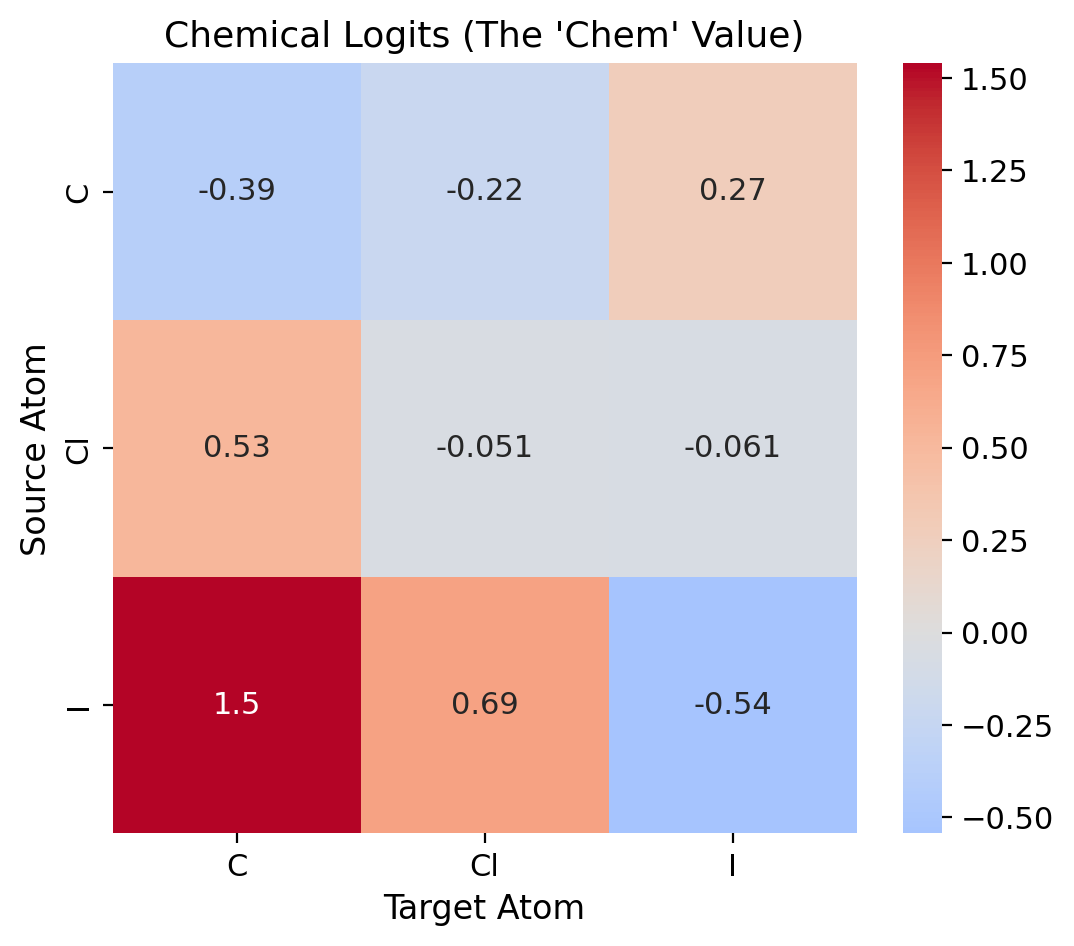

绘制图2: 几何贡献 vs 距离...


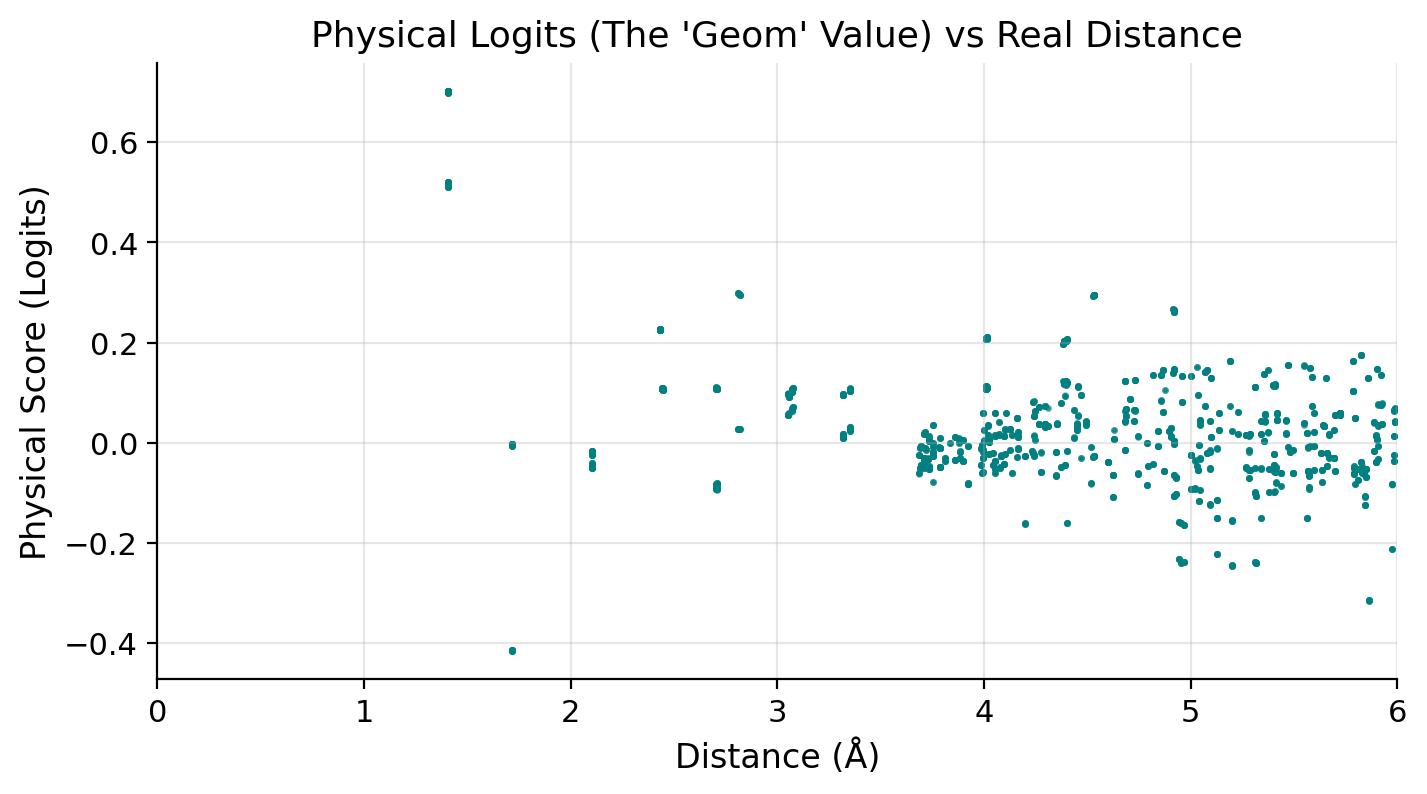

绘制图3: 最终 Gate 结果...


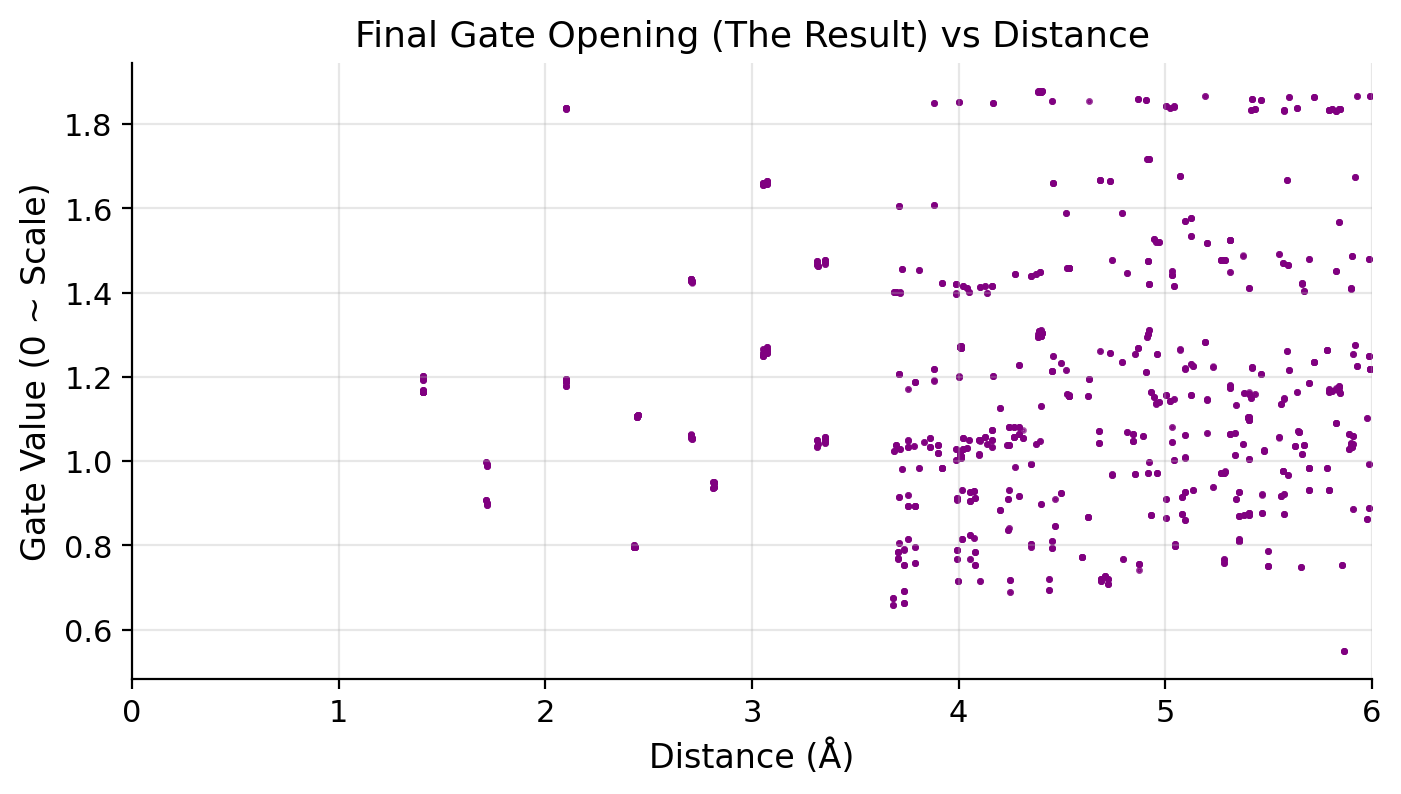

In [326]:
# ==========================================
# 📊 画图 1: 化学热图 (Chemical Map)
# ==========================================
# 目标：看 chem_v (Y) 与 元素类型 (X) 的关系
print("绘制图1: 化学亲和力热图...")
unique_elements = np.unique(np.concatenate([src_z, dst_z]))
elem_map = {z: i for i, z in enumerate(unique_elements)}
num_elem = len(unique_elements)
heatmap_matrix = np.zeros((num_elem, num_elem))
count_matrix = np.zeros((num_elem, num_elem)) + 1e-9

for k in range(len(chem_v)):
    i = elem_map[src_z[k]]
    j = elem_map[dst_z[k]]
    # 这里的 chem_v 就是你要的“化学值”
    heatmap_matrix[i, j] += chem_v[k] 
    count_matrix[i, j] += 1

avg_heatmap = heatmap_matrix / count_matrix
# 映射原子名称
z_to_name = {1:'H', 6:'C', 7:'N', 8:'O', 9:'F', 16:'S', 17:'Cl', 53:'I'} # 按需修改
labels = [z_to_name.get(z, str(z)) for z in unique_elements]

plt.figure(figsize=(6, 5))
sns.heatmap(avg_heatmap, xticklabels=labels, yticklabels=labels, cmap="coolwarm", annot=True, center=0)
plt.title("Chemical Logits (The 'Chem' Value)")
plt.xlabel("Target Atom")
plt.ylabel("Source Atom")
plt.show()

# ==========================================
# 📊 画图 2: 几何径向图 (Radial Profile)
# ==========================================
# 目标：看 phys_v (Y) 与 真实距离 (X) 的关系
print("绘制图2: 几何贡献 vs 距离...")
idx = np.random.choice(len(phys_v), 5000) # 随机采样防止卡顿

plt.figure(figsize=(8, 4))
# X轴：真实距离
# Y轴：phys_logits (这就是你要的“几何值”)
plt.scatter(dist_v[idx], phys_v[idx], s=2, alpha=0.4, c='teal')
plt.title("Physical Logits (The 'Geom' Value) vs Real Distance")
plt.xlabel("Distance (Å)")
plt.ylabel("Physical Score (Logits)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 6.0)
plt.show()

# ==========================================
# 📊 画图 3: 最终 Gate 分布
# ==========================================
print("绘制图3: 最终 Gate 结果...")
plt.figure(figsize=(8, 4))
plt.scatter(dist_v[idx], gate_v[idx], s=2, alpha=0.4, c='purple')
plt.title("Final Gate Opening (The Result) vs Distance")
plt.xlabel("Distance (Å)")
plt.ylabel("Gate Value (0 ~ Scale)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 6.0)
plt.show()

In [330]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ... (加载模型 model 和数据 test_loader 代码同前) ...

# ==========================================
# ⚡️ 定义 Hook：偷取角度特征 (p_ij)
# ==========================================
DATA = {
    "p_ij_strength": [], # 角度特征的强度 (我们把它看作角度的代理指标)
    "phys_logits": [],   # 物理得分
    "real_dist": []      # 真实距离 (用来做筛选)
}

def hook_separation(module, input, output):
    # input[0] 是 (E, 3*F) -> [Scalar(F) | p_src(F) | p_dst(F)]
    phys_input = input[0]
    total_dim = phys_input.shape[-1]
    F = total_dim // 3
    
    # 1. 拿到 p_ij (后 2F 维)
    # p_ij 代表了方向投影。如果角度合适（比如共线），投影值大；角度垂直，投影值小。
    p_ij = phys_input[:, F:].detach().cpu()
    
    # 计算“角度特征的总强度” (L2 Norm 或 Mean Abs)
    # 这代表了方向性有多强
    p_strength = p_ij.abs().mean(dim=-1)
    
    # 2. 拿到物理得分 (Logits)
    logits = output.mean(dim=-1).detach().cpu()
    
    DATA["p_ij_strength"].append(p_strength)
    DATA["phys_logits"].append(logits)

# 注册钩子
handle = model.layers[2].gating.phys_bias_mlp.register_forward_hook(hook_separation)

# ==========================================
# 🚀 跑真实数据
# ==========================================
print("正在从真实数据中提取角度效应...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 50: break
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        # 1. 记录真实的物理属性 (X轴数据)
        src, dst = batch.edge_index
        z = batch.z.cpu()
        
        # 处理 shifts_int (PBC)
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
            batch.shifts_int = batch.shifts_int.float()
            # 🔥 关键修改 1: 找到每一条边属于哪个图
            # batch.batch 是 (N,), src 是 (E,)
            # edge_batch_idx 就是 (E,), 告诉我们每条边属于第几个图
            edge_batch_idx = batch.batch[src]
            
            # 🔥 关键修改 2: 按边索引取出对应的 Cell
            # batch.cell 是 (Batch_Size, 3, 3)
            # batch_cell 变成 (E, 3, 3) -> 11072 个 3x3 矩阵
            batch_cell = batch.cell[edge_batch_idx]
            
            # 🔥 关键修改 3: 确保类型一致 (shifts_int 可能是 long, cell 是 float)
            shifts_float = batch.shifts_int.float()
            
            current_shifts = torch.bmm(
                shifts_float.unsqueeze(1), batch_cell
            ).squeeze(1)  # (E, 3)
            
        else:
            current_shifts = torch.zeros(
                (batch.edge_index.size(1), 3),
                device=batch.pos.device,
                dtype=batch.pos.dtype
            )
        
        vec = batch.pos[batch.edge_index[1]] - batch.pos[batch.edge_index[0]] + current_shifts
        d = torch.norm(vec, dim=-1).cpu()
        
        DATA["real_dist"].append(d)
        
        model(batch)

handle.remove()

# ==========================================
# 📊 画图：切片分析 (Slice Analysis)
# ==========================================
# 整理数据
all_dist = torch.cat(DATA["real_dist"]).numpy()
all_p_strength = torch.cat(DATA["p_ij_strength"]).numpy()
all_logits = torch.cat(DATA["phys_logits"]).numpy()

# 🔥 核心步骤：只看特定距离区间的数据 (Slice)
# 比如看范德华力区域：3.0 Å - 3.5 Å
# 这个区域距离差不多，所以距离带来的影响是固定的
# 剩下的分值差异就是角度带来的
mask = (all_dist > 3.0) & (all_dist < 3.5)

slice_p = all_p_strength[mask]
slice_logits = all_logits[mask]

print(f"在 3.0-3.5 Å 区间内找到 {len(slice_p)} 条边")

plt.figure(figsize=(6, 5))
plt.scatter(slice_p, slice_logits, s=5, alpha=0.5, c='orange')
plt.title("Angular Effect at Fixed Distance (3.0 - 3.5 Å)")
plt.xlabel("Directional Projection Strength (|p_ij|)")
plt.ylabel("Physical Score (Logits)")
plt.grid(True, alpha=0.3)
plt.show()

正在从真实数据中提取角度效应...


100%|██████████| 1/1 [00:00<00:00, 72.80it/s]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3672 but corresponding boolean dimension is 918

正在提取角度效应与键类型...


100%|██████████| 1/1 [00:00<00:00, 89.48it/s]

区间 1-1.5 Å 内共有 24 条边
Top 5 出现的键类型: Bond Type
C-C    24
Name: count, dtype: int64


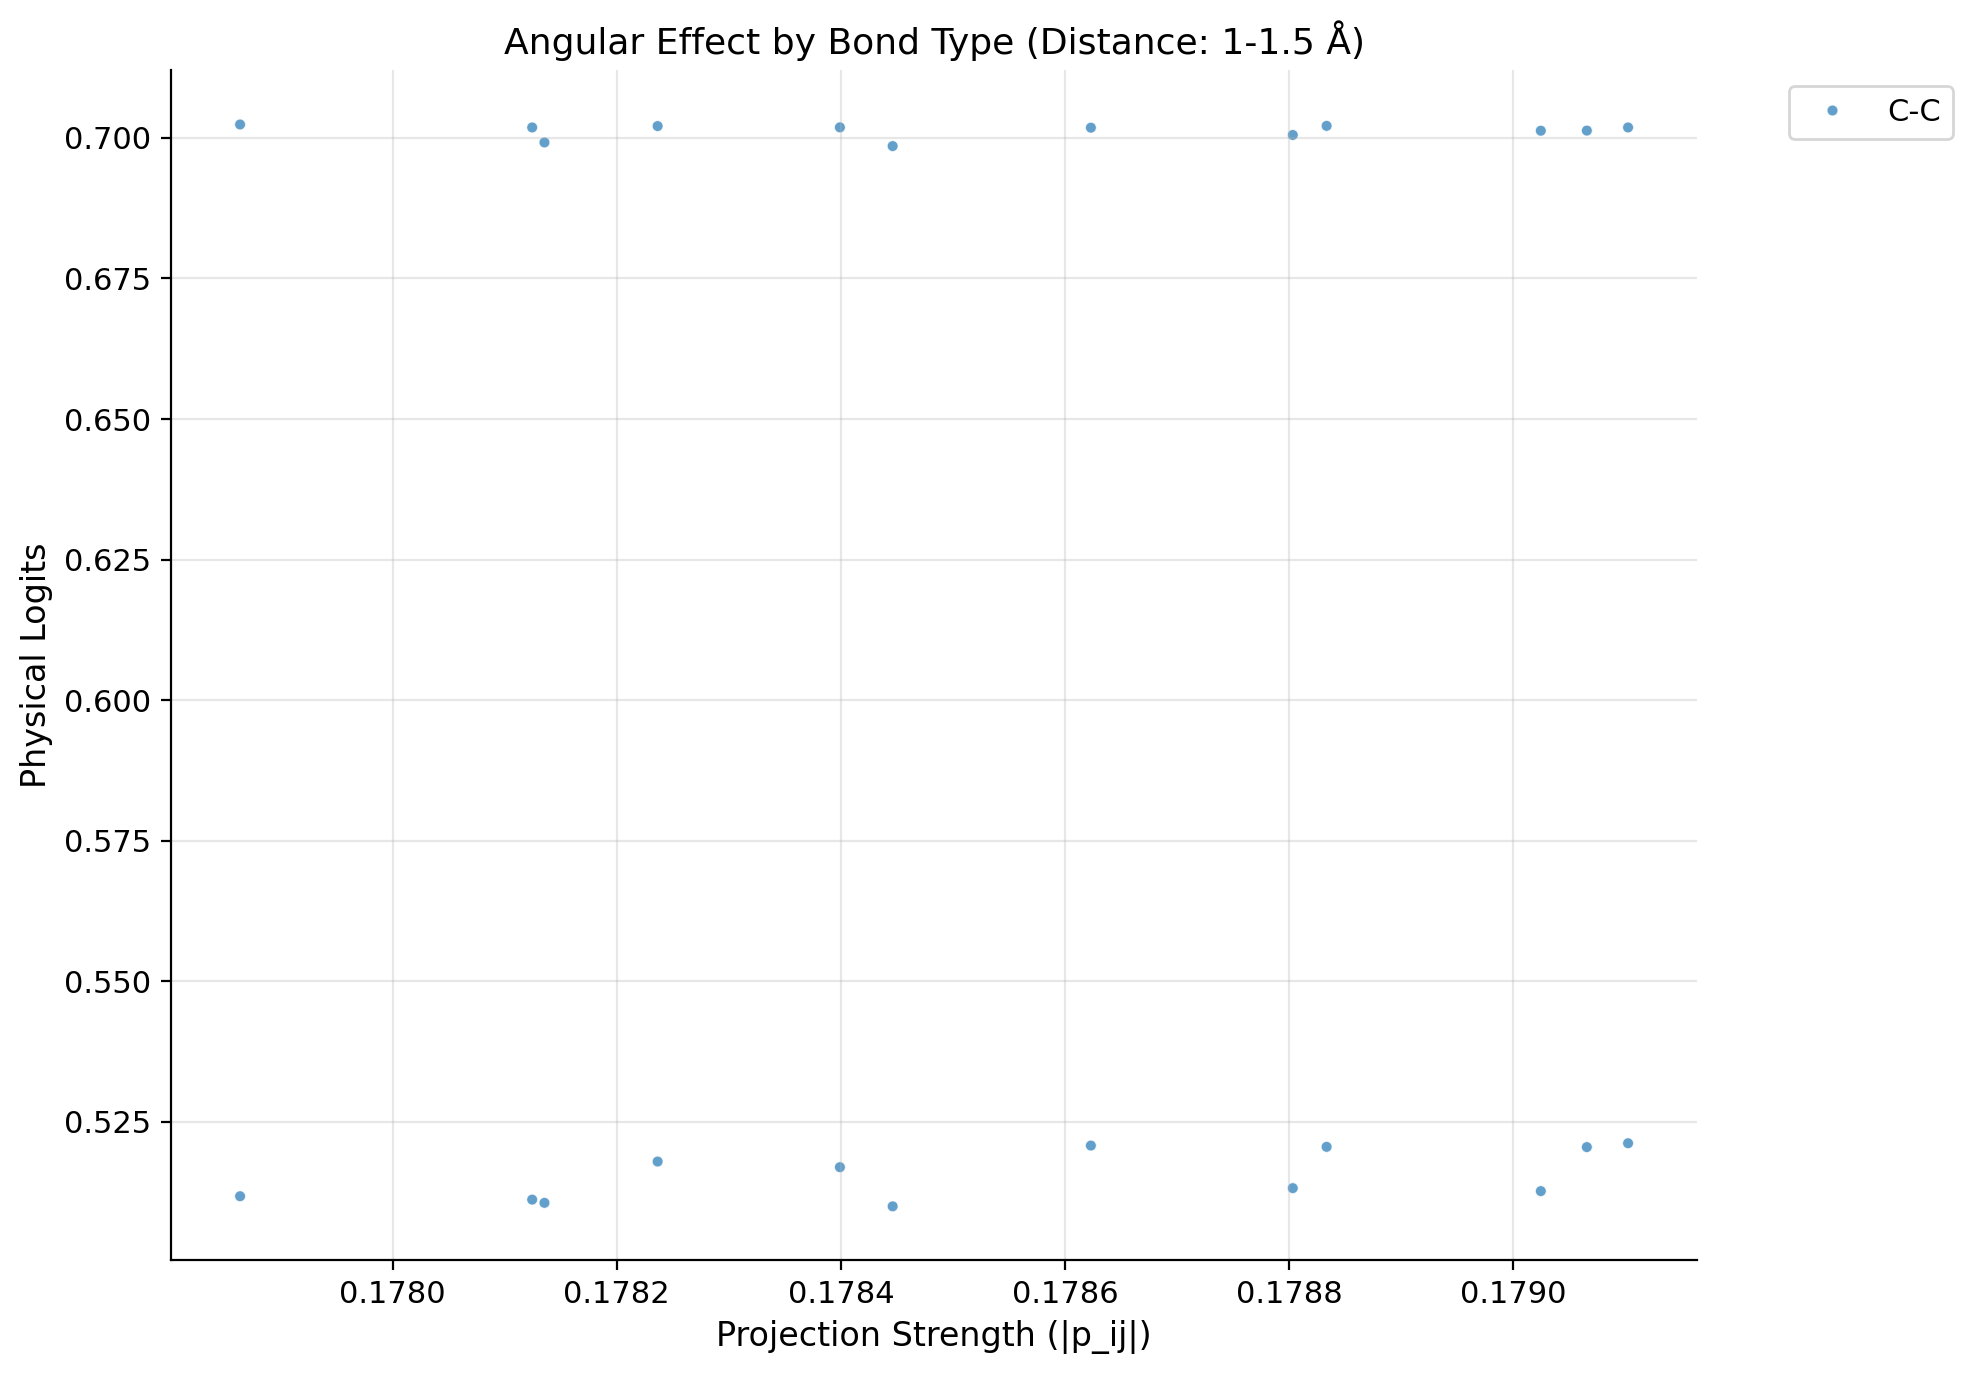

In [331]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # 我们需要 pandas 来方便管理分类数据
from tqdm import tqdm

# ... (加载模型 model 和数据 test_loader 代码同前) ...

# ==========================================
# ⚡️ 1. 定义容器 (增加原子类型记录)
# ==========================================
DATA = {
    "p_ij_strength": [], 
    "phys_logits": [],   
    "real_dist": [],
    "src_z": [],  # 🔥 新增：源原子
    "dst_z": []   # 🔥 新增：目标原子
}

# Hook 逻辑保持不变
def hook_separation(module, input, output):
    phys_input = input[0]
    total_dim = phys_input.shape[-1]
    F = total_dim // 3
    p_ij = phys_input[:, F:].detach().cpu()
    p_strength = p_ij.abs().mean(dim=-1)
    logits = output.mean(dim=-1).detach().cpu()
    
    DATA["p_ij_strength"].append(p_strength)
    DATA["phys_logits"].append(logits)

# 注册钩子
gating_layer = model.layers[2].gating
# 先清空旧钩子以防万一
gating_layer.phys_bias_mlp._forward_hooks.clear()
handle = gating_layer.phys_bias_mlp.register_forward_hook(hook_separation)

# ==========================================
# 🚀 2. 跑数据 (收集原子信息)
# ==========================================
print("正在提取角度效应与键类型...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 50: break # 跑 50 个 batch
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        
        # 1. 记录物理属性
        src, dst = batch.edge_index
        z = batch.z.cpu() # 拿到 CPU 上的原子序数
        
        # 🔥 新增：记录每一条边的原子对类型
        DATA["src_z"].append(z[src.cpu()])
        DATA["dst_z"].append(z[dst.cpu()])
        
        # ... (处理 shifts 和 距离的代码，直接复制你之前的) ...
        # 为了代码简洁，这里假设你已经算好了 d
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
             batch.shifts_int = batch.shifts_int.float()
             edge_batch_idx = batch.batch[src]
             batch_cell = batch.cell[edge_batch_idx]
             shifts_float = batch.shifts_int.float()
             current_shifts = torch.bmm(shifts_float.unsqueeze(1), batch_cell).squeeze(1)
        else:
             current_shifts = 0
             
        vec = batch.pos[dst] - batch.pos[src] + current_shifts
        d = torch.norm(vec, dim=-1).cpu()
        
        DATA["real_dist"].append(d)
        
        # 跑模型
        model(batch)

handle.remove()

# ==========================================
# 🧹 3. 数据整理与标签生成
# ==========================================
# 拼接数据
all_dist = torch.cat(DATA["real_dist"]).numpy()
all_p = torch.cat(DATA["p_ij_strength"]).numpy()
all_logits = torch.cat(DATA["phys_logits"]).numpy()
all_src = torch.cat(DATA["src_z"]).numpy()
all_dst = torch.cat(DATA["dst_z"]).numpy()

# 🔥 核心：生成“键类型”标签 (如 "C-H", "O-H")
z_map = {1:'H', 6:'C', 7:'N', 8:'O', 9:'F', 16:'S', 17:'Cl', 53:'I'} # 根据你的体系补充

bond_labels = []
for s, d in zip(all_src, all_dst):
    # 排序，保证 C-H 和 H-C 被视为同一种类型
    elem1 = z_map.get(s, str(s))
    elem2 = z_map.get(d, str(d))
    bond_name = f"{min(elem1, elem2)}-{max(elem1, elem2)}"
    bond_labels.append(bond_name)

bond_labels = np.array(bond_labels)

# ==========================================
# 📊 4. 切片可视化 (带颜色分类)
# ==========================================
# 设定切片区间
d_min, d_max = 1, 1.5
mask = (all_dist > d_min) & (all_dist < d_max)

# 构造 Pandas DataFrame (Seaborn 画图神器)
df_slice = pd.DataFrame({
    "Projection Strength (|p_ij|)": all_p[mask],
    "Physical Logits": all_logits[mask],
    "Bond Type": bond_labels[mask]
})

print(f"区间 {d_min}-{d_max} Å 内共有 {len(df_slice)} 条边")
print("Top 5 出现的键类型:", df_slice["Bond Type"].value_counts().head(5))

plt.figure(figsize=(10, 7))

# 🔥 使用 Seaborn 自动上色
# hue="Bond Type": 根据键类型染不同的颜色
# alpha=0.6: 半透明，防止点重叠
sns.scatterplot(
    data=df_slice, 
    x="Projection Strength (|p_ij|)", 
    y="Physical Logits", 
    hue="Bond Type", 
    palette="tab20",  # 颜色盘
    s=15,             # 点的大小
    alpha=0.7
)

plt.title(f"Angular Effect by Bond Type (Distance: {d_min}-{d_max} Å)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 图例放外边
plt.tight_layout()
plt.show()

✅ 成功部署 h0 钩子: Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
✅ 成功部署 h1 钩子: LeibnizCoupling(
  (path_weights): ModuleDict(
    (0_0_0_prod): Linear(in_features=64, out_features=64, bias=False)
    (0_1_1_prod): Linear(in_features=64, out_features=64, bias=False)
    (0_2_2_prod): Linear(in_features=64, out_features=64, bias=False)
    (1_0_1_prod): Linear(in_features=64, out_features=64, bias=False)
    (1_1_0_dot): Linear(in_features=64, out_features=64, bias=False)
    (1_1_1_cross): Linear(in_features=64, out_features=64, bias=False)
    (1_1_2_outer): Linear(in_features=64, out_features=64, bias=False)
    (2_0_2_prod): Linear(in_features=64, out_features=64, bias=False)
    (2_1_1_mat_vec): Linear(in_features=64, out_features=64, bias=False)
    (1_2_1_vec_mat): Linear(in_features=64, out_features=64, bias=False)
    (2_2_0_double_dot): Linear(in_features=64, out_features=64, bias=False)

100%|██████████| 1/1 [00:00<00:00, 99.25it/s]

提取完成! 原子总数: 24
正在进行 t-SNE 降维 (这可能需要几分钟)...


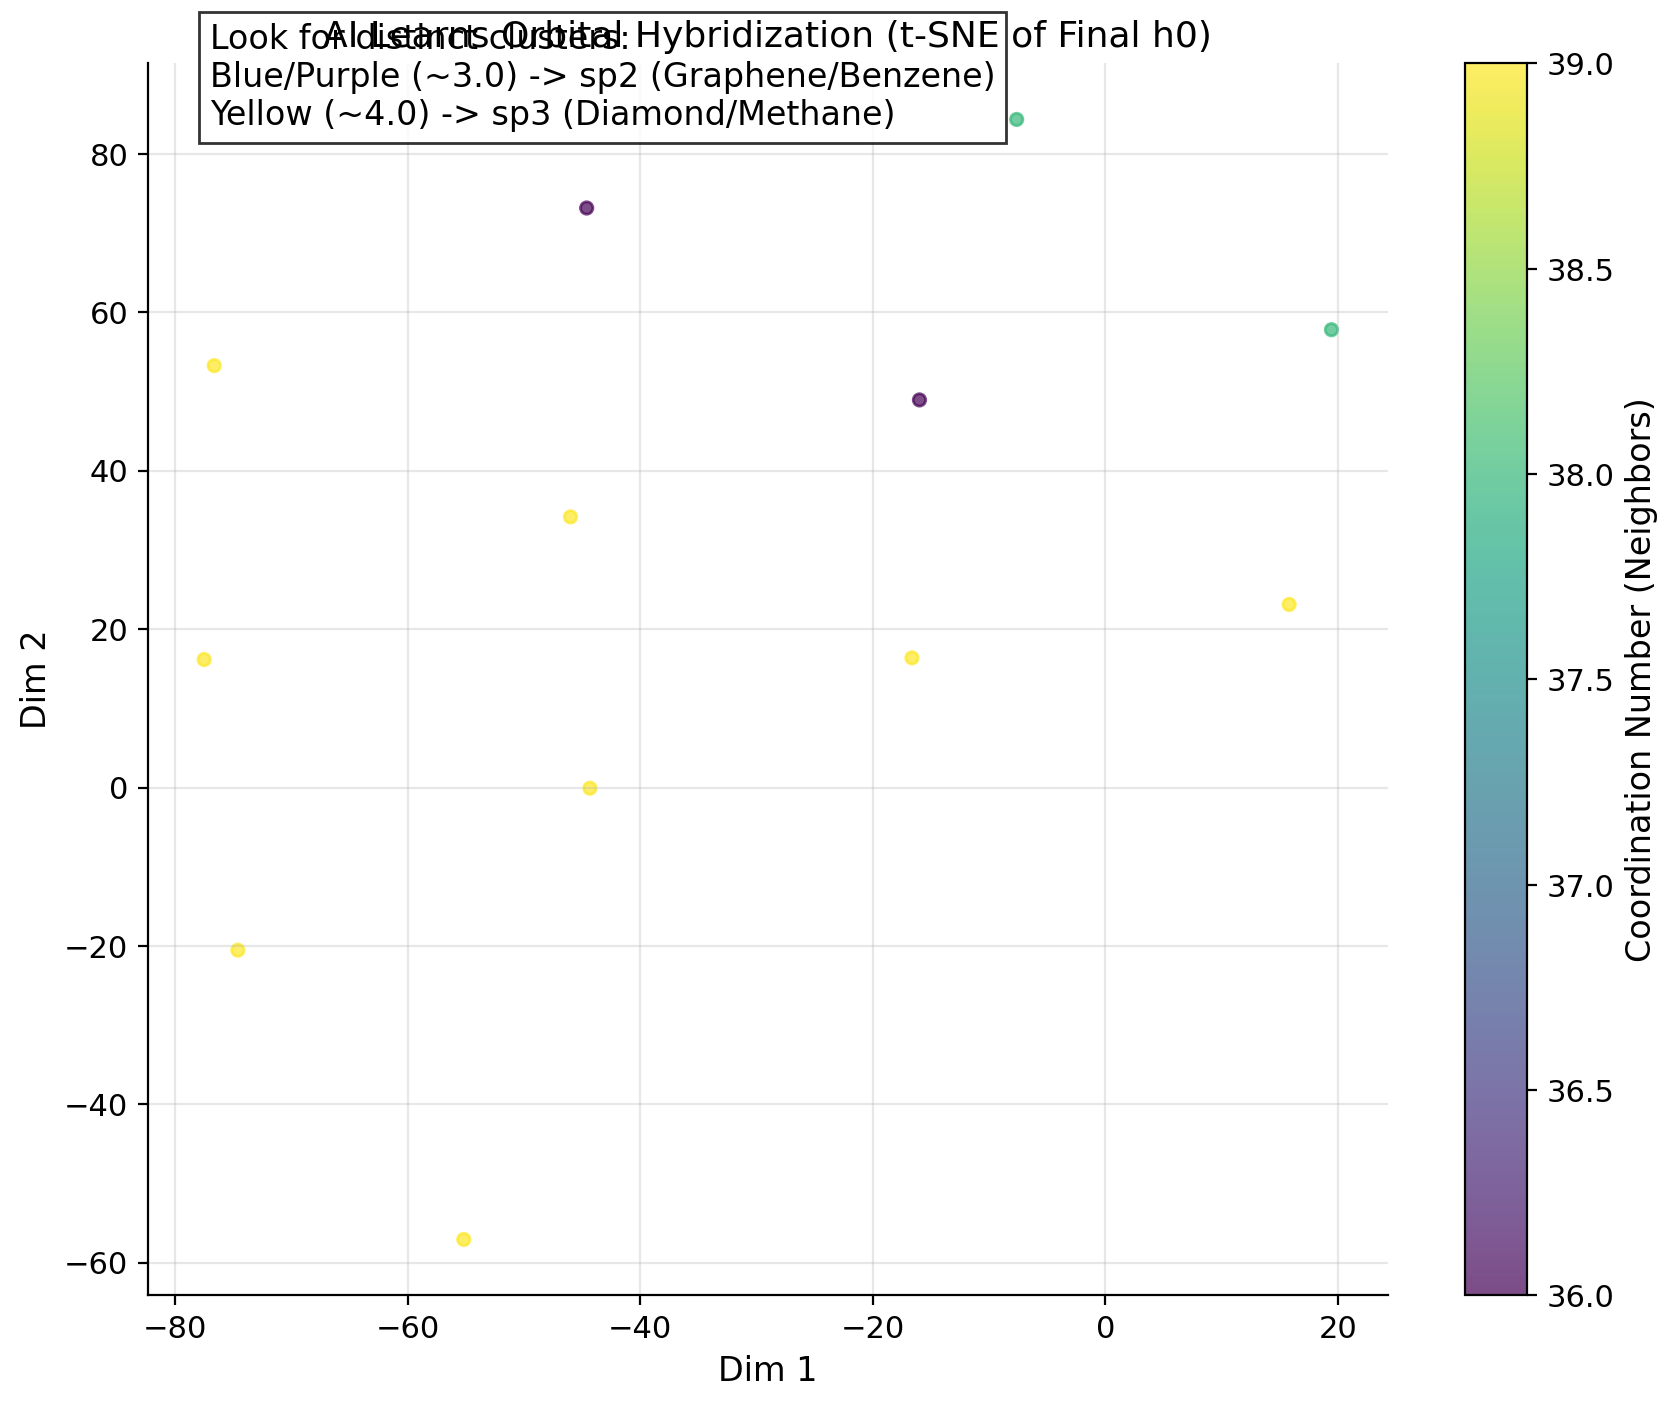

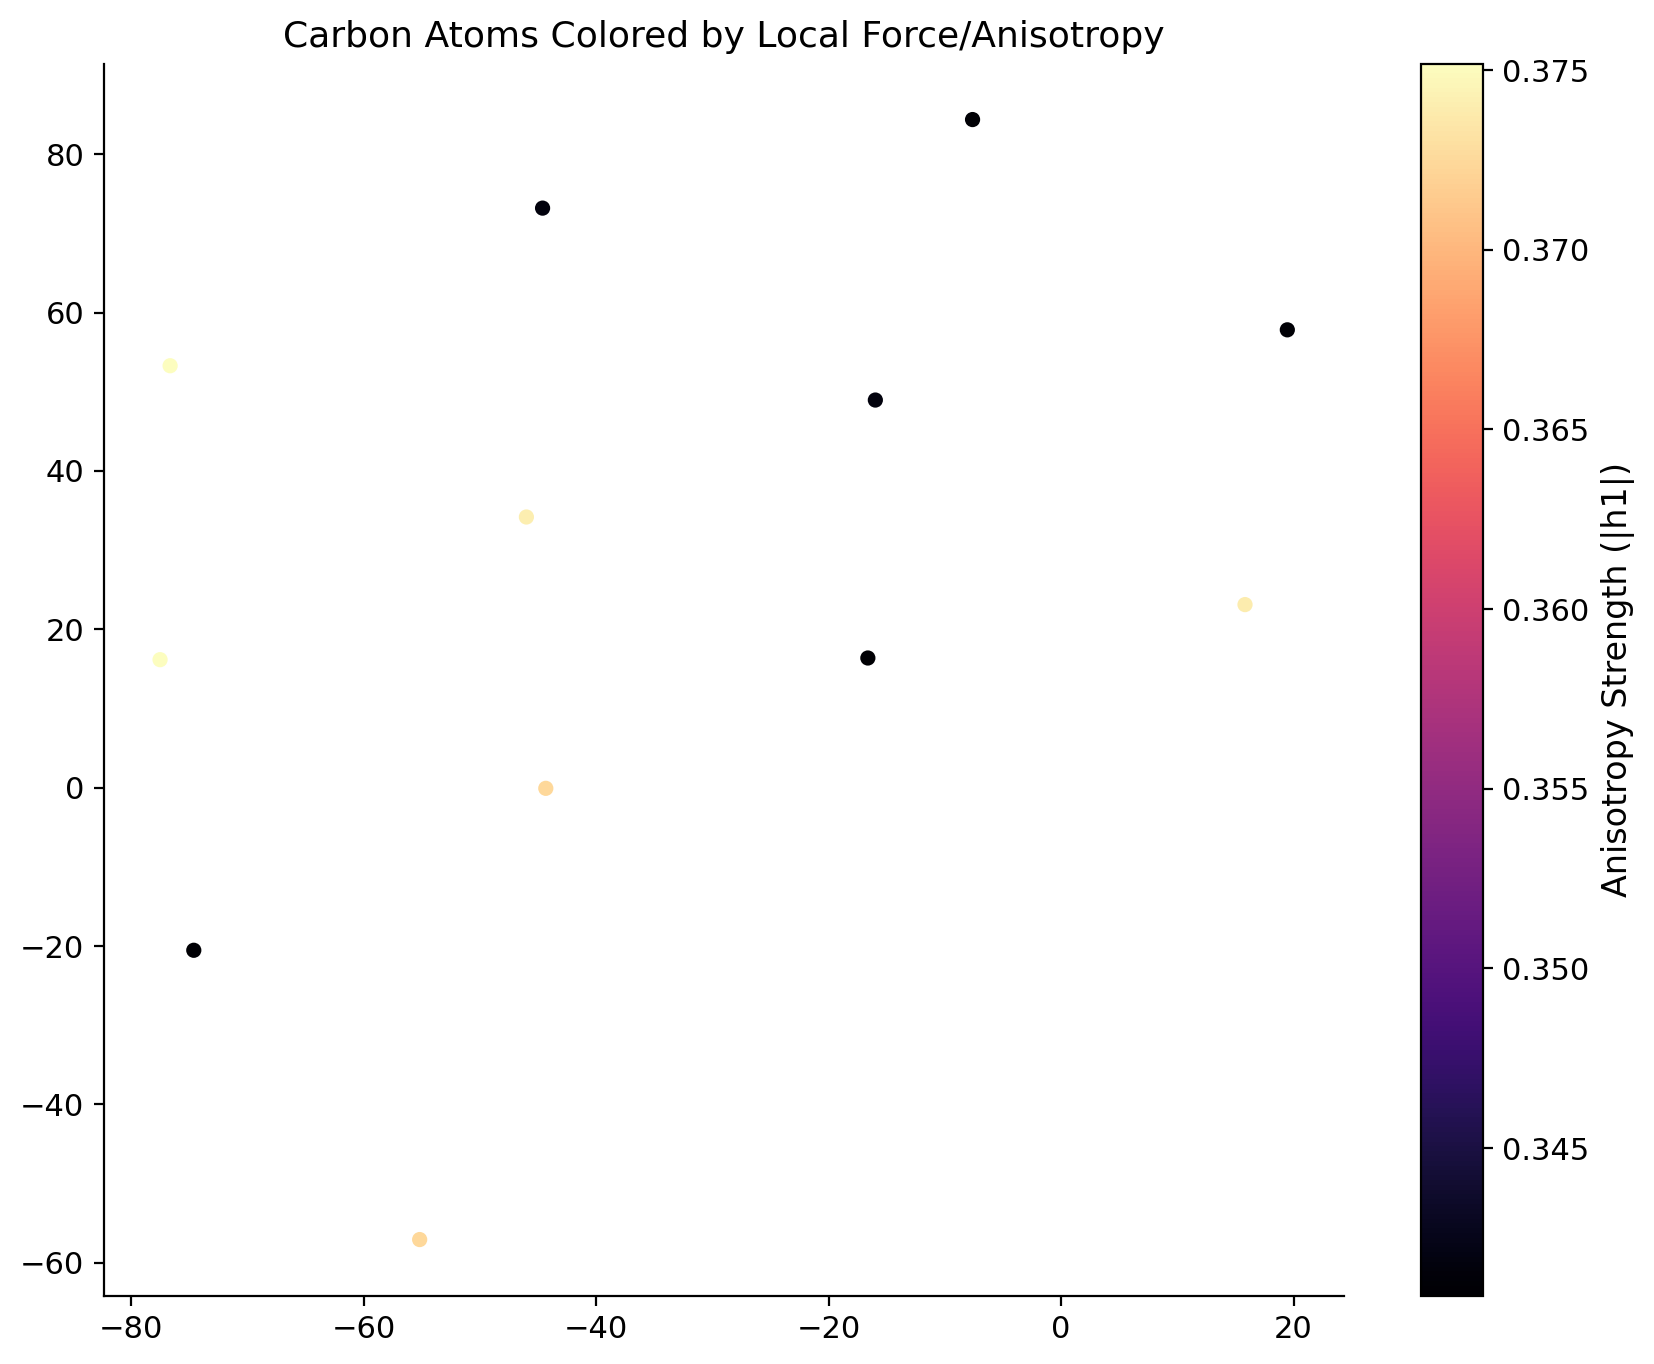

In [333]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from torch_geometric.utils import degree

# 1. 加载你已经训练好的模型 (这一步不用变)
# model = ... 
# model.eval()

# ==========================================
# ⚡️ 1. 定义数据容器
# ==========================================
ANALYSIS_DATA = {
    "h0": [],  # 最终的标量特征 (sp2/sp3 主要看它)
    "h1": [],  # 倒数第二步的矢量特征 (看受力/各向异性)
    "z": [],   # 原子序数
    "deg": []  # 配位数
}

# ==========================================
# 🪝 2. 定义双重钩子 (特工行动)
# ==========================================

# 🕵️ 特工 A: 埋伏在最后一层 Readout，抓捕最终 h0
def hook_final_h0(module, input, output):
    # input[0] 就是我们要的 h0
    h0 = input[0].detach().cpu().numpy()
    ANALYSIS_DATA["h0"].append(h0)

# 🕵️ 特工 B: 埋伏在最后一层 Coupling，抓捕深层 h1
def hook_deep_h1(module, input, output):
    # input[0] 是 node_feats 字典 {0: h0, 1: h1, ...}
    node_feats = input[0]
    
    # 抓取 h1 (矢量)
    if 1 in node_feats and node_feats[1] is not None:
        h1 = node_feats[1].detach().cpu().numpy()
        # 展平: (N, 3, F) -> (N, 3*F)
        h1_flat = h1.reshape(h1.shape[0], -1)
        ANALYSIS_DATA["h1"].append(h1_flat)

# 🎯 3. 部署钩子 (无需修改模型代码)
try:
    # 挂载 h0 钩子 -> 绝对精确的最终特征
    layer_readout = model.layers[-2]['readout']
    handle_h0 = layer_readout.register_forward_hook(hook_final_h0)
    print(f"✅ 成功部署 h0 钩子: {layer_readout}")

    # 挂载 h1 钩子 -> 深层特征
    layer_coupling = model.layers[-1]['coupling']
    handle_h1 = layer_coupling.register_forward_hook(hook_deep_h1)
    print(f"✅ 成功部署 h1 钩子: {layer_coupling}")

except Exception as e:
    print(f"❌ 部署失败: {e}")
    # 如果失败，可能是你的 layers 不是 ModuleList，请 print(model) 给我看

# ==========================================
# 🚀 4. 跑数据
# ==========================================
print("正在提取特征...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 50: break # 跑 50 个 batch 足够画图了
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        
        # 简单的 shifts 处理
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
             batch.shifts_int = batch.shifts_int.float()

        # 记录原子信息
        ANALYSIS_DATA["z"].append(batch.z.cpu().numpy())
        
        # 计算配位数 (用于验证 sp2/sp3)
        num_nodes = batch.z.size(0)
        d = degree(batch.edge_index[0], num_nodes).cpu().numpy()
        ANALYSIS_DATA["deg"].append(d)
        
        # 跑模型 (触发钩子)
        model(batch)

# 撤退：移除钩子
handle_h0.remove()
handle_h1.remove()

# ==========================================
# 🧹 5. 数据整理
# ==========================================
all_h0 = np.concatenate(ANALYSIS_DATA["h0"], axis=0)
all_z = np.concatenate(ANALYSIS_DATA["z"], axis=0)
all_deg = np.concatenate(ANALYSIS_DATA["deg"], axis=0)

all_h1 = None
if len(ANALYSIS_DATA["h1"]) > 0:
    all_h1 = np.concatenate(ANALYSIS_DATA["h1"], axis=0)

print(f"提取完成! 原子总数: {len(all_z)}")

# ==========================================
# 🧠 6. 见证奇迹：碳原子杂化轨道分离图
# ==========================================
print("正在进行 t-SNE 降维 (这可能需要几分钟)...")
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
h0_2d = tsne.fit_transform(all_h0)

# 筛选碳原子 (Z=6)
mask_c = (all_z == 6)

plt.figure(figsize=(10, 8))
# 颜色映射：根据配位数 (3=sp2, 4=sp3)
scatter = plt.scatter(
    h0_2d[mask_c, 0], 
    h0_2d[mask_c, 1], 
    c=all_deg[mask_c], 
    cmap='viridis', 
    s=20, 
    alpha=0.7
)
plt.colorbar(scatter, label="Coordination Number (Neighbors)")
plt.title("AI Learns Orbital Hybridization (t-SNE of Final h0)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True, alpha=0.3)

# 添加注释
plt.text(0.05, 0.95, "Look for distinct clusters:\nBlue/Purple (~3.0) -> sp2 (Graphene/Benzene)\nYellow (~4.0) -> sp3 (Diamond/Methane)", 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# ==========================================
# 💡 7. 进阶：看看 h1 (受力/各向异性)
# ==========================================
if all_h1 is not None:
    # 计算 h1 的模长
    # h1 是 (N, 3*F)，我们把它还原成 (N, 3, F) 然后求模
    h1_reshaped = all_h1.reshape(all_h1.shape[0], 3, -1)
    # 对 3 个矢量分量求模，再对 F 维取平均，得到一个标量代表“各向异性强度”
    h1_magnitude = np.linalg.norm(h1_reshaped, axis=1).mean(axis=1)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(h0_2d[mask_c, 0], h0_2d[mask_c, 1], c=h1_magnitude[mask_c], cmap='magma', s=20)
    plt.colorbar(label="Anisotropy Strength (|h1|)")
    plt.title("Carbon Atoms Colored by Local Force/Anisotropy")
    plt.show()